In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from persiantools.jdatetime import JalaliDate
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from bidi.algorithm import get_display
from arabic_reshaper import reshape
from sklearn.metrics import classification_report

In [2]:
import warnings

%config Completer.use_jedi = False
warnings.filterwarnings("ignore")

# Loading Data:

### Air Quality Data

In [3]:
air_quality = pd.read_excel("./datasets/tehran.xlsx")

air_quality.set_axis( air_quality.loc[0,:], axis=1, inplace=True)
air_quality = air_quality.iloc[2:3946 , :]
air_quality = air_quality.drop(columns=['ایستگاه','پاک','قابل قبول','ناسالم  برای گروه حساس','ناسالم','بسیار ناسالم','خطرناک'])

air_quality.rename(columns={'تاریخ' : 'date'}, inplace=True)

air_quality = air_quality.loc[1463:, :].reset_index(drop=True)
air_quality


0           date  CO  O3 NO2 SO2 PM10 PM2.5  AQI
0     1394/01/01  48  20  56  19   34    61   61
1     1394/01/02  24  27  51  20   31    51   51
2     1394/01/03  29  30  45  18   14    29   30
3     1394/01/04  28  30  52  20   18    29   30
4     1394/01/05  30  29  60  27   30    53   53
...          ...  ..  ..  ..  ..  ...   ...  ...
2478  1400/10/11  39  11  89  29   71   134  134
2479  1400/10/12  29   9  89  77   67   125  125
2480  1400/10/13  28   7  64  18   52   108  108
2481  1400/10/14  29  11  64  27   43    78   78
2482  1400/10/15  33  15  73  23   49    80   80

[2483 rows x 8 columns]

### Weather Data

In [4]:
weather = pd.read_excel("./datasets/export.xlsx")

weather['date'] = weather.date.apply(lambda x: JalaliDate.to_jalali( int(x[:4]), 
                                                                     int(x[5:7]),
                                                                     int(x[8:])
                                                                   ))
weather['date'] = weather.date.str.replace('-', '/')

weather = weather.loc[79:2561,:].reset_index(drop=True)

weather

date  tavg  tmin  tmax  prcp  snow   wdir  wspd  wpgt    pres  tsun
0      NaN  15.9  10.2  20.4   NaN   NaN    NaN  10.3   NaN     NaN   NaN
1      NaN  13.5   NaN  19.0   NaN   NaN    NaN   NaN   NaN     NaN   NaN
2      NaN   7.7   5.0  10.2   NaN   NaN  277.0  28.2   NaN     NaN   NaN
3      NaN  10.6   3.6  14.4   NaN   NaN    NaN   7.4   NaN     NaN   NaN
4      NaN  12.6   8.6  15.4   0.0   NaN    NaN   9.1   NaN     NaN   NaN
...    ...   ...   ...   ...   ...   ...    ...   ...   ...     ...   ...
2478   NaN   7.2   3.0  11.0   0.0   NaN  215.3  10.0   NaN  1018.3   NaN
2479   NaN   6.5   5.0   8.0   1.9   NaN  228.0   9.5   NaN  1013.6   NaN
2480   NaN   6.3   4.0  10.0   0.8   NaN  270.2  16.2   NaN  1010.0   NaN
2481   NaN   5.7   2.0  10.0   0.0   NaN  287.8  15.1   NaN  1012.5   NaN
2482   NaN   7.1   2.0  10.0   0.0   NaN  282.6  20.9   NaN  1013.7   NaN

[2483 rows x 11 columns]

### Join Air Quality and Weather Data

In [5]:
tehran = air_quality.join( weather[['tavg', 'prcp', 'snow', 'wspd']] )

tehran.head()

date  CO  O3 NO2 SO2 PM10 PM2.5 AQI  tavg  prcp  snow  wspd
0  1394/01/01  48  20  56  19   34    61  61  15.9   NaN   NaN  10.3
1  1394/01/02  24  27  51  20   31    51  51  13.5   NaN   NaN   NaN
2  1394/01/03  29  30  45  18   14    29  30   7.7   NaN   NaN  28.2
3  1394/01/04  28  30  52  20   18    29  30  10.6   NaN   NaN   7.4
4  1394/01/05  30  29  60  27   30    53  53  12.6   0.0   NaN   9.1

### Fill Non-Values

In [6]:
tehran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2483 non-null   object 
 1   CO      2483 non-null   object 
 2   O3      2483 non-null   object 
 3   NO2     2483 non-null   object 
 4   SO2     2483 non-null   object 
 5   PM10    2483 non-null   object 
 6   PM2.5   2483 non-null   object 
 7   AQI     2483 non-null   object 
 8   tavg    2482 non-null   float64
 9   prcp    2409 non-null   float64
 10  snow    17 non-null     float64
 11  wspd    2332 non-null   float64
dtypes: float64(4), object(8)
memory usage: 232.9+ KB


In [7]:
tehran.snow = tehran.snow.fillna(0)
tehran = tehran.interpolate()
tehran = tehran.fillna(method='bfill')
tehran

date  CO  O3  NO2  SO2  PM10  PM2.5  AQI  tavg  prcp  snow   wspd
0     1394/01/01  48  20   56   19    34     61   61  15.9   0.0   0.0  10.30
1     1394/01/02  24  27   51   20    31     51   51  13.5   0.0   0.0  19.25
2     1394/01/03  29  30   45   18    14     29   30   7.7   0.0   0.0  28.20
3     1394/01/04  28  30   52   20    18     29   30  10.6   0.0   0.0   7.40
4     1394/01/05  30  29   60   27    30     53   53  12.6   0.0   0.0   9.10
...          ...  ..  ..  ...  ...   ...    ...  ...   ...   ...   ...    ...
2478  1400/10/11  39  11   89   29    71    134  134   7.2   0.0   0.0  10.00
2479  1400/10/12  29   9   89   77    67    125  125   6.5   1.9   0.0   9.50
2480  1400/10/13  28   7   64   18    52    108  108   6.3   0.8   0.0  16.20
2481  1400/10/14  29  11   64   27    43     78   78   5.7   0.0   0.0  15.10
2482  1400/10/15  33  15   73   23    49     80   80   7.1   0.0   0.0  20.90

[2483 rows x 12 columns]

In [8]:
tehran.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2483 entries, 0 to 2482
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    2483 non-null   object 
 1   CO      2483 non-null   int64  
 2   O3      2483 non-null   int64  
 3   NO2     2483 non-null   int64  
 4   SO2     2483 non-null   int64  
 5   PM10    2483 non-null   int64  
 6   PM2.5   2483 non-null   int64  
 7   AQI     2483 non-null   int64  
 8   tavg    2483 non-null   float64
 9   prcp    2483 non-null   float64
 10  snow    2483 non-null   float64
 11  wspd    2483 non-null   float64
dtypes: float64(4), int64(7), object(1)
memory usage: 232.9+ KB


### Assigning Label

In [9]:
def aqi(x):
    if x in range(0,51):
        return 1
    if x in range(51,101):
        return 2
    if x in range(101,151):
        return 3
    if x in range(151,201):
        return 4
    if x in range(201,301):
        return 5
    if x in range(301,501):
        return 6       
    
def aqi_to_name(label, fa=True):
    assert type(label)==int, "Type of label must be an integer number."
    
    labels_name_fa = ["پاک", "سالم", "ناسالم برای گروه‌های حساس", "نا سالم", "بسیار ناسالم"]
    labels_name_eng = ["Pak", "Salem", "Na Salem Baraye Grouh Haye Hassas", "Na Salem", "Besiyar Nasalem"]
    
    if not fa:
        return labels_name_eng[label]
    
    return labels_name_fa[label] 

In [10]:
tehran["year"] = tehran["date"].str.split('/', expand=True)[0]
tehran["month"] = tehran["date"].str.split('/', expand=True)[1]

tehran = tehran.filter(['year', 'month', 'CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5', 'AQI', 'tavg', 'prcp', 'snow', 'wspd']).dropna()

tehran["label"] = tehran["AQI"].apply(aqi).shift(-1)

tehran.reset_index(drop=True, inplace=True)
tehran.dropna(inplace=True)

In [11]:
for i in tehran.columns:
    tehran[i] = tehran[i].astype('int')

### Distribution of Different Labels

In [12]:
df = tehran.groupby(by="label").size()
df

label
1     128
2    1691
3     613
4      49
5       1
dtype: int64

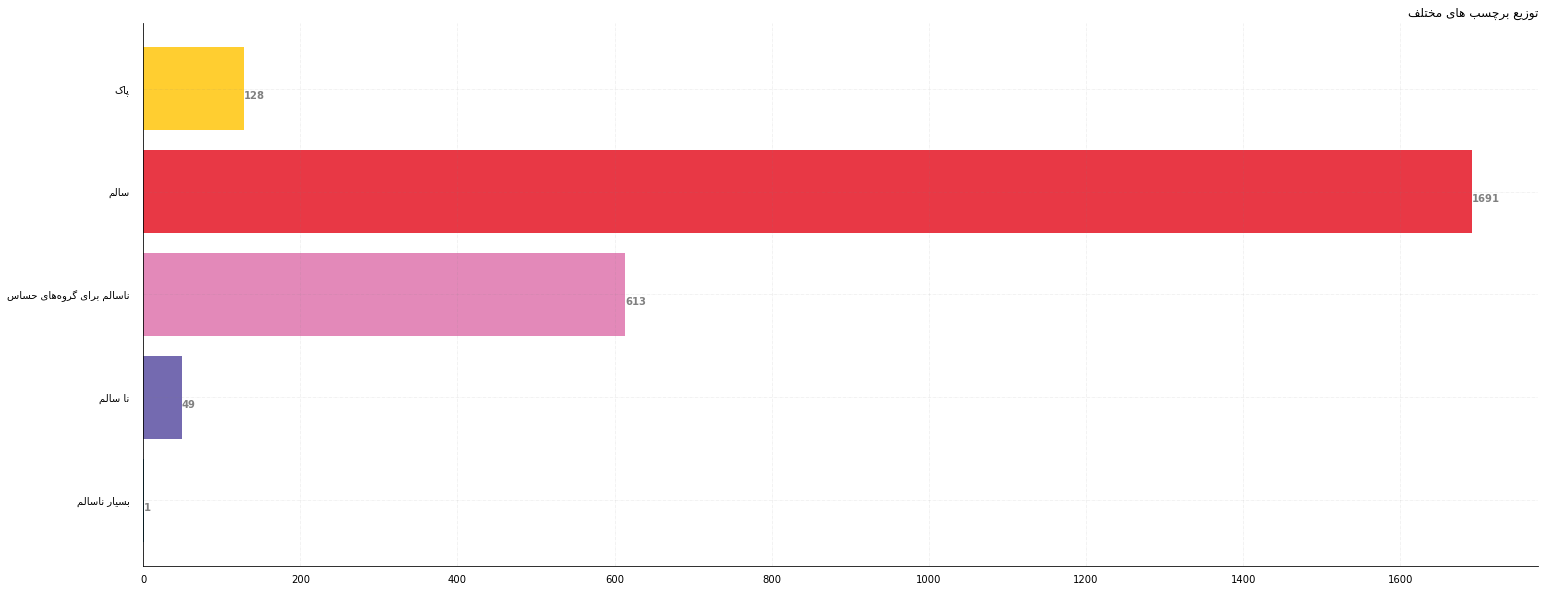

In [13]:
labels = [aqi_to_name(int(x)-1, fa=False) for x in df.index.tolist()]
counts = [df[x] for x in df.index]

classes_id = [0, 1, 2, 3, 4]
labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

fig, ax = plt.subplots(figsize =(25, 10))

ax.barh(labels, counts, color=["#FFCE30","#E83845", "#E389B9","#746AB0","#288BA8"])

for s in ['top', 'right']:
    ax.spines[s].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')
 
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
 
ax.invert_yaxis()

for i in ax.patches:
    plt.text(i.get_width()+0.2, i.get_y()+0.5,
             str(round((i.get_width()), 2)),
             fontsize = 10, fontweight ='bold',
             color ='grey')

ax.set_title(get_display(reshape('توزیع برچسب های مختلف')),
             loc ='right', )

plt.savefig("./plots/imbalance data/label_distribution.png")
 
plt.show()

In [14]:
index = tehran[ tehran["label"]==5 ].index[0]
tehran.drop(index, inplace=True)

In [15]:
tehran[ tehran["label"]==5 ]

Empty DataFrame
Columns: [year, month, CO, O3, NO2, SO2, PM10, PM2.5, AQI, tavg, prcp, snow, wspd, label]
Index: []

In [16]:
tehran.head()

year  month  CO  O3  NO2  SO2  PM10  PM2.5  AQI  tavg  prcp  snow  wspd  \
0  1394      1  48  20   56   19    34     61   61    15     0     0    10   
1  1394      1  24  27   51   20    31     51   51    13     0     0    19   
2  1394      1  29  30   45   18    14     29   30     7     0     0    28   
3  1394      1  28  30   52   20    18     29   30    10     0     0     7   
4  1394      1  30  29   60   27    30     53   53    12     0     0     9   

   label  
0      2  
1      1  
2      1  
3      2  
4      1

# Train and Test Spliting

In [17]:
data_features = ['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5', 'tavg', 'prcp', 'snow', 'wspd']
X = tehran.loc[:, ['CO', 'O3', 'NO2', 'SO2', 'PM10', 'PM2.5', 'tavg', 'prcp', 'snow', 'wspd']]
Y = tehran.loc[:, ["label"]]

Y["label"].unique()

array([2, 1, 3, 4])

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=705, stratify=Y)

Y_train = np.squeeze(Y_train)
Y_test = np.squeeze(Y_test)

X_train.shape, Y_train.shape

((1984, 10), (1984,))

# Imbalancing Data

In [19]:
_X = X_train.join(Y_train)

dominant = (_X["label"]==2) | (_X["label"]==3)
dominant = dominant.apply(lambda x: 1 if x else 0)
_X["dominant"] = dominant

_X.head()

CO  O3  NO2  SO2  PM10  PM2.5  tavg  prcp  snow  wspd  label  dominant
205   52  29   65   23    51     78    20     0     0     4      2         1
842   44  68   81    9    73     99    35     0     0    12      2         1
1323  22  31   46   13    40     50    11     0     0     6      2         1
1665  40  30   68   13    62     79    22     0     0     6      2         1
1445  23  34   65   14    43     58    10     0     0     8      2         1

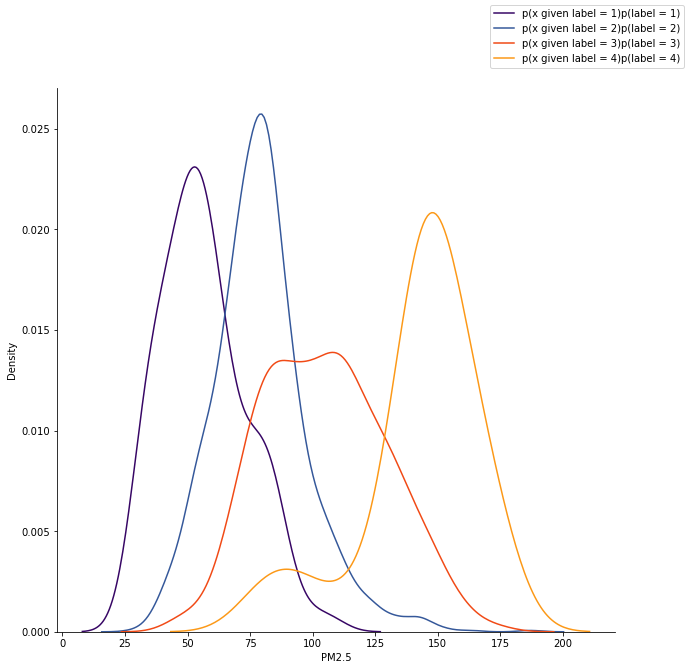

In [20]:
#Individual Densities
fig,ax = plt.subplots(figsize=(10,10))
sns.kdeplot(_X[_X.label == 1]['PM2.5'], color='#370665', linestyle="-")
sns.kdeplot(_X[_X.label == 2]['PM2.5'], color='#35589A', linestyle="-")
sns.kdeplot(_X[_X.label == 3]['PM2.5'], color='#F14A16', linestyle="-")
sns.kdeplot(_X[_X.label == 4]['PM2.5'] ,c='#FC9918', linestyle="-")
fig.legend(labels=['p(x given label = 1)p(label = 1)',
                   'p(x given label = 2)p(label = 2)',
                   'p(x given label = 3)p(label = 3)',
                   'p(x given label = 4)p(label = 4)'])

sns.despine(top=True, right=True)
plt.savefig("./plots/imbalance data/Individual-Density.png")
plt.show()

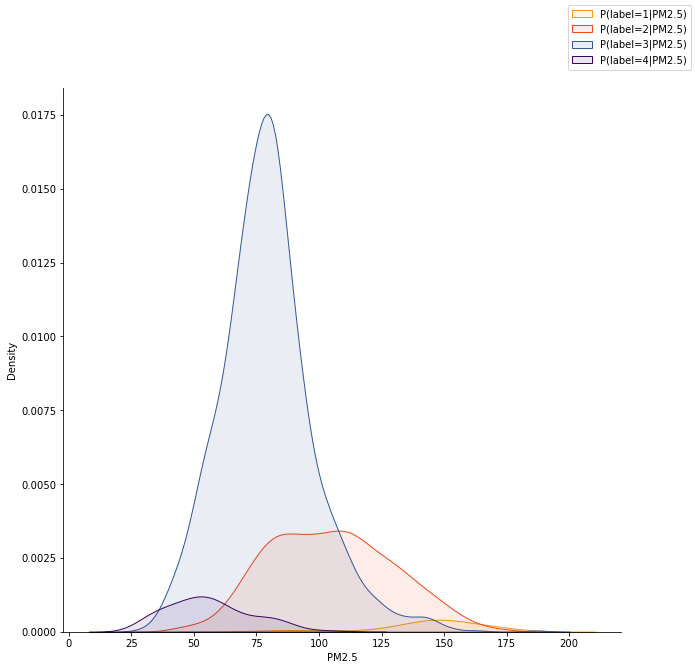

In [21]:
fig,ax = plt.subplots(figsize=(10,10))
sns.kdeplot(data = _X, 
            x ='PM2.5', hue='label',alpha =0.1, shade=True, legend=False
           ,palette={1: "#370665", 2: "#35589A", 3: "#F14A16", 4: "#FC9918"})
fig.legend(labels=['P(label=1|PM2.5)', 
                   'P(label=2|PM2.5)',
                   'P(label=3|PM2.5)',
                   'P(label=4|PM2.5)'
                  ])

sns.despine(top=True, right=True)
plt.savefig("./plots/imbalance data/Joint-Density-Plots.png")
plt.show()

# Feature Selection

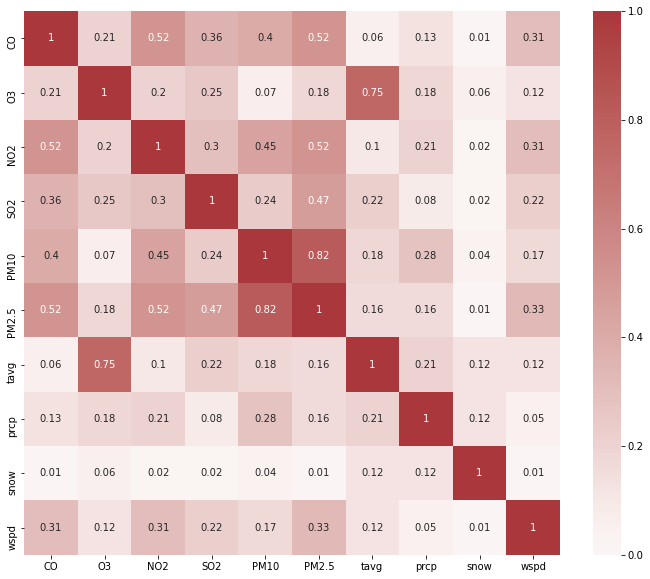

In [22]:
matrix = abs(X_train.corr().round(2))

plt.figure(figsize=(12,10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0, cmap='vlag')

plt.savefig("./plots/feature selection/feature_correlation.png")
plt.show()

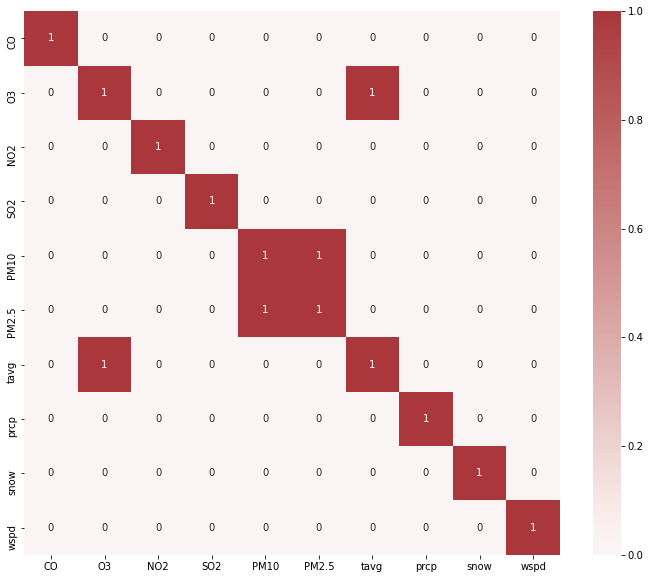

In [23]:
matrix = abs(X_train.corr().round(2)>=0.7)

plt.figure(figsize=(12,10))
sns.heatmap(matrix, annot=True, vmax=1, vmin=0, center=0, cmap='vlag')
plt.savefig("./plots/feature selection/feature_correlation_threshold.png")
plt.show()

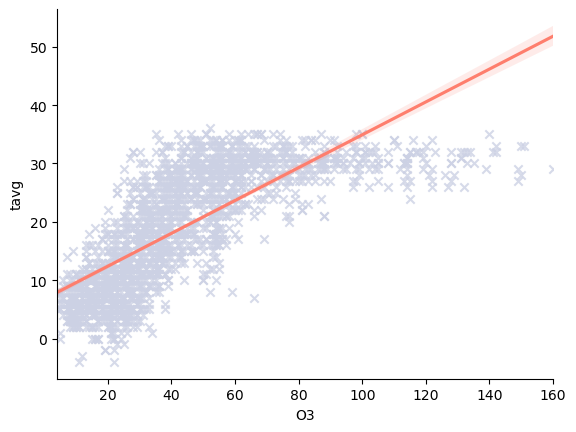

In [24]:
import matplotlib
plt.rcParams.update(matplotlib.rcParamsDefault)

sns.regplot(x="O3", y="tavg", 
            data=X_train,
            scatter_kws={"color": "#CCD1E4"},
            line_kws={"color": "#FE7E6D"},
            marker="x"
           )

sns.despine(top=True, right=True)

plt.savefig("./plots/feature selection/regplot_o3_tavg.png")
plt.show()

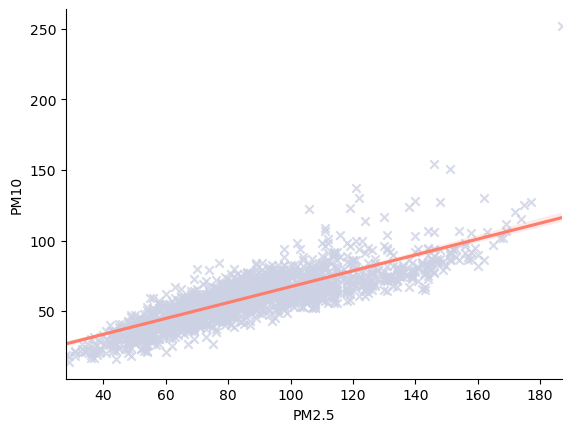

In [25]:
import matplotlib
plt.rcParams.update(matplotlib.rcParamsDefault)

sns.regplot(x="PM2.5", y="PM10", 
            data=X_train,
            scatter_kws={"color": "#CCD1E4"},
            line_kws={"color": "#FE7E6D"},
            marker="x"
           )

sns.despine(top=True, right=True)
plt.savefig("./plots/feature selection/regplot_pm25_pm10.png")
plt.show()

- # Random Forest Built-in Feature Importance

In [26]:
from sklearn.ensemble import RandomForestRegressor

plt.rcParams.update({'figure.figsize': (12.0, 8.0)})
plt.rcParams.update({'font.size': 14})

rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, Y_train)

rf.feature_importances_

array([0.07327016, 0.09030497, 0.07707512, 0.06715972, 0.07048447,
       0.40495736, 0.07728588, 0.01345605, 0.00287991, 0.12312635])

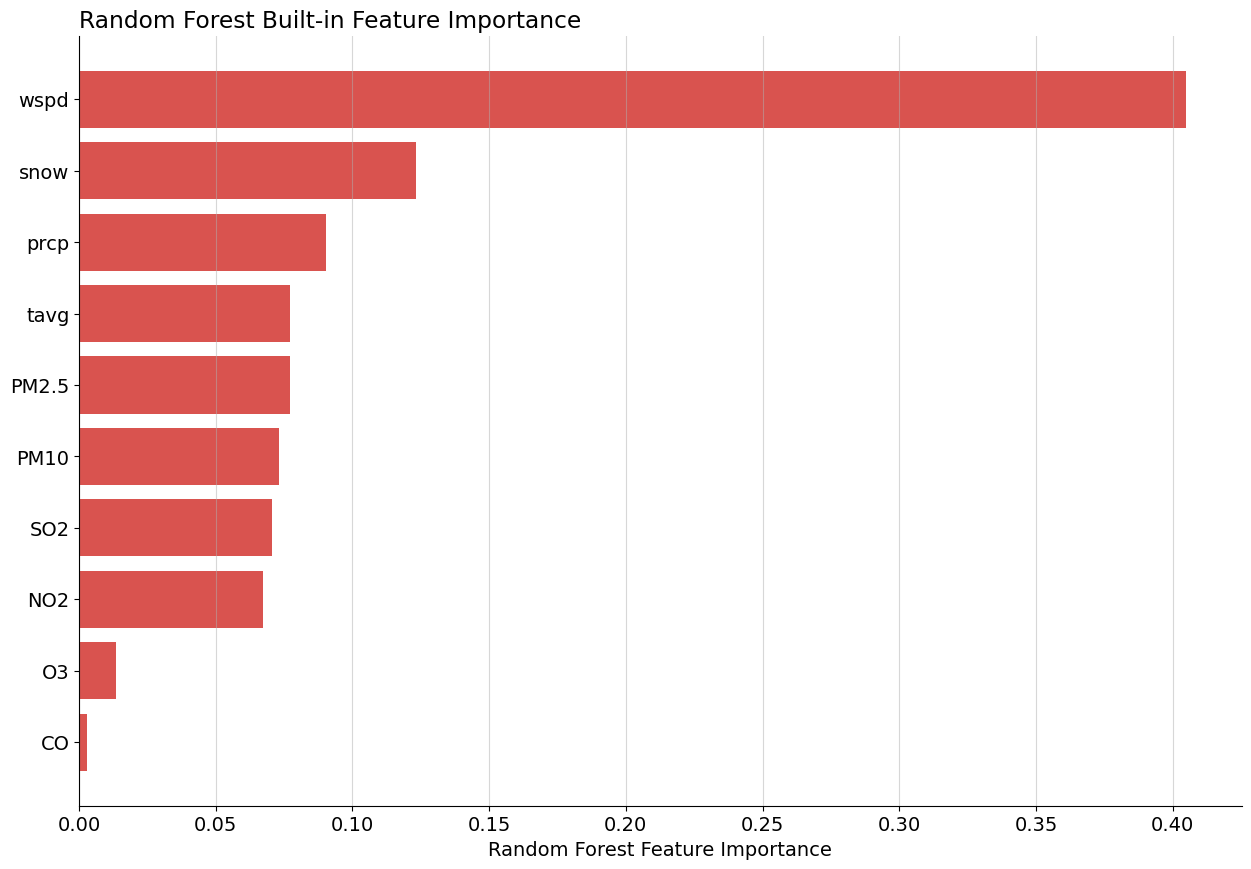

In [27]:
sorted_idx = rf.feature_importances_.argsort()


_, ax = plt.subplots(figsize=(15,10))
ax.barh(data_features, rf.feature_importances_[sorted_idx], color="#D9534F")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.grid(axis='x', alpha=.5, zorder=0)

plt.xlabel("Random Forest Feature Importance")

plt.title("Random Forest Built-in Feature Importance", loc="left")

plt.savefig("./plots/feature selection/random_forest_built_in_feature_importance.png")
plt.show()

- # Permutation Based Feature Importance

In [28]:
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(rf, X_test, Y_test)

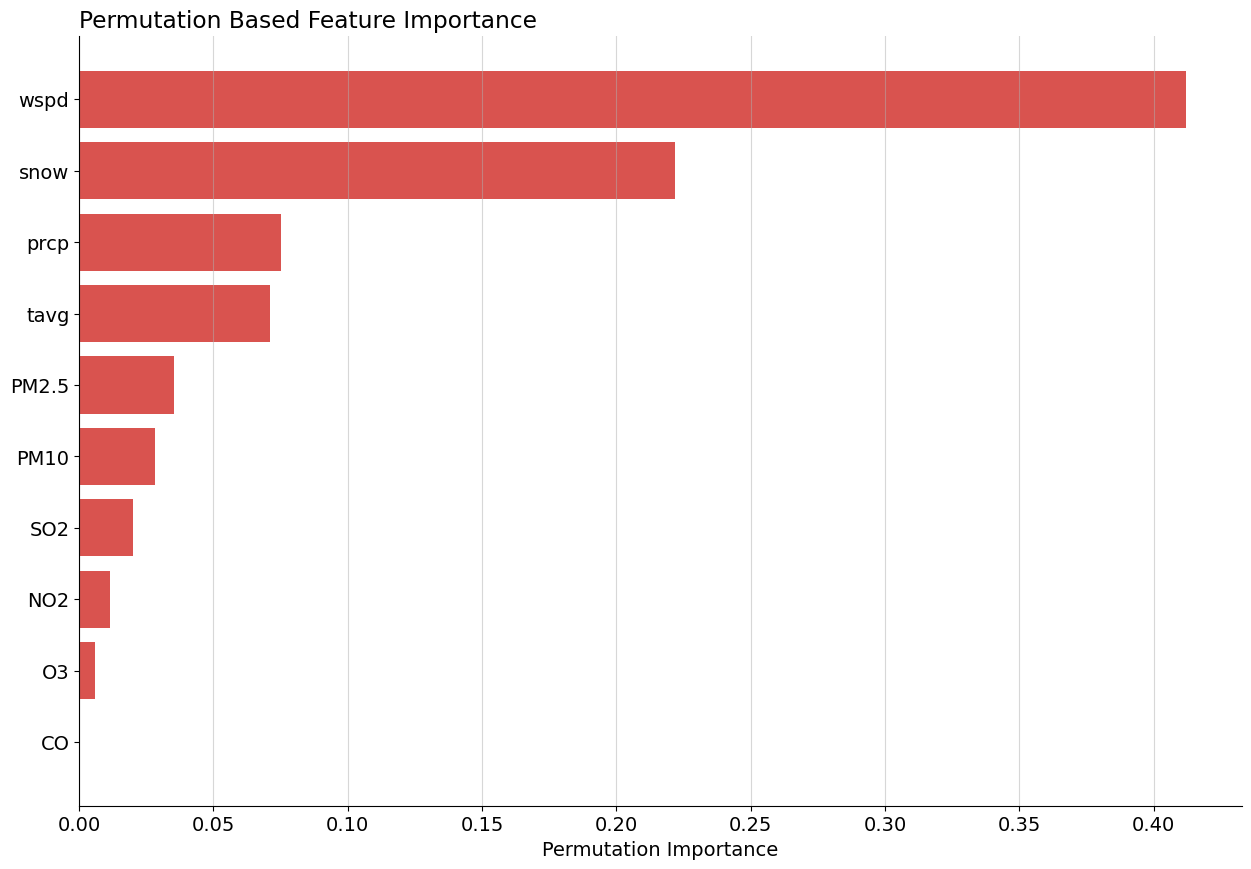

In [29]:
sorted_idx = perm_importance.importances_mean.argsort()

_, ax = plt.subplots(figsize=(15,10))
ax.barh(data_features, perm_importance.importances_mean[sorted_idx], color="#D9534F")

ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.grid(axis='x', alpha=.5, zorder=0)
plt.xlabel("Permutation Importance")

plt.title("Permutation Based Feature Importance", loc="left")

plt.savefig("./plots/feature selection/permutation_based_feature_importance.png")
plt.show()

- # Feature Importance Computed with SHAP Values

In [30]:
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

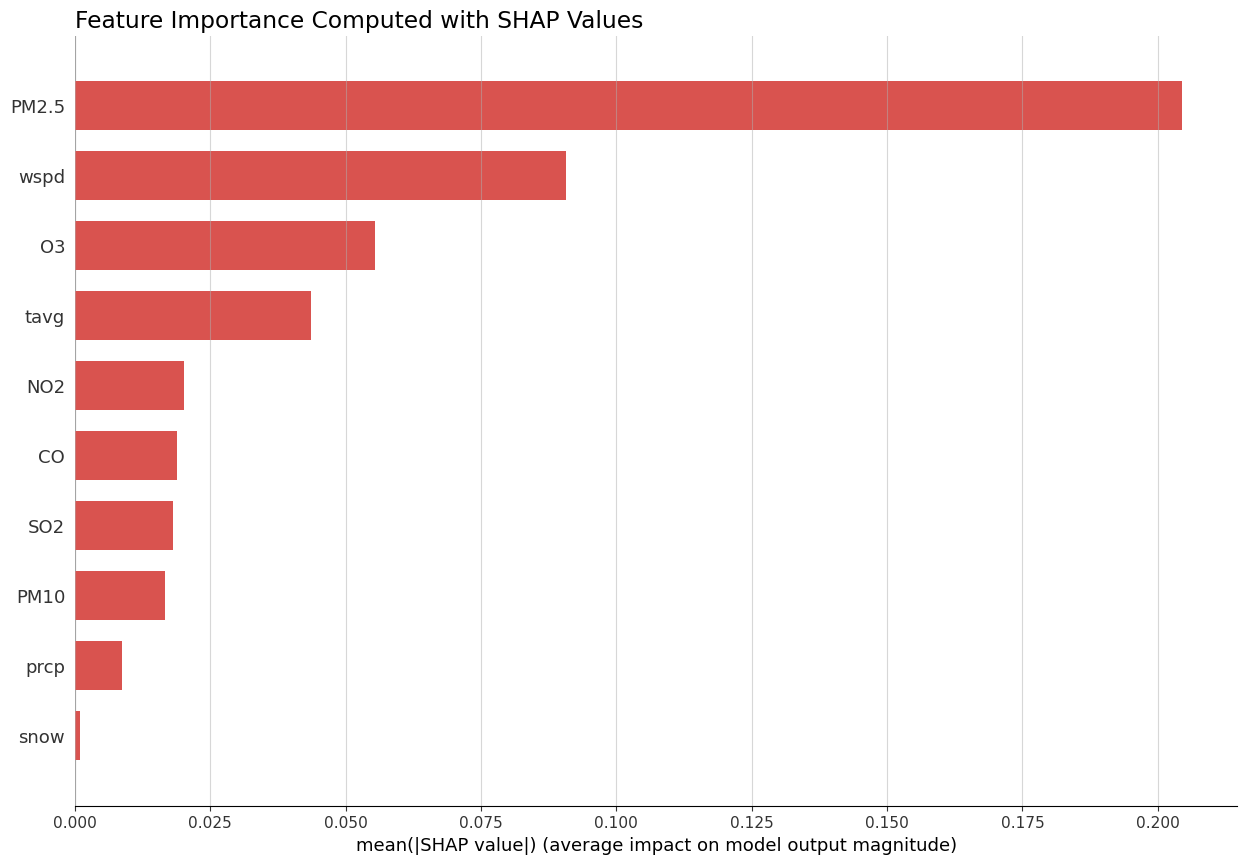

In [31]:
shap.summary_plot(shap_values, X_test, plot_type="bar", color="#D9534F", plot_size=(15,10), show=False)

plt.grid(axis='x', alpha=.5, zorder=0)
plt.title("Feature Importance Computed with SHAP Values", loc="left")
plt.savefig("./plots/feature selection/feature_importance_computed_with_SHAP_values.png")

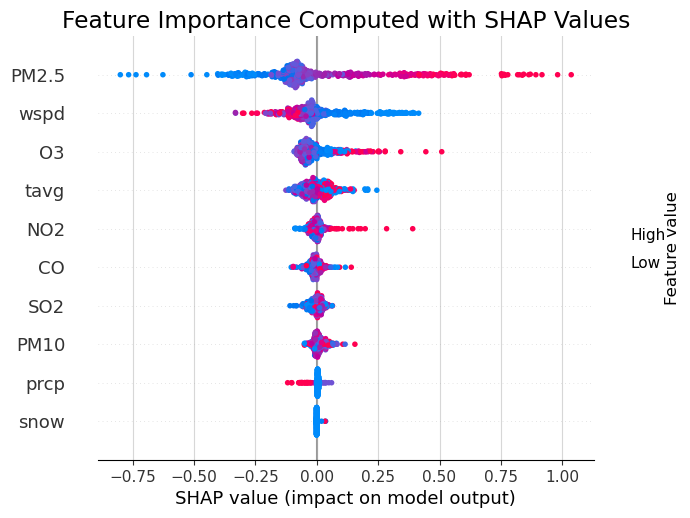

In [32]:
shap.summary_plot(shap_values, X_test, show=False)

plt.grid(axis='x', alpha=.5, zorder=0)
plt.title("Feature Importance Computed with SHAP Values", loc="center")
plt.savefig("./plots/feature selection/feature_importance_computed_with_SHAP_values2.png")

# Feature Elimination

In [33]:
features = set(X_train.columns.tolist()) - {"O3", "PM10"}
features = list(features)

X_train = X_train[features]
X_test = X_test[features]

X_train.head()

CO  tavg  wspd  SO2  NO2  prcp  PM2.5  snow
205   52    20     4   23   65     0     78     0
842   44    35    12    9   81     0     99     0
1323  22    11     6   13   46     0     50     0
1665  40    22     6   13   68     0     79     0
1445  23    10     8   14   65     0     58     0

# Plotting Confusion Matrix

In [34]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    # This function prints and plots the confusion matrix.
    # Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    
    plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

---

# Dictionary for Result of All Below Models

In [35]:
report = dict()

---

- # Naïve

In [36]:
class MyNaiveClassifier:
    def __init__(self):
        pass
    
    def fit(self, X, Y):
        if len(Y.shape)!=1:
            Y = np.squeeze(Y)
        Y = np.array(Y).flatten() 
        self.most_frequent_class = np.bincount(Y).argmax()
        
    def predict(self, X):
        n = X.shape[0]
        
        Y = np.ones(n) * self.most_frequent_class
        
        return Y

In [37]:
clf = MyNaiveClassifier()

clf.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

acc_mean = metrics.accuracy_score(Y_test, Y_pred)
acc_std = np.std(Y_pred== np.squeeze(Y_test))/np.sqrt(Y_pred.shape[0])

print("Accuracy of My Naive Classifier: {:.2f} ± {:.2f}".format(acc_mean, acc_std))
print("Confidence Interval with Confidence 95% is: [{:.2f} , {:.2f}]".format(acc_mean-1.96*acc_std, acc_mean+1.96*acc_std))



Accuracy of My Naive Classifier: 0.68 ± 0.02
Confidence Interval with Confidence 95% is: [0.64 , 0.72]


> ### Confiusion Matrix

Confusion matrix, without normalization
[[  0  25   0   0]
 [  0 339   0   0]
 [  0 123   0   0]
 [  0  10   0   0]]


<Figure size 800x800 with 0 Axes>

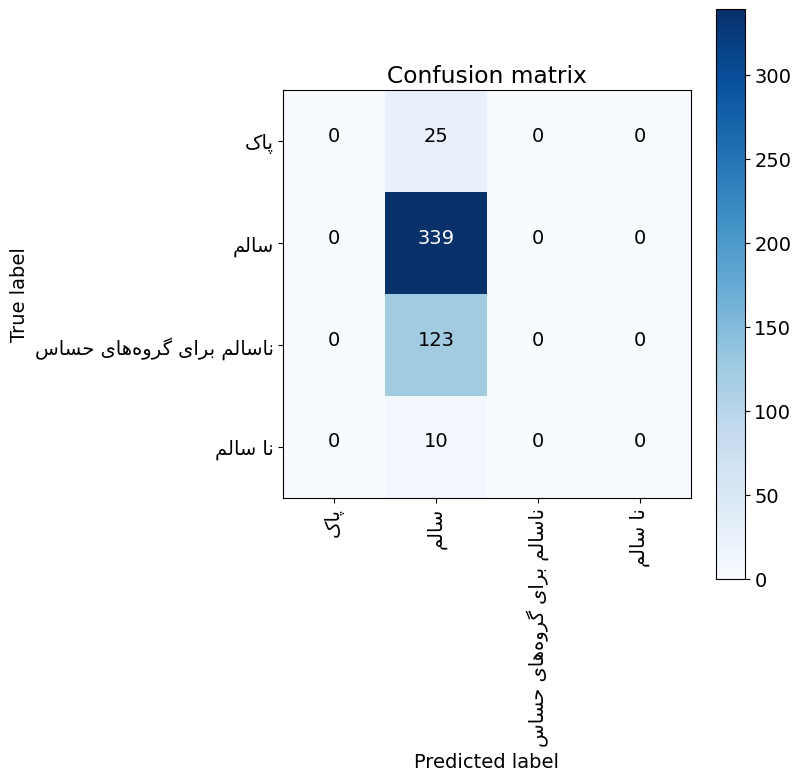

In [38]:
from sklearn.metrics import confusion_matrix
from bidi.algorithm import get_display
from arabic_reshaper import reshape

classes_id = [0, 1, 2, 3]

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

cnf_matrix = confusion_matrix(Y_test, Y_pred)

np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Confusion matrix')

plt.savefig("./plots/naive/naive_confusion_matrix.png")

plt.show()


> ### Different Metrics

In [47]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

def my_round(_list):
    return [float( "{:.2f}".format(l) ) for l in _list]

def performance_barchar(report, method, width=0.1):
    
    
    labels = ["precision", "recall", "f1-score", "accuracy"]
    
    d1 = [report[method]['1'][metric] for metric in labels[:-1]]
    d1 = my_round(d1)
    
    d2 = [report[method]['2'][metric] for metric in labels[:-1]]
    d2 = my_round(d2)
    
    d3 = [report[method]['3'][metric] for metric in labels[:-1]]
    d3 = my_round(d3)
    
    d4 = [report[method]['4'][metric] for metric in labels[:-1]]
    d4 = my_round(d4)
    
    acc = my_round([report[method][labels[-1]]])
    
    
    x = np.arange(len(labels[:-1])) 
    
    fig, ax = plt.subplots()
    set_size(10,5, ax=ax)
    
    rects1 = ax.bar(x - 3*width/2, d1, width, label=get_display(reshape(aqi_to_name(0))), zorder=5, color="#FFCE30")
    rects2 = ax.bar(x - width/2, d2, width, label=get_display(reshape(aqi_to_name(1))), zorder=5, color="#E83845")
    rects3 = ax.bar(x + width/2, d3, width, label=get_display(reshape(aqi_to_name(2))), zorder=5, color="#E389B9")
    rects4 = ax.bar(x + 3*width/2, d4, width, label=get_display(reshape(aqi_to_name(3))), zorder=5, color="#746AB0")
    rects5 = ax.bar([len(labels)-1], acc, width, label=get_display(reshape("دقت کل")), zorder=5, color="#288BA8")
    
    ax.set_ylabel('Scores')
    ax.set_title('Performance on {}'.format(method))
    ax.set_xticks(np.arange(len(labels)), labels)
    
    ax.set_ylim(0, 1.5)
    ax.set_yticks([ix for ix in np.arange(0,1.05,0.1)])
    ax.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

    ax.bar_label(rects1, padding=3, fontsize=9)
    ax.bar_label(rects2, padding=3, fontsize=9)
    ax.bar_label(rects3, padding=3, fontsize=9)
    ax.bar_label(rects4, padding=3, fontsize=9)
    ax.bar_label(rects5, padding=3, fontsize=9)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    fig.tight_layout()
    
    plt.grid(alpha=.5, zorder=0)
    
    

In [48]:
from sklearn.metrics import classification_report
report["naive"] = classification_report(Y_test, Y_pred, output_dict=True)
report["naive"]["str"] = classification_report(Y_test, Y_pred)

print (report["naive"]["str"])

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        25
           2       0.68      1.00      0.81       339
           3       0.00      0.00      0.00       123
           4       0.00      0.00      0.00        10

    accuracy                           0.68       497
   macro avg       0.17      0.25      0.20       497
weighted avg       0.47      0.68      0.55       497



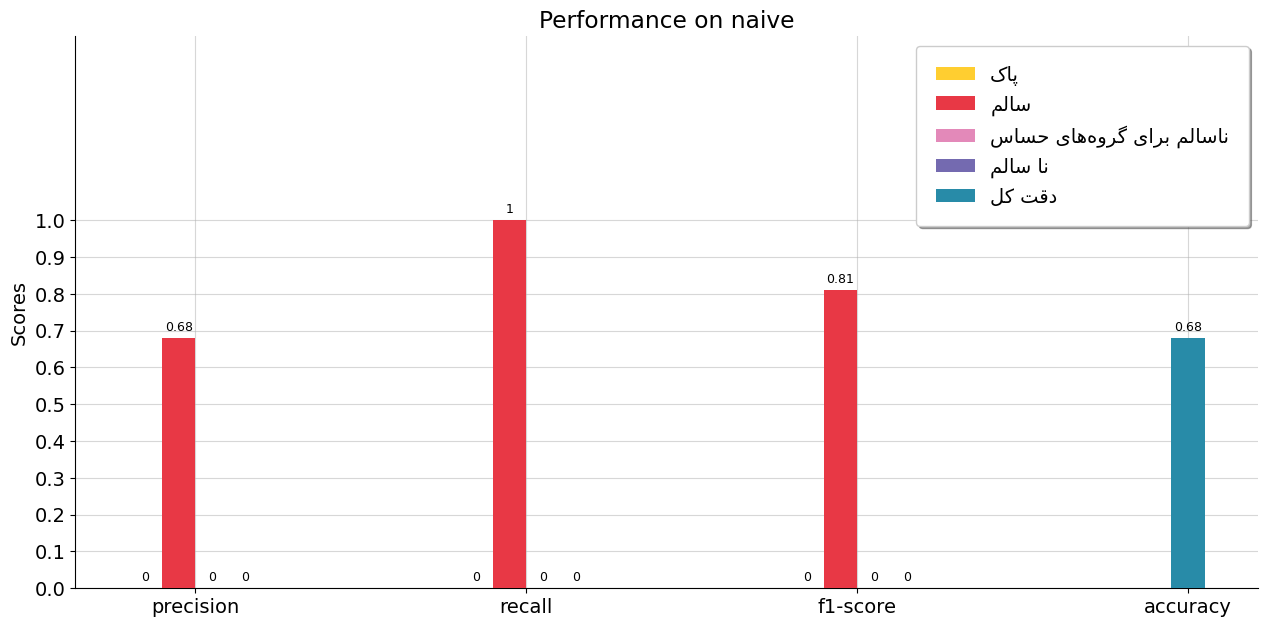

In [49]:
performance_barchar(report, "naive")

plt.savefig("./plots/naive/performance_on_naive.png")
plt.show()

---

- # Class Weights:

In [50]:
weights =  Y_train.value_counts().to_dict() 
for key in  weights:
    weights[key] = 1 - weights[key] / Y_train.shape[0]

---

- # KNN

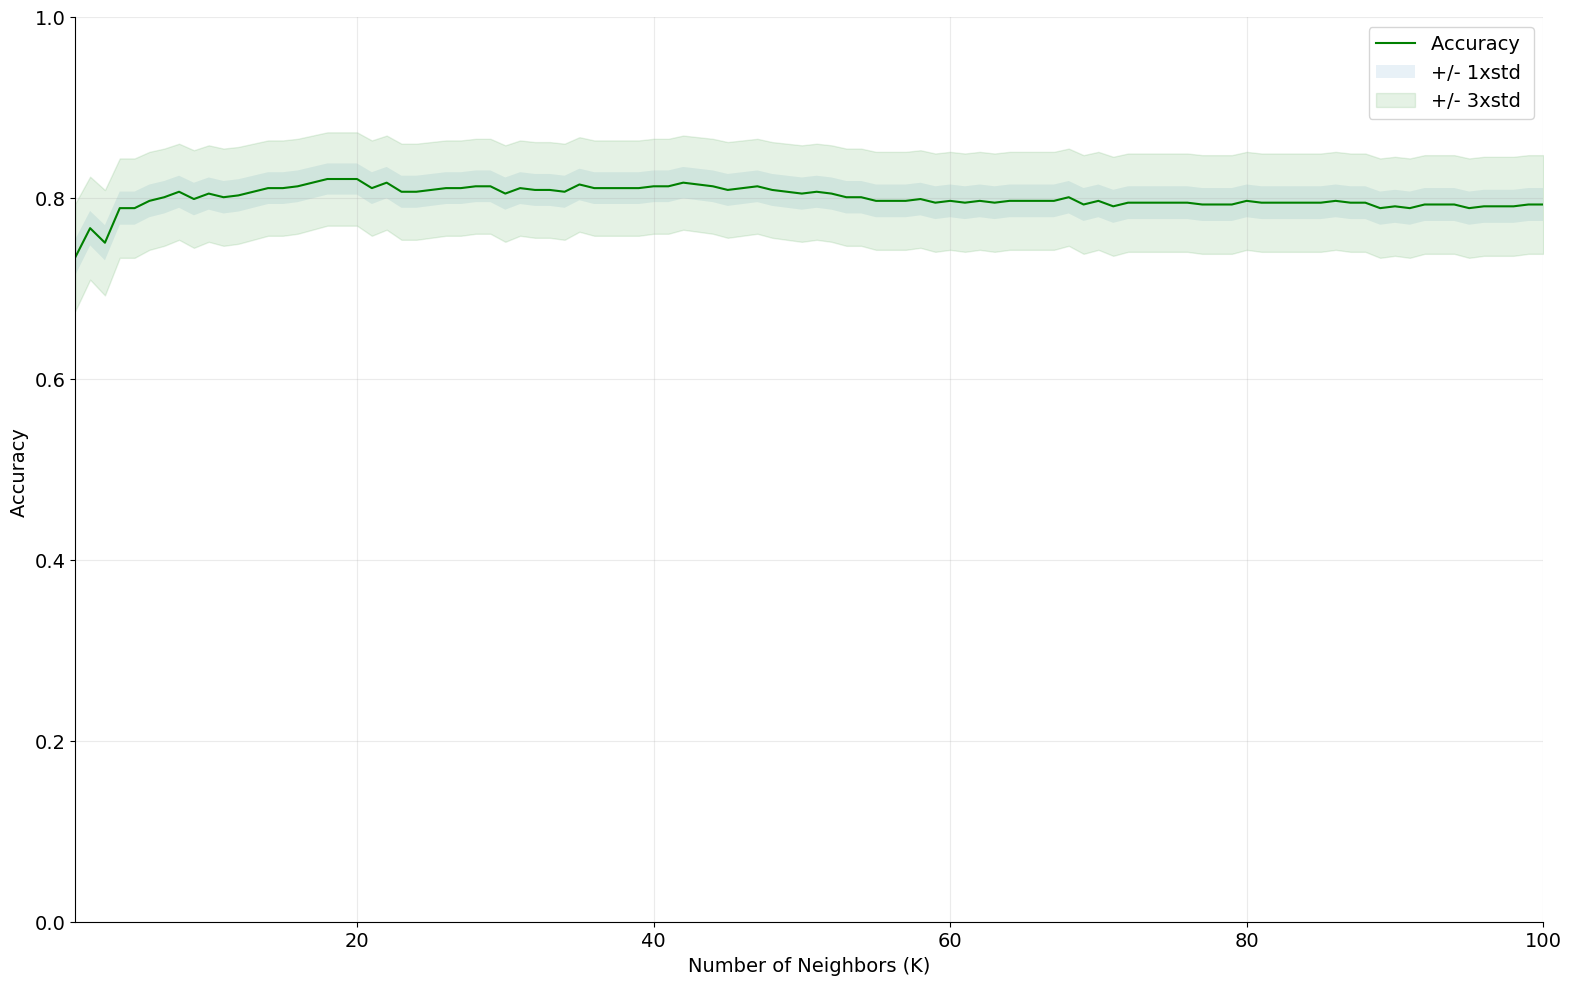

The best accuracy was 82.09% with k = 18


In [63]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

def KNN(X_train, Y_train, X_test, Y_test, k):
    acc_mean, acc_std = None, None
    
    clf = KNeighborsClassifier(n_neighbors = k,).fit(X_train,Y_train)
    
    yhat = clf.predict(X_test)
    
    acc_mean = metrics.accuracy_score(Y_test, yhat)
    acc_std = np.std(yhat== np.squeeze(Y_test))/np.sqrt(yhat.shape[0])
    
    return clf, acc_mean, acc_std


ks = range(1, 101)
accs_mean = np.zeros(len(ks))
accs_std = np.zeros(len(ks))

for ix, (k) in enumerate(ks):
    _, acc_mean, acc_std = KNN(X_train, Y_train, X_test, Y_test, k)
    
    accs_mean[ix] = acc_mean
    accs_std[ix] = acc_std
    

plt.figure(figsize=(16,10))
plt.plot( ks, accs_mean,'g')
plt.fill_between( ks, accs_mean - 1 * accs_std, accs_mean + 1 * accs_std, alpha=0.10)
plt.fill_between( ks, accs_mean - 3 * accs_std, accs_mean + 3 * accs_std, alpha=0.10,color="green")
plt.legend(('Accuracy ', '+/- 1xstd','+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.ylim([0,1])
plt.xlim([min(ks), max(ks)])
plt.grid("-.", alpha=0.25)

ax = plt.gca()
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)

plt.savefig("./plots/knn/knn_accuracy.png")
plt.show()

print("The best accuracy was {:.2f}% with k = {}".format( accs_mean.max()*100, accs_mean.argmax()+1))
    

> ### KNN with k=18

In [64]:
knn_clf, knn_acc_mean, knn_acc_std = KNN(X_train, Y_train, X_test, Y_test, k=18)
Y_pred = knn_clf.predict(X_test)

print("The accuracy of the model is: {:.2f}%".format( knn_acc_mean*100 ))

The accuracy of the model is: 82.09%


> ### Confusion Matrix for KNN with K=18:

Confusion matrix, without normalization
[[  5  20   0   0]
 [  2 322  15   0]
 [  0  43  80   0]
 [  0   2   7   1]]


<Figure size 800x800 with 0 Axes>

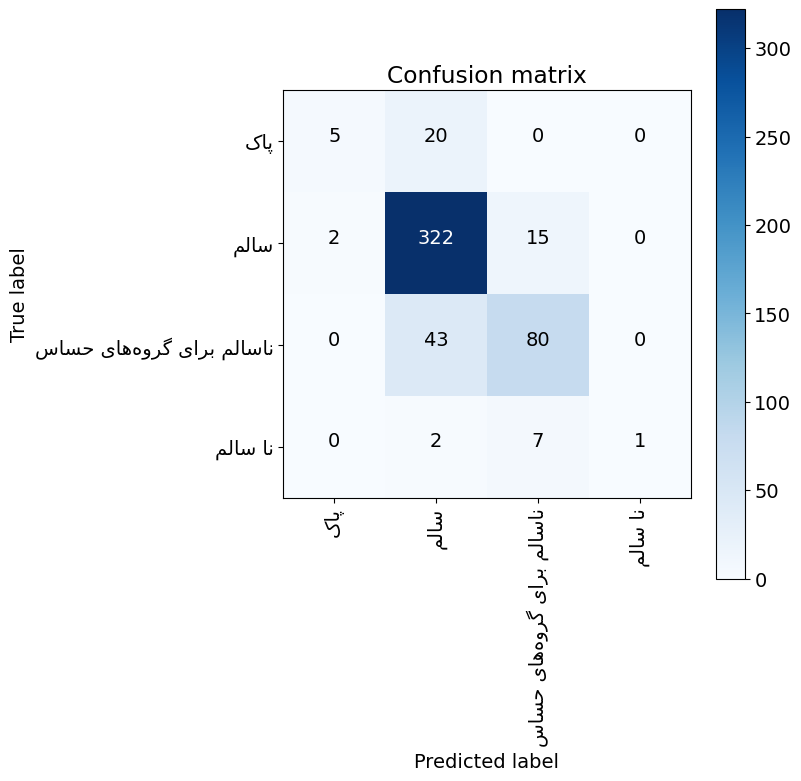

In [65]:
from sklearn.metrics import confusion_matrix
from bidi.algorithm import get_display
from arabic_reshaper import reshape

classes_id = [0, 1, 2, 3]

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

cnf_matrix = confusion_matrix(Y_test, Y_pred)

np.set_printoptions(precision=2)

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Confusion matrix')
plt.savefig("./plots/knn/knn_confusion_matrix.png")
plt.show()


> ### Different Metrics

In [66]:
from sklearn.metrics import classification_report
report["knn"] = classification_report(Y_test, Y_pred, output_dict=True)
report["knn"]["str"] = classification_report(Y_test, Y_pred)

print (report["knn"]["str"])

              precision    recall  f1-score   support

           1       0.71      0.20      0.31        25
           2       0.83      0.95      0.89       339
           3       0.78      0.65      0.71       123
           4       1.00      0.10      0.18        10

    accuracy                           0.82       497
   macro avg       0.83      0.48      0.52       497
weighted avg       0.82      0.82      0.80       497



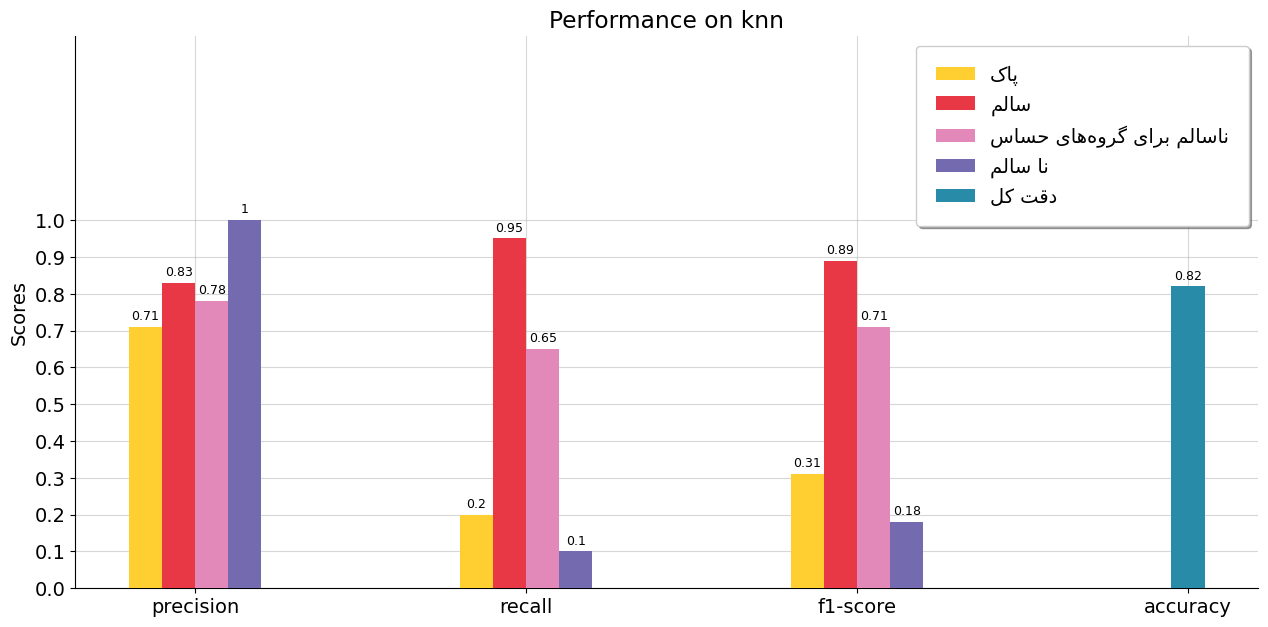

In [67]:
performance_barchar(report, "knn")

plt.savefig("./plots/knn/performance_on_knn.png")
plt.show()

> ### Cross-Validation

In [68]:
_X = pd.concat([X_train, X_test])
_Y = pd.concat([Y_train, Y_test])

In [69]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing

clf = make_pipeline(preprocessing.StandardScaler(), KNeighborsClassifier(n_neighbors=21))
# clf = KNeighborsClassifier(n_neighbors=18)

accs = cross_validate(clf, _X, _Y, cv=32, scoring=["accuracy"])["test_accuracy"]

mean = np.mean(accs)
std = np.std(accs) / np.sqrt(np.shape(accs)[0])

print("Confidence interval of accuracy of KNN Classifier with k = 18 with confidence level 95% is: [{:.2f} , {:.2f}]".format(mean-1.96*std, mean+1.96*std))



Confidence interval of accuracy of KNN Classifier with k = 18 with confidence level 95% is: [0.77 , 0.80]


----

- # Decision Tree

In [70]:
from sklearn.tree import DecisionTreeClassifier

depths = range(1,51)
accs = list()


for depth in depths:
    clf = DecisionTreeClassifier(criterion="entropy", max_depth=depth, class_weight=weights)
    
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)
    
    accs.append( (depth, accuracy_score(Y_test, Y_pred)) )
    
best_depth = max(accs[1:], key=lambda x: x[1])[0]
best_acc = max(accs[1:], key=lambda x: x[1])[1]

print("The best accuracy is for Wieghted Decision Tree was {:.2f}% with depth = {}.".format(best_acc*100, best_depth))


The best accuracy is for Wieghted Decision Tree was 78.07% with depth = 6.


> ### Decision Tree with Depth=6

In [71]:
dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=6)
dt_clf.fit(X_train, Y_train)
Y_pred = dt_clf.predict(X_test)

dt_clf_w = DecisionTreeClassifier(criterion="entropy", max_depth=6, class_weight=weights)
dt_clf_w.fit(X_train, Y_train)
Y_pred_w = dt_clf_w.predict(X_test)


dt_acc = accuracy_score(Y_test, Y_pred)
dt_acc_w = accuracy_score(Y_test, Y_pred_w)

print("The accuracy of the non-weighted model is: {:.2f}%".format( dt_acc*100 ))
print("The accuracy of weigthed model is: {:.2f}%".format( dt_acc_w*100 ))

The accuracy of the non-weighted model is: 78.87%
The accuracy of weigthed model is: 77.67%


> ### Confusion Matrix for Decision Tree with Depth=6:

Confusion matrix, without normalization
[[  3  22   0   0]
 [  1 329   9   0]
 [  0  62  59   2]
 [  0   2   7   1]]


<Figure size 800x800 with 0 Axes>

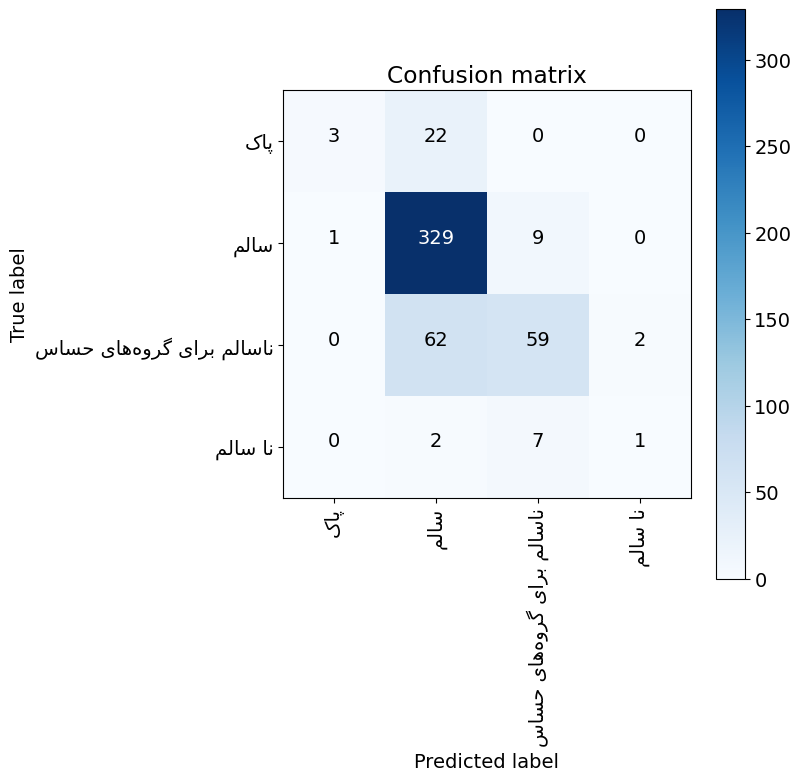

In [72]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Confusion matrix')

plt.savefig("./plots/decision tree/dt_6_confusion_matrix.png")
plt.show()

Confusion matrix, without normalization
[[ 13  12   0   0]
 [ 18 280  41   0]
 [  0  30  89   4]
 [  0   1   5   4]]


<Figure size 800x800 with 0 Axes>

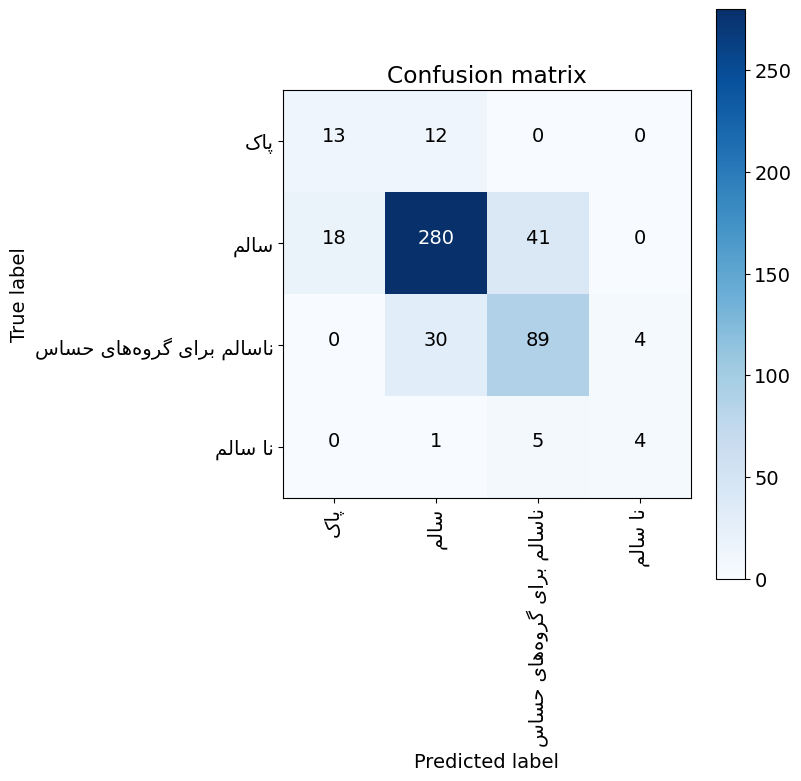

In [73]:
cnf_matrix = confusion_matrix(Y_test, Y_pred_w)
np.set_printoptions(precision=2)

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Confusion matrix')

plt.savefig("./plots/decision tree/dt_w_6_confusion_matrix.png")
plt.show()

> ### Different Metrics

In [74]:
report["dt_w"] = classification_report(Y_test, Y_pred_w, output_dict=True)
report["dt_w"]["str"] = classification_report(Y_test, Y_pred_w)

print (classification_report(Y_test, Y_pred_w))

              precision    recall  f1-score   support

           1       0.42      0.52      0.46        25
           2       0.87      0.83      0.85       339
           3       0.66      0.72      0.69       123
           4       0.50      0.40      0.44        10

    accuracy                           0.78       497
   macro avg       0.61      0.62      0.61       497
weighted avg       0.79      0.78      0.78       497



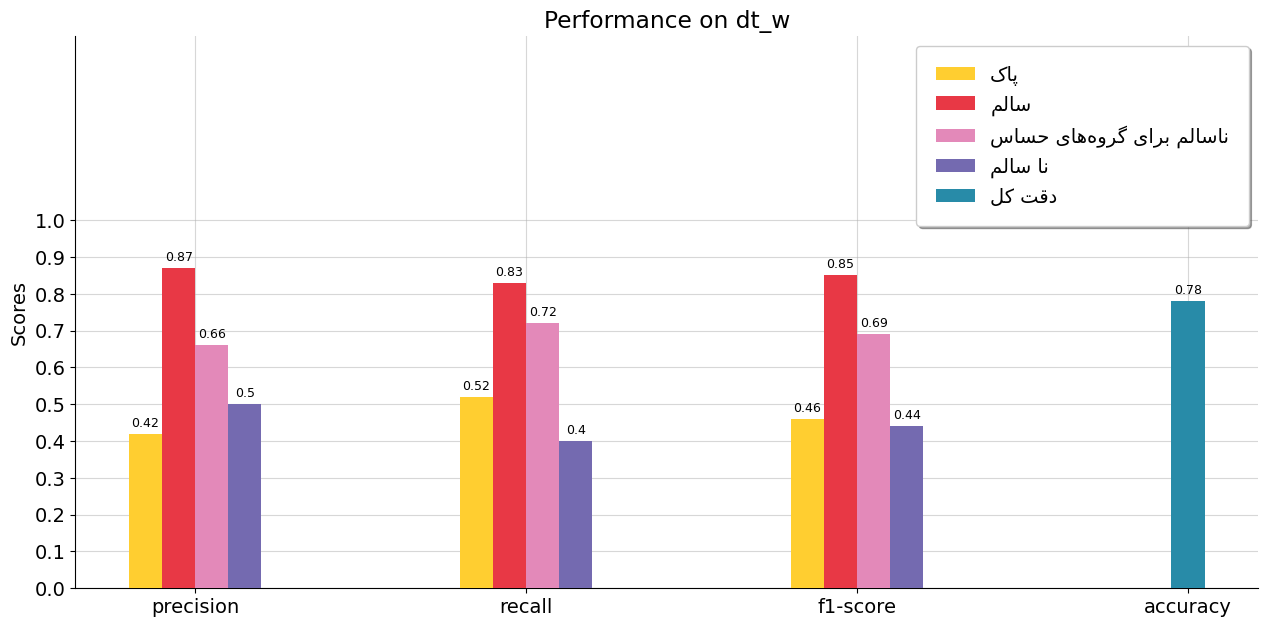

In [75]:
performance_barchar(report, "dt_w")

plt.savefig("./plots/decision tree/performance_on_dt_w.png")
plt.show()

In [76]:
report["dt"] = classification_report(Y_test, Y_pred, output_dict=True)
report["dt"]["str"] = classification_report(Y_test, Y_pred)

print (classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           1       0.75      0.12      0.21        25
           2       0.79      0.97      0.87       339
           3       0.79      0.48      0.60       123
           4       0.33      0.10      0.15        10

    accuracy                           0.79       497
   macro avg       0.67      0.42      0.46       497
weighted avg       0.78      0.79      0.76       497



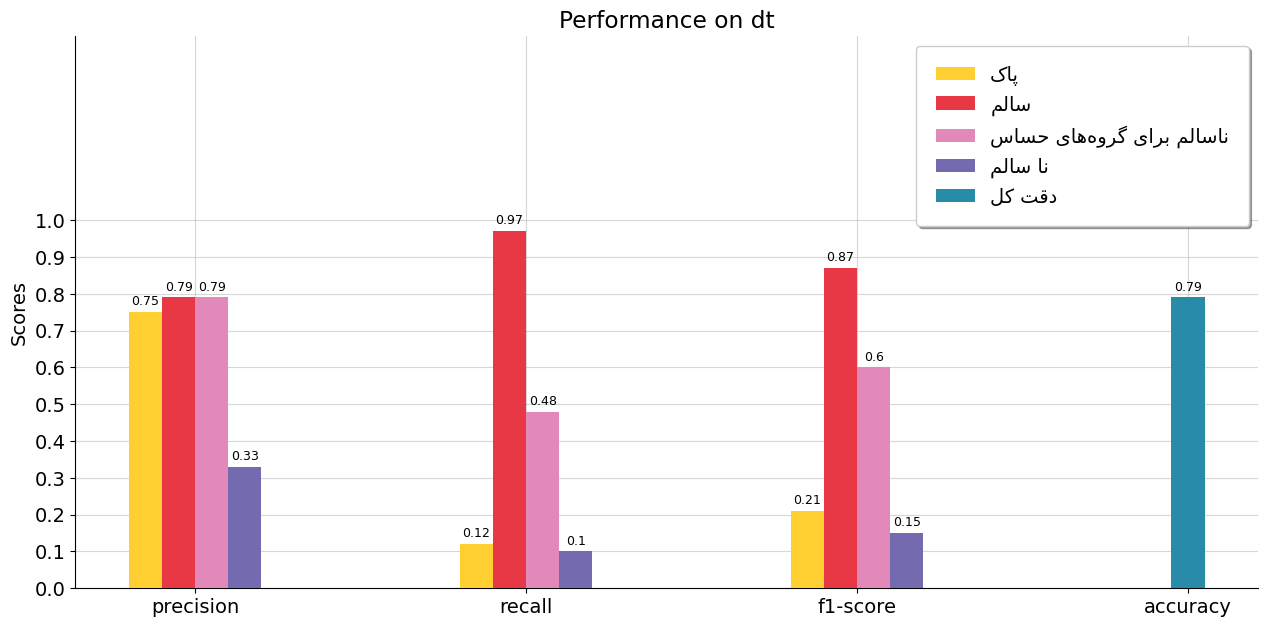

In [77]:
performance_barchar(report, "dt")

plt.savefig("./plots/decision tree/performance_on_dt.png")
plt.show()

> ### Cross-Validation

In [78]:
dt_clf = make_pipeline(preprocessing.StandardScaler(), DecisionTreeClassifier(criterion="entropy", max_depth=6).fit(X_train, Y_train))
# dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=6).fit(X_train, Y_train)

dt_clf_w = make_pipeline(preprocessing.StandardScaler(), DecisionTreeClassifier(criterion="entropy", max_depth=6, class_weight=weights).fit(X_train, Y_train))
# dt_clf_w = DecisionTreeClassifier(criterion="entropy", max_depth=6).fit(X_train, Y_train)


accs = cross_validate(dt_clf, X, Y, cv=32, scoring=["accuracy"])["test_accuracy"]

mean = np.mean(accs)
std = np.std(accs) / np.sqrt(np.shape(accs)[0])

accs_w = cross_validate(dt_clf_w, X, Y, cv=32, scoring=["accuracy"])["test_accuracy"]

mean_w = np.mean(accs_w)
std_w = np.std(accs_w) / np.sqrt(np.shape(accs_w)[0])

print("Confidence interval of accuracy of Model (with depth=4 and confidence level 95%) is: \n")

print("Non-Weighted Decision Tree: [{:.2f} , {:.2f}]".format(mean-1.96*std, mean+1.96*std))
print("Weighted Decision Tree: [{:.2f} , {:.2f}]".format(mean_w-1.96*std_w, mean_w+1.96*std_w))




Confidence interval of accuracy of Model (with depth=4 and confidence level 95%) is: 

Non-Weighted Decision Tree: [0.72 , 0.77]
Weighted Decision Tree: [0.60 , 0.70]


> ### Visualizing the Tree

Weighted Model:


<Figure size 1000x1000 with 0 Axes>

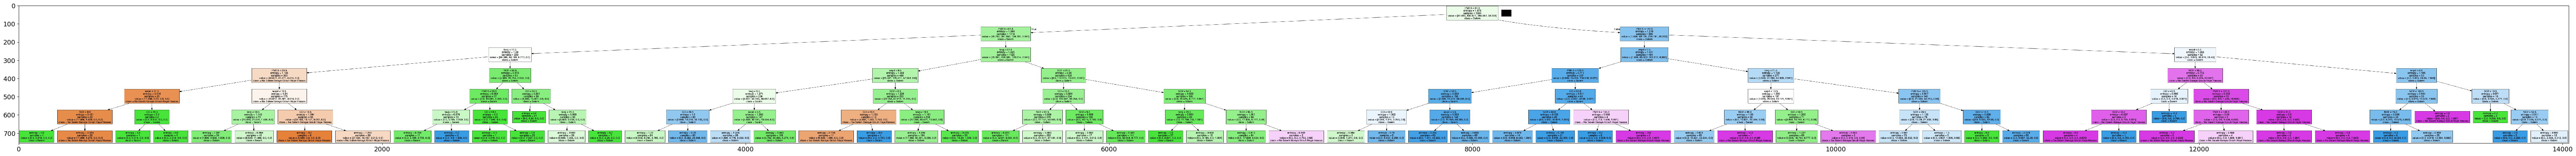

In [80]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

dt_clf_w = DecisionTreeClassifier(criterion="entropy", max_depth=6, class_weight=weights).fit(X_train, Y_train)

filename = "./plots/decision tree/tehran_air_w.png"

dot_data = StringIO()

featureNames = [col for col in X_train.columns]

plt.figure(figsize=(10,10))
out=tree.export_graphviz(
                            dt_clf_w,
                            feature_names=featureNames, 
                            out_file=dot_data, 
                            class_names= Y_train.apply(lambda x: aqi_to_name(x, fa=False)), 
                            filled=True,  
                            special_characters=True,
                            rotate=False)  


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)

img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
print("Weighted Model:")
plt.imshow(img,interpolation='nearest')

Non-Weighted Model:


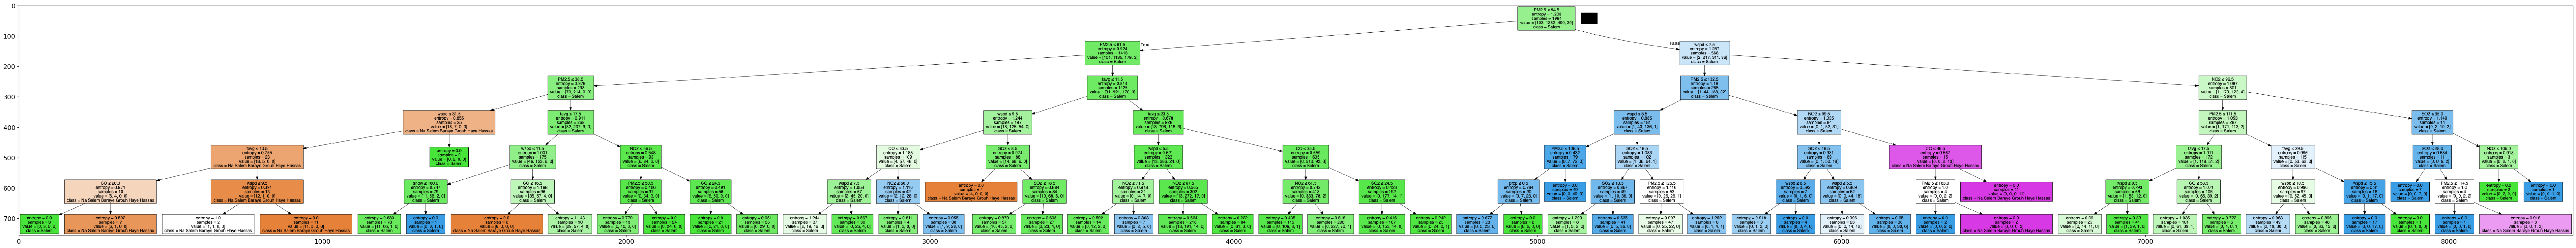

In [81]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree

dt_clf = DecisionTreeClassifier(criterion="entropy", max_depth=6).fit(X_train, Y_train)

filename = "./plots/decision tree/tehran_air.png"

dot_data = StringIO()

featureNames = [col for col in X_train.columns]

out=tree.export_graphviz(
                            dt_clf,
                            feature_names=featureNames, 
                            out_file=dot_data, 
                            class_names= Y_train.apply(lambda x: aqi_to_name(x, fa=False)), 
                            filled=True,  
                            special_characters=True,
                            rotate=False)  


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  

graph.write_png(filename)

img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
print("Non-Weighted Model:")
plt.imshow(img,interpolation='nearest')

# Plotting Slope Chart

In [83]:
def slope_chart(report, method1, method2, metric, classes_id, figsize=(5,10), title=""):
    labels = [aqi_to_name(ix) for ix in classes_id]
    labels = [get_display(reshape(label)) for label in labels]
    
    fig = plt.figure(figsize=figsize)
    
    ax = fig.add_subplot(111)
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    
    colors = ["#FFCE30","#E83845", "#E389B9","#746AB0","#288BA8"]
    
    for _class,color in zip(classes_id,colors):
        xs = [1,2]
        y1 = report[method1][str(_class)][metric]
        y2 = report[method2][str(_class)][metric]
        
        ax.plot(xs, [y1,y2], label=labels[_class-1], marker='.', color=color)
    
    
    ax.grid(b = True, color ='grey',
        linestyle ='-.', linewidth = 0.5,
        alpha = 0.2)
    plt.xticks([1,2],[get_display(reshape("بدون وزن")), get_display(reshape("وزن دار"))])    
    plt.yticks([ix for ix in np.arange(0,1.01,0.05) ])
    plt.ylim(0,1)
    plt.xlim(0.99,2.01)
    plt.title(title)
    plt.legend(loc="upper right", prop={'size': 8})
        

> ### Weighted Vs. Not-Weighted

>> ### Precision

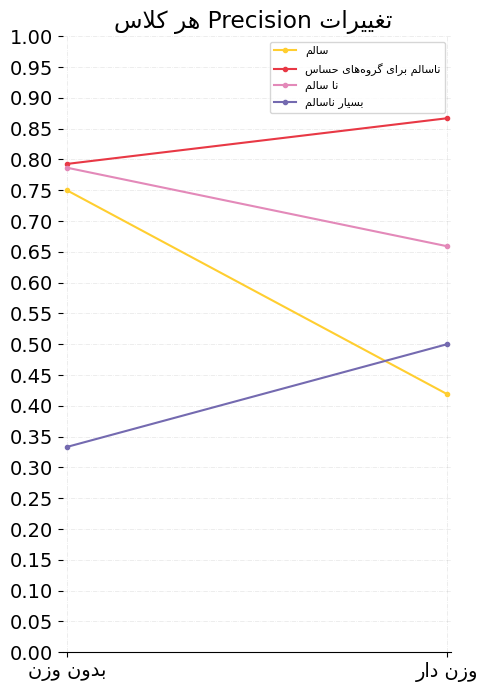

In [85]:
title = get_display(reshape(" تغییرات Precision هر کلاس"))

slope_chart(report, "dt", "dt_w", "precision", [1, 2, 3, 4], figsize=(5,8), title=title)

plt.savefig("./plots/decision tree/dt_slope_grap_precision.png")
plt.show()

>> ### Recall

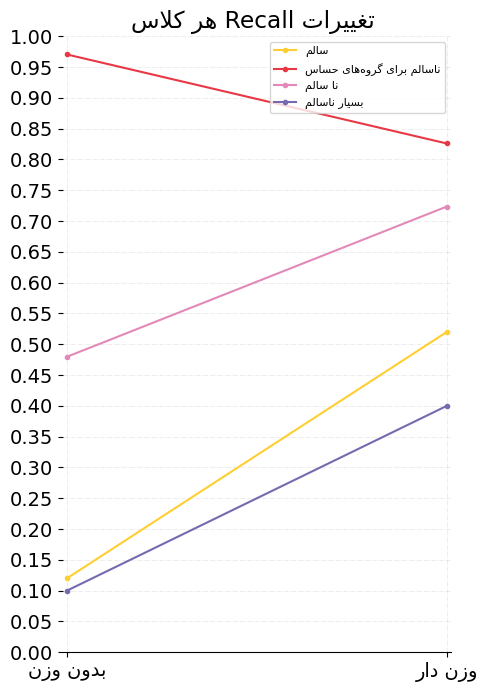

In [86]:
title = get_display(reshape(" تغییرات Recall هر کلاس"))

slope_chart(report, "dt", "dt_w", "recall", [1, 2, 3, 4], figsize=(5,8), title=title)
plt.savefig("./plots/decision tree/dt_slope_grap_recall.png")
plt.show()

>> ### F1-Score

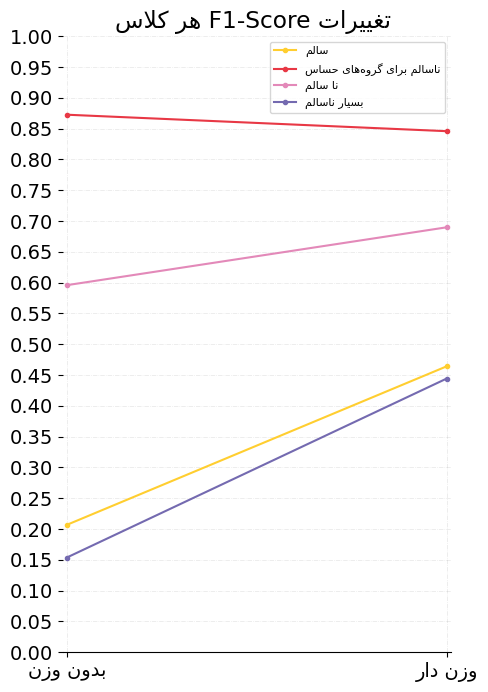

In [87]:
title = get_display(reshape(" تغییرات F1-Score هر کلاس"))

slope_chart(report, "dt", "dt_w", "f1-score", [1, 2, 3, 4], figsize=(5,8), title=title)
plt.savefig("./plots/decision tree/dt_slope_grap_f1.png")
plt.show()

----

- # SVM

In [88]:
from sklearn import svm

kernels = ["linear", "poly", "rbf", "sigmoid"]

accs = [None] * len(kernels)

for ix, (kernel) in enumerate(kernels):

    clf = svm.SVC(kernel=kernel, class_weight=weights)
    clf.fit(X_train, Y_train)

    Y_pred = clf.predict(X_test)

    accs[ix] = (kernel, accuracy_score(Y_test, Y_pred))
    
best_kernel = max(accs, key=lambda x: x[1])[0]
best_acc = max(accs, key=lambda x: x[1])[1]

print("The best accuracy for SVM is {:.2f}% with '{}' kernel".format(best_acc*100, best_kernel))

The best accuracy for SVM is 79.68% with 'poly' kernel


> ### SVM with 'Poly' Kernel

In [89]:
svm_clf = svm.SVC(kernel=best_kernel)
svm_clf.fit(X_train, Y_train)

svm_clf_w = svm.SVC(kernel=best_kernel, class_weight=weights)
svm_clf_w.fit(X_train, Y_train)

Y_pred = svm_clf.predict(X_test)
Y_pred_w = svm_clf_w.predict(X_test)

svm_acc = accuracy_score(Y_test, Y_pred)
svm_acc_w = accuracy_score(Y_test, Y_pred_w)

print("The accuracy of the model is: {:.2f}%".format( svm_acc*100 ))
print("The accuracy of the weighted model is: {:.2f}%".format( svm_acc_w*100 ))

The accuracy of the model is: 79.07%
The accuracy of the weighted model is: 79.68%


> ### Confusion Matrix for SVM with 'Poly' Kernel:

>> ### Not Weighted:

Confusion matrix, without normalization
[[  0  25   0   0]
 [  0 331   8   0]
 [  0  61  62   0]
 [  0   2   8   0]]


<Figure size 800x800 with 0 Axes>

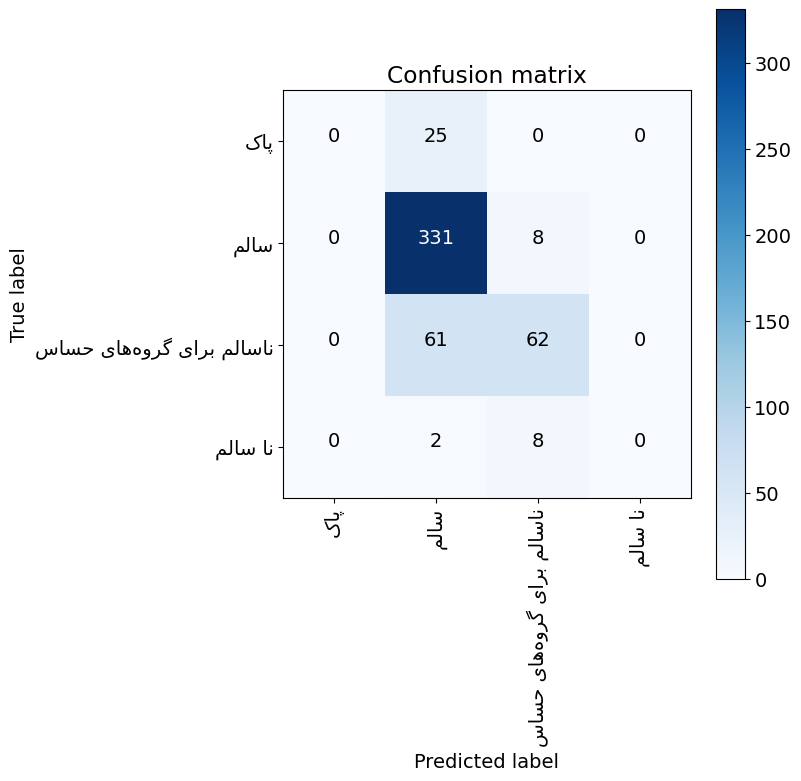

In [90]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Confusion matrix')
plt.savefig("./plots/svm/svm_confusion_matrix.png")
plt.show()

>> ### Weighted:

Confusion matrix, without normalization
[[  0  25   0   0]
 [  0 312  27   0]
 [  0  41  81   1]
 [  0   1   6   3]]


<Figure size 800x800 with 0 Axes>

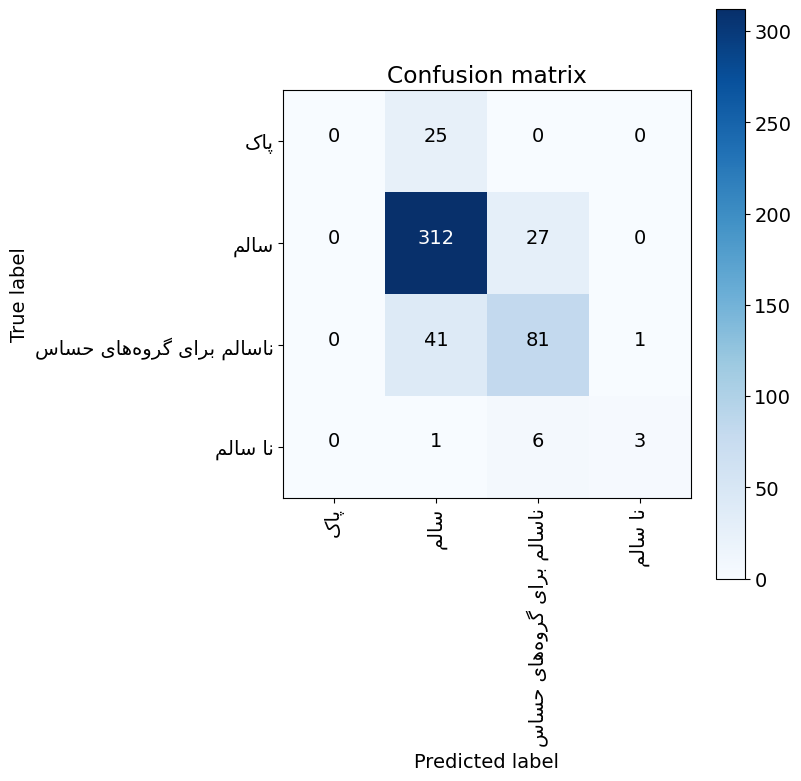

In [91]:
cnf_matrix = confusion_matrix(Y_test, Y_pred_w)
np.set_printoptions(precision=2)

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Confusion matrix')
plt.savefig("./plots/svm/svm_m_confusion_matrix.png")
plt.show()

> ### Different Metrics

In [92]:
report["svm_w"] = classification_report(Y_test, Y_pred_w, output_dict=True)
report["svm_w"]["str"] = classification_report(Y_test, Y_pred_w)

print (report["svm_w"]["str"])

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        25
           2       0.82      0.92      0.87       339
           3       0.71      0.66      0.68       123
           4       0.75      0.30      0.43        10

    accuracy                           0.80       497
   macro avg       0.57      0.47      0.50       497
weighted avg       0.75      0.80      0.77       497



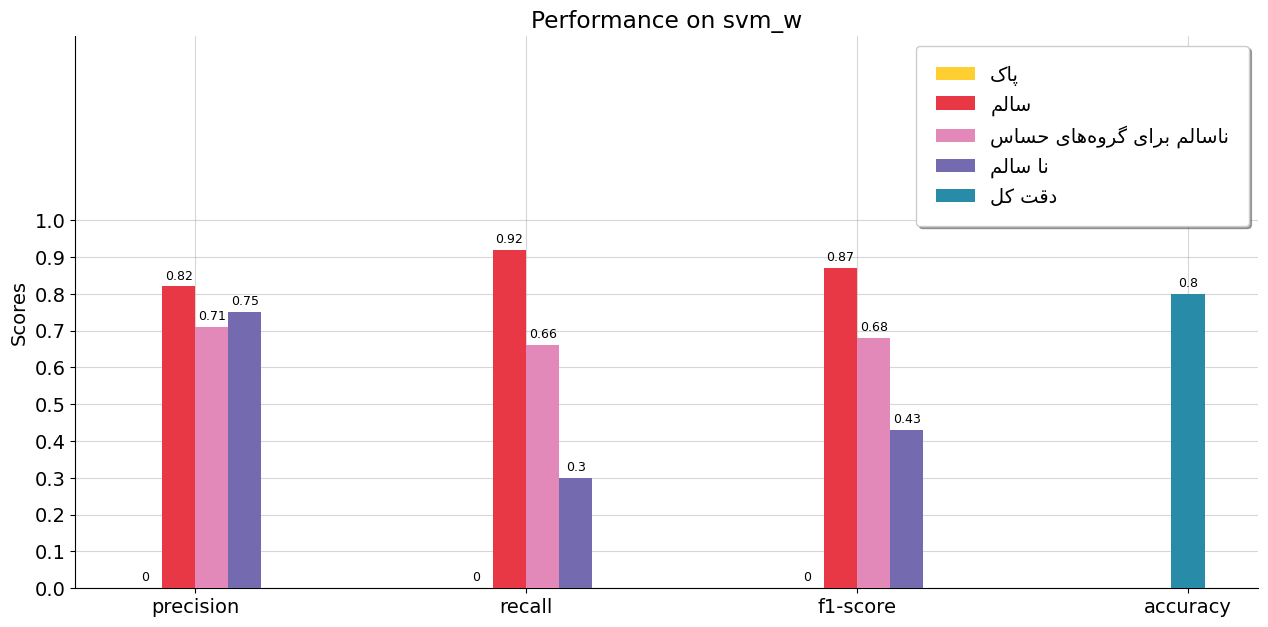

In [93]:
performance_barchar(report, "svm_w")

plt.savefig("./plots/svm/performance_on_svm_w.png")
plt.show()

In [94]:
report["svm"] = classification_report(Y_test, Y_pred, output_dict=True)
report["svm"]["str"] = classification_report(Y_test, Y_pred)

print (report["svm"]["str"])

              precision    recall  f1-score   support

           1       0.00      0.00      0.00        25
           2       0.79      0.98      0.87       339
           3       0.79      0.50      0.62       123
           4       0.00      0.00      0.00        10

    accuracy                           0.79       497
   macro avg       0.40      0.37      0.37       497
weighted avg       0.74      0.79      0.75       497



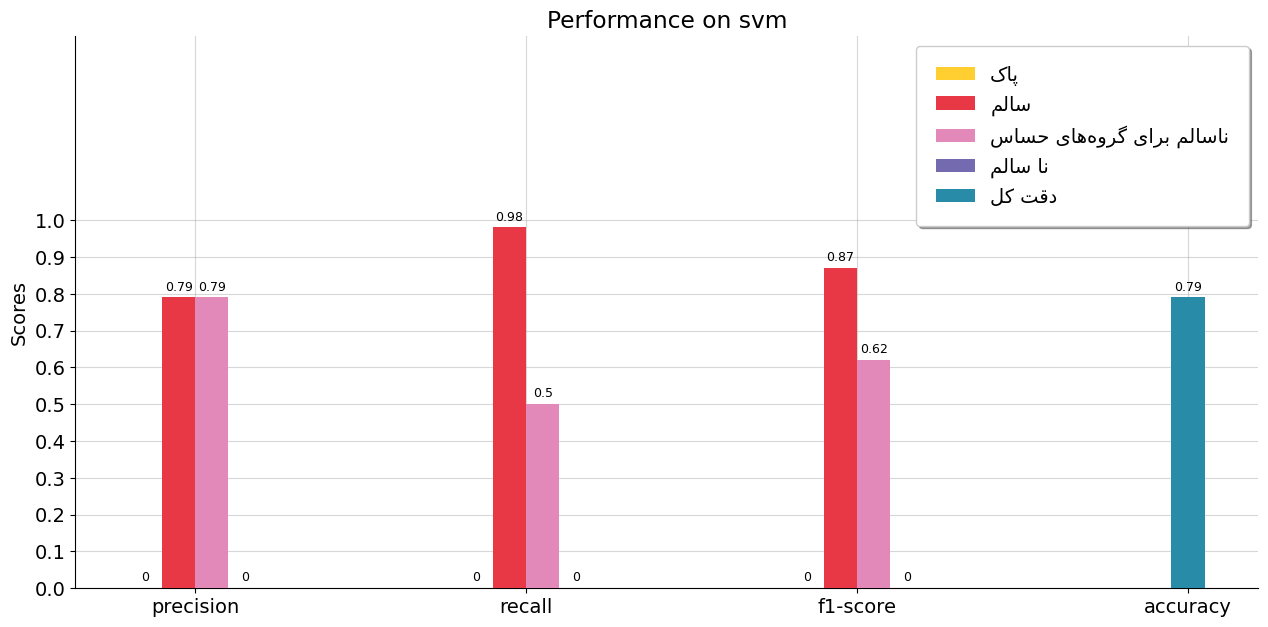

In [95]:
performance_barchar(report, "svm")

plt.savefig("./plots/svm/performance_on_svm.png")
plt.show()

> ### Cross-Validation

In [96]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing


svm_clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(kernel=best_kernel).fit(X_train, Y_train))
# svm_clf = svm.SVC(kernel=best_kernel).fit(X_train, Y_train)

svm_clf_w = make_pipeline(preprocessing.StandardScaler(), svm.SVC(kernel=best_kernel, class_weight=weights).fit(X_train, Y_train))
# svm_clf_w = svm.SVC(kernel=best_kernel, class_weight=weights).fit(X_train, Y_train)

accs = cross_validate(svm_clf, X, Y, cv=32, scoring=["accuracy"])["test_accuracy"]

mean = np.mean(accs)
std = np.std(accs) / np.sqrt(np.shape(accs)[0])

accs_w = cross_validate(svm_clf_w, X, Y, cv=32, scoring=["accuracy"])["test_accuracy"]

mean_w = np.mean(accs_w)
std_w = np.std(accs_w) / np.sqrt(np.shape(accs)[0])

print("Confidence interval of accuracy of Model (with 'poly' Kernel and confidence level 95%) is: \n")

print("Non-Weighted SVM: [{:.2f} , {:.2f}]".format(mean-1.96*std, mean+1.96*std))
print("Weighted SVM: [{:.2f} , {:.2f}]".format(mean_w-1.96*std_w, mean_w+1.96*std_w))



Confidence interval of accuracy of Model (with 'poly' Kernel and confidence level 95%) is: 

Non-Weighted SVM: [0.72 , 0.77]
Weighted SVM: [0.73 , 0.78]


> ### Weighted Vs. Not-Weighted

>> ### Precision

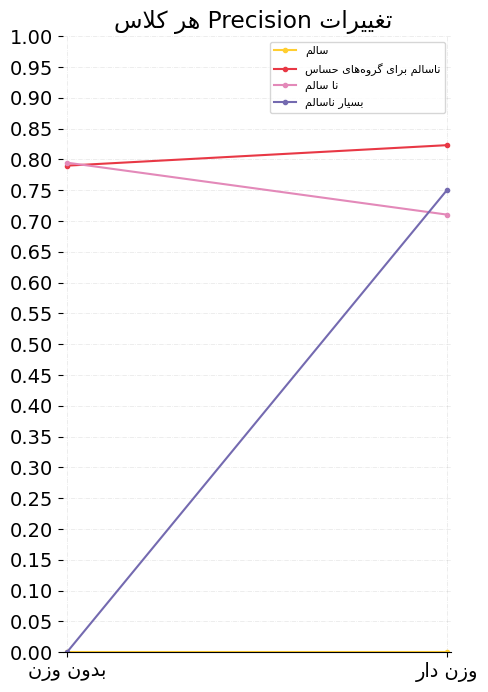

In [97]:
title = get_display(reshape(" تغییرات Precision هر کلاس"))

slope_chart(report, "svm", "svm_w", "precision", [1, 2, 3, 4], figsize=(5,8), title=title)
plt.savefig("./plots/svm/svm_slope_graph_precision.png")
plt.show()

>> ### Recall

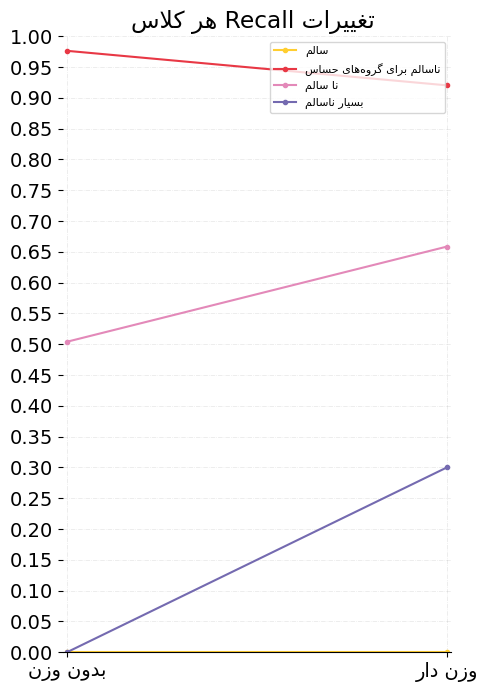

In [98]:
title = get_display(reshape(" تغییرات Recall هر کلاس"))

slope_chart(report, "svm", "svm_w", "recall", [1, 2, 3, 4], figsize=(5,8), title=title)
plt.savefig("./plots/svm/svm_slope_graph_recall.png")
plt.show()

>> ### F1-Score

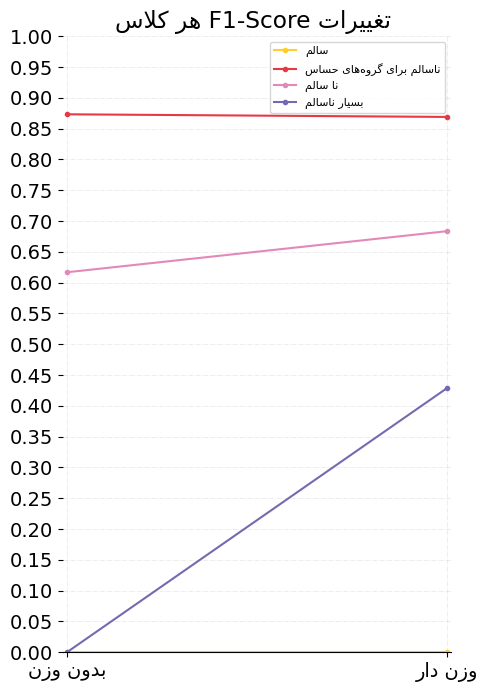

In [99]:
title = get_display(reshape(" تغییرات F1-Score هر کلاس"))

slope_chart(report, "svm", "svm_w", "f1-score", [1, 2, 3, 4], figsize=(5,8), title=title)
plt.savefig("./plots/svm/svm_slope_graph_f1.png")
plt.show()

----

- # Logistic Regression

In [100]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=0.01, solver='newton-cg')
clf.fit(X_train, Y_train)


clf_w = LogisticRegression(C=0.01, solver='newton-cg', class_weight=weights)
clf_w.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)
Y_pred_w = clf_w.predict(X_test)

print("The accuracy of Wieghted Logistic Regression is {:.2f}%".format(accuracy_score(Y_test, Y_pred_w)*100))

The accuracy of Wieghted Logistic Regression is 76.46%


> ### Confusion Matrix for Logistic Regresion:

Confusion matrix, without normalization
[[ 14  11   0   0]
 [ 17 272  50   0]
 [  0  30  92   1]
 [  0   1   7   2]]


<Figure size 800x800 with 0 Axes>

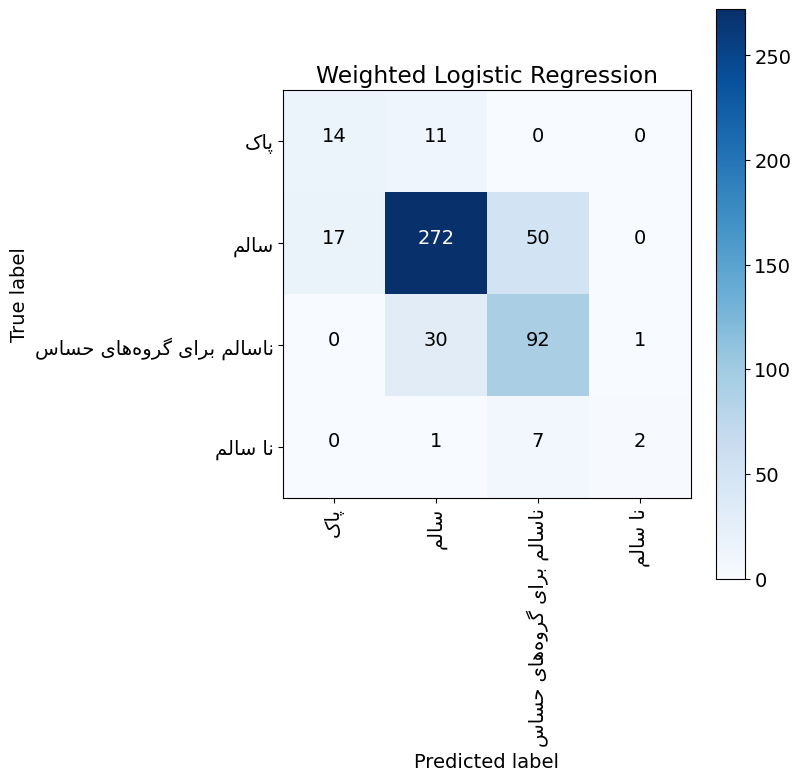

In [101]:
cnf_matrix = confusion_matrix(Y_test, Y_pred_w)
np.set_printoptions(precision=2)

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Weighted Logistic Regression')
plt.savefig("./plots/logistic regression/logreg_w_confusion_matrix.png")

Confusion matrix, without normalization
[[  4  21   0   0]
 [  4 325  10   0]
 [  0  51  71   1]
 [  0   1   8   1]]


<Figure size 800x800 with 0 Axes>

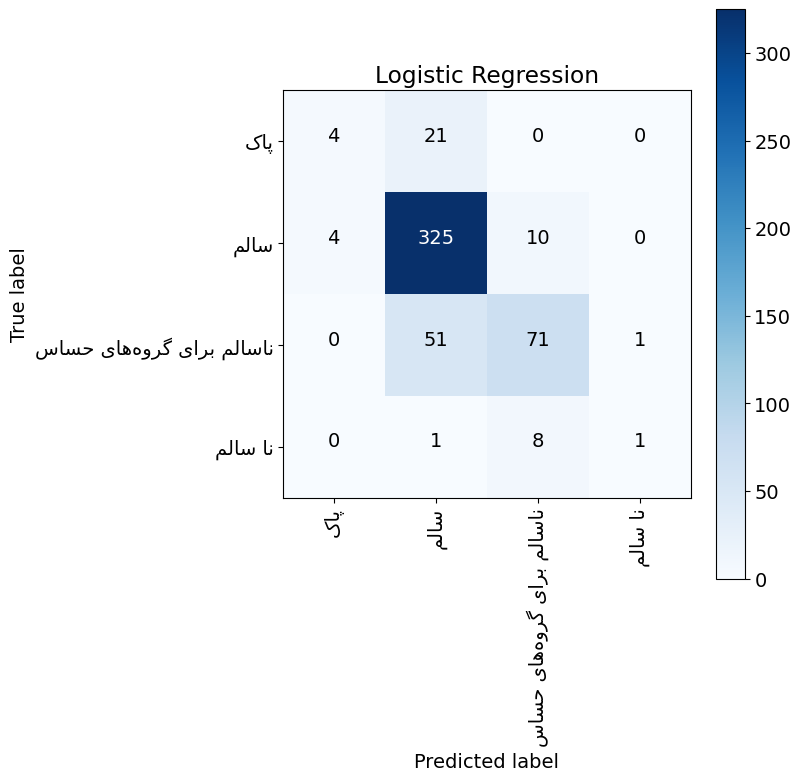

In [102]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Logistic Regression')
plt.savefig("./plots/logistic regression/logreg_confusion_matrix.png")

> ### Different Metrics

In [103]:
report["logreg_w"] = classification_report(Y_test, Y_pred_w, output_dict=True)
report["logreg_w"]["str"] = classification_report(Y_test, Y_pred_w)

print (classification_report(Y_test, Y_pred_w))

              precision    recall  f1-score   support

           1       0.45      0.56      0.50        25
           2       0.87      0.80      0.83       339
           3       0.62      0.75      0.68       123
           4       0.67      0.20      0.31        10

    accuracy                           0.76       497
   macro avg       0.65      0.58      0.58       497
weighted avg       0.78      0.76      0.77       497



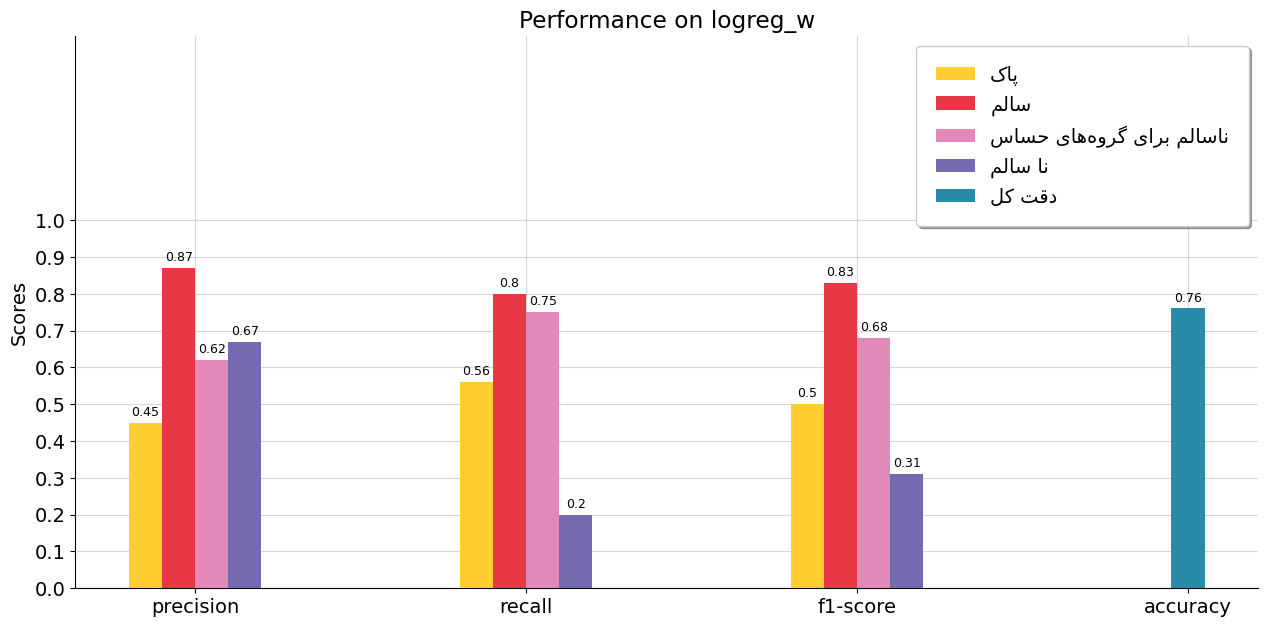

In [104]:
performance_barchar(report, "logreg_w")

plt.savefig("./plots/logistic regression/performance_on_logreg_w.png")
plt.show()

In [105]:
report["logreg"] = classification_report(Y_test, Y_pred, output_dict=True)
report["logreg"]["str"] = classification_report(Y_test, Y_pred)

print (report["logreg"]["str"])

              precision    recall  f1-score   support

           1       0.50      0.16      0.24        25
           2       0.82      0.96      0.88       339
           3       0.80      0.58      0.67       123
           4       0.50      0.10      0.17        10

    accuracy                           0.81       497
   macro avg       0.65      0.45      0.49       497
weighted avg       0.79      0.81      0.78       497



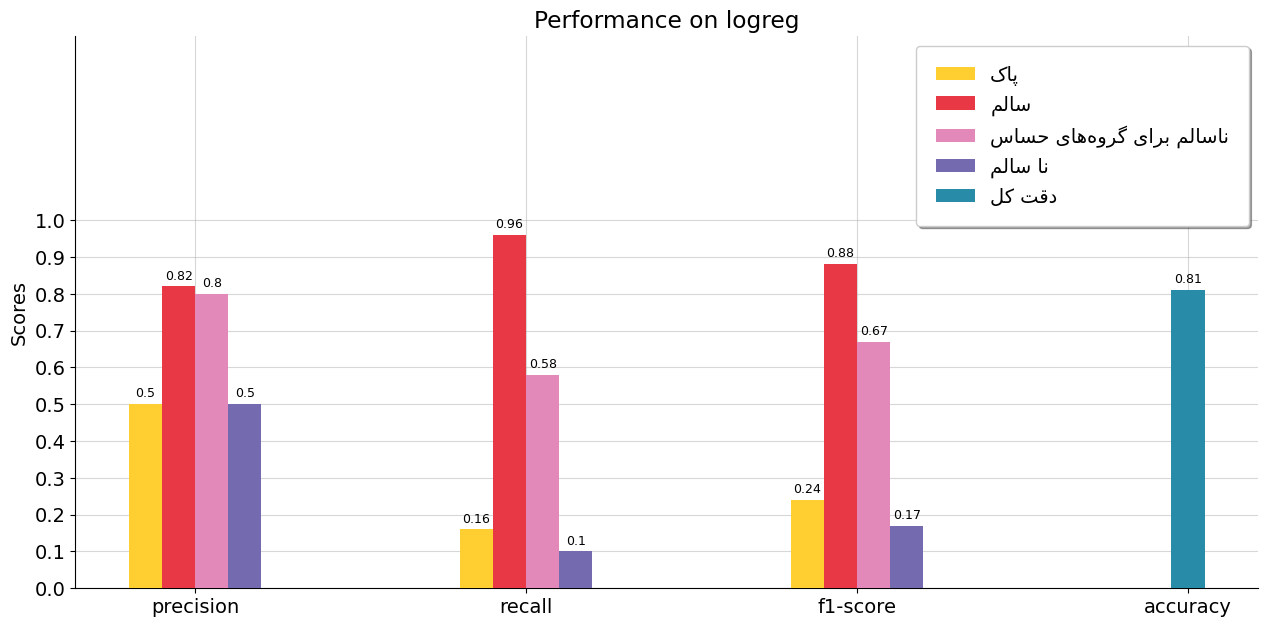

In [106]:
performance_barchar(report, "logreg")

plt.savefig("./plots/logistic regression/performance_on_logreg.png")
plt.show()

> ### Cross-Validation

In [107]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing


lgr_clf = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(C=0.01, solver='newton-cg').fit(X_train, Y_train))
# lgr_clf = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train, Y_train)

lgr_clf_w = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(C=0.01, solver='newton-cg', class_weight=weights).fit(X_train, Y_train))
# lgr_clf_w = LogisticRegression(C=0.01, solver='newton-cg', class_weight=weights).fit(X_train, Y_train)


accs = cross_validate(lgr_clf, X, Y, cv=32, scoring=["accuracy"])["test_accuracy"]
accs_w = cross_validate(lgr_clf_w, X, Y, cv=32, scoring=["accuracy"])["test_accuracy"]

mean = np.mean(accs)
std = np.std(accs) / np.sqrt(np.shape(accs)[0])

mean_w = np.mean(accs_w)
std_w = np.std(accs_w) / np.sqrt(np.shape(accs_w)[0])

print("Confidence interval of accuracy of Model (with confidence level 95%) is: \n")

print("Non-Weighted Logistic Regression: [{:.2f} , {:.2f}]".format(mean-1.96*std, mean+1.96*std))
print("Weighted Logistic Regression: [{:.2f} , {:.2f}]".format(mean_w-1.96*std_w, mean_w+1.96*std_w))



Confidence interval of accuracy of Model (with confidence level 95%) is: 

Non-Weighted Logistic Regression: [0.73 , 0.78]
Weighted Logistic Regression: [0.68 , 0.76]


> ### Weighted Vs. Not-Weighted

>> ### Precision

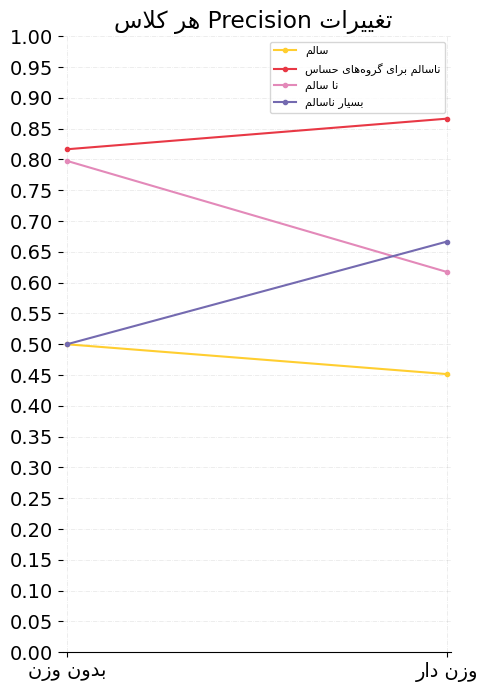

In [108]:
title = get_display(reshape(" تغییرات Precision هر کلاس"))

slope_chart(report, "logreg", "logreg_w", "precision", [1, 2, 3, 4], figsize=(5,8), title=title)
plt.savefig("./plots/logistic regression/logreg_slope_graph_precision.png")
plt.show()

>> ### Recall

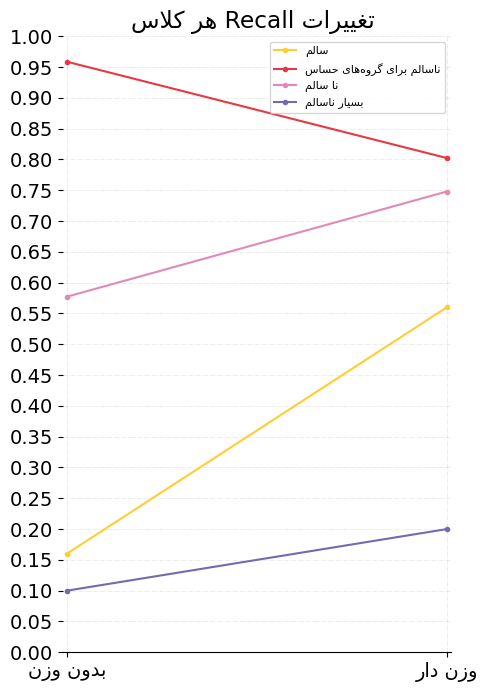

In [109]:
title = get_display(reshape(" تغییرات Recall هر کلاس"))

slope_chart(report, "logreg", "logreg_w", "recall", [1, 2, 3, 4], figsize=(5,8), title=title)
plt.savefig("./plots/logistic regression/logreg_slope_graph_recall.png")
plt.show()

>> ### F1-Score

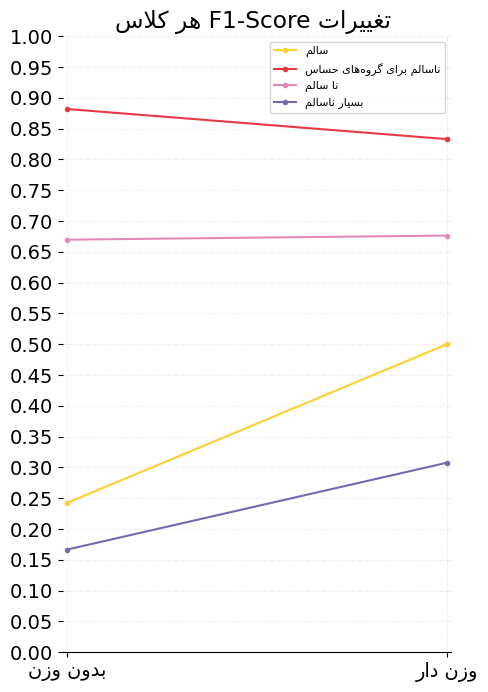

In [110]:
title = get_display(reshape(" تغییرات F1-Score هر کلاس"))

slope_chart(report, "logreg", "logreg_w", "f1-score", [1, 2, 3, 4], figsize=(5,8), title=title)
plt.savefig("./plots/logistic regression/logreg_slope_graph_f1.png")
plt.show()

---

- # MLP

In [111]:
def one_hot(arr):
    _arr = arr - 1
    arr_one_hot = np.zeros((_arr.size, _arr.max()+1))
    arr_one_hot[np.arange(_arr.size),_arr] = 1
    
    return arr_one_hot

In [112]:
from sklearn.neural_network import MLPClassifier

one_hot_output=True

Y_train_onehot = one_hot(Y_train)

clf = MLPClassifier(
                    activation='logistic', 
                    solver='adam',
                    hidden_layer_sizes=(100,), 
                    learning_rate='adaptive',
                    learning_rate_init=1e-5, 
                    verbose=True, 
                    max_iter=10000,
                    tol=1e-8
                    )

_Y_train = Y_train
if one_hot_output:
    _Y_train = Y_train_onehot

clf.fit(X_train, _Y_train)

Y_pred = clf.predict(X_test)
if one_hot_output:
    Y_pred = np.argmax(Y_pred, axis=1) + 1


Iteration 1, loss = 2.56601794
Iteration 2, loss = 2.55712959
Iteration 3, loss = 2.54829612
Iteration 4, loss = 2.53956224
Iteration 5, loss = 2.53088082
Iteration 6, loss = 2.52229550
Iteration 7, loss = 2.51377421
Iteration 8, loss = 2.50538294
Iteration 9, loss = 2.49701536
Iteration 10, loss = 2.48871138
Iteration 11, loss = 2.48052121
Iteration 12, loss = 2.47242450
Iteration 13, loss = 2.46434876
Iteration 14, loss = 2.45635561
Iteration 15, loss = 2.44843693
Iteration 16, loss = 2.44057397
Iteration 17, loss = 2.43283753
Iteration 18, loss = 2.42507979
Iteration 19, loss = 2.41745163
Iteration 20, loss = 2.40982640
Iteration 21, loss = 2.40233715
Iteration 22, loss = 2.39487088
Iteration 23, loss = 2.38745025
Iteration 24, loss = 2.38009617
Iteration 25, loss = 2.37282445
Iteration 26, loss = 2.36561929
Iteration 27, loss = 2.35843450
Iteration 28, loss = 2.35133187
Iteration 29, loss = 2.34428185
Iteration 30, loss = 2.33724531
Iteration 31, loss = 2.33033602
Iteration 32, los

Iteration 255, loss = 1.52680580
Iteration 256, loss = 1.52511183
Iteration 257, loss = 1.52342449
Iteration 258, loss = 1.52176815
Iteration 259, loss = 1.52012167
Iteration 260, loss = 1.51849535
Iteration 261, loss = 1.51690849
Iteration 262, loss = 1.51530259
Iteration 263, loss = 1.51374807
Iteration 264, loss = 1.51219626
Iteration 265, loss = 1.51066485
Iteration 266, loss = 1.50916559
Iteration 267, loss = 1.50766899
Iteration 268, loss = 1.50618937
Iteration 269, loss = 1.50473709
Iteration 270, loss = 1.50331362
Iteration 271, loss = 1.50188324
Iteration 272, loss = 1.50049094
Iteration 273, loss = 1.49910919
Iteration 274, loss = 1.49774188
Iteration 275, loss = 1.49640484
Iteration 276, loss = 1.49507573
Iteration 277, loss = 1.49374467
Iteration 278, loss = 1.49245157
Iteration 279, loss = 1.49117340
Iteration 280, loss = 1.48991881
Iteration 281, loss = 1.48864525
Iteration 282, loss = 1.48743292
Iteration 283, loss = 1.48620438
Iteration 284, loss = 1.48500995
Iteration 

Iteration 527, loss = 1.34968645
Iteration 528, loss = 1.34939660
Iteration 529, loss = 1.34911734
Iteration 530, loss = 1.34883329
Iteration 531, loss = 1.34853909
Iteration 532, loss = 1.34826753
Iteration 533, loss = 1.34796618
Iteration 534, loss = 1.34768513
Iteration 535, loss = 1.34740525
Iteration 536, loss = 1.34711105
Iteration 537, loss = 1.34682508
Iteration 538, loss = 1.34653303
Iteration 539, loss = 1.34624093
Iteration 540, loss = 1.34595468
Iteration 541, loss = 1.34566060
Iteration 542, loss = 1.34536960
Iteration 543, loss = 1.34507186
Iteration 544, loss = 1.34478819
Iteration 545, loss = 1.34447773
Iteration 546, loss = 1.34420496
Iteration 547, loss = 1.34388926
Iteration 548, loss = 1.34361857
Iteration 549, loss = 1.34330052
Iteration 550, loss = 1.34301132
Iteration 551, loss = 1.34270449
Iteration 552, loss = 1.34241814
Iteration 553, loss = 1.34211189
Iteration 554, loss = 1.34181659
Iteration 555, loss = 1.34151823
Iteration 556, loss = 1.34122095
Iteration 

Iteration 781, loss = 1.29142645
Iteration 782, loss = 1.29122371
Iteration 783, loss = 1.29102791
Iteration 784, loss = 1.29083453
Iteration 785, loss = 1.29064404
Iteration 786, loss = 1.29046243
Iteration 787, loss = 1.29027319
Iteration 788, loss = 1.29008016
Iteration 789, loss = 1.28988768
Iteration 790, loss = 1.28971085
Iteration 791, loss = 1.28951340
Iteration 792, loss = 1.28932828
Iteration 793, loss = 1.28913450
Iteration 794, loss = 1.28894377
Iteration 795, loss = 1.28875785
Iteration 796, loss = 1.28857531
Iteration 797, loss = 1.28838453
Iteration 798, loss = 1.28820106
Iteration 799, loss = 1.28801701
Iteration 800, loss = 1.28783138
Iteration 801, loss = 1.28763666
Iteration 802, loss = 1.28744588
Iteration 803, loss = 1.28729711
Iteration 804, loss = 1.28707689
Iteration 805, loss = 1.28688101
Iteration 806, loss = 1.28671142
Iteration 807, loss = 1.28652887
Iteration 808, loss = 1.28633065
Iteration 809, loss = 1.28614241
Iteration 810, loss = 1.28598343
Iteration 

Iteration 1032, loss = 1.24901546
Iteration 1033, loss = 1.24885849
Iteration 1034, loss = 1.24873420
Iteration 1035, loss = 1.24858684
Iteration 1036, loss = 1.24844421
Iteration 1037, loss = 1.24830240
Iteration 1038, loss = 1.24816266
Iteration 1039, loss = 1.24802185
Iteration 1040, loss = 1.24789013
Iteration 1041, loss = 1.24774668
Iteration 1042, loss = 1.24761883
Iteration 1043, loss = 1.24746804
Iteration 1044, loss = 1.24733913
Iteration 1045, loss = 1.24718983
Iteration 1046, loss = 1.24704545
Iteration 1047, loss = 1.24693230
Iteration 1048, loss = 1.24677310
Iteration 1049, loss = 1.24663478
Iteration 1050, loss = 1.24650960
Iteration 1051, loss = 1.24636133
Iteration 1052, loss = 1.24622197
Iteration 1053, loss = 1.24609137
Iteration 1054, loss = 1.24595218
Iteration 1055, loss = 1.24585070
Iteration 1056, loss = 1.24567598
Iteration 1057, loss = 1.24557627
Iteration 1058, loss = 1.24540981
Iteration 1059, loss = 1.24527547
Iteration 1060, loss = 1.24514258
Iteration 1061

Iteration 1282, loss = 1.21930616
Iteration 1283, loss = 1.21919840
Iteration 1284, loss = 1.21907319
Iteration 1285, loss = 1.21899396
Iteration 1286, loss = 1.21888297
Iteration 1287, loss = 1.21877135
Iteration 1288, loss = 1.21868927
Iteration 1289, loss = 1.21857100
Iteration 1290, loss = 1.21856916
Iteration 1291, loss = 1.21837358
Iteration 1292, loss = 1.21828322
Iteration 1293, loss = 1.21815444
Iteration 1294, loss = 1.21805201
Iteration 1295, loss = 1.21798387
Iteration 1296, loss = 1.21784092
Iteration 1297, loss = 1.21776000
Iteration 1298, loss = 1.21764876
Iteration 1299, loss = 1.21754604
Iteration 1300, loss = 1.21745065
Iteration 1301, loss = 1.21734035
Iteration 1302, loss = 1.21725549
Iteration 1303, loss = 1.21714211
Iteration 1304, loss = 1.21702920
Iteration 1305, loss = 1.21695904
Iteration 1306, loss = 1.21683309
Iteration 1307, loss = 1.21672736
Iteration 1308, loss = 1.21663173
Iteration 1309, loss = 1.21653069
Iteration 1310, loss = 1.21643372
Iteration 1311

Iteration 1530, loss = 1.19717293
Iteration 1531, loss = 1.19712266
Iteration 1532, loss = 1.19703287
Iteration 1533, loss = 1.19695113
Iteration 1534, loss = 1.19688764
Iteration 1535, loss = 1.19680723
Iteration 1536, loss = 1.19677810
Iteration 1537, loss = 1.19671449
Iteration 1538, loss = 1.19658314
Iteration 1539, loss = 1.19650302
Iteration 1540, loss = 1.19643198
Iteration 1541, loss = 1.19635345
Iteration 1542, loss = 1.19628030
Iteration 1543, loss = 1.19620296
Iteration 1544, loss = 1.19614697
Iteration 1545, loss = 1.19608873
Iteration 1546, loss = 1.19599261
Iteration 1547, loss = 1.19592063
Iteration 1548, loss = 1.19585396
Iteration 1549, loss = 1.19577160
Iteration 1550, loss = 1.19568631
Iteration 1551, loss = 1.19565519
Iteration 1552, loss = 1.19555049
Iteration 1553, loss = 1.19548688
Iteration 1554, loss = 1.19539541
Iteration 1555, loss = 1.19532138
Iteration 1556, loss = 1.19526390
Iteration 1557, loss = 1.19517809
Iteration 1558, loss = 1.19510305
Iteration 1559

Iteration 1776, loss = 1.18097690
Iteration 1777, loss = 1.18090861
Iteration 1778, loss = 1.18085587
Iteration 1779, loss = 1.18080000
Iteration 1780, loss = 1.18072649
Iteration 1781, loss = 1.18067550
Iteration 1782, loss = 1.18063323
Iteration 1783, loss = 1.18055489
Iteration 1784, loss = 1.18049840
Iteration 1785, loss = 1.18043076
Iteration 1786, loss = 1.18037689
Iteration 1787, loss = 1.18031239
Iteration 1788, loss = 1.18027658
Iteration 1789, loss = 1.18019156
Iteration 1790, loss = 1.18013465
Iteration 1791, loss = 1.18008546
Iteration 1792, loss = 1.18004630
Iteration 1793, loss = 1.17998896
Iteration 1794, loss = 1.17991755
Iteration 1795, loss = 1.17985466
Iteration 1796, loss = 1.17977983
Iteration 1797, loss = 1.17972017
Iteration 1798, loss = 1.17966243
Iteration 1799, loss = 1.17960814
Iteration 1800, loss = 1.17955003
Iteration 1801, loss = 1.17949345
Iteration 1802, loss = 1.17945228
Iteration 1803, loss = 1.17938230
Iteration 1804, loss = 1.17930980
Iteration 1805

Iteration 2024, loss = 1.16769062
Iteration 2025, loss = 1.16765293
Iteration 2026, loss = 1.16762165
Iteration 2027, loss = 1.16755077
Iteration 2028, loss = 1.16751159
Iteration 2029, loss = 1.16747479
Iteration 2030, loss = 1.16741371
Iteration 2031, loss = 1.16737182
Iteration 2032, loss = 1.16733573
Iteration 2033, loss = 1.16727592
Iteration 2034, loss = 1.16724101
Iteration 2035, loss = 1.16719711
Iteration 2036, loss = 1.16713292
Iteration 2037, loss = 1.16710066
Iteration 2038, loss = 1.16704221
Iteration 2039, loss = 1.16702850
Iteration 2040, loss = 1.16695157
Iteration 2041, loss = 1.16689830
Iteration 2042, loss = 1.16685714
Iteration 2043, loss = 1.16682287
Iteration 2044, loss = 1.16678154
Iteration 2045, loss = 1.16672219
Iteration 2046, loss = 1.16667407
Iteration 2047, loss = 1.16662584
Iteration 2048, loss = 1.16657846
Iteration 2049, loss = 1.16653989
Iteration 2050, loss = 1.16649116
Iteration 2051, loss = 1.16644294
Iteration 2052, loss = 1.16640514
Iteration 2053

Iteration 2272, loss = 1.15729469
Iteration 2273, loss = 1.15726054
Iteration 2274, loss = 1.15722343
Iteration 2275, loss = 1.15727253
Iteration 2276, loss = 1.15714226
Iteration 2277, loss = 1.15711005
Iteration 2278, loss = 1.15710010
Iteration 2279, loss = 1.15702370
Iteration 2280, loss = 1.15699472
Iteration 2281, loss = 1.15695029
Iteration 2282, loss = 1.15692292
Iteration 2283, loss = 1.15688457
Iteration 2284, loss = 1.15684558
Iteration 2285, loss = 1.15680556
Iteration 2286, loss = 1.15676533
Iteration 2287, loss = 1.15672598
Iteration 2288, loss = 1.15670184
Iteration 2289, loss = 1.15666188
Iteration 2290, loss = 1.15661487
Iteration 2291, loss = 1.15658488
Iteration 2292, loss = 1.15656235
Iteration 2293, loss = 1.15650563
Iteration 2294, loss = 1.15646607
Iteration 2295, loss = 1.15644090
Iteration 2296, loss = 1.15640119
Iteration 2297, loss = 1.15637758
Iteration 2298, loss = 1.15631294
Iteration 2299, loss = 1.15629694
Iteration 2300, loss = 1.15624548
Iteration 2301

Iteration 2518, loss = 1.14881508
Iteration 2519, loss = 1.14877437
Iteration 2520, loss = 1.14874826
Iteration 2521, loss = 1.14875201
Iteration 2522, loss = 1.14868416
Iteration 2523, loss = 1.14866770
Iteration 2524, loss = 1.14861127
Iteration 2525, loss = 1.14858313
Iteration 2526, loss = 1.14857952
Iteration 2527, loss = 1.14854943
Iteration 2528, loss = 1.14849488
Iteration 2529, loss = 1.14846464
Iteration 2530, loss = 1.14843551
Iteration 2531, loss = 1.14840288
Iteration 2532, loss = 1.14837595
Iteration 2533, loss = 1.14832977
Iteration 2534, loss = 1.14833383
Iteration 2535, loss = 1.14827784
Iteration 2536, loss = 1.14824388
Iteration 2537, loss = 1.14824666
Iteration 2538, loss = 1.14817553
Iteration 2539, loss = 1.14815299
Iteration 2540, loss = 1.14811718
Iteration 2541, loss = 1.14810761
Iteration 2542, loss = 1.14807954
Iteration 2543, loss = 1.14803283
Iteration 2544, loss = 1.14799066
Iteration 2545, loss = 1.14795715
Iteration 2546, loss = 1.14795726
Iteration 2547

Iteration 2763, loss = 1.14157615
Iteration 2764, loss = 1.14154975
Iteration 2765, loss = 1.14152126
Iteration 2766, loss = 1.14149060
Iteration 2767, loss = 1.14148078
Iteration 2768, loss = 1.14145203
Iteration 2769, loss = 1.14141076
Iteration 2770, loss = 1.14138895
Iteration 2771, loss = 1.14136056
Iteration 2772, loss = 1.14135655
Iteration 2773, loss = 1.14130295
Iteration 2774, loss = 1.14126923
Iteration 2775, loss = 1.14126361
Iteration 2776, loss = 1.14125447
Iteration 2777, loss = 1.14119891
Iteration 2778, loss = 1.14115691
Iteration 2779, loss = 1.14113339
Iteration 2780, loss = 1.14115229
Iteration 2781, loss = 1.14107225
Iteration 2782, loss = 1.14106256
Iteration 2783, loss = 1.14102145
Iteration 2784, loss = 1.14099421
Iteration 2785, loss = 1.14095831
Iteration 2786, loss = 1.14094165
Iteration 2787, loss = 1.14095283
Iteration 2788, loss = 1.14088759
Iteration 2789, loss = 1.14085972
Iteration 2790, loss = 1.14083369
Iteration 2791, loss = 1.14080651
Iteration 2792

Iteration 3011, loss = 1.13523121
Iteration 3012, loss = 1.13521786
Iteration 3013, loss = 1.13519390
Iteration 3014, loss = 1.13517540
Iteration 3015, loss = 1.13513593
Iteration 3016, loss = 1.13512560
Iteration 3017, loss = 1.13508701
Iteration 3018, loss = 1.13507612
Iteration 3019, loss = 1.13505536
Iteration 3020, loss = 1.13501505
Iteration 3021, loss = 1.13500601
Iteration 3022, loss = 1.13498507
Iteration 3023, loss = 1.13493990
Iteration 3024, loss = 1.13494518
Iteration 3025, loss = 1.13491054
Iteration 3026, loss = 1.13487851
Iteration 3027, loss = 1.13485810
Iteration 3028, loss = 1.13483533
Iteration 3029, loss = 1.13481655
Iteration 3030, loss = 1.13477336
Iteration 3031, loss = 1.13475028
Iteration 3032, loss = 1.13472495
Iteration 3033, loss = 1.13471433
Iteration 3034, loss = 1.13469362
Iteration 3035, loss = 1.13465814
Iteration 3036, loss = 1.13463145
Iteration 3037, loss = 1.13463181
Iteration 3038, loss = 1.13460883
Iteration 3039, loss = 1.13461578
Iteration 3040

Iteration 3259, loss = 1.12962403
Iteration 3260, loss = 1.12956629
Iteration 3261, loss = 1.12955003
Iteration 3262, loss = 1.12953993
Iteration 3263, loss = 1.12953020
Iteration 3264, loss = 1.12948416
Iteration 3265, loss = 1.12949130
Iteration 3266, loss = 1.12944043
Iteration 3267, loss = 1.12942370
Iteration 3268, loss = 1.12939714
Iteration 3269, loss = 1.12938622
Iteration 3270, loss = 1.12939645
Iteration 3271, loss = 1.12933099
Iteration 3272, loss = 1.12933766
Iteration 3273, loss = 1.12928186
Iteration 3274, loss = 1.12927652
Iteration 3275, loss = 1.12925117
Iteration 3276, loss = 1.12922462
Iteration 3277, loss = 1.12919564
Iteration 3278, loss = 1.12917642
Iteration 3279, loss = 1.12916509
Iteration 3280, loss = 1.12915110
Iteration 3281, loss = 1.12915222
Iteration 3282, loss = 1.12911132
Iteration 3283, loss = 1.12912635
Iteration 3284, loss = 1.12907316
Iteration 3285, loss = 1.12903139
Iteration 3286, loss = 1.12902922
Iteration 3287, loss = 1.12899984
Iteration 3288

Iteration 3507, loss = 1.12452231
Iteration 3508, loss = 1.12450470
Iteration 3509, loss = 1.12449940
Iteration 3510, loss = 1.12447608
Iteration 3511, loss = 1.12443961
Iteration 3512, loss = 1.12443746
Iteration 3513, loss = 1.12440294
Iteration 3514, loss = 1.12439969
Iteration 3515, loss = 1.12440021
Iteration 3516, loss = 1.12435586
Iteration 3517, loss = 1.12433145
Iteration 3518, loss = 1.12430998
Iteration 3519, loss = 1.12429309
Iteration 3520, loss = 1.12427118
Iteration 3521, loss = 1.12431229
Iteration 3522, loss = 1.12422033
Iteration 3523, loss = 1.12422921
Iteration 3524, loss = 1.12423659
Iteration 3525, loss = 1.12417550
Iteration 3526, loss = 1.12417155
Iteration 3527, loss = 1.12413739
Iteration 3528, loss = 1.12412101
Iteration 3529, loss = 1.12409202
Iteration 3530, loss = 1.12407861
Iteration 3531, loss = 1.12405911
Iteration 3532, loss = 1.12405232
Iteration 3533, loss = 1.12402551
Iteration 3534, loss = 1.12404536
Iteration 3535, loss = 1.12400061
Iteration 3536

Iteration 3756, loss = 1.11996000
Iteration 3757, loss = 1.11990426
Iteration 3758, loss = 1.11990403
Iteration 3759, loss = 1.11989733
Iteration 3760, loss = 1.11983866
Iteration 3761, loss = 1.11983215
Iteration 3762, loss = 1.11982793
Iteration 3763, loss = 1.11979539
Iteration 3764, loss = 1.11978265
Iteration 3765, loss = 1.11978705
Iteration 3766, loss = 1.11976448
Iteration 3767, loss = 1.11972491
Iteration 3768, loss = 1.11971043
Iteration 3769, loss = 1.11968380
Iteration 3770, loss = 1.11969565
Iteration 3771, loss = 1.11967637
Iteration 3772, loss = 1.11966032
Iteration 3773, loss = 1.11962260
Iteration 3774, loss = 1.11962874
Iteration 3775, loss = 1.11958884
Iteration 3776, loss = 1.11958506
Iteration 3777, loss = 1.11955249
Iteration 3778, loss = 1.11954367
Iteration 3779, loss = 1.11953480
Iteration 3780, loss = 1.11952322
Iteration 3781, loss = 1.11950447
Iteration 3782, loss = 1.11945991
Iteration 3783, loss = 1.11945404
Iteration 3784, loss = 1.11944815
Iteration 3785

Iteration 4005, loss = 1.11569636
Iteration 4006, loss = 1.11566544
Iteration 4007, loss = 1.11564799
Iteration 4008, loss = 1.11565130
Iteration 4009, loss = 1.11564201
Iteration 4010, loss = 1.11562134
Iteration 4011, loss = 1.11560251
Iteration 4012, loss = 1.11561541
Iteration 4013, loss = 1.11557511
Iteration 4014, loss = 1.11554801
Iteration 4015, loss = 1.11554176
Iteration 4016, loss = 1.11552131
Iteration 4017, loss = 1.11550755
Iteration 4018, loss = 1.11546775
Iteration 4019, loss = 1.11546994
Iteration 4020, loss = 1.11545119
Iteration 4021, loss = 1.11544908
Iteration 4022, loss = 1.11542589
Iteration 4023, loss = 1.11539843
Iteration 4024, loss = 1.11537392
Iteration 4025, loss = 1.11539915
Iteration 4026, loss = 1.11536614
Iteration 4027, loss = 1.11532560
Iteration 4028, loss = 1.11530961
Iteration 4029, loss = 1.11534037
Iteration 4030, loss = 1.11528873
Iteration 4031, loss = 1.11527823
Iteration 4032, loss = 1.11524649
Iteration 4033, loss = 1.11523692
Iteration 4034

Iteration 4251, loss = 1.11180398
Iteration 4252, loss = 1.11179401
Iteration 4253, loss = 1.11175623
Iteration 4254, loss = 1.11172042
Iteration 4255, loss = 1.11172423
Iteration 4256, loss = 1.11169908
Iteration 4257, loss = 1.11168429
Iteration 4258, loss = 1.11167369
Iteration 4259, loss = 1.11165383
Iteration 4260, loss = 1.11164369
Iteration 4261, loss = 1.11162377
Iteration 4262, loss = 1.11160328
Iteration 4263, loss = 1.11159945
Iteration 4264, loss = 1.11163795
Iteration 4265, loss = 1.11155724
Iteration 4266, loss = 1.11158126
Iteration 4267, loss = 1.11152730
Iteration 4268, loss = 1.11151488
Iteration 4269, loss = 1.11151713
Iteration 4270, loss = 1.11147586
Iteration 4271, loss = 1.11148330
Iteration 4272, loss = 1.11147470
Iteration 4273, loss = 1.11143065
Iteration 4274, loss = 1.11141061
Iteration 4275, loss = 1.11140018
Iteration 4276, loss = 1.11139770
Iteration 4277, loss = 1.11139812
Iteration 4278, loss = 1.11138948
Iteration 4279, loss = 1.11134725
Iteration 4280

Iteration 4496, loss = 1.10812904
Iteration 4497, loss = 1.10808662
Iteration 4498, loss = 1.10806732
Iteration 4499, loss = 1.10804945
Iteration 4500, loss = 1.10805277
Iteration 4501, loss = 1.10803165
Iteration 4502, loss = 1.10801642
Iteration 4503, loss = 1.10800360
Iteration 4504, loss = 1.10803243
Iteration 4505, loss = 1.10798262
Iteration 4506, loss = 1.10796200
Iteration 4507, loss = 1.10794060
Iteration 4508, loss = 1.10795168
Iteration 4509, loss = 1.10792391
Iteration 4510, loss = 1.10790690
Iteration 4511, loss = 1.10788693
Iteration 4512, loss = 1.10788484
Iteration 4513, loss = 1.10784883
Iteration 4514, loss = 1.10783016
Iteration 4515, loss = 1.10782208
Iteration 4516, loss = 1.10781369
Iteration 4517, loss = 1.10779695
Iteration 4518, loss = 1.10779148
Iteration 4519, loss = 1.10778544
Iteration 4520, loss = 1.10774704
Iteration 4521, loss = 1.10776121
Iteration 4522, loss = 1.10772362
Iteration 4523, loss = 1.10771119
Iteration 4524, loss = 1.10769885
Iteration 4525

Iteration 4738, loss = 1.10466581
Iteration 4739, loss = 1.10463913
Iteration 4740, loss = 1.10463288
Iteration 4741, loss = 1.10462341
Iteration 4742, loss = 1.10459667
Iteration 4743, loss = 1.10459131
Iteration 4744, loss = 1.10456073
Iteration 4745, loss = 1.10456452
Iteration 4746, loss = 1.10454627
Iteration 4747, loss = 1.10453784
Iteration 4748, loss = 1.10452110
Iteration 4749, loss = 1.10451074
Iteration 4750, loss = 1.10450487
Iteration 4751, loss = 1.10447006
Iteration 4752, loss = 1.10445066
Iteration 4753, loss = 1.10444578
Iteration 4754, loss = 1.10442841
Iteration 4755, loss = 1.10441662
Iteration 4756, loss = 1.10441907
Iteration 4757, loss = 1.10439010
Iteration 4758, loss = 1.10443532
Iteration 4759, loss = 1.10444929
Iteration 4760, loss = 1.10436250
Iteration 4761, loss = 1.10434384
Iteration 4762, loss = 1.10432155
Iteration 4763, loss = 1.10431406
Iteration 4764, loss = 1.10432198
Iteration 4765, loss = 1.10427803
Iteration 4766, loss = 1.10428449
Iteration 4767

Iteration 4981, loss = 1.10129061
Iteration 4982, loss = 1.10128724
Iteration 4983, loss = 1.10124749
Iteration 4984, loss = 1.10130127
Iteration 4985, loss = 1.10122887
Iteration 4986, loss = 1.10121869
Iteration 4987, loss = 1.10120135
Iteration 4988, loss = 1.10118064
Iteration 4989, loss = 1.10118717
Iteration 4990, loss = 1.10116120
Iteration 4991, loss = 1.10114000
Iteration 4992, loss = 1.10114692
Iteration 4993, loss = 1.10113231
Iteration 4994, loss = 1.10111195
Iteration 4995, loss = 1.10108802
Iteration 4996, loss = 1.10108908
Iteration 4997, loss = 1.10106183
Iteration 4998, loss = 1.10107283
Iteration 4999, loss = 1.10103388
Iteration 5000, loss = 1.10102196
Iteration 5001, loss = 1.10100754
Iteration 5002, loss = 1.10099682
Iteration 5003, loss = 1.10098757
Iteration 5004, loss = 1.10095153
Iteration 5005, loss = 1.10095710
Iteration 5006, loss = 1.10093686
Iteration 5007, loss = 1.10093631
Iteration 5008, loss = 1.10090590
Iteration 5009, loss = 1.10090914
Iteration 5010

Iteration 5251, loss = 1.09759212
Iteration 5252, loss = 1.09757461
Iteration 5253, loss = 1.09755711
Iteration 5254, loss = 1.09754845
Iteration 5255, loss = 1.09752602
Iteration 5256, loss = 1.09752300
Iteration 5257, loss = 1.09751136
Iteration 5258, loss = 1.09750022
Iteration 5259, loss = 1.09752795
Iteration 5260, loss = 1.09747344
Iteration 5261, loss = 1.09745906
Iteration 5262, loss = 1.09745945
Iteration 5263, loss = 1.09744258
Iteration 5264, loss = 1.09744316
Iteration 5265, loss = 1.09741737
Iteration 5266, loss = 1.09740549
Iteration 5267, loss = 1.09737288
Iteration 5268, loss = 1.09737253
Iteration 5269, loss = 1.09735018
Iteration 5270, loss = 1.09734034
Iteration 5271, loss = 1.09732356
Iteration 5272, loss = 1.09732486
Iteration 5273, loss = 1.09729603
Iteration 5274, loss = 1.09727901
Iteration 5275, loss = 1.09727275
Iteration 5276, loss = 1.09725093
Iteration 5277, loss = 1.09725575
Iteration 5278, loss = 1.09723026
Iteration 5279, loss = 1.09721503
Iteration 5280

Iteration 5514, loss = 1.09426561
Iteration 5515, loss = 1.09424987
Iteration 5516, loss = 1.09424241
Iteration 5517, loss = 1.09422137
Iteration 5518, loss = 1.09420518
Iteration 5519, loss = 1.09420031
Iteration 5520, loss = 1.09418605
Iteration 5521, loss = 1.09418069
Iteration 5522, loss = 1.09418606
Iteration 5523, loss = 1.09414485
Iteration 5524, loss = 1.09414633
Iteration 5525, loss = 1.09412476
Iteration 5526, loss = 1.09411332
Iteration 5527, loss = 1.09411160
Iteration 5528, loss = 1.09409157
Iteration 5529, loss = 1.09409224
Iteration 5530, loss = 1.09409914
Iteration 5531, loss = 1.09408918
Iteration 5532, loss = 1.09404392
Iteration 5533, loss = 1.09404508
Iteration 5534, loss = 1.09401948
Iteration 5535, loss = 1.09400642
Iteration 5536, loss = 1.09399234
Iteration 5537, loss = 1.09403575
Iteration 5538, loss = 1.09396936
Iteration 5539, loss = 1.09395533
Iteration 5540, loss = 1.09396444
Iteration 5541, loss = 1.09392653
Iteration 5542, loss = 1.09392714
Iteration 5543

Iteration 5779, loss = 1.09119790
Iteration 5780, loss = 1.09118869
Iteration 5781, loss = 1.09119519
Iteration 5782, loss = 1.09117319
Iteration 5783, loss = 1.09115232
Iteration 5784, loss = 1.09113933
Iteration 5785, loss = 1.09115239
Iteration 5786, loss = 1.09111438
Iteration 5787, loss = 1.09110272
Iteration 5788, loss = 1.09110973
Iteration 5789, loss = 1.09109552
Iteration 5790, loss = 1.09108406
Iteration 5791, loss = 1.09106349
Iteration 5792, loss = 1.09105026
Iteration 5793, loss = 1.09103939
Iteration 5794, loss = 1.09103255
Iteration 5795, loss = 1.09101667
Iteration 5796, loss = 1.09103154
Iteration 5797, loss = 1.09100502
Iteration 5798, loss = 1.09097809
Iteration 5799, loss = 1.09101097
Iteration 5800, loss = 1.09095926
Iteration 5801, loss = 1.09095914
Iteration 5802, loss = 1.09093373
Iteration 5803, loss = 1.09100814
Iteration 5804, loss = 1.09093214
Iteration 5805, loss = 1.09089611
Iteration 5806, loss = 1.09090898
Iteration 5807, loss = 1.09088959
Iteration 5808

Iteration 6043, loss = 1.08831564
Iteration 6044, loss = 1.08826710
Iteration 6045, loss = 1.08826174
Iteration 6046, loss = 1.08824852
Iteration 6047, loss = 1.08825140
Iteration 6048, loss = 1.08824347
Iteration 6049, loss = 1.08820667
Iteration 6050, loss = 1.08820645
Iteration 6051, loss = 1.08818179
Iteration 6052, loss = 1.08819991
Iteration 6053, loss = 1.08818261
Iteration 6054, loss = 1.08816066
Iteration 6055, loss = 1.08815006
Iteration 6056, loss = 1.08812475
Iteration 6057, loss = 1.08813235
Iteration 6058, loss = 1.08811066
Iteration 6059, loss = 1.08810872
Iteration 6060, loss = 1.08809936
Iteration 6061, loss = 1.08809251
Iteration 6062, loss = 1.08806251
Iteration 6063, loss = 1.08806272
Iteration 6064, loss = 1.08805405
Iteration 6065, loss = 1.08803990
Iteration 6066, loss = 1.08803538
Iteration 6067, loss = 1.08802495
Iteration 6068, loss = 1.08801355
Iteration 6069, loss = 1.08801403
Iteration 6070, loss = 1.08798507
Iteration 6071, loss = 1.08800695
Iteration 6072

Iteration 6306, loss = 1.08549084
Iteration 6307, loss = 1.08549474
Iteration 6308, loss = 1.08548659
Iteration 6309, loss = 1.08546157
Iteration 6310, loss = 1.08545379
Iteration 6311, loss = 1.08546380
Iteration 6312, loss = 1.08543486
Iteration 6313, loss = 1.08545264
Iteration 6314, loss = 1.08542414
Iteration 6315, loss = 1.08540868
Iteration 6316, loss = 1.08541919
Iteration 6317, loss = 1.08540315
Iteration 6318, loss = 1.08536435
Iteration 6319, loss = 1.08537188
Iteration 6320, loss = 1.08536234
Iteration 6321, loss = 1.08533186
Iteration 6322, loss = 1.08534273
Iteration 6323, loss = 1.08533746
Iteration 6324, loss = 1.08530349
Iteration 6325, loss = 1.08529465
Iteration 6326, loss = 1.08529583
Iteration 6327, loss = 1.08529461
Iteration 6328, loss = 1.08528294
Iteration 6329, loss = 1.08526492
Iteration 6330, loss = 1.08525587
Iteration 6331, loss = 1.08523206
Iteration 6332, loss = 1.08523871
Iteration 6333, loss = 1.08521828
Iteration 6334, loss = 1.08522778
Iteration 6335

Iteration 6566, loss = 1.08289031
Iteration 6567, loss = 1.08291864
Iteration 6568, loss = 1.08288407
Iteration 6569, loss = 1.08290042
Iteration 6570, loss = 1.08282863
Iteration 6571, loss = 1.08283937
Iteration 6572, loss = 1.08282370
Iteration 6573, loss = 1.08292146
Iteration 6574, loss = 1.08280380
Iteration 6575, loss = 1.08280030
Iteration 6576, loss = 1.08283477
Iteration 6577, loss = 1.08276477
Iteration 6578, loss = 1.08276396
Iteration 6579, loss = 1.08275712
Iteration 6580, loss = 1.08274099
Iteration 6581, loss = 1.08274821
Iteration 6582, loss = 1.08273375
Iteration 6583, loss = 1.08273964
Iteration 6584, loss = 1.08272078
Iteration 6585, loss = 1.08274034
Iteration 6586, loss = 1.08268565
Iteration 6587, loss = 1.08267964
Iteration 6588, loss = 1.08268232
Iteration 6589, loss = 1.08265513
Iteration 6590, loss = 1.08264461
Iteration 6591, loss = 1.08265079
Iteration 6592, loss = 1.08262170
Iteration 6593, loss = 1.08261954
Iteration 6594, loss = 1.08260071
Iteration 6595

Iteration 6822, loss = 1.08032153
Iteration 6823, loss = 1.08032004
Iteration 6824, loss = 1.08032101
Iteration 6825, loss = 1.08029406
Iteration 6826, loss = 1.08028779
Iteration 6827, loss = 1.08026595
Iteration 6828, loss = 1.08027935
Iteration 6829, loss = 1.08025822
Iteration 6830, loss = 1.08025079
Iteration 6831, loss = 1.08024414
Iteration 6832, loss = 1.08024528
Iteration 6833, loss = 1.08022913
Iteration 6834, loss = 1.08019720
Iteration 6835, loss = 1.08018383
Iteration 6836, loss = 1.08018494
Iteration 6837, loss = 1.08017572
Iteration 6838, loss = 1.08016103
Iteration 6839, loss = 1.08019716
Iteration 6840, loss = 1.08017294
Iteration 6841, loss = 1.08012787
Iteration 6842, loss = 1.08011194
Iteration 6843, loss = 1.08013500
Iteration 6844, loss = 1.08013061
Iteration 6845, loss = 1.08010183
Iteration 6846, loss = 1.08008960
Iteration 6847, loss = 1.08010290
Iteration 6848, loss = 1.08008165
Iteration 6849, loss = 1.08005462
Iteration 6850, loss = 1.08005658
Iteration 6851

Iteration 7072, loss = 1.07791298
Iteration 7073, loss = 1.07791287
Iteration 7074, loss = 1.07790192
Iteration 7075, loss = 1.07790404
Iteration 7076, loss = 1.07787303
Iteration 7077, loss = 1.07788216
Iteration 7078, loss = 1.07786170
Iteration 7079, loss = 1.07785078
Iteration 7080, loss = 1.07784274
Iteration 7081, loss = 1.07785596
Iteration 7082, loss = 1.07782935
Iteration 7083, loss = 1.07781852
Iteration 7084, loss = 1.07779625
Iteration 7085, loss = 1.07781874
Iteration 7086, loss = 1.07778961
Iteration 7087, loss = 1.07778244
Iteration 7088, loss = 1.07777235
Iteration 7089, loss = 1.07777281
Iteration 7090, loss = 1.07776181
Iteration 7091, loss = 1.07776870
Iteration 7092, loss = 1.07773233
Iteration 7093, loss = 1.07772197
Iteration 7094, loss = 1.07771662
Iteration 7095, loss = 1.07770383
Iteration 7096, loss = 1.07768728
Iteration 7097, loss = 1.07771178
Iteration 7098, loss = 1.07771881
Iteration 7099, loss = 1.07768609
Iteration 7100, loss = 1.07766305
Iteration 7101

Iteration 7327, loss = 1.07559254
Iteration 7328, loss = 1.07567112
Iteration 7329, loss = 1.07556858
Iteration 7330, loss = 1.07557472
Iteration 7331, loss = 1.07554959
Iteration 7332, loss = 1.07554592
Iteration 7333, loss = 1.07552686
Iteration 7334, loss = 1.07552553
Iteration 7335, loss = 1.07554271
Iteration 7336, loss = 1.07551836
Iteration 7337, loss = 1.07550433
Iteration 7338, loss = 1.07548520
Iteration 7339, loss = 1.07548307
Iteration 7340, loss = 1.07546519
Iteration 7341, loss = 1.07548307
Iteration 7342, loss = 1.07546486
Iteration 7343, loss = 1.07544453
Iteration 7344, loss = 1.07544293
Iteration 7345, loss = 1.07542978
Iteration 7346, loss = 1.07542390
Iteration 7347, loss = 1.07540404
Iteration 7348, loss = 1.07541688
Iteration 7349, loss = 1.07541168
Iteration 7350, loss = 1.07539670
Iteration 7351, loss = 1.07539827
Iteration 7352, loss = 1.07539757
Iteration 7353, loss = 1.07536386
Iteration 7354, loss = 1.07536883
Iteration 7355, loss = 1.07537084
Iteration 7356

Iteration 7584, loss = 1.07332379
Iteration 7585, loss = 1.07330271
Iteration 7586, loss = 1.07334470
Iteration 7587, loss = 1.07328629
Iteration 7588, loss = 1.07331221
Iteration 7589, loss = 1.07327556
Iteration 7590, loss = 1.07326942
Iteration 7591, loss = 1.07325078
Iteration 7592, loss = 1.07324460
Iteration 7593, loss = 1.07323683
Iteration 7594, loss = 1.07323179
Iteration 7595, loss = 1.07323813
Iteration 7596, loss = 1.07322095
Iteration 7597, loss = 1.07320854
Iteration 7598, loss = 1.07319925
Iteration 7599, loss = 1.07318359
Iteration 7600, loss = 1.07316521
Iteration 7601, loss = 1.07316180
Iteration 7602, loss = 1.07315895
Iteration 7603, loss = 1.07315842
Iteration 7604, loss = 1.07313745
Iteration 7605, loss = 1.07313661
Iteration 7606, loss = 1.07312066
Iteration 7607, loss = 1.07316562
Iteration 7608, loss = 1.07310924
Iteration 7609, loss = 1.07314241
Iteration 7610, loss = 1.07308295
Iteration 7611, loss = 1.07308607
Iteration 7612, loss = 1.07308747
Iteration 7613

Iteration 7844, loss = 1.07107782
Iteration 7845, loss = 1.07108358
Iteration 7846, loss = 1.07105942
Iteration 7847, loss = 1.07106079
Iteration 7848, loss = 1.07106131
Iteration 7849, loss = 1.07103696
Iteration 7850, loss = 1.07103244
Iteration 7851, loss = 1.07104877
Iteration 7852, loss = 1.07101506
Iteration 7853, loss = 1.07100862
Iteration 7854, loss = 1.07101059
Iteration 7855, loss = 1.07100515
Iteration 7856, loss = 1.07097491
Iteration 7857, loss = 1.07097449
Iteration 7858, loss = 1.07097266
Iteration 7859, loss = 1.07097342
Iteration 7860, loss = 1.07095100
Iteration 7861, loss = 1.07094609
Iteration 7862, loss = 1.07093452
Iteration 7863, loss = 1.07091229
Iteration 7864, loss = 1.07092779
Iteration 7865, loss = 1.07090716
Iteration 7866, loss = 1.07089853
Iteration 7867, loss = 1.07090280
Iteration 7868, loss = 1.07089286
Iteration 7869, loss = 1.07089617
Iteration 7870, loss = 1.07086094
Iteration 7871, loss = 1.07089628
Iteration 7872, loss = 1.07083877
Iteration 7873

Iteration 8101, loss = 1.06890690
Iteration 8102, loss = 1.06892073
Iteration 8103, loss = 1.06891485
Iteration 8104, loss = 1.06892031
Iteration 8105, loss = 1.06888362
Iteration 8106, loss = 1.06888157
Iteration 8107, loss = 1.06886023
Iteration 8108, loss = 1.06888599
Iteration 8109, loss = 1.06887060
Iteration 8110, loss = 1.06885115
Iteration 8111, loss = 1.06883330
Iteration 8112, loss = 1.06884003
Iteration 8113, loss = 1.06887928
Iteration 8114, loss = 1.06880329
Iteration 8115, loss = 1.06878974
Iteration 8116, loss = 1.06880619
Iteration 8117, loss = 1.06877838
Iteration 8118, loss = 1.06879885
Iteration 8119, loss = 1.06879576
Iteration 8120, loss = 1.06876289
Iteration 8121, loss = 1.06875408
Iteration 8122, loss = 1.06873851
Iteration 8123, loss = 1.06874760
Iteration 8124, loss = 1.06873064
Iteration 8125, loss = 1.06871250
Iteration 8126, loss = 1.06871454
Iteration 8127, loss = 1.06870976
Iteration 8128, loss = 1.06874657
Iteration 8129, loss = 1.06870023
Iteration 8130

Iteration 8353, loss = 1.06684205
Iteration 8354, loss = 1.06683377
Iteration 8355, loss = 1.06682370
Iteration 8356, loss = 1.06683600
Iteration 8357, loss = 1.06682207
Iteration 8358, loss = 1.06681388
Iteration 8359, loss = 1.06680305
Iteration 8360, loss = 1.06679399
Iteration 8361, loss = 1.06676747
Iteration 8362, loss = 1.06676795
Iteration 8363, loss = 1.06675102
Iteration 8364, loss = 1.06676948
Iteration 8365, loss = 1.06675610
Iteration 8366, loss = 1.06673477
Iteration 8367, loss = 1.06672761
Iteration 8368, loss = 1.06676085
Iteration 8369, loss = 1.06671028
Iteration 8370, loss = 1.06671062
Iteration 8371, loss = 1.06669895
Iteration 8372, loss = 1.06672108
Iteration 8373, loss = 1.06666973
Iteration 8374, loss = 1.06666289
Iteration 8375, loss = 1.06669961
Iteration 8376, loss = 1.06664874
Iteration 8377, loss = 1.06663802
Iteration 8378, loss = 1.06665534
Iteration 8379, loss = 1.06664602
Iteration 8380, loss = 1.06664763
Iteration 8381, loss = 1.06662767
Iteration 8382

Iteration 8619, loss = 1.06472497
Iteration 8620, loss = 1.06469095
Iteration 8621, loss = 1.06467338
Iteration 8622, loss = 1.06468347
Iteration 8623, loss = 1.06466421
Iteration 8624, loss = 1.06466142
Iteration 8625, loss = 1.06464952
Iteration 8626, loss = 1.06467996
Iteration 8627, loss = 1.06465171
Iteration 8628, loss = 1.06462877
Iteration 8629, loss = 1.06467297
Iteration 8630, loss = 1.06463242
Iteration 8631, loss = 1.06463055
Iteration 8632, loss = 1.06460024
Iteration 8633, loss = 1.06460121
Iteration 8634, loss = 1.06462329
Iteration 8635, loss = 1.06458701
Iteration 8636, loss = 1.06456794
Iteration 8637, loss = 1.06459921
Iteration 8638, loss = 1.06457032
Iteration 8639, loss = 1.06454050
Iteration 8640, loss = 1.06456483
Iteration 8641, loss = 1.06455381
Iteration 8642, loss = 1.06454721
Iteration 8643, loss = 1.06450953
Iteration 8644, loss = 1.06450254
Iteration 8645, loss = 1.06449943
Iteration 8646, loss = 1.06450147
Iteration 8647, loss = 1.06449507
Iteration 8648

Iteration 8887, loss = 1.06266828
Iteration 8888, loss = 1.06271093
Iteration 8889, loss = 1.06262766
Iteration 8890, loss = 1.06265483
Iteration 8891, loss = 1.06262851
Iteration 8892, loss = 1.06258540
Iteration 8893, loss = 1.06258729
Iteration 8894, loss = 1.06261790
Iteration 8895, loss = 1.06257386
Iteration 8896, loss = 1.06257940
Iteration 8897, loss = 1.06258245
Iteration 8898, loss = 1.06258155
Iteration 8899, loss = 1.06258817
Iteration 8900, loss = 1.06257266
Iteration 8901, loss = 1.06251694
Iteration 8902, loss = 1.06253481
Iteration 8903, loss = 1.06254305
Iteration 8904, loss = 1.06252172
Iteration 8905, loss = 1.06249367
Iteration 8906, loss = 1.06249715
Iteration 8907, loss = 1.06248918
Iteration 8908, loss = 1.06248161
Iteration 8909, loss = 1.06246989
Iteration 8910, loss = 1.06247554
Iteration 8911, loss = 1.06250342
Iteration 8912, loss = 1.06244848
Iteration 8913, loss = 1.06249694
Iteration 8914, loss = 1.06243410
Iteration 8915, loss = 1.06243938
Iteration 8916

Iteration 9150, loss = 1.06066275
Iteration 9151, loss = 1.06064154
Iteration 9152, loss = 1.06066178
Iteration 9153, loss = 1.06061794
Iteration 9154, loss = 1.06062476
Iteration 9155, loss = 1.06061496
Iteration 9156, loss = 1.06060718
Iteration 9157, loss = 1.06064490
Iteration 9158, loss = 1.06062180
Iteration 9159, loss = 1.06059474
Iteration 9160, loss = 1.06057428
Iteration 9161, loss = 1.06057826
Iteration 9162, loss = 1.06056637
Iteration 9163, loss = 1.06057086
Iteration 9164, loss = 1.06058402
Iteration 9165, loss = 1.06052859
Iteration 9166, loss = 1.06053170
Iteration 9167, loss = 1.06051431
Iteration 9168, loss = 1.06053405
Iteration 9169, loss = 1.06050110
Iteration 9170, loss = 1.06049905
Iteration 9171, loss = 1.06050056
Iteration 9172, loss = 1.06049985
Iteration 9173, loss = 1.06048475
Iteration 9174, loss = 1.06046890
Iteration 9175, loss = 1.06046851
Iteration 9176, loss = 1.06045299
Iteration 9177, loss = 1.06046078
Iteration 9178, loss = 1.06042637
Iteration 9179

Iteration 9409, loss = 1.05873361
Iteration 9410, loss = 1.05874428
Iteration 9411, loss = 1.05872466
Iteration 9412, loss = 1.05872070
Iteration 9413, loss = 1.05870992
Iteration 9414, loss = 1.05878280
Iteration 9415, loss = 1.05868776
Iteration 9416, loss = 1.05867368
Iteration 9417, loss = 1.05867801
Iteration 9418, loss = 1.05866567
Iteration 9419, loss = 1.05866319
Iteration 9420, loss = 1.05864199
Iteration 9421, loss = 1.05865896
Iteration 9422, loss = 1.05864913
Iteration 9423, loss = 1.05865750
Iteration 9424, loss = 1.05863117
Iteration 9425, loss = 1.05860886
Iteration 9426, loss = 1.05861918
Iteration 9427, loss = 1.05860565
Iteration 9428, loss = 1.05858635
Iteration 9429, loss = 1.05857592
Iteration 9430, loss = 1.05862518
Iteration 9431, loss = 1.05856415
Iteration 9432, loss = 1.05856481
Iteration 9433, loss = 1.05858355
Iteration 9434, loss = 1.05856814
Iteration 9435, loss = 1.05855102
Iteration 9436, loss = 1.05856574
Iteration 9437, loss = 1.05852280
Iteration 9438

Iteration 9667, loss = 1.05683935
Iteration 9668, loss = 1.05685522
Iteration 9669, loss = 1.05686698
Iteration 9670, loss = 1.05685435
Iteration 9671, loss = 1.05681903
Iteration 9672, loss = 1.05683484
Iteration 9673, loss = 1.05680735
Iteration 9674, loss = 1.05680070
Iteration 9675, loss = 1.05679271
Iteration 9676, loss = 1.05683603
Iteration 9677, loss = 1.05679403
Iteration 9678, loss = 1.05676704
Iteration 9679, loss = 1.05678355
Iteration 9680, loss = 1.05677244
Iteration 9681, loss = 1.05674755
Iteration 9682, loss = 1.05675464
Iteration 9683, loss = 1.05674323
Iteration 9684, loss = 1.05673423
Iteration 9685, loss = 1.05672857
Iteration 9686, loss = 1.05670554
Iteration 9687, loss = 1.05672021
Iteration 9688, loss = 1.05672331
Iteration 9689, loss = 1.05670679
Iteration 9690, loss = 1.05668418
Iteration 9691, loss = 1.05670475
Iteration 9692, loss = 1.05666315
Iteration 9693, loss = 1.05668456
Iteration 9694, loss = 1.05669857
Iteration 9695, loss = 1.05667223
Iteration 9696

Iteration 9924, loss = 1.05505290
Iteration 9925, loss = 1.05503244
Iteration 9926, loss = 1.05503071
Iteration 9927, loss = 1.05502292
Iteration 9928, loss = 1.05500881
Iteration 9929, loss = 1.05502344
Iteration 9930, loss = 1.05500259
Iteration 9931, loss = 1.05500741
Iteration 9932, loss = 1.05496952
Iteration 9933, loss = 1.05498365
Iteration 9934, loss = 1.05505430
Iteration 9935, loss = 1.05495516
Iteration 9936, loss = 1.05496220
Iteration 9937, loss = 1.05495569
Iteration 9938, loss = 1.05497105
Iteration 9939, loss = 1.05492602
Iteration 9940, loss = 1.05494106
Iteration 9941, loss = 1.05496087
Iteration 9942, loss = 1.05493813
Iteration 9943, loss = 1.05490348
Iteration 9944, loss = 1.05490211
Iteration 9945, loss = 1.05489225
Iteration 9946, loss = 1.05489093
Iteration 9947, loss = 1.05487746
Iteration 9948, loss = 1.05487446
Iteration 9949, loss = 1.05486756
Iteration 9950, loss = 1.05487330
Iteration 9951, loss = 1.05485927
Iteration 9952, loss = 1.05484295
Iteration 9953

In [113]:
print("The accuracy of MLP is {:.2f}%".format(accuracy_score(Y_test, Y_pred)*100))

The accuracy of MLP is 79.88%


> ### Confusion Matrix for MLP:

Confusion matrix, without normalization
[[  6  19   0   0]
 [ 10 321   8   0]
 [  8  45  70   0]
 [  0   2   8   0]]


<Figure size 800x800 with 0 Axes>

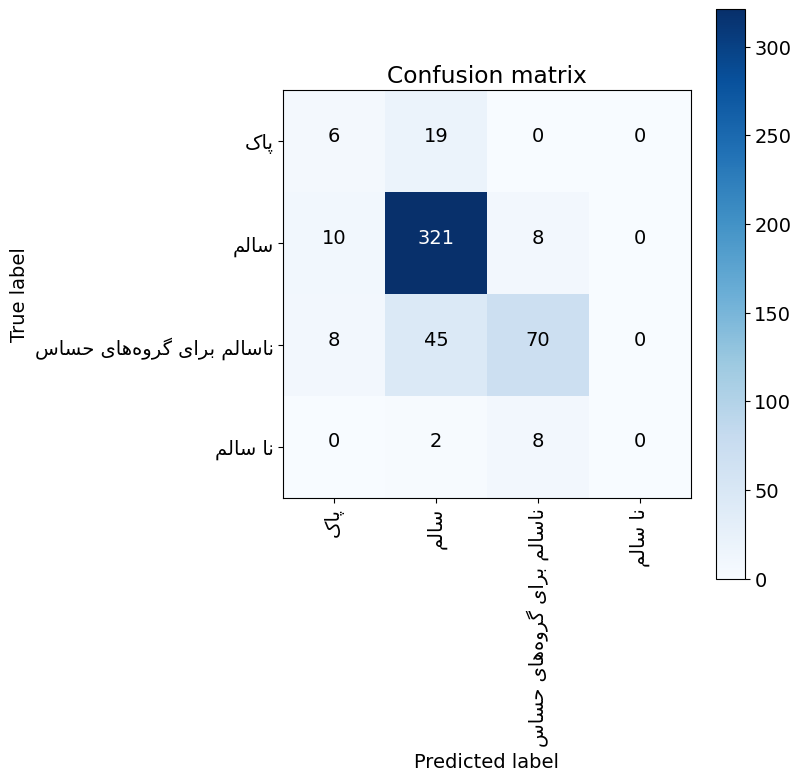

In [114]:
cnf_matrix = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

labels = [aqi_to_name(ix) for ix in classes_id]
labels = [get_display(reshape(label)) for label in labels]

plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=labels ,normalize= False,  title='Confusion matrix')
plt.savefig("./plots/mlp/mlp_confusion_matrix.png")

> ### Different Metrics

In [115]:
report["mlp"] = classification_report(Y_test, Y_pred, output_dict=True)
report["mlp"]["str"] = classification_report(Y_test, Y_pred)

print (report["mlp"]["str"])

              precision    recall  f1-score   support

           1       0.25      0.24      0.24        25
           2       0.83      0.95      0.88       339
           3       0.81      0.57      0.67       123
           4       0.00      0.00      0.00        10

    accuracy                           0.80       497
   macro avg       0.47      0.44      0.45       497
weighted avg       0.78      0.80      0.78       497



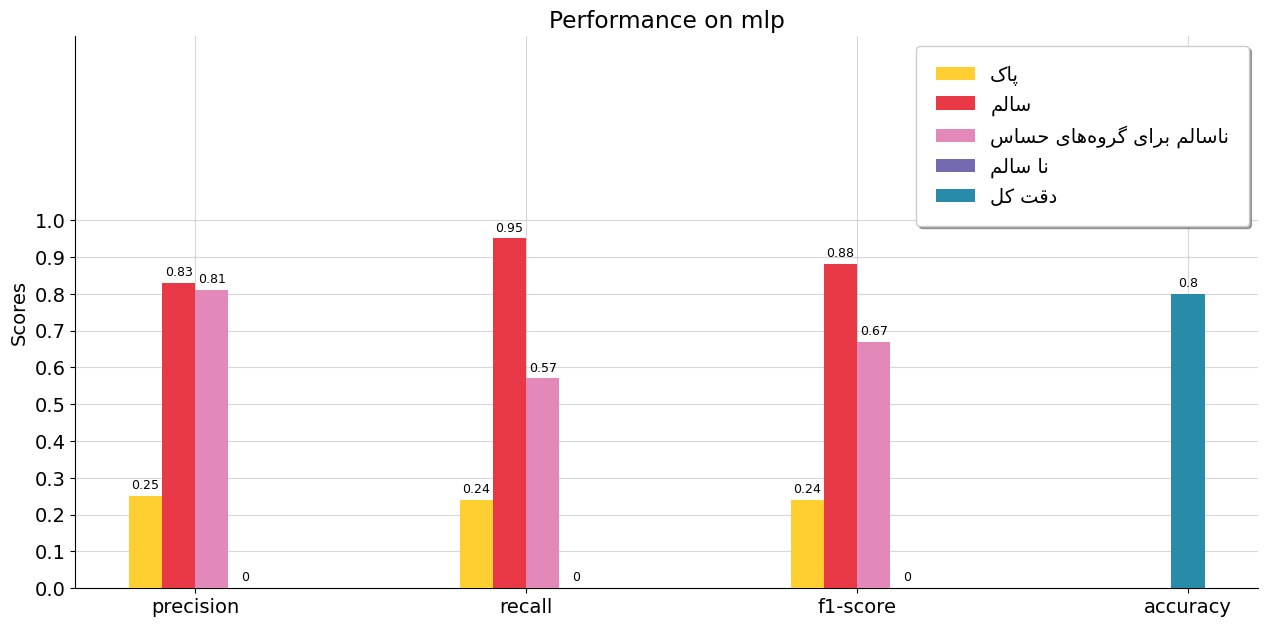

In [116]:
performance_barchar(report, "mlp")

plt.savefig("./plots/mlp/performance_on_mlp.png")
plt.show()

> ### Cross-Validation

In [117]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing


mlp_clf = make_pipeline(
                            preprocessing.StandardScaler(), 
                            MLPClassifier(
                                            activation='logistic', 
                                            solver='adam',
                                            hidden_layer_sizes=(100,), 
                                            learning_rate='adaptive',
                                            learning_rate_init=1e-5, 
                                            verbose=True, 
                                            max_iter=10000,
                                            tol=1e-8
                                            ).fit(X_train, Y_train)
                        )

accs = cross_validate(mlp_clf, X, Y, cv=4, scoring=["accuracy"])["test_accuracy"]

mean = np.mean(accs)
std = np.std(accs) / np.sqrt(np.shape(accs)[0])

print("Confidence interval for accuracy of MLP Classifier with confidence level 95% is: [{:.2f} , {:.2f}]".format(mean-1.96*std, mean+1.96*std))



Iteration 1, loss = 1.95392624
Iteration 2, loss = 1.94171022
Iteration 3, loss = 1.92958530
Iteration 4, loss = 1.91752233
Iteration 5, loss = 1.90553004
Iteration 6, loss = 1.89361448
Iteration 7, loss = 1.88174076
Iteration 8, loss = 1.87002686
Iteration 9, loss = 1.85827588
Iteration 10, loss = 1.84671783
Iteration 11, loss = 1.83518797
Iteration 12, loss = 1.82373617
Iteration 13, loss = 1.81240370
Iteration 14, loss = 1.80111884
Iteration 15, loss = 1.78983176
Iteration 16, loss = 1.77877912
Iteration 17, loss = 1.76769179
Iteration 18, loss = 1.75672233
Iteration 19, loss = 1.74582503
Iteration 20, loss = 1.73497914
Iteration 21, loss = 1.72422144
Iteration 22, loss = 1.71363751
Iteration 23, loss = 1.70295828
Iteration 24, loss = 1.69247110
Iteration 25, loss = 1.68206569
Iteration 26, loss = 1.67164495
Iteration 27, loss = 1.66136723
Iteration 28, loss = 1.65117700
Iteration 29, loss = 1.64098824
Iteration 30, loss = 1.63100738
Iteration 31, loss = 1.62099128
Iteration 32, los

Iteration 279, loss = 0.78860468
Iteration 280, loss = 0.78813659
Iteration 281, loss = 0.78768184
Iteration 282, loss = 0.78721193
Iteration 283, loss = 0.78676307
Iteration 284, loss = 0.78630175
Iteration 285, loss = 0.78584559
Iteration 286, loss = 0.78540270
Iteration 287, loss = 0.78495788
Iteration 288, loss = 0.78452990
Iteration 289, loss = 0.78408095
Iteration 290, loss = 0.78364248
Iteration 291, loss = 0.78321555
Iteration 292, loss = 0.78278241
Iteration 293, loss = 0.78236188
Iteration 294, loss = 0.78194531
Iteration 295, loss = 0.78153415
Iteration 296, loss = 0.78111244
Iteration 297, loss = 0.78068637
Iteration 298, loss = 0.78029309
Iteration 299, loss = 0.77988808
Iteration 300, loss = 0.77947653
Iteration 301, loss = 0.77908588
Iteration 302, loss = 0.77868249
Iteration 303, loss = 0.77829493
Iteration 304, loss = 0.77789400
Iteration 305, loss = 0.77749896
Iteration 306, loss = 0.77712906
Iteration 307, loss = 0.77672898
Iteration 308, loss = 0.77635489
Iteration 

Iteration 551, loss = 0.71266117
Iteration 552, loss = 0.71248982
Iteration 553, loss = 0.71233086
Iteration 554, loss = 0.71215894
Iteration 555, loss = 0.71198519
Iteration 556, loss = 0.71181671
Iteration 557, loss = 0.71165880
Iteration 558, loss = 0.71148716
Iteration 559, loss = 0.71131468
Iteration 560, loss = 0.71115795
Iteration 561, loss = 0.71099097
Iteration 562, loss = 0.71086175
Iteration 563, loss = 0.71066300
Iteration 564, loss = 0.71050818
Iteration 565, loss = 0.71035177
Iteration 566, loss = 0.71019890
Iteration 567, loss = 0.71002837
Iteration 568, loss = 0.70987966
Iteration 569, loss = 0.70971432
Iteration 570, loss = 0.70956443
Iteration 571, loss = 0.70940617
Iteration 572, loss = 0.70925660
Iteration 573, loss = 0.70908899
Iteration 574, loss = 0.70894074
Iteration 575, loss = 0.70878408
Iteration 576, loss = 0.70862669
Iteration 577, loss = 0.70847817
Iteration 578, loss = 0.70832446
Iteration 579, loss = 0.70818350
Iteration 580, loss = 0.70802445
Iteration 

Iteration 818, loss = 0.67893957
Iteration 819, loss = 0.67885349
Iteration 820, loss = 0.67873864
Iteration 821, loss = 0.67864274
Iteration 822, loss = 0.67853260
Iteration 823, loss = 0.67843686
Iteration 824, loss = 0.67832988
Iteration 825, loss = 0.67821160
Iteration 826, loss = 0.67810802
Iteration 827, loss = 0.67801033
Iteration 828, loss = 0.67790562
Iteration 829, loss = 0.67781552
Iteration 830, loss = 0.67769701
Iteration 831, loss = 0.67759788
Iteration 832, loss = 0.67751330
Iteration 833, loss = 0.67739312
Iteration 834, loss = 0.67729642
Iteration 835, loss = 0.67718913
Iteration 836, loss = 0.67708334
Iteration 837, loss = 0.67698329
Iteration 838, loss = 0.67688478
Iteration 839, loss = 0.67677812
Iteration 840, loss = 0.67669252
Iteration 841, loss = 0.67657006
Iteration 842, loss = 0.67647591
Iteration 843, loss = 0.67637711
Iteration 844, loss = 0.67627128
Iteration 845, loss = 0.67617434
Iteration 846, loss = 0.67606589
Iteration 847, loss = 0.67597919
Iteration 

Iteration 1076, loss = 0.65539158
Iteration 1077, loss = 0.65533005
Iteration 1078, loss = 0.65523576
Iteration 1079, loss = 0.65516468
Iteration 1080, loss = 0.65508190
Iteration 1081, loss = 0.65500540
Iteration 1082, loss = 0.65493093
Iteration 1083, loss = 0.65484765
Iteration 1084, loss = 0.65476930
Iteration 1085, loss = 0.65468598
Iteration 1086, loss = 0.65462124
Iteration 1087, loss = 0.65454086
Iteration 1088, loss = 0.65445731
Iteration 1089, loss = 0.65440331
Iteration 1090, loss = 0.65429335
Iteration 1091, loss = 0.65421549
Iteration 1092, loss = 0.65414547
Iteration 1093, loss = 0.65405754
Iteration 1094, loss = 0.65398968
Iteration 1095, loss = 0.65393131
Iteration 1096, loss = 0.65382595
Iteration 1097, loss = 0.65375049
Iteration 1098, loss = 0.65368156
Iteration 1099, loss = 0.65361626
Iteration 1100, loss = 0.65352079
Iteration 1101, loss = 0.65344234
Iteration 1102, loss = 0.65337212
Iteration 1103, loss = 0.65329934
Iteration 1104, loss = 0.65321040
Iteration 1105

Iteration 1322, loss = 0.63852780
Iteration 1323, loss = 0.63847271
Iteration 1324, loss = 0.63840237
Iteration 1325, loss = 0.63834507
Iteration 1326, loss = 0.63829864
Iteration 1327, loss = 0.63822407
Iteration 1328, loss = 0.63817055
Iteration 1329, loss = 0.63811804
Iteration 1330, loss = 0.63804626
Iteration 1331, loss = 0.63800320
Iteration 1332, loss = 0.63793630
Iteration 1333, loss = 0.63787071
Iteration 1334, loss = 0.63781721
Iteration 1335, loss = 0.63775386
Iteration 1336, loss = 0.63769463
Iteration 1337, loss = 0.63764088
Iteration 1338, loss = 0.63758477
Iteration 1339, loss = 0.63753349
Iteration 1340, loss = 0.63746702
Iteration 1341, loss = 0.63740439
Iteration 1342, loss = 0.63735060
Iteration 1343, loss = 0.63728837
Iteration 1344, loss = 0.63724212
Iteration 1345, loss = 0.63718058
Iteration 1346, loss = 0.63711797
Iteration 1347, loss = 0.63706577
Iteration 1348, loss = 0.63706403
Iteration 1349, loss = 0.63695956
Iteration 1350, loss = 0.63688413
Iteration 1351

Iteration 1565, loss = 0.62594327
Iteration 1566, loss = 0.62590175
Iteration 1567, loss = 0.62584638
Iteration 1568, loss = 0.62581837
Iteration 1569, loss = 0.62576132
Iteration 1570, loss = 0.62572572
Iteration 1571, loss = 0.62570417
Iteration 1572, loss = 0.62562414
Iteration 1573, loss = 0.62558598
Iteration 1574, loss = 0.62554842
Iteration 1575, loss = 0.62550010
Iteration 1576, loss = 0.62545378
Iteration 1577, loss = 0.62542638
Iteration 1578, loss = 0.62536521
Iteration 1579, loss = 0.62532154
Iteration 1580, loss = 0.62530052
Iteration 1581, loss = 0.62527130
Iteration 1582, loss = 0.62519110
Iteration 1583, loss = 0.62515093
Iteration 1584, loss = 0.62511297
Iteration 1585, loss = 0.62509658
Iteration 1586, loss = 0.62501752
Iteration 1587, loss = 0.62499863
Iteration 1588, loss = 0.62495271
Iteration 1589, loss = 0.62489581
Iteration 1590, loss = 0.62486375
Iteration 1591, loss = 0.62481557
Iteration 1592, loss = 0.62478287
Iteration 1593, loss = 0.62472136
Iteration 1594

Iteration 1812, loss = 0.61674646
Iteration 1813, loss = 0.61671731
Iteration 1814, loss = 0.61669536
Iteration 1815, loss = 0.61665817
Iteration 1816, loss = 0.61661833
Iteration 1817, loss = 0.61659084
Iteration 1818, loss = 0.61657735
Iteration 1819, loss = 0.61652989
Iteration 1820, loss = 0.61652481
Iteration 1821, loss = 0.61647007
Iteration 1822, loss = 0.61643815
Iteration 1823, loss = 0.61640004
Iteration 1824, loss = 0.61638513
Iteration 1825, loss = 0.61633958
Iteration 1826, loss = 0.61630776
Iteration 1827, loss = 0.61628877
Iteration 1828, loss = 0.61625951
Iteration 1829, loss = 0.61622259
Iteration 1830, loss = 0.61618311
Iteration 1831, loss = 0.61615377
Iteration 1832, loss = 0.61612062
Iteration 1833, loss = 0.61608937
Iteration 1834, loss = 0.61606082
Iteration 1835, loss = 0.61602333
Iteration 1836, loss = 0.61600294
Iteration 1837, loss = 0.61596466
Iteration 1838, loss = 0.61593794
Iteration 1839, loss = 0.61591617
Iteration 1840, loss = 0.61587680
Iteration 1841

Iteration 2056, loss = 0.60994834
Iteration 2057, loss = 0.60992872
Iteration 2058, loss = 0.60989740
Iteration 2059, loss = 0.60986319
Iteration 2060, loss = 0.60986189
Iteration 2061, loss = 0.60982057
Iteration 2062, loss = 0.60980295
Iteration 2063, loss = 0.60976753
Iteration 2064, loss = 0.60974394
Iteration 2065, loss = 0.60971408
Iteration 2066, loss = 0.60969643
Iteration 2067, loss = 0.60967213
Iteration 2068, loss = 0.60965538
Iteration 2069, loss = 0.60962093
Iteration 2070, loss = 0.60960141
Iteration 2071, loss = 0.60960819
Iteration 2072, loss = 0.60955510
Iteration 2073, loss = 0.60953066
Iteration 2074, loss = 0.60954214
Iteration 2075, loss = 0.60949542
Iteration 2076, loss = 0.60947995
Iteration 2077, loss = 0.60942713
Iteration 2078, loss = 0.60941072
Iteration 2079, loss = 0.60937241
Iteration 2080, loss = 0.60936288
Iteration 2081, loss = 0.60932633
Iteration 2082, loss = 0.60930654
Iteration 2083, loss = 0.60930531
Iteration 2084, loss = 0.60924949
Iteration 2085

Iteration 2326, loss = 0.60392534
Iteration 2327, loss = 0.60390173
Iteration 2328, loss = 0.60388828
Iteration 2329, loss = 0.60386142
Iteration 2330, loss = 0.60385536
Iteration 2331, loss = 0.60383797
Iteration 2332, loss = 0.60380710
Iteration 2333, loss = 0.60378906
Iteration 2334, loss = 0.60375652
Iteration 2335, loss = 0.60374983
Iteration 2336, loss = 0.60372386
Iteration 2337, loss = 0.60369806
Iteration 2338, loss = 0.60367742
Iteration 2339, loss = 0.60367306
Iteration 2340, loss = 0.60364236
Iteration 2341, loss = 0.60363756
Iteration 2342, loss = 0.60360852
Iteration 2343, loss = 0.60359183
Iteration 2344, loss = 0.60357459
Iteration 2345, loss = 0.60354620
Iteration 2346, loss = 0.60352871
Iteration 2347, loss = 0.60351068
Iteration 2348, loss = 0.60348500
Iteration 2349, loss = 0.60348218
Iteration 2350, loss = 0.60344930
Iteration 2351, loss = 0.60344702
Iteration 2352, loss = 0.60341488
Iteration 2353, loss = 0.60339800
Iteration 2354, loss = 0.60336274
Iteration 2355

Iteration 2570, loss = 0.59932448
Iteration 2571, loss = 0.59929658
Iteration 2572, loss = 0.59929217
Iteration 2573, loss = 0.59926454
Iteration 2574, loss = 0.59924770
Iteration 2575, loss = 0.59922898
Iteration 2576, loss = 0.59921086
Iteration 2577, loss = 0.59919997
Iteration 2578, loss = 0.59917153
Iteration 2579, loss = 0.59916076
Iteration 2580, loss = 0.59914081
Iteration 2581, loss = 0.59913808
Iteration 2582, loss = 0.59910028
Iteration 2583, loss = 0.59909055
Iteration 2584, loss = 0.59906990
Iteration 2585, loss = 0.59905750
Iteration 2586, loss = 0.59903301
Iteration 2587, loss = 0.59901518
Iteration 2588, loss = 0.59902481
Iteration 2589, loss = 0.59897732
Iteration 2590, loss = 0.59896703
Iteration 2591, loss = 0.59898008
Iteration 2592, loss = 0.59893154
Iteration 2593, loss = 0.59891654
Iteration 2594, loss = 0.59889910
Iteration 2595, loss = 0.59889534
Iteration 2596, loss = 0.59889086
Iteration 2597, loss = 0.59885951
Iteration 2598, loss = 0.59883130
Iteration 2599

Iteration 2840, loss = 0.59486257
Iteration 2841, loss = 0.59483735
Iteration 2842, loss = 0.59483663
Iteration 2843, loss = 0.59481853
Iteration 2844, loss = 0.59479738
Iteration 2845, loss = 0.59479848
Iteration 2846, loss = 0.59476153
Iteration 2847, loss = 0.59475374
Iteration 2848, loss = 0.59473569
Iteration 2849, loss = 0.59471969
Iteration 2850, loss = 0.59470012
Iteration 2851, loss = 0.59469566
Iteration 2852, loss = 0.59467948
Iteration 2853, loss = 0.59466031
Iteration 2854, loss = 0.59464613
Iteration 2855, loss = 0.59463337
Iteration 2856, loss = 0.59460970
Iteration 2857, loss = 0.59459631
Iteration 2858, loss = 0.59462238
Iteration 2859, loss = 0.59456720
Iteration 2860, loss = 0.59455098
Iteration 2861, loss = 0.59454209
Iteration 2862, loss = 0.59452987
Iteration 2863, loss = 0.59450460
Iteration 2864, loss = 0.59449785
Iteration 2865, loss = 0.59449083
Iteration 2866, loss = 0.59446903
Iteration 2867, loss = 0.59444601
Iteration 2868, loss = 0.59443175
Iteration 2869

Iteration 3105, loss = 0.59100528
Iteration 3106, loss = 0.59097739
Iteration 3107, loss = 0.59097390
Iteration 3108, loss = 0.59097569
Iteration 3109, loss = 0.59093004
Iteration 3110, loss = 0.59091580
Iteration 3111, loss = 0.59091437
Iteration 3112, loss = 0.59090664
Iteration 3113, loss = 0.59090167
Iteration 3114, loss = 0.59086964
Iteration 3115, loss = 0.59085777
Iteration 3116, loss = 0.59084177
Iteration 3117, loss = 0.59084226
Iteration 3118, loss = 0.59081286
Iteration 3119, loss = 0.59079888
Iteration 3120, loss = 0.59079923
Iteration 3121, loss = 0.59077376
Iteration 3122, loss = 0.59076048
Iteration 3123, loss = 0.59074686
Iteration 3124, loss = 0.59074236
Iteration 3125, loss = 0.59071188
Iteration 3126, loss = 0.59073050
Iteration 3127, loss = 0.59069828
Iteration 3128, loss = 0.59068232
Iteration 3129, loss = 0.59066636
Iteration 3130, loss = 0.59068808
Iteration 3131, loss = 0.59064073
Iteration 3132, loss = 0.59063221
Iteration 3133, loss = 0.59062137
Iteration 3134

Iteration 3361, loss = 0.58763669
Iteration 3362, loss = 0.58759862
Iteration 3363, loss = 0.58761357
Iteration 3364, loss = 0.58757492
Iteration 3365, loss = 0.58758434
Iteration 3366, loss = 0.58755141
Iteration 3367, loss = 0.58754201
Iteration 3368, loss = 0.58752736
Iteration 3369, loss = 0.58751395
Iteration 3370, loss = 0.58750407
Iteration 3371, loss = 0.58749303
Iteration 3372, loss = 0.58747489
Iteration 3373, loss = 0.58747680
Iteration 3374, loss = 0.58745312
Iteration 3375, loss = 0.58744500
Iteration 3376, loss = 0.58742718
Iteration 3377, loss = 0.58741634
Iteration 3378, loss = 0.58740662
Iteration 3379, loss = 0.58742056
Iteration 3380, loss = 0.58737759
Iteration 3381, loss = 0.58738308
Iteration 3382, loss = 0.58736110
Iteration 3383, loss = 0.58736900
Iteration 3384, loss = 0.58733206
Iteration 3385, loss = 0.58732892
Iteration 3386, loss = 0.58729521
Iteration 3387, loss = 0.58730833
Iteration 3388, loss = 0.58727842
Iteration 3389, loss = 0.58726307
Iteration 3390

Iteration 3622, loss = 0.58443198
Iteration 3623, loss = 0.58441628
Iteration 3624, loss = 0.58440050
Iteration 3625, loss = 0.58439481
Iteration 3626, loss = 0.58439054
Iteration 3627, loss = 0.58435983
Iteration 3628, loss = 0.58435088
Iteration 3629, loss = 0.58433994
Iteration 3630, loss = 0.58434012
Iteration 3631, loss = 0.58431882
Iteration 3632, loss = 0.58431478
Iteration 3633, loss = 0.58429954
Iteration 3634, loss = 0.58430260
Iteration 3635, loss = 0.58426102
Iteration 3636, loss = 0.58425865
Iteration 3637, loss = 0.58423484
Iteration 3638, loss = 0.58424686
Iteration 3639, loss = 0.58421870
Iteration 3640, loss = 0.58420292
Iteration 3641, loss = 0.58419479
Iteration 3642, loss = 0.58419448
Iteration 3643, loss = 0.58420305
Iteration 3644, loss = 0.58416164
Iteration 3645, loss = 0.58419824
Iteration 3646, loss = 0.58416523
Iteration 3647, loss = 0.58414821
Iteration 3648, loss = 0.58414995
Iteration 3649, loss = 0.58409318
Iteration 3650, loss = 0.58412621
Iteration 3651

Iteration 3874, loss = 0.58146341
Iteration 3875, loss = 0.58145876
Iteration 3876, loss = 0.58145008
Iteration 3877, loss = 0.58145781
Iteration 3878, loss = 0.58141163
Iteration 3879, loss = 0.58141535
Iteration 3880, loss = 0.58147218
Iteration 3881, loss = 0.58139711
Iteration 3882, loss = 0.58142579
Iteration 3883, loss = 0.58137199
Iteration 3884, loss = 0.58138032
Iteration 3885, loss = 0.58134217
Iteration 3886, loss = 0.58134557
Iteration 3887, loss = 0.58132401
Iteration 3888, loss = 0.58131777
Iteration 3889, loss = 0.58130721
Iteration 3890, loss = 0.58131280
Iteration 3891, loss = 0.58127158
Iteration 3892, loss = 0.58127476
Iteration 3893, loss = 0.58124973
Iteration 3894, loss = 0.58124172
Iteration 3895, loss = 0.58123121
Iteration 3896, loss = 0.58121690
Iteration 3897, loss = 0.58120866
Iteration 3898, loss = 0.58119266
Iteration 3899, loss = 0.58118951
Iteration 3900, loss = 0.58116441
Iteration 3901, loss = 0.58116431
Iteration 3902, loss = 0.58114733
Iteration 3903

Iteration 4122, loss = 0.57866670
Iteration 4123, loss = 0.57866693
Iteration 4124, loss = 0.57865272
Iteration 4125, loss = 0.57865898
Iteration 4126, loss = 0.57863180
Iteration 4127, loss = 0.57862453
Iteration 4128, loss = 0.57860661
Iteration 4129, loss = 0.57860342
Iteration 4130, loss = 0.57857257
Iteration 4131, loss = 0.57857367
Iteration 4132, loss = 0.57855763
Iteration 4133, loss = 0.57856553
Iteration 4134, loss = 0.57854356
Iteration 4135, loss = 0.57853458
Iteration 4136, loss = 0.57850838
Iteration 4137, loss = 0.57850572
Iteration 4138, loss = 0.57849402
Iteration 4139, loss = 0.57848056
Iteration 4140, loss = 0.57847566
Iteration 4141, loss = 0.57846816
Iteration 4142, loss = 0.57844917
Iteration 4143, loss = 0.57843903
Iteration 4144, loss = 0.57844436
Iteration 4145, loss = 0.57841700
Iteration 4146, loss = 0.57839104
Iteration 4147, loss = 0.57840696
Iteration 4148, loss = 0.57837544
Iteration 4149, loss = 0.57836392
Iteration 4150, loss = 0.57834839
Iteration 4151

Iteration 4381, loss = 0.57589611
Iteration 4382, loss = 0.57590611
Iteration 4383, loss = 0.57593846
Iteration 4384, loss = 0.57589527
Iteration 4385, loss = 0.57585764
Iteration 4386, loss = 0.57585081
Iteration 4387, loss = 0.57584558
Iteration 4388, loss = 0.57584368
Iteration 4389, loss = 0.57582391
Iteration 4390, loss = 0.57581031
Iteration 4391, loss = 0.57581295
Iteration 4392, loss = 0.57579796
Iteration 4393, loss = 0.57579440
Iteration 4394, loss = 0.57576803
Iteration 4395, loss = 0.57577481
Iteration 4396, loss = 0.57574900
Iteration 4397, loss = 0.57577300
Iteration 4398, loss = 0.57575791
Iteration 4399, loss = 0.57571575
Iteration 4400, loss = 0.57571407
Iteration 4401, loss = 0.57570743
Iteration 4402, loss = 0.57568326
Iteration 4403, loss = 0.57566655
Iteration 4404, loss = 0.57568571
Iteration 4405, loss = 0.57566056
Iteration 4406, loss = 0.57565055
Iteration 4407, loss = 0.57563958
Iteration 4408, loss = 0.57564021
Iteration 4409, loss = 0.57562154
Iteration 4410

Iteration 4640, loss = 0.57331470
Iteration 4641, loss = 0.57330763
Iteration 4642, loss = 0.57330550
Iteration 4643, loss = 0.57330689
Iteration 4644, loss = 0.57326838
Iteration 4645, loss = 0.57327562
Iteration 4646, loss = 0.57327023
Iteration 4647, loss = 0.57324683
Iteration 4648, loss = 0.57323226
Iteration 4649, loss = 0.57322983
Iteration 4650, loss = 0.57321851
Iteration 4651, loss = 0.57320743
Iteration 4652, loss = 0.57320589
Iteration 4653, loss = 0.57318913
Iteration 4654, loss = 0.57319545
Iteration 4655, loss = 0.57316152
Iteration 4656, loss = 0.57319670
Iteration 4657, loss = 0.57314547
Iteration 4658, loss = 0.57315566
Iteration 4659, loss = 0.57313427
Iteration 4660, loss = 0.57312641
Iteration 4661, loss = 0.57311263
Iteration 4662, loss = 0.57308988
Iteration 4663, loss = 0.57312693
Iteration 4664, loss = 0.57309178
Iteration 4665, loss = 0.57311249
Iteration 4666, loss = 0.57312621
Iteration 4667, loss = 0.57304680
Iteration 4668, loss = 0.57307529
Iteration 4669

Iteration 4897, loss = 0.57088169
Iteration 4898, loss = 0.57090446
Iteration 4899, loss = 0.57093119
Iteration 4900, loss = 0.57086227
Iteration 4901, loss = 0.57084613
Iteration 4902, loss = 0.57085331
Iteration 4903, loss = 0.57082757
Iteration 4904, loss = 0.57081915
Iteration 4905, loss = 0.57080943
Iteration 4906, loss = 0.57081954
Iteration 4907, loss = 0.57079103
Iteration 4908, loss = 0.57078391
Iteration 4909, loss = 0.57077687
Iteration 4910, loss = 0.57076977
Iteration 4911, loss = 0.57076991
Iteration 4912, loss = 0.57075360
Iteration 4913, loss = 0.57075461
Iteration 4914, loss = 0.57073510
Iteration 4915, loss = 0.57073678
Iteration 4916, loss = 0.57070116
Iteration 4917, loss = 0.57070887
Iteration 4918, loss = 0.57069426
Iteration 4919, loss = 0.57068255
Iteration 4920, loss = 0.57067648
Iteration 4921, loss = 0.57071326
Iteration 4922, loss = 0.57065063
Iteration 4923, loss = 0.57065225
Iteration 4924, loss = 0.57062639
Iteration 4925, loss = 0.57063515
Iteration 4926

Iteration 5145, loss = 0.56869277
Iteration 5146, loss = 0.56865226
Iteration 5147, loss = 0.56862532
Iteration 5148, loss = 0.56862429
Iteration 5149, loss = 0.56861657
Iteration 5150, loss = 0.56860486
Iteration 5151, loss = 0.56860545
Iteration 5152, loss = 0.56857880
Iteration 5153, loss = 0.56858261
Iteration 5154, loss = 0.56856418
Iteration 5155, loss = 0.56858069
Iteration 5156, loss = 0.56854550
Iteration 5157, loss = 0.56855115
Iteration 5158, loss = 0.56854039
Iteration 5159, loss = 0.56851916
Iteration 5160, loss = 0.56851367
Iteration 5161, loss = 0.56850630
Iteration 5162, loss = 0.56849818
Iteration 5163, loss = 0.56848256
Iteration 5164, loss = 0.56848516
Iteration 5165, loss = 0.56850816
Iteration 5166, loss = 0.56848643
Iteration 5167, loss = 0.56845940
Iteration 5168, loss = 0.56843820
Iteration 5169, loss = 0.56843373
Iteration 5170, loss = 0.56842976
Iteration 5171, loss = 0.56842809
Iteration 5172, loss = 0.56841470
Iteration 5173, loss = 0.56841359
Iteration 5174

Iteration 5396, loss = 0.56649111
Iteration 5397, loss = 0.56648121
Iteration 5398, loss = 0.56647285
Iteration 5399, loss = 0.56645606
Iteration 5400, loss = 0.56645124
Iteration 5401, loss = 0.56646027
Iteration 5402, loss = 0.56643084
Iteration 5403, loss = 0.56644414
Iteration 5404, loss = 0.56642018
Iteration 5405, loss = 0.56641388
Iteration 5406, loss = 0.56639767
Iteration 5407, loss = 0.56640328
Iteration 5408, loss = 0.56639377
Iteration 5409, loss = 0.56637114
Iteration 5410, loss = 0.56636774
Iteration 5411, loss = 0.56637467
Iteration 5412, loss = 0.56636800
Iteration 5413, loss = 0.56633872
Iteration 5414, loss = 0.56633018
Iteration 5415, loss = 0.56632054
Iteration 5416, loss = 0.56633081
Iteration 5417, loss = 0.56632460
Iteration 5418, loss = 0.56629181
Iteration 5419, loss = 0.56630783
Iteration 5420, loss = 0.56627949
Iteration 5421, loss = 0.56626832
Iteration 5422, loss = 0.56627749
Iteration 5423, loss = 0.56628082
Iteration 5424, loss = 0.56627355
Iteration 5425

Iteration 5648, loss = 0.56439816
Iteration 5649, loss = 0.56438744
Iteration 5650, loss = 0.56438461
Iteration 5651, loss = 0.56436456
Iteration 5652, loss = 0.56436583
Iteration 5653, loss = 0.56436219
Iteration 5654, loss = 0.56434139
Iteration 5655, loss = 0.56432687
Iteration 5656, loss = 0.56432153
Iteration 5657, loss = 0.56431161
Iteration 5658, loss = 0.56430963
Iteration 5659, loss = 0.56430772
Iteration 5660, loss = 0.56429092
Iteration 5661, loss = 0.56428989
Iteration 5662, loss = 0.56426692
Iteration 5663, loss = 0.56427222
Iteration 5664, loss = 0.56427109
Iteration 5665, loss = 0.56425608
Iteration 5666, loss = 0.56424783
Iteration 5667, loss = 0.56424770
Iteration 5668, loss = 0.56422047
Iteration 5669, loss = 0.56420968
Iteration 5670, loss = 0.56421580
Iteration 5671, loss = 0.56419363
Iteration 5672, loss = 0.56420549
Iteration 5673, loss = 0.56418943
Iteration 5674, loss = 0.56417783
Iteration 5675, loss = 0.56418869
Iteration 5676, loss = 0.56414909
Iteration 5677

Iteration 5902, loss = 0.56234274
Iteration 5903, loss = 0.56232328
Iteration 5904, loss = 0.56236400
Iteration 5905, loss = 0.56230036
Iteration 5906, loss = 0.56229112
Iteration 5907, loss = 0.56229155
Iteration 5908, loss = 0.56228426
Iteration 5909, loss = 0.56229634
Iteration 5910, loss = 0.56227602
Iteration 5911, loss = 0.56225997
Iteration 5912, loss = 0.56225099
Iteration 5913, loss = 0.56224886
Iteration 5914, loss = 0.56223392
Iteration 5915, loss = 0.56223371
Iteration 5916, loss = 0.56222174
Iteration 5917, loss = 0.56220938
Iteration 5918, loss = 0.56220489
Iteration 5919, loss = 0.56221819
Iteration 5920, loss = 0.56218505
Iteration 5921, loss = 0.56220103
Iteration 5922, loss = 0.56217769
Iteration 5923, loss = 0.56216932
Iteration 5924, loss = 0.56216291
Iteration 5925, loss = 0.56215703
Iteration 5926, loss = 0.56213654
Iteration 5927, loss = 0.56213554
Iteration 5928, loss = 0.56212149
Iteration 5929, loss = 0.56213945
Iteration 5930, loss = 0.56212158
Iteration 5931

Iteration 6150, loss = 0.56046511
Iteration 6151, loss = 0.56045153
Iteration 6152, loss = 0.56045185
Iteration 6153, loss = 0.56045183
Iteration 6154, loss = 0.56043490
Iteration 6155, loss = 0.56042673
Iteration 6156, loss = 0.56041853
Iteration 6157, loss = 0.56041778
Iteration 6158, loss = 0.56039799
Iteration 6159, loss = 0.56041038
Iteration 6160, loss = 0.56038432
Iteration 6161, loss = 0.56037642
Iteration 6162, loss = 0.56037048
Iteration 6163, loss = 0.56036086
Iteration 6164, loss = 0.56035969
Iteration 6165, loss = 0.56035430
Iteration 6166, loss = 0.56035080
Iteration 6167, loss = 0.56034515
Iteration 6168, loss = 0.56035317
Iteration 6169, loss = 0.56032176
Iteration 6170, loss = 0.56030491
Iteration 6171, loss = 0.56030667
Iteration 6172, loss = 0.56029643
Iteration 6173, loss = 0.56032136
Iteration 6174, loss = 0.56028386
Iteration 6175, loss = 0.56027505
Iteration 6176, loss = 0.56027940
Iteration 6177, loss = 0.56026094
Iteration 6178, loss = 0.56026634
Iteration 6179

Iteration 6392, loss = 0.55872648
Iteration 6393, loss = 0.55870766
Iteration 6394, loss = 0.55869782
Iteration 6395, loss = 0.55870330
Iteration 6396, loss = 0.55867858
Iteration 6397, loss = 0.55869500
Iteration 6398, loss = 0.55867573
Iteration 6399, loss = 0.55866529
Iteration 6400, loss = 0.55867911
Iteration 6401, loss = 0.55864044
Iteration 6402, loss = 0.55863906
Iteration 6403, loss = 0.55865450
Iteration 6404, loss = 0.55863636
Iteration 6405, loss = 0.55862212
Iteration 6406, loss = 0.55863373
Iteration 6407, loss = 0.55861516
Iteration 6408, loss = 0.55860126
Iteration 6409, loss = 0.55859558
Iteration 6410, loss = 0.55859825
Iteration 6411, loss = 0.55860153
Iteration 6412, loss = 0.55859717
Iteration 6413, loss = 0.55856778
Iteration 6414, loss = 0.55858596
Iteration 6415, loss = 0.55855494
Iteration 6416, loss = 0.55855999
Iteration 6417, loss = 0.55854277
Iteration 6418, loss = 0.55856562
Iteration 6419, loss = 0.55853278
Iteration 6420, loss = 0.55853030
Iteration 6421

Iteration 6654, loss = 0.55694582
Iteration 6655, loss = 0.55692152
Iteration 6656, loss = 0.55689365
Iteration 6657, loss = 0.55691170
Iteration 6658, loss = 0.55688887
Iteration 6659, loss = 0.55686531
Iteration 6660, loss = 0.55686706
Iteration 6661, loss = 0.55687783
Iteration 6662, loss = 0.55684370
Iteration 6663, loss = 0.55684710
Iteration 6664, loss = 0.55685263
Iteration 6665, loss = 0.55682979
Iteration 6666, loss = 0.55682186
Iteration 6667, loss = 0.55681767
Iteration 6668, loss = 0.55680872
Iteration 6669, loss = 0.55681091
Iteration 6670, loss = 0.55682558
Iteration 6671, loss = 0.55681725
Iteration 6672, loss = 0.55678409
Iteration 6673, loss = 0.55677586
Iteration 6674, loss = 0.55678002
Iteration 6675, loss = 0.55676650
Iteration 6676, loss = 0.55676021
Iteration 6677, loss = 0.55674225
Iteration 6678, loss = 0.55674180
Iteration 6679, loss = 0.55674630
Iteration 6680, loss = 0.55672536
Iteration 6681, loss = 0.55671898
Iteration 6682, loss = 0.55671520
Iteration 6683

Iteration 6914, loss = 0.55516950
Iteration 6915, loss = 0.55519843
Iteration 6916, loss = 0.55519791
Iteration 6917, loss = 0.55517104
Iteration 6918, loss = 0.55520380
Iteration 6919, loss = 0.55514034
Iteration 6920, loss = 0.55514036
Iteration 6921, loss = 0.55513244
Iteration 6922, loss = 0.55515361
Iteration 6923, loss = 0.55511604
Iteration 6924, loss = 0.55510816
Iteration 6925, loss = 0.55514614
Iteration 6926, loss = 0.55514767
Iteration 6927, loss = 0.55509520
Iteration 6928, loss = 0.55510298
Iteration 6929, loss = 0.55507628
Iteration 6930, loss = 0.55507447
Iteration 6931, loss = 0.55506553
Iteration 6932, loss = 0.55508765
Iteration 6933, loss = 0.55507629
Iteration 6934, loss = 0.55504922
Iteration 6935, loss = 0.55505002
Iteration 6936, loss = 0.55506722
Iteration 6937, loss = 0.55504619
Iteration 6938, loss = 0.55502324
Iteration 6939, loss = 0.55503597
Iteration 6940, loss = 0.55499991
Iteration 6941, loss = 0.55502302
Iteration 6942, loss = 0.55500093
Iteration 6943

Iteration 7178, loss = 0.55352245
Iteration 7179, loss = 0.55352027
Iteration 7180, loss = 0.55350119
Iteration 7181, loss = 0.55351333
Iteration 7182, loss = 0.55349279
Iteration 7183, loss = 0.55352378
Iteration 7184, loss = 0.55348858
Iteration 7185, loss = 0.55347972
Iteration 7186, loss = 0.55349988
Iteration 7187, loss = 0.55346418
Iteration 7188, loss = 0.55345161
Iteration 7189, loss = 0.55346910
Iteration 7190, loss = 0.55343827
Iteration 7191, loss = 0.55343861
Iteration 7192, loss = 0.55345267
Iteration 7193, loss = 0.55343214
Iteration 7194, loss = 0.55341157
Iteration 7195, loss = 0.55341030
Iteration 7196, loss = 0.55343764
Iteration 7197, loss = 0.55341521
Iteration 7198, loss = 0.55340711
Iteration 7199, loss = 0.55340342
Iteration 7200, loss = 0.55338850
Iteration 7201, loss = 0.55337130
Iteration 7202, loss = 0.55337276
Iteration 7203, loss = 0.55336818
Iteration 7204, loss = 0.55336173
Iteration 7205, loss = 0.55335200
Iteration 7206, loss = 0.55335544
Iteration 7207

Iteration 7419, loss = 0.55209734
Iteration 7420, loss = 0.55205975
Iteration 7421, loss = 0.55206125
Iteration 7422, loss = 0.55205111
Iteration 7423, loss = 0.55204261
Iteration 7424, loss = 0.55203515
Iteration 7425, loss = 0.55204254
Iteration 7426, loss = 0.55203522
Iteration 7427, loss = 0.55201242
Iteration 7428, loss = 0.55204836
Iteration 7429, loss = 0.55202855
Iteration 7430, loss = 0.55204130
Iteration 7431, loss = 0.55199959
Iteration 7432, loss = 0.55200200
Iteration 7433, loss = 0.55199649
Iteration 7434, loss = 0.55199980
Iteration 7435, loss = 0.55197372
Iteration 7436, loss = 0.55196968
Iteration 7437, loss = 0.55198470
Iteration 7438, loss = 0.55195550
Iteration 7439, loss = 0.55195137
Iteration 7440, loss = 0.55194414
Iteration 7441, loss = 0.55194883
Iteration 7442, loss = 0.55197239
Iteration 7443, loss = 0.55194511
Iteration 7444, loss = 0.55191864
Iteration 7445, loss = 0.55192305
Iteration 7446, loss = 0.55190510
Iteration 7447, loss = 0.55191385
Iteration 7448

Iteration 7686, loss = 0.55052204
Iteration 7687, loss = 0.55052639
Iteration 7688, loss = 0.55050835
Iteration 7689, loss = 0.55052113
Iteration 7690, loss = 0.55049596
Iteration 7691, loss = 0.55052144
Iteration 7692, loss = 0.55049938
Iteration 7693, loss = 0.55047921
Iteration 7694, loss = 0.55048496
Iteration 7695, loss = 0.55049645
Iteration 7696, loss = 0.55046301
Iteration 7697, loss = 0.55045409
Iteration 7698, loss = 0.55048457
Iteration 7699, loss = 0.55045202
Iteration 7700, loss = 0.55050625
Iteration 7701, loss = 0.55043450
Iteration 7702, loss = 0.55044010
Iteration 7703, loss = 0.55044952
Iteration 7704, loss = 0.55042619
Iteration 7705, loss = 0.55042704
Iteration 7706, loss = 0.55042360
Iteration 7707, loss = 0.55041409
Iteration 7708, loss = 0.55039957
Iteration 7709, loss = 0.55041807
Iteration 7710, loss = 0.55039971
Iteration 7711, loss = 0.55038328
Iteration 7712, loss = 0.55038299
Iteration 7713, loss = 0.55036714
Iteration 7714, loss = 0.55036342
Iteration 7715

Iteration 7932, loss = 0.54917147
Iteration 7933, loss = 0.54915102
Iteration 7934, loss = 0.54913335
Iteration 7935, loss = 0.54913791
Iteration 7936, loss = 0.54914702
Iteration 7937, loss = 0.54916127
Iteration 7938, loss = 0.54912018
Iteration 7939, loss = 0.54911724
Iteration 7940, loss = 0.54912605
Iteration 7941, loss = 0.54912203
Iteration 7942, loss = 0.54909420
Iteration 7943, loss = 0.54909284
Iteration 7944, loss = 0.54907553
Iteration 7945, loss = 0.54908491
Iteration 7946, loss = 0.54909706
Iteration 7947, loss = 0.54906213
Iteration 7948, loss = 0.54905996
Iteration 7949, loss = 0.54904764
Iteration 7950, loss = 0.54915005
Iteration 7951, loss = 0.54904099
Iteration 7952, loss = 0.54904033
Iteration 7953, loss = 0.54903046
Iteration 7954, loss = 0.54902563
Iteration 7955, loss = 0.54902895
Iteration 7956, loss = 0.54901295
Iteration 7957, loss = 0.54901490
Iteration 7958, loss = 0.54900724
Iteration 7959, loss = 0.54901200
Iteration 7960, loss = 0.54900217
Iteration 7961

Iteration 8177, loss = 0.54783441
Iteration 8178, loss = 0.54784363
Iteration 8179, loss = 0.54782118
Iteration 8180, loss = 0.54788999
Iteration 8181, loss = 0.54780656
Iteration 8182, loss = 0.54780313
Iteration 8183, loss = 0.54780392
Iteration 8184, loss = 0.54778724
Iteration 8185, loss = 0.54778937
Iteration 8186, loss = 0.54778584
Iteration 8187, loss = 0.54781192
Iteration 8188, loss = 0.54777602
Iteration 8189, loss = 0.54776800
Iteration 8190, loss = 0.54778928
Iteration 8191, loss = 0.54777912
Iteration 8192, loss = 0.54775243
Iteration 8193, loss = 0.54775304
Iteration 8194, loss = 0.54775688
Iteration 8195, loss = 0.54772664
Iteration 8196, loss = 0.54772380
Iteration 8197, loss = 0.54775139
Iteration 8198, loss = 0.54771415
Iteration 8199, loss = 0.54773630
Iteration 8200, loss = 0.54771155
Iteration 8201, loss = 0.54772072
Iteration 8202, loss = 0.54770743
Iteration 8203, loss = 0.54770431
Iteration 8204, loss = 0.54768315
Iteration 8205, loss = 0.54768500
Iteration 8206

Iteration 8420, loss = 0.54656199
Iteration 8421, loss = 0.54655927
Iteration 8422, loss = 0.54655803
Iteration 8423, loss = 0.54658504
Iteration 8424, loss = 0.54659122
Iteration 8425, loss = 0.54654470
Iteration 8426, loss = 0.54653790
Iteration 8427, loss = 0.54653067
Iteration 8428, loss = 0.54652789
Iteration 8429, loss = 0.54651785
Iteration 8430, loss = 0.54651526
Iteration 8431, loss = 0.54652041
Iteration 8432, loss = 0.54650431
Iteration 8433, loss = 0.54655099
Iteration 8434, loss = 0.54649131
Iteration 8435, loss = 0.54652046
Iteration 8436, loss = 0.54648943
Iteration 8437, loss = 0.54648319
Iteration 8438, loss = 0.54646784
Iteration 8439, loss = 0.54647355
Iteration 8440, loss = 0.54645661
Iteration 8441, loss = 0.54647150
Iteration 8442, loss = 0.54645717
Iteration 8443, loss = 0.54644544
Iteration 8444, loss = 0.54644692
Iteration 8445, loss = 0.54643627
Iteration 8446, loss = 0.54643544
Iteration 8447, loss = 0.54645074
Iteration 8448, loss = 0.54643027
Iteration 8449

Iteration 8661, loss = 0.54534052
Iteration 8662, loss = 0.54534249
Iteration 8663, loss = 0.54532536
Iteration 8664, loss = 0.54531844
Iteration 8665, loss = 0.54534298
Iteration 8666, loss = 0.54532290
Iteration 8667, loss = 0.54530298
Iteration 8668, loss = 0.54530477
Iteration 8669, loss = 0.54534006
Iteration 8670, loss = 0.54528555
Iteration 8671, loss = 0.54531938
Iteration 8672, loss = 0.54529180
Iteration 8673, loss = 0.54527712
Iteration 8674, loss = 0.54528779
Iteration 8675, loss = 0.54528334
Iteration 8676, loss = 0.54525711
Iteration 8677, loss = 0.54525795
Iteration 8678, loss = 0.54525231
Iteration 8679, loss = 0.54525587
Iteration 8680, loss = 0.54524803
Iteration 8681, loss = 0.54524940
Iteration 8682, loss = 0.54524624
Iteration 8683, loss = 0.54524857
Iteration 8684, loss = 0.54524807
Iteration 8685, loss = 0.54521342
Iteration 8686, loss = 0.54523945
Iteration 8687, loss = 0.54521095
Iteration 8688, loss = 0.54520723
Iteration 8689, loss = 0.54521496
Iteration 8690

Iteration 8926, loss = 0.54406536
Iteration 8927, loss = 0.54402889
Iteration 8928, loss = 0.54404164
Iteration 8929, loss = 0.54403512
Iteration 8930, loss = 0.54403175
Iteration 8931, loss = 0.54403703
Iteration 8932, loss = 0.54401508
Iteration 8933, loss = 0.54401660
Iteration 8934, loss = 0.54403271
Iteration 8935, loss = 0.54401871
Iteration 8936, loss = 0.54400512
Iteration 8937, loss = 0.54399477
Iteration 8938, loss = 0.54400986
Iteration 8939, loss = 0.54403661
Iteration 8940, loss = 0.54398616
Iteration 8941, loss = 0.54397869
Iteration 8942, loss = 0.54398759
Iteration 8943, loss = 0.54396143
Iteration 8944, loss = 0.54398644
Iteration 8945, loss = 0.54394811
Iteration 8946, loss = 0.54395431
Iteration 8947, loss = 0.54396531
Iteration 8948, loss = 0.54393558
Iteration 8949, loss = 0.54393036
Iteration 8950, loss = 0.54393539
Iteration 8951, loss = 0.54391717
Iteration 8952, loss = 0.54392574
Iteration 8953, loss = 0.54390872
Iteration 8954, loss = 0.54391575
Iteration 8955

Iteration 9186, loss = 0.54280883
Iteration 9187, loss = 0.54281990
Iteration 9188, loss = 0.54281156
Iteration 9189, loss = 0.54281324
Iteration 9190, loss = 0.54279865
Iteration 9191, loss = 0.54278072
Iteration 9192, loss = 0.54279550
Iteration 9193, loss = 0.54278621
Iteration 9194, loss = 0.54276168
Iteration 9195, loss = 0.54277842
Iteration 9196, loss = 0.54276247
Iteration 9197, loss = 0.54275437
Iteration 9198, loss = 0.54276227
Iteration 9199, loss = 0.54274931
Iteration 9200, loss = 0.54273323
Iteration 9201, loss = 0.54273664
Iteration 9202, loss = 0.54274502
Iteration 9203, loss = 0.54272535
Iteration 9204, loss = 0.54272162
Iteration 9205, loss = 0.54270643
Iteration 9206, loss = 0.54271377
Iteration 9207, loss = 0.54271236
Iteration 9208, loss = 0.54270907
Iteration 9209, loss = 0.54271788
Iteration 9210, loss = 0.54270468
Iteration 9211, loss = 0.54272247
Iteration 9212, loss = 0.54269360
Iteration 9213, loss = 0.54268047
Iteration 9214, loss = 0.54267574
Iteration 9215

Iteration 9443, loss = 0.54162933
Iteration 9444, loss = 0.54162146
Iteration 9445, loss = 0.54163735
Iteration 9446, loss = 0.54160356
Iteration 9447, loss = 0.54161422
Iteration 9448, loss = 0.54160148
Iteration 9449, loss = 0.54159314
Iteration 9450, loss = 0.54161379
Iteration 9451, loss = 0.54158266
Iteration 9452, loss = 0.54157775
Iteration 9453, loss = 0.54157357
Iteration 9454, loss = 0.54162092
Iteration 9455, loss = 0.54157246
Iteration 9456, loss = 0.54155332
Iteration 9457, loss = 0.54155119
Iteration 9458, loss = 0.54154434
Iteration 9459, loss = 0.54154483
Iteration 9460, loss = 0.54155205
Iteration 9461, loss = 0.54153929
Iteration 9462, loss = 0.54155516
Iteration 9463, loss = 0.54160611
Iteration 9464, loss = 0.54151627
Iteration 9465, loss = 0.54151453
Iteration 9466, loss = 0.54151919
Iteration 9467, loss = 0.54151710
Iteration 9468, loss = 0.54149866
Iteration 9469, loss = 0.54150984
Iteration 9470, loss = 0.54152480
Iteration 9471, loss = 0.54149877
Iteration 9472

Iteration 9702, loss = 0.54047950
Iteration 9703, loss = 0.54048072
Iteration 9704, loss = 0.54046018
Iteration 9705, loss = 0.54045208
Iteration 9706, loss = 0.54044446
Iteration 9707, loss = 0.54044508
Iteration 9708, loss = 0.54043581
Iteration 9709, loss = 0.54043012
Iteration 9710, loss = 0.54042996
Iteration 9711, loss = 0.54043021
Iteration 9712, loss = 0.54043554
Iteration 9713, loss = 0.54042571
Iteration 9714, loss = 0.54041694
Iteration 9715, loss = 0.54042107
Iteration 9716, loss = 0.54040486
Iteration 9717, loss = 0.54040234
Iteration 9718, loss = 0.54039221
Iteration 9719, loss = 0.54041568
Iteration 9720, loss = 0.54039346
Iteration 9721, loss = 0.54040404
Iteration 9722, loss = 0.54037540
Iteration 9723, loss = 0.54042082
Iteration 9724, loss = 0.54037032
Iteration 9725, loss = 0.54036868
Iteration 9726, loss = 0.54036876
Iteration 9727, loss = 0.54035263
Iteration 9728, loss = 0.54035862
Iteration 9729, loss = 0.54033886
Iteration 9730, loss = 0.54035169
Iteration 9731

Iteration 9961, loss = 0.53935712
Iteration 9962, loss = 0.53935642
Iteration 9963, loss = 0.53935513
Iteration 9964, loss = 0.53934950
Iteration 9965, loss = 0.53935151
Iteration 9966, loss = 0.53933525
Iteration 9967, loss = 0.53936537
Iteration 9968, loss = 0.53933842
Iteration 9969, loss = 0.53931903
Iteration 9970, loss = 0.53931045
Iteration 9971, loss = 0.53931551
Iteration 9972, loss = 0.53930225
Iteration 9973, loss = 0.53932972
Iteration 9974, loss = 0.53930648
Iteration 9975, loss = 0.53930248
Iteration 9976, loss = 0.53931492
Iteration 9977, loss = 0.53928083
Iteration 9978, loss = 0.53929362
Iteration 9979, loss = 0.53929330
Iteration 9980, loss = 0.53927909
Iteration 9981, loss = 0.53926625
Iteration 9982, loss = 0.53927661
Iteration 9983, loss = 0.53926153
Iteration 9984, loss = 0.53925983
Iteration 9985, loss = 0.53924473
Iteration 9986, loss = 0.53924549
Iteration 9987, loss = 0.53923658
Iteration 9988, loss = 0.53924250
Iteration 9989, loss = 0.53924316
Iteration 9990

Iteration 226, loss = 0.82439801
Iteration 227, loss = 0.82393747
Iteration 228, loss = 0.82348136
Iteration 229, loss = 0.82303110
Iteration 230, loss = 0.82259166
Iteration 231, loss = 0.82214062
Iteration 232, loss = 0.82170344
Iteration 233, loss = 0.82125984
Iteration 234, loss = 0.82081656
Iteration 235, loss = 0.82039007
Iteration 236, loss = 0.81995540
Iteration 237, loss = 0.81952122
Iteration 238, loss = 0.81910206
Iteration 239, loss = 0.81868344
Iteration 240, loss = 0.81824404
Iteration 241, loss = 0.81783837
Iteration 242, loss = 0.81742456
Iteration 243, loss = 0.81700414
Iteration 244, loss = 0.81659817
Iteration 245, loss = 0.81619630
Iteration 246, loss = 0.81577181
Iteration 247, loss = 0.81537045
Iteration 248, loss = 0.81496291
Iteration 249, loss = 0.81455895
Iteration 250, loss = 0.81415499
Iteration 251, loss = 0.81376001
Iteration 252, loss = 0.81337712
Iteration 253, loss = 0.81297486
Iteration 254, loss = 0.81259492
Iteration 255, loss = 0.81220971
Iteration 

Iteration 494, loss = 0.75544716
Iteration 495, loss = 0.75527659
Iteration 496, loss = 0.75511635
Iteration 497, loss = 0.75494418
Iteration 498, loss = 0.75477137
Iteration 499, loss = 0.75460336
Iteration 500, loss = 0.75443623
Iteration 501, loss = 0.75427321
Iteration 502, loss = 0.75409978
Iteration 503, loss = 0.75393734
Iteration 504, loss = 0.75377476
Iteration 505, loss = 0.75359670
Iteration 506, loss = 0.75342185
Iteration 507, loss = 0.75326087
Iteration 508, loss = 0.75308599
Iteration 509, loss = 0.75292161
Iteration 510, loss = 0.75275110
Iteration 511, loss = 0.75258346
Iteration 512, loss = 0.75243122
Iteration 513, loss = 0.75225408
Iteration 514, loss = 0.75208750
Iteration 515, loss = 0.75192326
Iteration 516, loss = 0.75176114
Iteration 517, loss = 0.75159284
Iteration 518, loss = 0.75143670
Iteration 519, loss = 0.75126600
Iteration 520, loss = 0.75110471
Iteration 521, loss = 0.75095351
Iteration 522, loss = 0.75078425
Iteration 523, loss = 0.75062459
Iteration 

Iteration 745, loss = 0.71879539
Iteration 746, loss = 0.71866013
Iteration 747, loss = 0.71853208
Iteration 748, loss = 0.71840773
Iteration 749, loss = 0.71827765
Iteration 750, loss = 0.71814712
Iteration 751, loss = 0.71801915
Iteration 752, loss = 0.71790305
Iteration 753, loss = 0.71776955
Iteration 754, loss = 0.71764047
Iteration 755, loss = 0.71752138
Iteration 756, loss = 0.71739430
Iteration 757, loss = 0.71726763
Iteration 758, loss = 0.71714266
Iteration 759, loss = 0.71702069
Iteration 760, loss = 0.71689472
Iteration 761, loss = 0.71677739
Iteration 762, loss = 0.71664714
Iteration 763, loss = 0.71652692
Iteration 764, loss = 0.71639931
Iteration 765, loss = 0.71627936
Iteration 766, loss = 0.71614640
Iteration 767, loss = 0.71602428
Iteration 768, loss = 0.71589760
Iteration 769, loss = 0.71577604
Iteration 770, loss = 0.71564951
Iteration 771, loss = 0.71552930
Iteration 772, loss = 0.71539750
Iteration 773, loss = 0.71527744
Iteration 774, loss = 0.71515826
Iteration 

Iteration 997, loss = 0.68969066
Iteration 998, loss = 0.68958489
Iteration 999, loss = 0.68948188
Iteration 1000, loss = 0.68937647
Iteration 1001, loss = 0.68926800
Iteration 1002, loss = 0.68916571
Iteration 1003, loss = 0.68906104
Iteration 1004, loss = 0.68895550
Iteration 1005, loss = 0.68885056
Iteration 1006, loss = 0.68874904
Iteration 1007, loss = 0.68865108
Iteration 1008, loss = 0.68853913
Iteration 1009, loss = 0.68842889
Iteration 1010, loss = 0.68832754
Iteration 1011, loss = 0.68822872
Iteration 1012, loss = 0.68812031
Iteration 1013, loss = 0.68801903
Iteration 1014, loss = 0.68791217
Iteration 1015, loss = 0.68780460
Iteration 1016, loss = 0.68769652
Iteration 1017, loss = 0.68758994
Iteration 1018, loss = 0.68749260
Iteration 1019, loss = 0.68738485
Iteration 1020, loss = 0.68727764
Iteration 1021, loss = 0.68717740
Iteration 1022, loss = 0.68707011
Iteration 1023, loss = 0.68696628
Iteration 1024, loss = 0.68685873
Iteration 1025, loss = 0.68675687
Iteration 1026, l

Iteration 1247, loss = 0.66551107
Iteration 1248, loss = 0.66543050
Iteration 1249, loss = 0.66533989
Iteration 1250, loss = 0.66526476
Iteration 1251, loss = 0.66515741
Iteration 1252, loss = 0.66508553
Iteration 1253, loss = 0.66499864
Iteration 1254, loss = 0.66490933
Iteration 1255, loss = 0.66481520
Iteration 1256, loss = 0.66472649
Iteration 1257, loss = 0.66464246
Iteration 1258, loss = 0.66455886
Iteration 1259, loss = 0.66447376
Iteration 1260, loss = 0.66438033
Iteration 1261, loss = 0.66429535
Iteration 1262, loss = 0.66420171
Iteration 1263, loss = 0.66411064
Iteration 1264, loss = 0.66402803
Iteration 1265, loss = 0.66394565
Iteration 1266, loss = 0.66385059
Iteration 1267, loss = 0.66376225
Iteration 1268, loss = 0.66368202
Iteration 1269, loss = 0.66359095
Iteration 1270, loss = 0.66350092
Iteration 1271, loss = 0.66341237
Iteration 1272, loss = 0.66332115
Iteration 1273, loss = 0.66324427
Iteration 1274, loss = 0.66315228
Iteration 1275, loss = 0.66306186
Iteration 1276

Iteration 1498, loss = 0.64497939
Iteration 1499, loss = 0.64490786
Iteration 1500, loss = 0.64483365
Iteration 1501, loss = 0.64475802
Iteration 1502, loss = 0.64468363
Iteration 1503, loss = 0.64461194
Iteration 1504, loss = 0.64453401
Iteration 1505, loss = 0.64446648
Iteration 1506, loss = 0.64439071
Iteration 1507, loss = 0.64432763
Iteration 1508, loss = 0.64424366
Iteration 1509, loss = 0.64417545
Iteration 1510, loss = 0.64411149
Iteration 1511, loss = 0.64403495
Iteration 1512, loss = 0.64395196
Iteration 1513, loss = 0.64388331
Iteration 1514, loss = 0.64381119
Iteration 1515, loss = 0.64373777
Iteration 1516, loss = 0.64367036
Iteration 1517, loss = 0.64360113
Iteration 1518, loss = 0.64351915
Iteration 1519, loss = 0.64344295
Iteration 1520, loss = 0.64336656
Iteration 1521, loss = 0.64328972
Iteration 1522, loss = 0.64322643
Iteration 1523, loss = 0.64315932
Iteration 1524, loss = 0.64307124
Iteration 1525, loss = 0.64300208
Iteration 1526, loss = 0.64292221
Iteration 1527

Iteration 1750, loss = 0.62792987
Iteration 1751, loss = 0.62786422
Iteration 1752, loss = 0.62780725
Iteration 1753, loss = 0.62774521
Iteration 1754, loss = 0.62768404
Iteration 1755, loss = 0.62762818
Iteration 1756, loss = 0.62755909
Iteration 1757, loss = 0.62750121
Iteration 1758, loss = 0.62743514
Iteration 1759, loss = 0.62737820
Iteration 1760, loss = 0.62731656
Iteration 1761, loss = 0.62725416
Iteration 1762, loss = 0.62719892
Iteration 1763, loss = 0.62713535
Iteration 1764, loss = 0.62707457
Iteration 1765, loss = 0.62701557
Iteration 1766, loss = 0.62695212
Iteration 1767, loss = 0.62689203
Iteration 1768, loss = 0.62683586
Iteration 1769, loss = 0.62677314
Iteration 1770, loss = 0.62671361
Iteration 1771, loss = 0.62664830
Iteration 1772, loss = 0.62659382
Iteration 1773, loss = 0.62652865
Iteration 1774, loss = 0.62646633
Iteration 1775, loss = 0.62641562
Iteration 1776, loss = 0.62635362
Iteration 1777, loss = 0.62628757
Iteration 1778, loss = 0.62623577
Iteration 1779

Iteration 2009, loss = 0.61357400
Iteration 2010, loss = 0.61352360
Iteration 2011, loss = 0.61347382
Iteration 2012, loss = 0.61342239
Iteration 2013, loss = 0.61337161
Iteration 2014, loss = 0.61332690
Iteration 2015, loss = 0.61327499
Iteration 2016, loss = 0.61322600
Iteration 2017, loss = 0.61317131
Iteration 2018, loss = 0.61313586
Iteration 2019, loss = 0.61307468
Iteration 2020, loss = 0.61302139
Iteration 2021, loss = 0.61297886
Iteration 2022, loss = 0.61292228
Iteration 2023, loss = 0.61287659
Iteration 2024, loss = 0.61282666
Iteration 2025, loss = 0.61277971
Iteration 2026, loss = 0.61273268
Iteration 2027, loss = 0.61267865
Iteration 2028, loss = 0.61263604
Iteration 2029, loss = 0.61258423
Iteration 2030, loss = 0.61254098
Iteration 2031, loss = 0.61249569
Iteration 2032, loss = 0.61243564
Iteration 2033, loss = 0.61238475
Iteration 2034, loss = 0.61233918
Iteration 2035, loss = 0.61230052
Iteration 2036, loss = 0.61224310
Iteration 2037, loss = 0.61219426
Iteration 2038

Iteration 2255, loss = 0.60248305
Iteration 2256, loss = 0.60244338
Iteration 2257, loss = 0.60240972
Iteration 2258, loss = 0.60236312
Iteration 2259, loss = 0.60232648
Iteration 2260, loss = 0.60229166
Iteration 2261, loss = 0.60224760
Iteration 2262, loss = 0.60219877
Iteration 2263, loss = 0.60216098
Iteration 2264, loss = 0.60212225
Iteration 2265, loss = 0.60207936
Iteration 2266, loss = 0.60203731
Iteration 2267, loss = 0.60199917
Iteration 2268, loss = 0.60196977
Iteration 2269, loss = 0.60192378
Iteration 2270, loss = 0.60187989
Iteration 2271, loss = 0.60183848
Iteration 2272, loss = 0.60180064
Iteration 2273, loss = 0.60176215
Iteration 2274, loss = 0.60171643
Iteration 2275, loss = 0.60168002
Iteration 2276, loss = 0.60165050
Iteration 2277, loss = 0.60160425
Iteration 2278, loss = 0.60156402
Iteration 2279, loss = 0.60152259
Iteration 2280, loss = 0.60148806
Iteration 2281, loss = 0.60144662
Iteration 2282, loss = 0.60141681
Iteration 2283, loss = 0.60136823
Iteration 2284

Iteration 2503, loss = 0.59352264
Iteration 2504, loss = 0.59349314
Iteration 2505, loss = 0.59345761
Iteration 2506, loss = 0.59342702
Iteration 2507, loss = 0.59339680
Iteration 2508, loss = 0.59336515
Iteration 2509, loss = 0.59333150
Iteration 2510, loss = 0.59330064
Iteration 2511, loss = 0.59327015
Iteration 2512, loss = 0.59324401
Iteration 2513, loss = 0.59320515
Iteration 2514, loss = 0.59317530
Iteration 2515, loss = 0.59314102
Iteration 2516, loss = 0.59310768
Iteration 2517, loss = 0.59308177
Iteration 2518, loss = 0.59304677
Iteration 2519, loss = 0.59301327
Iteration 2520, loss = 0.59298302
Iteration 2521, loss = 0.59295649
Iteration 2522, loss = 0.59292833
Iteration 2523, loss = 0.59288703
Iteration 2524, loss = 0.59286146
Iteration 2525, loss = 0.59282916
Iteration 2526, loss = 0.59279436
Iteration 2527, loss = 0.59276607
Iteration 2528, loss = 0.59273193
Iteration 2529, loss = 0.59269737
Iteration 2530, loss = 0.59266754
Iteration 2531, loss = 0.59263625
Iteration 2532

Iteration 2756, loss = 0.58631170
Iteration 2757, loss = 0.58628721
Iteration 2758, loss = 0.58626269
Iteration 2759, loss = 0.58623732
Iteration 2760, loss = 0.58621788
Iteration 2761, loss = 0.58619164
Iteration 2762, loss = 0.58616533
Iteration 2763, loss = 0.58615755
Iteration 2764, loss = 0.58611411
Iteration 2765, loss = 0.58609105
Iteration 2766, loss = 0.58606691
Iteration 2767, loss = 0.58604347
Iteration 2768, loss = 0.58603108
Iteration 2769, loss = 0.58599185
Iteration 2770, loss = 0.58596475
Iteration 2771, loss = 0.58594497
Iteration 2772, loss = 0.58591400
Iteration 2773, loss = 0.58588926
Iteration 2774, loss = 0.58586609
Iteration 2775, loss = 0.58584423
Iteration 2776, loss = 0.58581841
Iteration 2777, loss = 0.58578875
Iteration 2778, loss = 0.58576122
Iteration 2779, loss = 0.58573799
Iteration 2780, loss = 0.58572795
Iteration 2781, loss = 0.58569673
Iteration 2782, loss = 0.58566254
Iteration 2783, loss = 0.58564327
Iteration 2784, loss = 0.58562241
Iteration 2785

Iteration 3004, loss = 0.58069352
Iteration 3005, loss = 0.58067083
Iteration 3006, loss = 0.58065357
Iteration 3007, loss = 0.58063411
Iteration 3008, loss = 0.58061066
Iteration 3009, loss = 0.58058974
Iteration 3010, loss = 0.58057787
Iteration 3011, loss = 0.58054856
Iteration 3012, loss = 0.58052802
Iteration 3013, loss = 0.58051097
Iteration 3014, loss = 0.58049894
Iteration 3015, loss = 0.58046778
Iteration 3016, loss = 0.58045393
Iteration 3017, loss = 0.58043176
Iteration 3018, loss = 0.58041228
Iteration 3019, loss = 0.58039211
Iteration 3020, loss = 0.58037201
Iteration 3021, loss = 0.58035539
Iteration 3022, loss = 0.58033655
Iteration 3023, loss = 0.58030966
Iteration 3024, loss = 0.58029821
Iteration 3025, loss = 0.58028123
Iteration 3026, loss = 0.58025727
Iteration 3027, loss = 0.58023752
Iteration 3028, loss = 0.58021889
Iteration 3029, loss = 0.58019567
Iteration 3030, loss = 0.58018510
Iteration 3031, loss = 0.58015509
Iteration 3032, loss = 0.58014054
Iteration 3033

Iteration 3272, loss = 0.57590694
Iteration 3273, loss = 0.57588797
Iteration 3274, loss = 0.57587796
Iteration 3275, loss = 0.57585292
Iteration 3276, loss = 0.57583942
Iteration 3277, loss = 0.57582879
Iteration 3278, loss = 0.57581018
Iteration 3279, loss = 0.57579245
Iteration 3280, loss = 0.57577822
Iteration 3281, loss = 0.57575953
Iteration 3282, loss = 0.57574678
Iteration 3283, loss = 0.57573158
Iteration 3284, loss = 0.57571325
Iteration 3285, loss = 0.57569708
Iteration 3286, loss = 0.57568378
Iteration 3287, loss = 0.57566592
Iteration 3288, loss = 0.57565975
Iteration 3289, loss = 0.57563320
Iteration 3290, loss = 0.57561834
Iteration 3291, loss = 0.57560796
Iteration 3292, loss = 0.57559484
Iteration 3293, loss = 0.57557695
Iteration 3294, loss = 0.57556266
Iteration 3295, loss = 0.57554711
Iteration 3296, loss = 0.57553151
Iteration 3297, loss = 0.57551869
Iteration 3298, loss = 0.57549892
Iteration 3299, loss = 0.57548228
Iteration 3300, loss = 0.57546632
Iteration 3301

Iteration 3514, loss = 0.57251108
Iteration 3515, loss = 0.57251086
Iteration 3516, loss = 0.57248184
Iteration 3517, loss = 0.57246868
Iteration 3518, loss = 0.57246312
Iteration 3519, loss = 0.57245051
Iteration 3520, loss = 0.57242999
Iteration 3521, loss = 0.57243342
Iteration 3522, loss = 0.57240559
Iteration 3523, loss = 0.57239441
Iteration 3524, loss = 0.57238619
Iteration 3525, loss = 0.57237761
Iteration 3526, loss = 0.57236236
Iteration 3527, loss = 0.57234991
Iteration 3528, loss = 0.57233402
Iteration 3529, loss = 0.57232185
Iteration 3530, loss = 0.57231090
Iteration 3531, loss = 0.57229863
Iteration 3532, loss = 0.57228929
Iteration 3533, loss = 0.57227340
Iteration 3534, loss = 0.57226491
Iteration 3535, loss = 0.57226149
Iteration 3536, loss = 0.57224174
Iteration 3537, loss = 0.57222781
Iteration 3538, loss = 0.57221296
Iteration 3539, loss = 0.57219992
Iteration 3540, loss = 0.57219235
Iteration 3541, loss = 0.57217905
Iteration 3542, loss = 0.57216544
Iteration 3543

Iteration 3756, loss = 0.56976721
Iteration 3757, loss = 0.56976404
Iteration 3758, loss = 0.56974723
Iteration 3759, loss = 0.56973605
Iteration 3760, loss = 0.56973620
Iteration 3761, loss = 0.56972368
Iteration 3762, loss = 0.56970853
Iteration 3763, loss = 0.56970145
Iteration 3764, loss = 0.56968737
Iteration 3765, loss = 0.56967663
Iteration 3766, loss = 0.56966930
Iteration 3767, loss = 0.56965220
Iteration 3768, loss = 0.56964755
Iteration 3769, loss = 0.56963224
Iteration 3770, loss = 0.56962641
Iteration 3771, loss = 0.56961576
Iteration 3772, loss = 0.56960275
Iteration 3773, loss = 0.56959321
Iteration 3774, loss = 0.56958082
Iteration 3775, loss = 0.56957073
Iteration 3776, loss = 0.56955987
Iteration 3777, loss = 0.56955196
Iteration 3778, loss = 0.56954292
Iteration 3779, loss = 0.56953329
Iteration 3780, loss = 0.56952361
Iteration 3781, loss = 0.56951924
Iteration 3782, loss = 0.56950892
Iteration 3783, loss = 0.56950196
Iteration 3784, loss = 0.56949371
Iteration 3785

Iteration 4021, loss = 0.56732970
Iteration 4022, loss = 0.56732136
Iteration 4023, loss = 0.56731906
Iteration 4024, loss = 0.56730114
Iteration 4025, loss = 0.56729484
Iteration 4026, loss = 0.56728200
Iteration 4027, loss = 0.56727612
Iteration 4028, loss = 0.56727420
Iteration 4029, loss = 0.56726275
Iteration 4030, loss = 0.56725142
Iteration 4031, loss = 0.56724518
Iteration 4032, loss = 0.56723401
Iteration 4033, loss = 0.56722792
Iteration 4034, loss = 0.56722739
Iteration 4035, loss = 0.56721340
Iteration 4036, loss = 0.56720504
Iteration 4037, loss = 0.56719648
Iteration 4038, loss = 0.56719461
Iteration 4039, loss = 0.56717862
Iteration 4040, loss = 0.56717171
Iteration 4041, loss = 0.56715947
Iteration 4042, loss = 0.56716727
Iteration 4043, loss = 0.56714992
Iteration 4044, loss = 0.56714177
Iteration 4045, loss = 0.56713106
Iteration 4046, loss = 0.56712365
Iteration 4047, loss = 0.56711693
Iteration 4048, loss = 0.56710980
Iteration 4049, loss = 0.56710014
Iteration 4050

Iteration 4262, loss = 0.56552322
Iteration 4263, loss = 0.56551696
Iteration 4264, loss = 0.56550967
Iteration 4265, loss = 0.56550932
Iteration 4266, loss = 0.56549535
Iteration 4267, loss = 0.56549655
Iteration 4268, loss = 0.56548279
Iteration 4269, loss = 0.56547539
Iteration 4270, loss = 0.56546757
Iteration 4271, loss = 0.56546515
Iteration 4272, loss = 0.56546079
Iteration 4273, loss = 0.56544821
Iteration 4274, loss = 0.56544085
Iteration 4275, loss = 0.56544033
Iteration 4276, loss = 0.56542887
Iteration 4277, loss = 0.56543275
Iteration 4278, loss = 0.56542067
Iteration 4279, loss = 0.56540807
Iteration 4280, loss = 0.56540614
Iteration 4281, loss = 0.56539646
Iteration 4282, loss = 0.56538998
Iteration 4283, loss = 0.56538092
Iteration 4284, loss = 0.56538462
Iteration 4285, loss = 0.56537346
Iteration 4286, loss = 0.56536237
Iteration 4287, loss = 0.56535595
Iteration 4288, loss = 0.56535343
Iteration 4289, loss = 0.56534111
Iteration 4290, loss = 0.56533818
Iteration 4291

Iteration 4529, loss = 0.56390233
Iteration 4530, loss = 0.56388193
Iteration 4531, loss = 0.56387541
Iteration 4532, loss = 0.56387106
Iteration 4533, loss = 0.56386301
Iteration 4534, loss = 0.56385882
Iteration 4535, loss = 0.56385490
Iteration 4536, loss = 0.56384458
Iteration 4537, loss = 0.56384163
Iteration 4538, loss = 0.56383754
Iteration 4539, loss = 0.56383020
Iteration 4540, loss = 0.56382193
Iteration 4541, loss = 0.56381418
Iteration 4542, loss = 0.56381242
Iteration 4543, loss = 0.56380736
Iteration 4544, loss = 0.56380209
Iteration 4545, loss = 0.56379508
Iteration 4546, loss = 0.56379400
Iteration 4547, loss = 0.56378593
Iteration 4548, loss = 0.56378231
Iteration 4549, loss = 0.56377045
Iteration 4550, loss = 0.56376701
Iteration 4551, loss = 0.56377082
Iteration 4552, loss = 0.56375458
Iteration 4553, loss = 0.56375052
Iteration 4554, loss = 0.56374128
Iteration 4555, loss = 0.56374475
Iteration 4556, loss = 0.56373245
Iteration 4557, loss = 0.56373160
Iteration 4558

Iteration 4770, loss = 0.56264462
Iteration 4771, loss = 0.56263667
Iteration 4772, loss = 0.56263213
Iteration 4773, loss = 0.56263424
Iteration 4774, loss = 0.56262398
Iteration 4775, loss = 0.56261905
Iteration 4776, loss = 0.56261184
Iteration 4777, loss = 0.56260430
Iteration 4778, loss = 0.56260202
Iteration 4779, loss = 0.56259476
Iteration 4780, loss = 0.56259361
Iteration 4781, loss = 0.56258646
Iteration 4782, loss = 0.56258125
Iteration 4783, loss = 0.56257620
Iteration 4784, loss = 0.56256847
Iteration 4785, loss = 0.56256593
Iteration 4786, loss = 0.56256262
Iteration 4787, loss = 0.56255726
Iteration 4788, loss = 0.56254807
Iteration 4789, loss = 0.56254538
Iteration 4790, loss = 0.56254596
Iteration 4791, loss = 0.56255019
Iteration 4792, loss = 0.56253787
Iteration 4793, loss = 0.56254050
Iteration 4794, loss = 0.56253355
Iteration 4795, loss = 0.56252825
Iteration 4796, loss = 0.56251257
Iteration 4797, loss = 0.56251691
Iteration 4798, loss = 0.56250239
Iteration 4799

Iteration 5031, loss = 0.56148891
Iteration 5032, loss = 0.56148847
Iteration 5033, loss = 0.56148068
Iteration 5034, loss = 0.56147992
Iteration 5035, loss = 0.56147176
Iteration 5036, loss = 0.56147127
Iteration 5037, loss = 0.56146885
Iteration 5038, loss = 0.56145867
Iteration 5039, loss = 0.56145421
Iteration 5040, loss = 0.56145259
Iteration 5041, loss = 0.56144838
Iteration 5042, loss = 0.56144682
Iteration 5043, loss = 0.56144168
Iteration 5044, loss = 0.56143517
Iteration 5045, loss = 0.56143796
Iteration 5046, loss = 0.56143097
Iteration 5047, loss = 0.56142272
Iteration 5048, loss = 0.56143368
Iteration 5049, loss = 0.56141725
Iteration 5050, loss = 0.56141212
Iteration 5051, loss = 0.56141174
Iteration 5052, loss = 0.56140524
Iteration 5053, loss = 0.56139993
Iteration 5054, loss = 0.56139565
Iteration 5055, loss = 0.56138858
Iteration 5056, loss = 0.56138590
Iteration 5057, loss = 0.56138552
Iteration 5058, loss = 0.56138211
Iteration 5059, loss = 0.56137397
Iteration 5060

Iteration 5295, loss = 0.56049284
Iteration 5296, loss = 0.56049035
Iteration 5297, loss = 0.56049877
Iteration 5298, loss = 0.56048273
Iteration 5299, loss = 0.56047977
Iteration 5300, loss = 0.56047585
Iteration 5301, loss = 0.56048389
Iteration 5302, loss = 0.56047373
Iteration 5303, loss = 0.56046309
Iteration 5304, loss = 0.56046131
Iteration 5305, loss = 0.56045727
Iteration 5306, loss = 0.56045324
Iteration 5307, loss = 0.56046118
Iteration 5308, loss = 0.56045648
Iteration 5309, loss = 0.56044421
Iteration 5310, loss = 0.56044294
Iteration 5311, loss = 0.56043933
Iteration 5312, loss = 0.56043631
Iteration 5313, loss = 0.56043103
Iteration 5314, loss = 0.56043710
Iteration 5315, loss = 0.56042727
Iteration 5316, loss = 0.56042006
Iteration 5317, loss = 0.56042092
Iteration 5318, loss = 0.56041467
Iteration 5319, loss = 0.56041192
Iteration 5320, loss = 0.56040772
Iteration 5321, loss = 0.56039934
Iteration 5322, loss = 0.56040024
Iteration 5323, loss = 0.56039531
Iteration 5324

Iteration 5561, loss = 0.55963225
Iteration 5562, loss = 0.55963193
Iteration 5563, loss = 0.55962654
Iteration 5564, loss = 0.55962380
Iteration 5565, loss = 0.55962345
Iteration 5566, loss = 0.55962257
Iteration 5567, loss = 0.55961703
Iteration 5568, loss = 0.55961755
Iteration 5569, loss = 0.55960896
Iteration 5570, loss = 0.55960410
Iteration 5571, loss = 0.55960201
Iteration 5572, loss = 0.55960449
Iteration 5573, loss = 0.55960035
Iteration 5574, loss = 0.55959559
Iteration 5575, loss = 0.55958803
Iteration 5576, loss = 0.55958388
Iteration 5577, loss = 0.55958614
Iteration 5578, loss = 0.55957900
Iteration 5579, loss = 0.55958016
Iteration 5580, loss = 0.55957366
Iteration 5581, loss = 0.55957315
Iteration 5582, loss = 0.55957248
Iteration 5583, loss = 0.55956638
Iteration 5584, loss = 0.55956763
Iteration 5585, loss = 0.55955934
Iteration 5586, loss = 0.55955951
Iteration 5587, loss = 0.55955706
Iteration 5588, loss = 0.55955625
Iteration 5589, loss = 0.55954619
Iteration 5590

Iteration 5823, loss = 0.55888700
Iteration 5824, loss = 0.55888384
Iteration 5825, loss = 0.55887771
Iteration 5826, loss = 0.55887377
Iteration 5827, loss = 0.55887944
Iteration 5828, loss = 0.55888034
Iteration 5829, loss = 0.55886600
Iteration 5830, loss = 0.55886675
Iteration 5831, loss = 0.55886442
Iteration 5832, loss = 0.55886447
Iteration 5833, loss = 0.55886117
Iteration 5834, loss = 0.55885859
Iteration 5835, loss = 0.55885974
Iteration 5836, loss = 0.55885070
Iteration 5837, loss = 0.55884949
Iteration 5838, loss = 0.55884568
Iteration 5839, loss = 0.55884180
Iteration 5840, loss = 0.55884307
Iteration 5841, loss = 0.55883946
Iteration 5842, loss = 0.55883965
Iteration 5843, loss = 0.55883581
Iteration 5844, loss = 0.55883065
Iteration 5845, loss = 0.55883155
Iteration 5846, loss = 0.55882361
Iteration 5847, loss = 0.55882052
Iteration 5848, loss = 0.55881870
Iteration 5849, loss = 0.55881584
Iteration 5850, loss = 0.55882031
Iteration 5851, loss = 0.55880648
Iteration 5852

Iteration 6088, loss = 0.55820817
Iteration 6089, loss = 0.55820528
Iteration 6090, loss = 0.55821097
Iteration 6091, loss = 0.55820364
Iteration 6092, loss = 0.55820119
Iteration 6093, loss = 0.55820587
Iteration 6094, loss = 0.55819904
Iteration 6095, loss = 0.55819749
Iteration 6096, loss = 0.55819234
Iteration 6097, loss = 0.55819877
Iteration 6098, loss = 0.55819037
Iteration 6099, loss = 0.55818890
Iteration 6100, loss = 0.55818301
Iteration 6101, loss = 0.55818328
Iteration 6102, loss = 0.55818325
Iteration 6103, loss = 0.55817663
Iteration 6104, loss = 0.55817414
Iteration 6105, loss = 0.55817518
Iteration 6106, loss = 0.55818430
Iteration 6107, loss = 0.55816980
Iteration 6108, loss = 0.55816242
Iteration 6109, loss = 0.55816044
Iteration 6110, loss = 0.55816093
Iteration 6111, loss = 0.55815971
Iteration 6112, loss = 0.55815619
Iteration 6113, loss = 0.55815394
Iteration 6114, loss = 0.55814950
Iteration 6115, loss = 0.55815059
Iteration 6116, loss = 0.55814412
Iteration 6117

Iteration 6350, loss = 0.55761917
Iteration 6351, loss = 0.55761482
Iteration 6352, loss = 0.55761214
Iteration 6353, loss = 0.55760742
Iteration 6354, loss = 0.55760466
Iteration 6355, loss = 0.55760423
Iteration 6356, loss = 0.55760735
Iteration 6357, loss = 0.55759825
Iteration 6358, loss = 0.55761013
Iteration 6359, loss = 0.55759332
Iteration 6360, loss = 0.55760027
Iteration 6361, loss = 0.55759905
Iteration 6362, loss = 0.55759018
Iteration 6363, loss = 0.55759571
Iteration 6364, loss = 0.55758646
Iteration 6365, loss = 0.55758838
Iteration 6366, loss = 0.55758253
Iteration 6367, loss = 0.55758212
Iteration 6368, loss = 0.55759357
Iteration 6369, loss = 0.55758015
Iteration 6370, loss = 0.55757282
Iteration 6371, loss = 0.55757014
Iteration 6372, loss = 0.55756906
Iteration 6373, loss = 0.55756910
Iteration 6374, loss = 0.55756657
Iteration 6375, loss = 0.55756202
Iteration 6376, loss = 0.55756084
Iteration 6377, loss = 0.55756805
Iteration 6378, loss = 0.55756596
Iteration 6379

Iteration 6610, loss = 0.55707779
Iteration 6611, loss = 0.55708030
Iteration 6612, loss = 0.55707314
Iteration 6613, loss = 0.55707400
Iteration 6614, loss = 0.55707041
Iteration 6615, loss = 0.55706950
Iteration 6616, loss = 0.55706405
Iteration 6617, loss = 0.55706197
Iteration 6618, loss = 0.55706606
Iteration 6619, loss = 0.55706039
Iteration 6620, loss = 0.55705587
Iteration 6621, loss = 0.55705366
Iteration 6622, loss = 0.55705417
Iteration 6623, loss = 0.55705351
Iteration 6624, loss = 0.55705139
Iteration 6625, loss = 0.55705012
Iteration 6626, loss = 0.55704606
Iteration 6627, loss = 0.55704444
Iteration 6628, loss = 0.55704325
Iteration 6629, loss = 0.55703678
Iteration 6630, loss = 0.55703665
Iteration 6631, loss = 0.55703612
Iteration 6632, loss = 0.55704151
Iteration 6633, loss = 0.55703180
Iteration 6634, loss = 0.55703233
Iteration 6635, loss = 0.55703073
Iteration 6636, loss = 0.55702973
Iteration 6637, loss = 0.55703300
Iteration 6638, loss = 0.55702675
Iteration 6639

Iteration 6874, loss = 0.55658337
Iteration 6875, loss = 0.55657741
Iteration 6876, loss = 0.55657847
Iteration 6877, loss = 0.55657614
Iteration 6878, loss = 0.55657520
Iteration 6879, loss = 0.55657387
Iteration 6880, loss = 0.55657056
Iteration 6881, loss = 0.55657343
Iteration 6882, loss = 0.55656846
Iteration 6883, loss = 0.55656291
Iteration 6884, loss = 0.55656587
Iteration 6885, loss = 0.55656366
Iteration 6886, loss = 0.55655948
Iteration 6887, loss = 0.55655728
Iteration 6888, loss = 0.55656014
Iteration 6889, loss = 0.55655448
Iteration 6890, loss = 0.55655250
Iteration 6891, loss = 0.55655228
Iteration 6892, loss = 0.55654910
Iteration 6893, loss = 0.55654723
Iteration 6894, loss = 0.55654617
Iteration 6895, loss = 0.55654602
Iteration 6896, loss = 0.55655011
Iteration 6897, loss = 0.55654283
Iteration 6898, loss = 0.55654754
Iteration 6899, loss = 0.55653603
Iteration 6900, loss = 0.55653422
Iteration 6901, loss = 0.55653727
Iteration 6902, loss = 0.55654260
Iteration 6903

Iteration 7138, loss = 0.55612072
Iteration 7139, loss = 0.55612009
Iteration 7140, loss = 0.55612116
Iteration 7141, loss = 0.55612076
Iteration 7142, loss = 0.55611342
Iteration 7143, loss = 0.55611106
Iteration 7144, loss = 0.55611216
Iteration 7145, loss = 0.55614602
Iteration 7146, loss = 0.55612011
Iteration 7147, loss = 0.55611705
Iteration 7148, loss = 0.55610497
Iteration 7149, loss = 0.55610240
Iteration 7150, loss = 0.55610529
Iteration 7151, loss = 0.55609850
Iteration 7152, loss = 0.55609759
Iteration 7153, loss = 0.55609805
Iteration 7154, loss = 0.55609174
Iteration 7155, loss = 0.55609021
Iteration 7156, loss = 0.55608842
Iteration 7157, loss = 0.55608945
Iteration 7158, loss = 0.55609062
Iteration 7159, loss = 0.55608698
Iteration 7160, loss = 0.55608230
Iteration 7161, loss = 0.55608142
Iteration 7162, loss = 0.55607963
Iteration 7163, loss = 0.55608161
Iteration 7164, loss = 0.55607872
Iteration 7165, loss = 0.55607610
Iteration 7166, loss = 0.55607658
Iteration 7167

Iteration 7404, loss = 0.55568898
Iteration 7405, loss = 0.55569721
Iteration 7406, loss = 0.55568794
Iteration 7407, loss = 0.55568826
Iteration 7408, loss = 0.55568882
Iteration 7409, loss = 0.55568716
Iteration 7410, loss = 0.55568279
Iteration 7411, loss = 0.55567902
Iteration 7412, loss = 0.55568443
Iteration 7413, loss = 0.55567690
Iteration 7414, loss = 0.55567600
Iteration 7415, loss = 0.55568537
Iteration 7416, loss = 0.55567554
Iteration 7417, loss = 0.55567325
Iteration 7418, loss = 0.55566901
Iteration 7419, loss = 0.55566950
Iteration 7420, loss = 0.55566985
Iteration 7421, loss = 0.55567413
Iteration 7422, loss = 0.55566278
Iteration 7423, loss = 0.55566453
Iteration 7424, loss = 0.55566759
Iteration 7425, loss = 0.55566636
Iteration 7426, loss = 0.55565973
Iteration 7427, loss = 0.55565897
Iteration 7428, loss = 0.55565227
Iteration 7429, loss = 0.55566046
Iteration 7430, loss = 0.55565305
Iteration 7431, loss = 0.55565520
Iteration 7432, loss = 0.55565369
Iteration 7433

Iteration 7670, loss = 0.55530113
Iteration 7671, loss = 0.55529385
Iteration 7672, loss = 0.55529906
Iteration 7673, loss = 0.55529053
Iteration 7674, loss = 0.55529466
Iteration 7675, loss = 0.55528980
Iteration 7676, loss = 0.55529732
Iteration 7677, loss = 0.55528244
Iteration 7678, loss = 0.55528102
Iteration 7679, loss = 0.55529206
Iteration 7680, loss = 0.55528397
Iteration 7681, loss = 0.55528187
Iteration 7682, loss = 0.55527851
Iteration 7683, loss = 0.55527693
Iteration 7684, loss = 0.55527215
Iteration 7685, loss = 0.55527632
Iteration 7686, loss = 0.55527194
Iteration 7687, loss = 0.55527532
Iteration 7688, loss = 0.55526882
Iteration 7689, loss = 0.55526698
Iteration 7690, loss = 0.55526570
Iteration 7691, loss = 0.55526236
Iteration 7692, loss = 0.55527621
Iteration 7693, loss = 0.55526899
Iteration 7694, loss = 0.55526145
Iteration 7695, loss = 0.55526109
Iteration 7696, loss = 0.55526073
Iteration 7697, loss = 0.55526588
Iteration 7698, loss = 0.55525593
Iteration 7699

Iteration 7912, loss = 0.55496097
Iteration 7913, loss = 0.55495843
Iteration 7914, loss = 0.55497320
Iteration 7915, loss = 0.55496381
Iteration 7916, loss = 0.55496558
Iteration 7917, loss = 0.55495604
Iteration 7918, loss = 0.55495352
Iteration 7919, loss = 0.55496105
Iteration 7920, loss = 0.55495234
Iteration 7921, loss = 0.55495060
Iteration 7922, loss = 0.55495651
Iteration 7923, loss = 0.55494770
Iteration 7924, loss = 0.55494708
Iteration 7925, loss = 0.55494865
Iteration 7926, loss = 0.55495264
Iteration 7927, loss = 0.55495016
Iteration 7928, loss = 0.55494202
Iteration 7929, loss = 0.55493906
Iteration 7930, loss = 0.55494093
Iteration 7931, loss = 0.55493732
Iteration 7932, loss = 0.55493786
Iteration 7933, loss = 0.55493438
Iteration 7934, loss = 0.55493333
Iteration 7935, loss = 0.55493826
Iteration 7936, loss = 0.55494147
Iteration 7937, loss = 0.55493043
Iteration 7938, loss = 0.55493190
Iteration 7939, loss = 0.55493173
Iteration 7940, loss = 0.55493256
Iteration 7941

Iteration 8154, loss = 0.55464610
Iteration 8155, loss = 0.55464340
Iteration 8156, loss = 0.55464423
Iteration 8157, loss = 0.55464313
Iteration 8158, loss = 0.55464139
Iteration 8159, loss = 0.55463963
Iteration 8160, loss = 0.55463682
Iteration 8161, loss = 0.55463741
Iteration 8162, loss = 0.55463719
Iteration 8163, loss = 0.55463305
Iteration 8164, loss = 0.55463739
Iteration 8165, loss = 0.55463124
Iteration 8166, loss = 0.55463620
Iteration 8167, loss = 0.55462832
Iteration 8168, loss = 0.55463079
Iteration 8169, loss = 0.55462913
Iteration 8170, loss = 0.55463503
Iteration 8171, loss = 0.55462740
Iteration 8172, loss = 0.55462045
Iteration 8173, loss = 0.55462131
Iteration 8174, loss = 0.55462490
Iteration 8175, loss = 0.55461943
Iteration 8176, loss = 0.55463113
Iteration 8177, loss = 0.55461698
Iteration 8178, loss = 0.55461393
Iteration 8179, loss = 0.55461523
Iteration 8180, loss = 0.55461500
Iteration 8181, loss = 0.55461141
Iteration 8182, loss = 0.55461032
Iteration 8183

Iteration 8400, loss = 0.55434394
Iteration 8401, loss = 0.55434298
Iteration 8402, loss = 0.55434525
Iteration 8403, loss = 0.55434072
Iteration 8404, loss = 0.55433963
Iteration 8405, loss = 0.55433859
Iteration 8406, loss = 0.55434012
Iteration 8407, loss = 0.55433439
Iteration 8408, loss = 0.55433807
Iteration 8409, loss = 0.55433598
Iteration 8410, loss = 0.55433272
Iteration 8411, loss = 0.55433070
Iteration 8412, loss = 0.55433861
Iteration 8413, loss = 0.55433056
Iteration 8414, loss = 0.55433038
Iteration 8415, loss = 0.55433564
Iteration 8416, loss = 0.55432571
Iteration 8417, loss = 0.55432344
Iteration 8418, loss = 0.55432568
Iteration 8419, loss = 0.55432442
Iteration 8420, loss = 0.55432262
Iteration 8421, loss = 0.55432274
Iteration 8422, loss = 0.55432150
Iteration 8423, loss = 0.55432046
Iteration 8424, loss = 0.55433251
Iteration 8425, loss = 0.55431705
Iteration 8426, loss = 0.55430904
Iteration 8427, loss = 0.55432158
Iteration 8428, loss = 0.55431270
Iteration 8429

Iteration 8646, loss = 0.55405567
Iteration 8647, loss = 0.55405716
Iteration 8648, loss = 0.55405543
Iteration 8649, loss = 0.55405356
Iteration 8650, loss = 0.55405076
Iteration 8651, loss = 0.55404756
Iteration 8652, loss = 0.55404821
Iteration 8653, loss = 0.55404941
Iteration 8654, loss = 0.55404378
Iteration 8655, loss = 0.55404455
Iteration 8656, loss = 0.55405323
Iteration 8657, loss = 0.55404253
Iteration 8658, loss = 0.55404479
Iteration 8659, loss = 0.55404139
Iteration 8660, loss = 0.55403811
Iteration 8661, loss = 0.55403626
Iteration 8662, loss = 0.55403797
Iteration 8663, loss = 0.55403508
Iteration 8664, loss = 0.55403815
Iteration 8665, loss = 0.55403787
Iteration 8666, loss = 0.55404915
Iteration 8667, loss = 0.55403303
Iteration 8668, loss = 0.55403135
Iteration 8669, loss = 0.55403097
Iteration 8670, loss = 0.55402604
Iteration 8671, loss = 0.55402536
Iteration 8672, loss = 0.55402685
Iteration 8673, loss = 0.55402360
Iteration 8674, loss = 0.55402479
Iteration 8675

Iteration 8892, loss = 0.55378177
Iteration 8893, loss = 0.55377891
Iteration 8894, loss = 0.55377829
Iteration 8895, loss = 0.55377642
Iteration 8896, loss = 0.55377564
Iteration 8897, loss = 0.55377621
Iteration 8898, loss = 0.55377259
Iteration 8899, loss = 0.55377231
Iteration 8900, loss = 0.55376939
Iteration 8901, loss = 0.55376921
Iteration 8902, loss = 0.55377789
Iteration 8903, loss = 0.55376464
Iteration 8904, loss = 0.55376444
Iteration 8905, loss = 0.55376259
Iteration 8906, loss = 0.55376199
Iteration 8907, loss = 0.55376192
Iteration 8908, loss = 0.55376034
Iteration 8909, loss = 0.55376404
Iteration 8910, loss = 0.55376060
Iteration 8911, loss = 0.55376079
Iteration 8912, loss = 0.55376079
Iteration 8913, loss = 0.55375866
Iteration 8914, loss = 0.55375557
Iteration 8915, loss = 0.55375201
Iteration 8916, loss = 0.55375317
Iteration 8917, loss = 0.55375679
Iteration 8918, loss = 0.55375323
Iteration 8919, loss = 0.55375044
Iteration 8920, loss = 0.55374927
Iteration 8921

Iteration 9136, loss = 0.55351595
Iteration 9137, loss = 0.55351874
Iteration 9138, loss = 0.55351990
Iteration 9139, loss = 0.55351489
Iteration 9140, loss = 0.55351500
Iteration 9141, loss = 0.55351630
Iteration 9142, loss = 0.55351480
Iteration 9143, loss = 0.55351333
Iteration 9144, loss = 0.55350958
Iteration 9145, loss = 0.55351212
Iteration 9146, loss = 0.55350937
Iteration 9147, loss = 0.55350739
Iteration 9148, loss = 0.55350946
Iteration 9149, loss = 0.55351391
Iteration 9150, loss = 0.55350699
Iteration 9151, loss = 0.55350442
Iteration 9152, loss = 0.55350073
Iteration 9153, loss = 0.55350163
Iteration 9154, loss = 0.55349872
Iteration 9155, loss = 0.55350474
Iteration 9156, loss = 0.55350156
Iteration 9157, loss = 0.55349599
Iteration 9158, loss = 0.55349352
Iteration 9159, loss = 0.55349480
Iteration 9160, loss = 0.55349517
Iteration 9161, loss = 0.55349050
Iteration 9162, loss = 0.55349690
Iteration 9163, loss = 0.55348988
Iteration 9164, loss = 0.55349017
Iteration 9165

Iteration 9380, loss = 0.55326364
Iteration 9381, loss = 0.55326471
Iteration 9382, loss = 0.55326083
Iteration 9383, loss = 0.55326288
Iteration 9384, loss = 0.55326105
Iteration 9385, loss = 0.55325859
Iteration 9386, loss = 0.55325856
Iteration 9387, loss = 0.55325659
Iteration 9388, loss = 0.55325784
Iteration 9389, loss = 0.55325732
Iteration 9390, loss = 0.55325484
Iteration 9391, loss = 0.55326018
Iteration 9392, loss = 0.55325512
Iteration 9393, loss = 0.55325359
Iteration 9394, loss = 0.55325461
Iteration 9395, loss = 0.55326338
Iteration 9396, loss = 0.55325053
Iteration 9397, loss = 0.55325199
Iteration 9398, loss = 0.55324903
Iteration 9399, loss = 0.55325176
Iteration 9400, loss = 0.55324845
Iteration 9401, loss = 0.55324725
Iteration 9402, loss = 0.55324505
Iteration 9403, loss = 0.55322885
Iteration 9404, loss = 0.55324980
Iteration 9405, loss = 0.55323739
Iteration 9406, loss = 0.55324015
Iteration 9407, loss = 0.55324029
Iteration 9408, loss = 0.55324152
Iteration 9409

Iteration 240, loss = 0.82632656
Iteration 241, loss = 0.82585094
Iteration 242, loss = 0.82538710
Iteration 243, loss = 0.82490866
Iteration 244, loss = 0.82442707
Iteration 245, loss = 0.82397257
Iteration 246, loss = 0.82349382
Iteration 247, loss = 0.82301841
Iteration 248, loss = 0.82256371
Iteration 249, loss = 0.82210476
Iteration 250, loss = 0.82164763
Iteration 251, loss = 0.82118324
Iteration 252, loss = 0.82073559
Iteration 253, loss = 0.82029794
Iteration 254, loss = 0.81985944
Iteration 255, loss = 0.81940945
Iteration 256, loss = 0.81897691
Iteration 257, loss = 0.81855039
Iteration 258, loss = 0.81812366
Iteration 259, loss = 0.81768710
Iteration 260, loss = 0.81726943
Iteration 261, loss = 0.81684065
Iteration 262, loss = 0.81642692
Iteration 263, loss = 0.81599851
Iteration 264, loss = 0.81559169
Iteration 265, loss = 0.81517348
Iteration 266, loss = 0.81476353
Iteration 267, loss = 0.81435289
Iteration 268, loss = 0.81396356
Iteration 269, loss = 0.81355527
Iteration 

Iteration 504, loss = 0.75390938
Iteration 505, loss = 0.75372663
Iteration 506, loss = 0.75353563
Iteration 507, loss = 0.75335846
Iteration 508, loss = 0.75317327
Iteration 509, loss = 0.75298976
Iteration 510, loss = 0.75280650
Iteration 511, loss = 0.75261942
Iteration 512, loss = 0.75244025
Iteration 513, loss = 0.75225527
Iteration 514, loss = 0.75207629
Iteration 515, loss = 0.75189440
Iteration 516, loss = 0.75171088
Iteration 517, loss = 0.75152900
Iteration 518, loss = 0.75135322
Iteration 519, loss = 0.75117260
Iteration 520, loss = 0.75099713
Iteration 521, loss = 0.75081131
Iteration 522, loss = 0.75063548
Iteration 523, loss = 0.75045658
Iteration 524, loss = 0.75027973
Iteration 525, loss = 0.75009988
Iteration 526, loss = 0.74991446
Iteration 527, loss = 0.74974554
Iteration 528, loss = 0.74955929
Iteration 529, loss = 0.74937923
Iteration 530, loss = 0.74919969
Iteration 531, loss = 0.74902521
Iteration 532, loss = 0.74885354
Iteration 533, loss = 0.74867343
Iteration 

Iteration 776, loss = 0.71118844
Iteration 777, loss = 0.71102937
Iteration 778, loss = 0.71089364
Iteration 779, loss = 0.71075354
Iteration 780, loss = 0.71061943
Iteration 781, loss = 0.71049004
Iteration 782, loss = 0.71035031
Iteration 783, loss = 0.71020765
Iteration 784, loss = 0.71007744
Iteration 785, loss = 0.70994105
Iteration 786, loss = 0.70979606
Iteration 787, loss = 0.70965684
Iteration 788, loss = 0.70952429
Iteration 789, loss = 0.70938591
Iteration 790, loss = 0.70925156
Iteration 791, loss = 0.70911362
Iteration 792, loss = 0.70897923
Iteration 793, loss = 0.70883721
Iteration 794, loss = 0.70870585
Iteration 795, loss = 0.70857327
Iteration 796, loss = 0.70843653
Iteration 797, loss = 0.70830556
Iteration 798, loss = 0.70817076
Iteration 799, loss = 0.70804274
Iteration 800, loss = 0.70790026
Iteration 801, loss = 0.70776215
Iteration 802, loss = 0.70762957
Iteration 803, loss = 0.70749831
Iteration 804, loss = 0.70736166
Iteration 805, loss = 0.70722229
Iteration 

Iteration 1029, loss = 0.67935899
Iteration 1030, loss = 0.67924628
Iteration 1031, loss = 0.67913621
Iteration 1032, loss = 0.67901986
Iteration 1033, loss = 0.67890279
Iteration 1034, loss = 0.67879155
Iteration 1035, loss = 0.67867871
Iteration 1036, loss = 0.67856562
Iteration 1037, loss = 0.67845119
Iteration 1038, loss = 0.67833319
Iteration 1039, loss = 0.67822296
Iteration 1040, loss = 0.67811365
Iteration 1041, loss = 0.67799754
Iteration 1042, loss = 0.67789813
Iteration 1043, loss = 0.67777148
Iteration 1044, loss = 0.67766010
Iteration 1045, loss = 0.67754928
Iteration 1046, loss = 0.67743664
Iteration 1047, loss = 0.67733254
Iteration 1048, loss = 0.67721524
Iteration 1049, loss = 0.67709608
Iteration 1050, loss = 0.67698470
Iteration 1051, loss = 0.67687246
Iteration 1052, loss = 0.67676177
Iteration 1053, loss = 0.67665822
Iteration 1054, loss = 0.67654981
Iteration 1055, loss = 0.67642359
Iteration 1056, loss = 0.67631058
Iteration 1057, loss = 0.67619335
Iteration 1058

Iteration 1277, loss = 0.65371659
Iteration 1278, loss = 0.65361921
Iteration 1279, loss = 0.65352898
Iteration 1280, loss = 0.65343953
Iteration 1281, loss = 0.65334065
Iteration 1282, loss = 0.65325589
Iteration 1283, loss = 0.65315994
Iteration 1284, loss = 0.65306871
Iteration 1285, loss = 0.65298390
Iteration 1286, loss = 0.65289006
Iteration 1287, loss = 0.65279749
Iteration 1288, loss = 0.65270441
Iteration 1289, loss = 0.65260927
Iteration 1290, loss = 0.65251916
Iteration 1291, loss = 0.65242443
Iteration 1292, loss = 0.65233258
Iteration 1293, loss = 0.65224209
Iteration 1294, loss = 0.65214833
Iteration 1295, loss = 0.65205963
Iteration 1296, loss = 0.65197008
Iteration 1297, loss = 0.65187674
Iteration 1298, loss = 0.65178645
Iteration 1299, loss = 0.65169412
Iteration 1300, loss = 0.65160454
Iteration 1301, loss = 0.65151243
Iteration 1302, loss = 0.65143150
Iteration 1303, loss = 0.65134106
Iteration 1304, loss = 0.65124545
Iteration 1305, loss = 0.65115751
Iteration 1306

Iteration 1528, loss = 0.63253275
Iteration 1529, loss = 0.63246311
Iteration 1530, loss = 0.63238793
Iteration 1531, loss = 0.63230834
Iteration 1532, loss = 0.63223792
Iteration 1533, loss = 0.63216502
Iteration 1534, loss = 0.63208570
Iteration 1535, loss = 0.63201338
Iteration 1536, loss = 0.63193712
Iteration 1537, loss = 0.63186333
Iteration 1538, loss = 0.63178881
Iteration 1539, loss = 0.63171881
Iteration 1540, loss = 0.63164216
Iteration 1541, loss = 0.63158103
Iteration 1542, loss = 0.63149237
Iteration 1543, loss = 0.63141761
Iteration 1544, loss = 0.63135582
Iteration 1545, loss = 0.63127791
Iteration 1546, loss = 0.63119321
Iteration 1547, loss = 0.63112414
Iteration 1548, loss = 0.63104814
Iteration 1549, loss = 0.63096990
Iteration 1550, loss = 0.63089642
Iteration 1551, loss = 0.63081715
Iteration 1552, loss = 0.63074856
Iteration 1553, loss = 0.63067257
Iteration 1554, loss = 0.63060311
Iteration 1555, loss = 0.63053043
Iteration 1556, loss = 0.63045260
Iteration 1557

Iteration 1793, loss = 0.61481497
Iteration 1794, loss = 0.61474988
Iteration 1795, loss = 0.61468812
Iteration 1796, loss = 0.61463928
Iteration 1797, loss = 0.61456973
Iteration 1798, loss = 0.61451460
Iteration 1799, loss = 0.61444928
Iteration 1800, loss = 0.61439162
Iteration 1801, loss = 0.61434271
Iteration 1802, loss = 0.61427680
Iteration 1803, loss = 0.61421811
Iteration 1804, loss = 0.61416339
Iteration 1805, loss = 0.61410597
Iteration 1806, loss = 0.61404015
Iteration 1807, loss = 0.61398504
Iteration 1808, loss = 0.61392718
Iteration 1809, loss = 0.61387809
Iteration 1810, loss = 0.61383622
Iteration 1811, loss = 0.61375542
Iteration 1812, loss = 0.61369379
Iteration 1813, loss = 0.61363617
Iteration 1814, loss = 0.61358706
Iteration 1815, loss = 0.61352453
Iteration 1816, loss = 0.61347000
Iteration 1817, loss = 0.61342686
Iteration 1818, loss = 0.61336102
Iteration 1819, loss = 0.61330355
Iteration 1820, loss = 0.61324675
Iteration 1821, loss = 0.61318902
Iteration 1822

Iteration 2046, loss = 0.60164940
Iteration 2047, loss = 0.60160290
Iteration 2048, loss = 0.60155525
Iteration 2049, loss = 0.60150919
Iteration 2050, loss = 0.60146170
Iteration 2051, loss = 0.60142205
Iteration 2052, loss = 0.60137075
Iteration 2053, loss = 0.60132914
Iteration 2054, loss = 0.60128526
Iteration 2055, loss = 0.60124283
Iteration 2056, loss = 0.60119618
Iteration 2057, loss = 0.60114880
Iteration 2058, loss = 0.60110626
Iteration 2059, loss = 0.60105850
Iteration 2060, loss = 0.60101554
Iteration 2061, loss = 0.60097309
Iteration 2062, loss = 0.60092860
Iteration 2063, loss = 0.60088221
Iteration 2064, loss = 0.60083916
Iteration 2065, loss = 0.60078795
Iteration 2066, loss = 0.60074855
Iteration 2067, loss = 0.60070068
Iteration 2068, loss = 0.60065558
Iteration 2069, loss = 0.60060779
Iteration 2070, loss = 0.60056643
Iteration 2071, loss = 0.60052145
Iteration 2072, loss = 0.60048191
Iteration 2073, loss = 0.60043948
Iteration 2074, loss = 0.60039723
Iteration 2075

Iteration 2292, loss = 0.59166858
Iteration 2293, loss = 0.59162729
Iteration 2294, loss = 0.59159372
Iteration 2295, loss = 0.59156009
Iteration 2296, loss = 0.59152389
Iteration 2297, loss = 0.59149645
Iteration 2298, loss = 0.59145509
Iteration 2299, loss = 0.59143030
Iteration 2300, loss = 0.59138009
Iteration 2301, loss = 0.59134150
Iteration 2302, loss = 0.59130869
Iteration 2303, loss = 0.59127548
Iteration 2304, loss = 0.59124030
Iteration 2305, loss = 0.59120101
Iteration 2306, loss = 0.59116825
Iteration 2307, loss = 0.59112885
Iteration 2308, loss = 0.59109674
Iteration 2309, loss = 0.59106265
Iteration 2310, loss = 0.59102438
Iteration 2311, loss = 0.59099332
Iteration 2312, loss = 0.59095520
Iteration 2313, loss = 0.59092956
Iteration 2314, loss = 0.59089045
Iteration 2315, loss = 0.59085695
Iteration 2316, loss = 0.59082085
Iteration 2317, loss = 0.59078561
Iteration 2318, loss = 0.59074764
Iteration 2319, loss = 0.59071377
Iteration 2320, loss = 0.59068655
Iteration 2321

Iteration 2554, loss = 0.58346128
Iteration 2555, loss = 0.58342853
Iteration 2556, loss = 0.58340255
Iteration 2557, loss = 0.58338353
Iteration 2558, loss = 0.58334727
Iteration 2559, loss = 0.58332506
Iteration 2560, loss = 0.58329817
Iteration 2561, loss = 0.58327248
Iteration 2562, loss = 0.58324288
Iteration 2563, loss = 0.58321510
Iteration 2564, loss = 0.58318780
Iteration 2565, loss = 0.58316382
Iteration 2566, loss = 0.58313650
Iteration 2567, loss = 0.58310730
Iteration 2568, loss = 0.58307827
Iteration 2569, loss = 0.58305338
Iteration 2570, loss = 0.58302771
Iteration 2571, loss = 0.58299625
Iteration 2572, loss = 0.58297762
Iteration 2573, loss = 0.58294592
Iteration 2574, loss = 0.58292282
Iteration 2575, loss = 0.58289656
Iteration 2576, loss = 0.58286253
Iteration 2577, loss = 0.58283693
Iteration 2578, loss = 0.58281401
Iteration 2579, loss = 0.58278263
Iteration 2580, loss = 0.58275588
Iteration 2581, loss = 0.58273540
Iteration 2582, loss = 0.58271291
Iteration 2583

Iteration 2805, loss = 0.57741700
Iteration 2806, loss = 0.57739200
Iteration 2807, loss = 0.57736762
Iteration 2808, loss = 0.57734596
Iteration 2809, loss = 0.57732550
Iteration 2810, loss = 0.57730428
Iteration 2811, loss = 0.57728594
Iteration 2812, loss = 0.57726346
Iteration 2813, loss = 0.57724674
Iteration 2814, loss = 0.57722321
Iteration 2815, loss = 0.57720518
Iteration 2816, loss = 0.57717955
Iteration 2817, loss = 0.57716403
Iteration 2818, loss = 0.57713663
Iteration 2819, loss = 0.57711491
Iteration 2820, loss = 0.57709403
Iteration 2821, loss = 0.57707042
Iteration 2822, loss = 0.57705557
Iteration 2823, loss = 0.57703307
Iteration 2824, loss = 0.57702212
Iteration 2825, loss = 0.57699066
Iteration 2826, loss = 0.57697003
Iteration 2827, loss = 0.57694970
Iteration 2828, loss = 0.57692491
Iteration 2829, loss = 0.57690840
Iteration 2830, loss = 0.57688828
Iteration 2831, loss = 0.57686607
Iteration 2832, loss = 0.57684301
Iteration 2833, loss = 0.57682271
Iteration 2834

Iteration 3057, loss = 0.57259323
Iteration 3058, loss = 0.57258346
Iteration 3059, loss = 0.57255736
Iteration 3060, loss = 0.57253989
Iteration 3061, loss = 0.57252884
Iteration 3062, loss = 0.57250663
Iteration 3063, loss = 0.57250143
Iteration 3064, loss = 0.57247203
Iteration 3065, loss = 0.57245499
Iteration 3066, loss = 0.57244403
Iteration 3067, loss = 0.57242383
Iteration 3068, loss = 0.57241030
Iteration 3069, loss = 0.57238635
Iteration 3070, loss = 0.57237599
Iteration 3071, loss = 0.57236482
Iteration 3072, loss = 0.57235445
Iteration 3073, loss = 0.57232997
Iteration 3074, loss = 0.57231558
Iteration 3075, loss = 0.57230129
Iteration 3076, loss = 0.57227540
Iteration 3077, loss = 0.57226271
Iteration 3078, loss = 0.57224590
Iteration 3079, loss = 0.57222704
Iteration 3080, loss = 0.57221376
Iteration 3081, loss = 0.57219869
Iteration 3082, loss = 0.57218188
Iteration 3083, loss = 0.57216476
Iteration 3084, loss = 0.57214432
Iteration 3085, loss = 0.57212735
Iteration 3086

Iteration 3309, loss = 0.56880393
Iteration 3310, loss = 0.56879132
Iteration 3311, loss = 0.56877638
Iteration 3312, loss = 0.56875720
Iteration 3313, loss = 0.56874434
Iteration 3314, loss = 0.56873431
Iteration 3315, loss = 0.56871448
Iteration 3316, loss = 0.56870669
Iteration 3317, loss = 0.56869442
Iteration 3318, loss = 0.56867915
Iteration 3319, loss = 0.56866517
Iteration 3320, loss = 0.56865254
Iteration 3321, loss = 0.56863303
Iteration 3322, loss = 0.56861663
Iteration 3323, loss = 0.56860312
Iteration 3324, loss = 0.56859502
Iteration 3325, loss = 0.56857560
Iteration 3326, loss = 0.56856407
Iteration 3327, loss = 0.56855176
Iteration 3328, loss = 0.56853747
Iteration 3329, loss = 0.56852168
Iteration 3330, loss = 0.56850760
Iteration 3331, loss = 0.56850260
Iteration 3332, loss = 0.56849913
Iteration 3333, loss = 0.56847045
Iteration 3334, loss = 0.56846760
Iteration 3335, loss = 0.56844842
Iteration 3336, loss = 0.56843461
Iteration 3337, loss = 0.56841860
Iteration 3338

Iteration 3560, loss = 0.56571987
Iteration 3561, loss = 0.56569926
Iteration 3562, loss = 0.56569149
Iteration 3563, loss = 0.56568240
Iteration 3564, loss = 0.56566825
Iteration 3565, loss = 0.56565473
Iteration 3566, loss = 0.56564016
Iteration 3567, loss = 0.56563171
Iteration 3568, loss = 0.56562600
Iteration 3569, loss = 0.56561173
Iteration 3570, loss = 0.56560663
Iteration 3571, loss = 0.56559027
Iteration 3572, loss = 0.56558005
Iteration 3573, loss = 0.56556937
Iteration 3574, loss = 0.56555830
Iteration 3575, loss = 0.56555201
Iteration 3576, loss = 0.56553949
Iteration 3577, loss = 0.56553169
Iteration 3578, loss = 0.56551896
Iteration 3579, loss = 0.56551150
Iteration 3580, loss = 0.56549365
Iteration 3581, loss = 0.56548119
Iteration 3582, loss = 0.56547694
Iteration 3583, loss = 0.56546187
Iteration 3584, loss = 0.56545585
Iteration 3585, loss = 0.56543673
Iteration 3586, loss = 0.56543294
Iteration 3587, loss = 0.56541521
Iteration 3588, loss = 0.56541337
Iteration 3589

Iteration 3808, loss = 0.56319297
Iteration 3809, loss = 0.56318361
Iteration 3810, loss = 0.56317211
Iteration 3811, loss = 0.56316818
Iteration 3812, loss = 0.56315851
Iteration 3813, loss = 0.56314584
Iteration 3814, loss = 0.56314111
Iteration 3815, loss = 0.56312851
Iteration 3816, loss = 0.56312281
Iteration 3817, loss = 0.56311843
Iteration 3818, loss = 0.56310218
Iteration 3819, loss = 0.56309248
Iteration 3820, loss = 0.56308511
Iteration 3821, loss = 0.56307458
Iteration 3822, loss = 0.56307145
Iteration 3823, loss = 0.56306038
Iteration 3824, loss = 0.56304995
Iteration 3825, loss = 0.56304152
Iteration 3826, loss = 0.56303406
Iteration 3827, loss = 0.56302521
Iteration 3828, loss = 0.56301206
Iteration 3829, loss = 0.56300312
Iteration 3830, loss = 0.56299606
Iteration 3831, loss = 0.56299532
Iteration 3832, loss = 0.56297964
Iteration 3833, loss = 0.56297148
Iteration 3834, loss = 0.56296097
Iteration 3835, loss = 0.56295439
Iteration 3836, loss = 0.56294546
Iteration 3837

Iteration 4058, loss = 0.56109849
Iteration 4059, loss = 0.56109040
Iteration 4060, loss = 0.56108547
Iteration 4061, loss = 0.56108130
Iteration 4062, loss = 0.56106915
Iteration 4063, loss = 0.56105868
Iteration 4064, loss = 0.56105225
Iteration 4065, loss = 0.56104406
Iteration 4066, loss = 0.56103602
Iteration 4067, loss = 0.56102637
Iteration 4068, loss = 0.56102101
Iteration 4069, loss = 0.56103152
Iteration 4070, loss = 0.56100849
Iteration 4071, loss = 0.56099864
Iteration 4072, loss = 0.56098767
Iteration 4073, loss = 0.56098596
Iteration 4074, loss = 0.56097665
Iteration 4075, loss = 0.56096386
Iteration 4076, loss = 0.56096755
Iteration 4077, loss = 0.56095434
Iteration 4078, loss = 0.56095018
Iteration 4079, loss = 0.56093662
Iteration 4080, loss = 0.56093192
Iteration 4081, loss = 0.56092759
Iteration 4082, loss = 0.56092142
Iteration 4083, loss = 0.56091757
Iteration 4084, loss = 0.56090476
Iteration 4085, loss = 0.56090742
Iteration 4086, loss = 0.56088893
Iteration 4087

Iteration 4307, loss = 0.55932619
Iteration 4308, loss = 0.55931866
Iteration 4309, loss = 0.55931469
Iteration 4310, loss = 0.55930977
Iteration 4311, loss = 0.55930166
Iteration 4312, loss = 0.55929150
Iteration 4313, loss = 0.55929015
Iteration 4314, loss = 0.55928582
Iteration 4315, loss = 0.55927564
Iteration 4316, loss = 0.55927168
Iteration 4317, loss = 0.55926220
Iteration 4318, loss = 0.55925721
Iteration 4319, loss = 0.55924905
Iteration 4320, loss = 0.55924173
Iteration 4321, loss = 0.55923307
Iteration 4322, loss = 0.55922820
Iteration 4323, loss = 0.55922097
Iteration 4324, loss = 0.55921553
Iteration 4325, loss = 0.55920950
Iteration 4326, loss = 0.55920323
Iteration 4327, loss = 0.55919557
Iteration 4328, loss = 0.55919199
Iteration 4329, loss = 0.55918192
Iteration 4330, loss = 0.55918016
Iteration 4331, loss = 0.55917156
Iteration 4332, loss = 0.55915996
Iteration 4333, loss = 0.55916328
Iteration 4334, loss = 0.55915961
Iteration 4335, loss = 0.55914789
Iteration 4336

Iteration 4559, loss = 0.55781679
Iteration 4560, loss = 0.55780982
Iteration 4561, loss = 0.55781459
Iteration 4562, loss = 0.55780025
Iteration 4563, loss = 0.55779778
Iteration 4564, loss = 0.55778738
Iteration 4565, loss = 0.55778539
Iteration 4566, loss = 0.55778591
Iteration 4567, loss = 0.55777152
Iteration 4568, loss = 0.55776826
Iteration 4569, loss = 0.55777189
Iteration 4570, loss = 0.55775977
Iteration 4571, loss = 0.55775107
Iteration 4572, loss = 0.55774481
Iteration 4573, loss = 0.55773897
Iteration 4574, loss = 0.55773059
Iteration 4575, loss = 0.55772777
Iteration 4576, loss = 0.55772169
Iteration 4577, loss = 0.55771491
Iteration 4578, loss = 0.55770944
Iteration 4579, loss = 0.55771835
Iteration 4580, loss = 0.55770391
Iteration 4581, loss = 0.55769313
Iteration 4582, loss = 0.55769774
Iteration 4583, loss = 0.55768895
Iteration 4584, loss = 0.55767459
Iteration 4585, loss = 0.55766763
Iteration 4586, loss = 0.55766410
Iteration 4587, loss = 0.55766038
Iteration 4588

Iteration 4811, loss = 0.55649686
Iteration 4812, loss = 0.55649421
Iteration 4813, loss = 0.55648871
Iteration 4814, loss = 0.55648513
Iteration 4815, loss = 0.55647758
Iteration 4816, loss = 0.55647651
Iteration 4817, loss = 0.55647111
Iteration 4818, loss = 0.55646143
Iteration 4819, loss = 0.55646474
Iteration 4820, loss = 0.55646380
Iteration 4821, loss = 0.55644533
Iteration 4822, loss = 0.55644564
Iteration 4823, loss = 0.55643553
Iteration 4824, loss = 0.55643437
Iteration 4825, loss = 0.55642500
Iteration 4826, loss = 0.55642015
Iteration 4827, loss = 0.55642109
Iteration 4828, loss = 0.55641627
Iteration 4829, loss = 0.55640980
Iteration 4830, loss = 0.55640451
Iteration 4831, loss = 0.55640501
Iteration 4832, loss = 0.55639587
Iteration 4833, loss = 0.55640758
Iteration 4834, loss = 0.55638411
Iteration 4835, loss = 0.55637573
Iteration 4836, loss = 0.55637785
Iteration 4837, loss = 0.55637481
Iteration 4838, loss = 0.55636162
Iteration 4839, loss = 0.55635703
Iteration 4840

Iteration 5063, loss = 0.55534568
Iteration 5064, loss = 0.55533873
Iteration 5065, loss = 0.55533738
Iteration 5066, loss = 0.55533315
Iteration 5067, loss = 0.55532886
Iteration 5068, loss = 0.55532903
Iteration 5069, loss = 0.55532211
Iteration 5070, loss = 0.55531728
Iteration 5071, loss = 0.55531227
Iteration 5072, loss = 0.55531406
Iteration 5073, loss = 0.55531249
Iteration 5074, loss = 0.55530778
Iteration 5075, loss = 0.55530076
Iteration 5076, loss = 0.55529508
Iteration 5077, loss = 0.55528985
Iteration 5078, loss = 0.55528769
Iteration 5079, loss = 0.55528180
Iteration 5080, loss = 0.55527814
Iteration 5081, loss = 0.55526965
Iteration 5082, loss = 0.55527398
Iteration 5083, loss = 0.55526248
Iteration 5084, loss = 0.55526177
Iteration 5085, loss = 0.55525709
Iteration 5086, loss = 0.55525401
Iteration 5087, loss = 0.55524705
Iteration 5088, loss = 0.55524181
Iteration 5089, loss = 0.55523641
Iteration 5090, loss = 0.55523622
Iteration 5091, loss = 0.55523086
Iteration 5092

Iteration 5311, loss = 0.55434756
Iteration 5312, loss = 0.55434401
Iteration 5313, loss = 0.55434374
Iteration 5314, loss = 0.55433750
Iteration 5315, loss = 0.55433561
Iteration 5316, loss = 0.55432990
Iteration 5317, loss = 0.55432528
Iteration 5318, loss = 0.55431841
Iteration 5319, loss = 0.55431860
Iteration 5320, loss = 0.55431325
Iteration 5321, loss = 0.55430693
Iteration 5322, loss = 0.55430447
Iteration 5323, loss = 0.55430196
Iteration 5324, loss = 0.55429623
Iteration 5325, loss = 0.55429390
Iteration 5326, loss = 0.55429324
Iteration 5327, loss = 0.55428831
Iteration 5328, loss = 0.55428342
Iteration 5329, loss = 0.55427844
Iteration 5330, loss = 0.55427406
Iteration 5331, loss = 0.55427732
Iteration 5332, loss = 0.55427670
Iteration 5333, loss = 0.55426613
Iteration 5334, loss = 0.55426268
Iteration 5335, loss = 0.55426103
Iteration 5336, loss = 0.55425246
Iteration 5337, loss = 0.55425162
Iteration 5338, loss = 0.55425192
Iteration 5339, loss = 0.55425440
Iteration 5340

Iteration 5562, loss = 0.55345618
Iteration 5563, loss = 0.55345892
Iteration 5564, loss = 0.55344993
Iteration 5565, loss = 0.55344187
Iteration 5566, loss = 0.55344053
Iteration 5567, loss = 0.55343595
Iteration 5568, loss = 0.55343436
Iteration 5569, loss = 0.55344242
Iteration 5570, loss = 0.55342650
Iteration 5571, loss = 0.55342534
Iteration 5572, loss = 0.55342078
Iteration 5573, loss = 0.55341850
Iteration 5574, loss = 0.55342339
Iteration 5575, loss = 0.55341717
Iteration 5576, loss = 0.55341023
Iteration 5577, loss = 0.55340169
Iteration 5578, loss = 0.55340025
Iteration 5579, loss = 0.55339527
Iteration 5580, loss = 0.55339338
Iteration 5581, loss = 0.55339473
Iteration 5582, loss = 0.55338435
Iteration 5583, loss = 0.55338721
Iteration 5584, loss = 0.55337675
Iteration 5585, loss = 0.55337676
Iteration 5586, loss = 0.55337355
Iteration 5587, loss = 0.55337137
Iteration 5588, loss = 0.55337144
Iteration 5589, loss = 0.55336468
Iteration 5590, loss = 0.55336235
Iteration 5591

Iteration 5810, loss = 0.55266302
Iteration 5811, loss = 0.55265735
Iteration 5812, loss = 0.55265642
Iteration 5813, loss = 0.55264859
Iteration 5814, loss = 0.55264515
Iteration 5815, loss = 0.55264377
Iteration 5816, loss = 0.55264285
Iteration 5817, loss = 0.55264214
Iteration 5818, loss = 0.55264631
Iteration 5819, loss = 0.55263409
Iteration 5820, loss = 0.55263701
Iteration 5821, loss = 0.55262416
Iteration 5822, loss = 0.55262533
Iteration 5823, loss = 0.55262798
Iteration 5824, loss = 0.55262015
Iteration 5825, loss = 0.55261661
Iteration 5826, loss = 0.55261117
Iteration 5827, loss = 0.55260694
Iteration 5828, loss = 0.55260170
Iteration 5829, loss = 0.55260223
Iteration 5830, loss = 0.55259761
Iteration 5831, loss = 0.55260722
Iteration 5832, loss = 0.55259345
Iteration 5833, loss = 0.55259726
Iteration 5834, loss = 0.55259092
Iteration 5835, loss = 0.55259281
Iteration 5836, loss = 0.55257695
Iteration 5837, loss = 0.55257738
Iteration 5838, loss = 0.55257597
Iteration 5839

Iteration 6051, loss = 0.55196385
Iteration 6052, loss = 0.55196345
Iteration 6053, loss = 0.55195659
Iteration 6054, loss = 0.55195304
Iteration 6055, loss = 0.55195500
Iteration 6056, loss = 0.55194772
Iteration 6057, loss = 0.55194559
Iteration 6058, loss = 0.55194375
Iteration 6059, loss = 0.55194460
Iteration 6060, loss = 0.55193724
Iteration 6061, loss = 0.55194349
Iteration 6062, loss = 0.55193107
Iteration 6063, loss = 0.55192770
Iteration 6064, loss = 0.55193180
Iteration 6065, loss = 0.55194182
Iteration 6066, loss = 0.55192276
Iteration 6067, loss = 0.55192391
Iteration 6068, loss = 0.55192159
Iteration 6069, loss = 0.55191872
Iteration 6070, loss = 0.55191373
Iteration 6071, loss = 0.55190688
Iteration 6072, loss = 0.55190713
Iteration 6073, loss = 0.55190345
Iteration 6074, loss = 0.55190399
Iteration 6075, loss = 0.55190367
Iteration 6076, loss = 0.55190562
Iteration 6077, loss = 0.55189083
Iteration 6078, loss = 0.55190580
Iteration 6079, loss = 0.55189243
Iteration 6080

Iteration 6293, loss = 0.55132958
Iteration 6294, loss = 0.55132744
Iteration 6295, loss = 0.55132576
Iteration 6296, loss = 0.55132317
Iteration 6297, loss = 0.55131644
Iteration 6298, loss = 0.55131932
Iteration 6299, loss = 0.55132374
Iteration 6300, loss = 0.55130884
Iteration 6301, loss = 0.55130475
Iteration 6302, loss = 0.55130262
Iteration 6303, loss = 0.55129998
Iteration 6304, loss = 0.55130009
Iteration 6305, loss = 0.55129665
Iteration 6306, loss = 0.55130167
Iteration 6307, loss = 0.55129787
Iteration 6308, loss = 0.55129030
Iteration 6309, loss = 0.55128640
Iteration 6310, loss = 0.55129142
Iteration 6311, loss = 0.55128423
Iteration 6312, loss = 0.55128198
Iteration 6313, loss = 0.55128042
Iteration 6314, loss = 0.55127788
Iteration 6315, loss = 0.55130273
Iteration 6316, loss = 0.55127130
Iteration 6317, loss = 0.55126625
Iteration 6318, loss = 0.55126214
Iteration 6319, loss = 0.55126129
Iteration 6320, loss = 0.55126335
Iteration 6321, loss = 0.55125367
Iteration 6322

Iteration 6539, loss = 0.55073574
Iteration 6540, loss = 0.55073150
Iteration 6541, loss = 0.55073098
Iteration 6542, loss = 0.55073074
Iteration 6543, loss = 0.55072994
Iteration 6544, loss = 0.55073616
Iteration 6545, loss = 0.55072146
Iteration 6546, loss = 0.55071952
Iteration 6547, loss = 0.55072031
Iteration 6548, loss = 0.55071682
Iteration 6549, loss = 0.55071255
Iteration 6550, loss = 0.55071574
Iteration 6551, loss = 0.55070822
Iteration 6552, loss = 0.55070496
Iteration 6553, loss = 0.55070360
Iteration 6554, loss = 0.55070350
Iteration 6555, loss = 0.55070299
Iteration 6556, loss = 0.55069777
Iteration 6557, loss = 0.55069248
Iteration 6558, loss = 0.55069120
Iteration 6559, loss = 0.55068577
Iteration 6560, loss = 0.55068635
Iteration 6561, loss = 0.55068935
Iteration 6562, loss = 0.55068287
Iteration 6563, loss = 0.55067976
Iteration 6564, loss = 0.55068269
Iteration 6565, loss = 0.55067817
Iteration 6566, loss = 0.55067760
Iteration 6567, loss = 0.55067050
Iteration 6568

Iteration 6803, loss = 0.55015685
Iteration 6804, loss = 0.55015604
Iteration 6805, loss = 0.55015837
Iteration 6806, loss = 0.55015489
Iteration 6807, loss = 0.55015070
Iteration 6808, loss = 0.55014666
Iteration 6809, loss = 0.55015460
Iteration 6810, loss = 0.55014565
Iteration 6811, loss = 0.55014194
Iteration 6812, loss = 0.55014147
Iteration 6813, loss = 0.55013780
Iteration 6814, loss = 0.55013823
Iteration 6815, loss = 0.55013229
Iteration 6816, loss = 0.55013119
Iteration 6817, loss = 0.55012847
Iteration 6818, loss = 0.55012742
Iteration 6819, loss = 0.55012558
Iteration 6820, loss = 0.55012402
Iteration 6821, loss = 0.55011991
Iteration 6822, loss = 0.55012963
Iteration 6823, loss = 0.55012151
Iteration 6824, loss = 0.55011673
Iteration 6825, loss = 0.55011328
Iteration 6826, loss = 0.55010938
Iteration 6827, loss = 0.55010887
Iteration 6828, loss = 0.55010808
Iteration 6829, loss = 0.55010412
Iteration 6830, loss = 0.55010019
Iteration 6831, loss = 0.55010033
Iteration 6832

Iteration 7051, loss = 0.54966417
Iteration 7052, loss = 0.54965790
Iteration 7053, loss = 0.54965916
Iteration 7054, loss = 0.54966387
Iteration 7055, loss = 0.54965867
Iteration 7056, loss = 0.54965611
Iteration 7057, loss = 0.54965338
Iteration 7058, loss = 0.54965181
Iteration 7059, loss = 0.54965092
Iteration 7060, loss = 0.54964977
Iteration 7061, loss = 0.54965052
Iteration 7062, loss = 0.54964689
Iteration 7063, loss = 0.54964187
Iteration 7064, loss = 0.54964453
Iteration 7065, loss = 0.54964110
Iteration 7066, loss = 0.54964242
Iteration 7067, loss = 0.54963396
Iteration 7068, loss = 0.54963763
Iteration 7069, loss = 0.54963693
Iteration 7070, loss = 0.54963620
Iteration 7071, loss = 0.54963343
Iteration 7072, loss = 0.54962370
Iteration 7073, loss = 0.54962810
Iteration 7074, loss = 0.54962043
Iteration 7075, loss = 0.54962146
Iteration 7076, loss = 0.54961928
Iteration 7077, loss = 0.54961182
Iteration 7078, loss = 0.54961076
Iteration 7079, loss = 0.54960841
Iteration 7080

Iteration 7296, loss = 0.54922094
Iteration 7297, loss = 0.54921681
Iteration 7298, loss = 0.54921566
Iteration 7299, loss = 0.54922152
Iteration 7300, loss = 0.54921595
Iteration 7301, loss = 0.54920862
Iteration 7302, loss = 0.54921014
Iteration 7303, loss = 0.54920605
Iteration 7304, loss = 0.54920102
Iteration 7305, loss = 0.54919873
Iteration 7306, loss = 0.54919839
Iteration 7307, loss = 0.54920393
Iteration 7308, loss = 0.54919706
Iteration 7309, loss = 0.54919358
Iteration 7310, loss = 0.54919183
Iteration 7311, loss = 0.54919219
Iteration 7312, loss = 0.54918601
Iteration 7313, loss = 0.54918194
Iteration 7314, loss = 0.54919176
Iteration 7315, loss = 0.54917842
Iteration 7316, loss = 0.54918268
Iteration 7317, loss = 0.54917721
Iteration 7318, loss = 0.54917860
Iteration 7319, loss = 0.54917948
Iteration 7320, loss = 0.54917196
Iteration 7321, loss = 0.54917095
Iteration 7322, loss = 0.54917110
Iteration 7323, loss = 0.54917010
Iteration 7324, loss = 0.54917850
Iteration 7325

Iteration 7539, loss = 0.54880143
Iteration 7540, loss = 0.54880080
Iteration 7541, loss = 0.54880545
Iteration 7542, loss = 0.54879390
Iteration 7543, loss = 0.54879036
Iteration 7544, loss = 0.54879595
Iteration 7545, loss = 0.54879121
Iteration 7546, loss = 0.54878465
Iteration 7547, loss = 0.54878390
Iteration 7548, loss = 0.54878717
Iteration 7549, loss = 0.54878065
Iteration 7550, loss = 0.54877761
Iteration 7551, loss = 0.54877814
Iteration 7552, loss = 0.54877548
Iteration 7553, loss = 0.54877533
Iteration 7554, loss = 0.54877235
Iteration 7555, loss = 0.54877315
Iteration 7556, loss = 0.54877124
Iteration 7557, loss = 0.54876841
Iteration 7558, loss = 0.54876877
Iteration 7559, loss = 0.54877026
Iteration 7560, loss = 0.54877255
Iteration 7561, loss = 0.54876154
Iteration 7562, loss = 0.54876015
Iteration 7563, loss = 0.54875754
Iteration 7564, loss = 0.54875541
Iteration 7565, loss = 0.54875131
Iteration 7566, loss = 0.54875193
Iteration 7567, loss = 0.54875124
Iteration 7568

Iteration 7782, loss = 0.54840421
Iteration 7783, loss = 0.54841266
Iteration 7784, loss = 0.54840470
Iteration 7785, loss = 0.54840369
Iteration 7786, loss = 0.54839588
Iteration 7787, loss = 0.54839960
Iteration 7788, loss = 0.54839448
Iteration 7789, loss = 0.54840042
Iteration 7790, loss = 0.54839630
Iteration 7791, loss = 0.54839516
Iteration 7792, loss = 0.54839470
Iteration 7793, loss = 0.54839191
Iteration 7794, loss = 0.54838946
Iteration 7795, loss = 0.54838692
Iteration 7796, loss = 0.54838561
Iteration 7797, loss = 0.54838671
Iteration 7798, loss = 0.54838247
Iteration 7799, loss = 0.54838784
Iteration 7800, loss = 0.54838190
Iteration 7801, loss = 0.54837607
Iteration 7802, loss = 0.54837675
Iteration 7803, loss = 0.54837401
Iteration 7804, loss = 0.54837935
Iteration 7805, loss = 0.54836675
Iteration 7806, loss = 0.54836907
Iteration 7807, loss = 0.54836451
Iteration 7808, loss = 0.54836544
Iteration 7809, loss = 0.54836592
Iteration 7810, loss = 0.54835955
Iteration 7811

Iteration 8026, loss = 0.54803431
Iteration 8027, loss = 0.54803278
Iteration 8028, loss = 0.54803412
Iteration 8029, loss = 0.54802934
Iteration 8030, loss = 0.54803187
Iteration 8031, loss = 0.54802761
Iteration 8032, loss = 0.54802868
Iteration 8033, loss = 0.54802296
Iteration 8034, loss = 0.54802171
Iteration 8035, loss = 0.54802579
Iteration 8036, loss = 0.54802077
Iteration 8037, loss = 0.54802001
Iteration 8038, loss = 0.54801638
Iteration 8039, loss = 0.54802088
Iteration 8040, loss = 0.54801469
Iteration 8041, loss = 0.54801319
Iteration 8042, loss = 0.54801273
Iteration 8043, loss = 0.54801196
Iteration 8044, loss = 0.54801264
Iteration 8045, loss = 0.54800995
Iteration 8046, loss = 0.54801095
Iteration 8047, loss = 0.54800537
Iteration 8048, loss = 0.54800241
Iteration 8049, loss = 0.54800256
Iteration 8050, loss = 0.54799925
Iteration 8051, loss = 0.54800594
Iteration 8052, loss = 0.54799996
Iteration 8053, loss = 0.54799668
Iteration 8054, loss = 0.54799930
Iteration 8055

Iteration 8272, loss = 0.54769139
Iteration 8273, loss = 0.54769722
Iteration 8274, loss = 0.54768655
Iteration 8275, loss = 0.54768692
Iteration 8276, loss = 0.54768605
Iteration 8277, loss = 0.54768096
Iteration 8278, loss = 0.54767904
Iteration 8279, loss = 0.54767683
Iteration 8280, loss = 0.54767966
Iteration 8281, loss = 0.54767684
Iteration 8282, loss = 0.54768305
Iteration 8283, loss = 0.54766963
Iteration 8284, loss = 0.54768247
Iteration 8285, loss = 0.54766905
Iteration 8286, loss = 0.54766922
Iteration 8287, loss = 0.54766811
Iteration 8288, loss = 0.54767003
Iteration 8289, loss = 0.54766434
Iteration 8290, loss = 0.54766349
Iteration 8291, loss = 0.54766817
Iteration 8292, loss = 0.54766000
Iteration 8293, loss = 0.54765983
Iteration 8294, loss = 0.54765951
Iteration 8295, loss = 0.54765826
Iteration 8296, loss = 0.54765562
Iteration 8297, loss = 0.54766156
Iteration 8298, loss = 0.54764882
Iteration 8299, loss = 0.54765096
Iteration 8300, loss = 0.54765582
Iteration 8301

Iteration 8529, loss = 0.54736628
Iteration 8530, loss = 0.54735271
Iteration 8531, loss = 0.54736033
Iteration 8532, loss = 0.54735155
Iteration 8533, loss = 0.54735695
Iteration 8534, loss = 0.54735103
Iteration 8535, loss = 0.54735309
Iteration 8536, loss = 0.54735532
Iteration 8537, loss = 0.54735042
Iteration 8538, loss = 0.54735145
Iteration 8539, loss = 0.54734730
Iteration 8540, loss = 0.54734481
Iteration 8541, loss = 0.54734343
Iteration 8542, loss = 0.54733936
Iteration 8543, loss = 0.54734262
Iteration 8544, loss = 0.54734708
Iteration 8545, loss = 0.54733500
Iteration 8546, loss = 0.54733440
Iteration 8547, loss = 0.54733235
Iteration 8548, loss = 0.54733414
Iteration 8549, loss = 0.54733487
Iteration 8550, loss = 0.54733133
Iteration 8551, loss = 0.54732732
Iteration 8552, loss = 0.54732806
Iteration 8553, loss = 0.54732585
Iteration 8554, loss = 0.54732900
Iteration 8555, loss = 0.54732153
Iteration 8556, loss = 0.54732507
Iteration 8557, loss = 0.54732074
Iteration 8558

Iteration 8776, loss = 0.54704867
Iteration 8777, loss = 0.54704354
Iteration 8778, loss = 0.54704200
Iteration 8779, loss = 0.54704033
Iteration 8780, loss = 0.54703905
Iteration 8781, loss = 0.54705332
Iteration 8782, loss = 0.54703809
Iteration 8783, loss = 0.54704215
Iteration 8784, loss = 0.54703640
Iteration 8785, loss = 0.54703549
Iteration 8786, loss = 0.54703465
Iteration 8787, loss = 0.54703139
Iteration 8788, loss = 0.54703707
Iteration 8789, loss = 0.54703402
Iteration 8790, loss = 0.54703295
Iteration 8791, loss = 0.54702702
Iteration 8792, loss = 0.54703007
Iteration 8793, loss = 0.54702396
Iteration 8794, loss = 0.54702276
Iteration 8795, loss = 0.54705453
Iteration 8796, loss = 0.54702779
Iteration 8797, loss = 0.54702284
Iteration 8798, loss = 0.54701746
Iteration 8799, loss = 0.54701812
Iteration 8800, loss = 0.54701992
Iteration 8801, loss = 0.54701848
Iteration 8802, loss = 0.54701809
Iteration 8803, loss = 0.54702374
Iteration 8804, loss = 0.54701468
Iteration 8805

Iteration 9043, loss = 0.54672938
Iteration 9044, loss = 0.54672723
Iteration 9045, loss = 0.54673472
Iteration 9046, loss = 0.54672908
Iteration 9047, loss = 0.54672705
Iteration 9048, loss = 0.54672559
Iteration 9049, loss = 0.54672430
Iteration 9050, loss = 0.54672076
Iteration 9051, loss = 0.54672422
Iteration 9052, loss = 0.54672234
Iteration 9053, loss = 0.54672383
Iteration 9054, loss = 0.54671747
Iteration 9055, loss = 0.54671836
Iteration 9056, loss = 0.54671632
Iteration 9057, loss = 0.54671279
Iteration 9058, loss = 0.54672323
Iteration 9059, loss = 0.54671611
Iteration 9060, loss = 0.54671172
Iteration 9061, loss = 0.54671608
Iteration 9062, loss = 0.54671001
Iteration 9063, loss = 0.54671129
Iteration 9064, loss = 0.54671220
Iteration 9065, loss = 0.54670879
Iteration 9066, loss = 0.54670632
Iteration 9067, loss = 0.54670468
Iteration 9068, loss = 0.54670489
Iteration 9069, loss = 0.54670671
Iteration 9070, loss = 0.54670331
Iteration 9071, loss = 0.54670606
Iteration 9072

Iteration 9309, loss = 0.54643503
Iteration 9310, loss = 0.54643894
Iteration 9311, loss = 0.54642902
Iteration 9312, loss = 0.54642784
Iteration 9313, loss = 0.54643147
Iteration 9314, loss = 0.54642670
Iteration 9315, loss = 0.54642833
Iteration 9316, loss = 0.54642165
Iteration 9317, loss = 0.54642734
Iteration 9318, loss = 0.54642028
Iteration 9319, loss = 0.54642257
Iteration 9320, loss = 0.54642231
Iteration 9321, loss = 0.54641999
Iteration 9322, loss = 0.54641926
Iteration 9323, loss = 0.54641454
Iteration 9324, loss = 0.54641638
Iteration 9325, loss = 0.54641478
Iteration 9326, loss = 0.54641437
Iteration 9327, loss = 0.54642118
Iteration 9328, loss = 0.54641344
Iteration 9329, loss = 0.54641299
Iteration 9330, loss = 0.54640966
Iteration 9331, loss = 0.54640877
Iteration 9332, loss = 0.54640674
Iteration 9333, loss = 0.54640623
Iteration 9334, loss = 0.54640501
Iteration 9335, loss = 0.54640995
Iteration 9336, loss = 0.54640082
Iteration 9337, loss = 0.54640214
Iteration 9338

Iteration 9550, loss = 0.54617950
Iteration 9551, loss = 0.54617566
Iteration 9552, loss = 0.54617883
Iteration 9553, loss = 0.54617371
Iteration 9554, loss = 0.54617188
Iteration 9555, loss = 0.54616963
Iteration 9556, loss = 0.54617120
Iteration 9557, loss = 0.54617488
Iteration 9558, loss = 0.54616823
Iteration 9559, loss = 0.54616624
Iteration 9560, loss = 0.54616807
Iteration 9561, loss = 0.54617032
Iteration 9562, loss = 0.54616613
Iteration 9563, loss = 0.54616890
Iteration 9564, loss = 0.54616224
Iteration 9565, loss = 0.54616259
Iteration 9566, loss = 0.54616710
Iteration 9567, loss = 0.54616082
Iteration 9568, loss = 0.54616292
Iteration 9569, loss = 0.54616490
Iteration 9570, loss = 0.54615780
Iteration 9571, loss = 0.54615577
Iteration 9572, loss = 0.54615589
Iteration 9573, loss = 0.54616315
Iteration 9574, loss = 0.54615287
Iteration 9575, loss = 0.54615249
Iteration 9576, loss = 0.54615226
Iteration 9577, loss = 0.54614947
Iteration 9578, loss = 0.54615056
Iteration 9579

Iteration 9792, loss = 0.54593376
Iteration 9793, loss = 0.54593800
Iteration 9794, loss = 0.54593516
Iteration 9795, loss = 0.54593185
Iteration 9796, loss = 0.54593077
Iteration 9797, loss = 0.54593137
Iteration 9798, loss = 0.54593202
Iteration 9799, loss = 0.54592710
Iteration 9800, loss = 0.54593030
Iteration 9801, loss = 0.54592449
Iteration 9802, loss = 0.54592146
Iteration 9803, loss = 0.54592092
Iteration 9804, loss = 0.54592332
Iteration 9805, loss = 0.54592097
Iteration 9806, loss = 0.54591620
Iteration 9807, loss = 0.54591659
Iteration 9808, loss = 0.54592274
Iteration 9809, loss = 0.54591503
Iteration 9810, loss = 0.54592578
Iteration 9811, loss = 0.54591328
Iteration 9812, loss = 0.54591694
Iteration 9813, loss = 0.54591262
Iteration 9814, loss = 0.54591214
Iteration 9815, loss = 0.54591615
Iteration 9816, loss = 0.54590796
Iteration 9817, loss = 0.54590834
Iteration 9818, loss = 0.54590982
Iteration 9819, loss = 0.54590611
Iteration 9820, loss = 0.54590441
Iteration 9821

Iteration 57, loss = 1.21667416
Iteration 58, loss = 1.21290750
Iteration 59, loss = 1.20915005
Iteration 60, loss = 1.20544242
Iteration 61, loss = 1.20176839
Iteration 62, loss = 1.19810549
Iteration 63, loss = 1.19448147
Iteration 64, loss = 1.19089033
Iteration 65, loss = 1.18731070
Iteration 66, loss = 1.18376287
Iteration 67, loss = 1.18023217
Iteration 68, loss = 1.17677364
Iteration 69, loss = 1.17329595
Iteration 70, loss = 1.16988235
Iteration 71, loss = 1.16648117
Iteration 72, loss = 1.16311463
Iteration 73, loss = 1.15979275
Iteration 74, loss = 1.15648353
Iteration 75, loss = 1.15316302
Iteration 76, loss = 1.14991570
Iteration 77, loss = 1.14668056
Iteration 78, loss = 1.14346765
Iteration 79, loss = 1.14027632
Iteration 80, loss = 1.13709939
Iteration 81, loss = 1.13396128
Iteration 82, loss = 1.13083839
Iteration 83, loss = 1.12775278
Iteration 84, loss = 1.12467972
Iteration 85, loss = 1.12165943
Iteration 86, loss = 1.11864082
Iteration 87, loss = 1.11561247
Iteratio

Iteration 328, loss = 0.79966560
Iteration 329, loss = 0.79921966
Iteration 330, loss = 0.79877518
Iteration 331, loss = 0.79832837
Iteration 332, loss = 0.79789507
Iteration 333, loss = 0.79746246
Iteration 334, loss = 0.79701988
Iteration 335, loss = 0.79660277
Iteration 336, loss = 0.79617328
Iteration 337, loss = 0.79575661
Iteration 338, loss = 0.79531950
Iteration 339, loss = 0.79491075
Iteration 340, loss = 0.79448390
Iteration 341, loss = 0.79407025
Iteration 342, loss = 0.79366720
Iteration 343, loss = 0.79326068
Iteration 344, loss = 0.79286210
Iteration 345, loss = 0.79245949
Iteration 346, loss = 0.79205565
Iteration 347, loss = 0.79165359
Iteration 348, loss = 0.79126455
Iteration 349, loss = 0.79085983
Iteration 350, loss = 0.79046323
Iteration 351, loss = 0.79007294
Iteration 352, loss = 0.78968278
Iteration 353, loss = 0.78929343
Iteration 354, loss = 0.78890046
Iteration 355, loss = 0.78851606
Iteration 356, loss = 0.78813155
Iteration 357, loss = 0.78775259
Iteration 

Iteration 593, loss = 0.73600592
Iteration 594, loss = 0.73584992
Iteration 595, loss = 0.73570605
Iteration 596, loss = 0.73556123
Iteration 597, loss = 0.73541700
Iteration 598, loss = 0.73527800
Iteration 599, loss = 0.73513123
Iteration 600, loss = 0.73498369
Iteration 601, loss = 0.73483973
Iteration 602, loss = 0.73469331
Iteration 603, loss = 0.73454193
Iteration 604, loss = 0.73439828
Iteration 605, loss = 0.73425093
Iteration 606, loss = 0.73410614
Iteration 607, loss = 0.73396206
Iteration 608, loss = 0.73382082
Iteration 609, loss = 0.73367451
Iteration 610, loss = 0.73353984
Iteration 611, loss = 0.73339424
Iteration 612, loss = 0.73325456
Iteration 613, loss = 0.73311391
Iteration 614, loss = 0.73297470
Iteration 615, loss = 0.73283275
Iteration 616, loss = 0.73268474
Iteration 617, loss = 0.73254008
Iteration 618, loss = 0.73239726
Iteration 619, loss = 0.73225246
Iteration 620, loss = 0.73210796
Iteration 621, loss = 0.73197491
Iteration 622, loss = 0.73182524
Iteration 

Iteration 865, loss = 0.70119497
Iteration 866, loss = 0.70107222
Iteration 867, loss = 0.70096887
Iteration 868, loss = 0.70084143
Iteration 869, loss = 0.70073060
Iteration 870, loss = 0.70061505
Iteration 871, loss = 0.70049885
Iteration 872, loss = 0.70038498
Iteration 873, loss = 0.70028179
Iteration 874, loss = 0.70016384
Iteration 875, loss = 0.70005021
Iteration 876, loss = 0.69994958
Iteration 877, loss = 0.69983880
Iteration 878, loss = 0.69971778
Iteration 879, loss = 0.69960931
Iteration 880, loss = 0.69949386
Iteration 881, loss = 0.69938723
Iteration 882, loss = 0.69926974
Iteration 883, loss = 0.69915330
Iteration 884, loss = 0.69904568
Iteration 885, loss = 0.69893857
Iteration 886, loss = 0.69881826
Iteration 887, loss = 0.69871494
Iteration 888, loss = 0.69860333
Iteration 889, loss = 0.69849038
Iteration 890, loss = 0.69838074
Iteration 891, loss = 0.69826788
Iteration 892, loss = 0.69815915
Iteration 893, loss = 0.69804504
Iteration 894, loss = 0.69794261
Iteration 

Iteration 1127, loss = 0.67385792
Iteration 1128, loss = 0.67376482
Iteration 1129, loss = 0.67367084
Iteration 1130, loss = 0.67357601
Iteration 1131, loss = 0.67347813
Iteration 1132, loss = 0.67338346
Iteration 1133, loss = 0.67329514
Iteration 1134, loss = 0.67319257
Iteration 1135, loss = 0.67309726
Iteration 1136, loss = 0.67300585
Iteration 1137, loss = 0.67291110
Iteration 1138, loss = 0.67281963
Iteration 1139, loss = 0.67272753
Iteration 1140, loss = 0.67263364
Iteration 1141, loss = 0.67253869
Iteration 1142, loss = 0.67243933
Iteration 1143, loss = 0.67237433
Iteration 1144, loss = 0.67225809
Iteration 1145, loss = 0.67216762
Iteration 1146, loss = 0.67207084
Iteration 1147, loss = 0.67197449
Iteration 1148, loss = 0.67188353
Iteration 1149, loss = 0.67178419
Iteration 1150, loss = 0.67169534
Iteration 1151, loss = 0.67159194
Iteration 1152, loss = 0.67150887
Iteration 1153, loss = 0.67140390
Iteration 1154, loss = 0.67130951
Iteration 1155, loss = 0.67121448
Iteration 1156

Iteration 1379, loss = 0.65187371
Iteration 1380, loss = 0.65180164
Iteration 1381, loss = 0.65172084
Iteration 1382, loss = 0.65163033
Iteration 1383, loss = 0.65155950
Iteration 1384, loss = 0.65147894
Iteration 1385, loss = 0.65139565
Iteration 1386, loss = 0.65132123
Iteration 1387, loss = 0.65123971
Iteration 1388, loss = 0.65116476
Iteration 1389, loss = 0.65108157
Iteration 1390, loss = 0.65100263
Iteration 1391, loss = 0.65092674
Iteration 1392, loss = 0.65085030
Iteration 1393, loss = 0.65076785
Iteration 1394, loss = 0.65068410
Iteration 1395, loss = 0.65060773
Iteration 1396, loss = 0.65052734
Iteration 1397, loss = 0.65044411
Iteration 1398, loss = 0.65037287
Iteration 1399, loss = 0.65028084
Iteration 1400, loss = 0.65020132
Iteration 1401, loss = 0.65012483
Iteration 1402, loss = 0.65004095
Iteration 1403, loss = 0.64996579
Iteration 1404, loss = 0.64988843
Iteration 1405, loss = 0.64981140
Iteration 1406, loss = 0.64972894
Iteration 1407, loss = 0.64965114
Iteration 1408

Iteration 1624, loss = 0.63395500
Iteration 1625, loss = 0.63388370
Iteration 1626, loss = 0.63381938
Iteration 1627, loss = 0.63375569
Iteration 1628, loss = 0.63368793
Iteration 1629, loss = 0.63362129
Iteration 1630, loss = 0.63356685
Iteration 1631, loss = 0.63349277
Iteration 1632, loss = 0.63341549
Iteration 1633, loss = 0.63335202
Iteration 1634, loss = 0.63328529
Iteration 1635, loss = 0.63322316
Iteration 1636, loss = 0.63315689
Iteration 1637, loss = 0.63308608
Iteration 1638, loss = 0.63302730
Iteration 1639, loss = 0.63295521
Iteration 1640, loss = 0.63288989
Iteration 1641, loss = 0.63283183
Iteration 1642, loss = 0.63275815
Iteration 1643, loss = 0.63268433
Iteration 1644, loss = 0.63261939
Iteration 1645, loss = 0.63254644
Iteration 1646, loss = 0.63247361
Iteration 1647, loss = 0.63241519
Iteration 1648, loss = 0.63234702
Iteration 1649, loss = 0.63227738
Iteration 1650, loss = 0.63221559
Iteration 1651, loss = 0.63214891
Iteration 1652, loss = 0.63209515
Iteration 1653

Iteration 1877, loss = 0.61862733
Iteration 1878, loss = 0.61857599
Iteration 1879, loss = 0.61851975
Iteration 1880, loss = 0.61846420
Iteration 1881, loss = 0.61841463
Iteration 1882, loss = 0.61835953
Iteration 1883, loss = 0.61830292
Iteration 1884, loss = 0.61825360
Iteration 1885, loss = 0.61819830
Iteration 1886, loss = 0.61814657
Iteration 1887, loss = 0.61810117
Iteration 1888, loss = 0.61804141
Iteration 1889, loss = 0.61798251
Iteration 1890, loss = 0.61792778
Iteration 1891, loss = 0.61788054
Iteration 1892, loss = 0.61781874
Iteration 1893, loss = 0.61776647
Iteration 1894, loss = 0.61770565
Iteration 1895, loss = 0.61765997
Iteration 1896, loss = 0.61760005
Iteration 1897, loss = 0.61754521
Iteration 1898, loss = 0.61749123
Iteration 1899, loss = 0.61743895
Iteration 1900, loss = 0.61738807
Iteration 1901, loss = 0.61732769
Iteration 1902, loss = 0.61727738
Iteration 1903, loss = 0.61722396
Iteration 1904, loss = 0.61716922
Iteration 1905, loss = 0.61711957
Iteration 1906

Iteration 2121, loss = 0.60664111
Iteration 2122, loss = 0.60659638
Iteration 2123, loss = 0.60654976
Iteration 2124, loss = 0.60651213
Iteration 2125, loss = 0.60646243
Iteration 2126, loss = 0.60642078
Iteration 2127, loss = 0.60638247
Iteration 2128, loss = 0.60634872
Iteration 2129, loss = 0.60629181
Iteration 2130, loss = 0.60624683
Iteration 2131, loss = 0.60620247
Iteration 2132, loss = 0.60616210
Iteration 2133, loss = 0.60612342
Iteration 2134, loss = 0.60607694
Iteration 2135, loss = 0.60603386
Iteration 2136, loss = 0.60599111
Iteration 2137, loss = 0.60594957
Iteration 2138, loss = 0.60590640
Iteration 2139, loss = 0.60586400
Iteration 2140, loss = 0.60581452
Iteration 2141, loss = 0.60578105
Iteration 2142, loss = 0.60572994
Iteration 2143, loss = 0.60569378
Iteration 2144, loss = 0.60564162
Iteration 2145, loss = 0.60560118
Iteration 2146, loss = 0.60555555
Iteration 2147, loss = 0.60551801
Iteration 2148, loss = 0.60547064
Iteration 2149, loss = 0.60542473
Iteration 2150

Iteration 2364, loss = 0.59705515
Iteration 2365, loss = 0.59701651
Iteration 2366, loss = 0.59697864
Iteration 2367, loss = 0.59694439
Iteration 2368, loss = 0.59691470
Iteration 2369, loss = 0.59687801
Iteration 2370, loss = 0.59683447
Iteration 2371, loss = 0.59680315
Iteration 2372, loss = 0.59677021
Iteration 2373, loss = 0.59673471
Iteration 2374, loss = 0.59669496
Iteration 2375, loss = 0.59667108
Iteration 2376, loss = 0.59662841
Iteration 2377, loss = 0.59659790
Iteration 2378, loss = 0.59655825
Iteration 2379, loss = 0.59652365
Iteration 2380, loss = 0.59648846
Iteration 2381, loss = 0.59645597
Iteration 2382, loss = 0.59642219
Iteration 2383, loss = 0.59638630
Iteration 2384, loss = 0.59635304
Iteration 2385, loss = 0.59632220
Iteration 2386, loss = 0.59628705
Iteration 2387, loss = 0.59625444
Iteration 2388, loss = 0.59621546
Iteration 2389, loss = 0.59617845
Iteration 2390, loss = 0.59614518
Iteration 2391, loss = 0.59610785
Iteration 2392, loss = 0.59607770
Iteration 2393

Iteration 2607, loss = 0.58936541
Iteration 2608, loss = 0.58934224
Iteration 2609, loss = 0.58931046
Iteration 2610, loss = 0.58928081
Iteration 2611, loss = 0.58926563
Iteration 2612, loss = 0.58922102
Iteration 2613, loss = 0.58920038
Iteration 2614, loss = 0.58917576
Iteration 2615, loss = 0.58914127
Iteration 2616, loss = 0.58911855
Iteration 2617, loss = 0.58908970
Iteration 2618, loss = 0.58906140
Iteration 2619, loss = 0.58903284
Iteration 2620, loss = 0.58901456
Iteration 2621, loss = 0.58897681
Iteration 2622, loss = 0.58894971
Iteration 2623, loss = 0.58892330
Iteration 2624, loss = 0.58889544
Iteration 2625, loss = 0.58887096
Iteration 2626, loss = 0.58883924
Iteration 2627, loss = 0.58881294
Iteration 2628, loss = 0.58878278
Iteration 2629, loss = 0.58875332
Iteration 2630, loss = 0.58872917
Iteration 2631, loss = 0.58870804
Iteration 2632, loss = 0.58867287
Iteration 2633, loss = 0.58864482
Iteration 2634, loss = 0.58861588
Iteration 2635, loss = 0.58858845
Iteration 2636

Iteration 2849, loss = 0.58327058
Iteration 2850, loss = 0.58324623
Iteration 2851, loss = 0.58322534
Iteration 2852, loss = 0.58320642
Iteration 2853, loss = 0.58318827
Iteration 2854, loss = 0.58316031
Iteration 2855, loss = 0.58313732
Iteration 2856, loss = 0.58311527
Iteration 2857, loss = 0.58309415
Iteration 2858, loss = 0.58307418
Iteration 2859, loss = 0.58305214
Iteration 2860, loss = 0.58303032
Iteration 2861, loss = 0.58300352
Iteration 2862, loss = 0.58298079
Iteration 2863, loss = 0.58296464
Iteration 2864, loss = 0.58293925
Iteration 2865, loss = 0.58291151
Iteration 2866, loss = 0.58289786
Iteration 2867, loss = 0.58287031
Iteration 2868, loss = 0.58284954
Iteration 2869, loss = 0.58283673
Iteration 2870, loss = 0.58280557
Iteration 2871, loss = 0.58278156
Iteration 2872, loss = 0.58276142
Iteration 2873, loss = 0.58274164
Iteration 2874, loss = 0.58271826
Iteration 2875, loss = 0.58270156
Iteration 2876, loss = 0.58267706
Iteration 2877, loss = 0.58264994
Iteration 2878

Iteration 3114, loss = 0.57798129
Iteration 3115, loss = 0.57796162
Iteration 3116, loss = 0.57794315
Iteration 3117, loss = 0.57792949
Iteration 3118, loss = 0.57791101
Iteration 3119, loss = 0.57789240
Iteration 3120, loss = 0.57787597
Iteration 3121, loss = 0.57785648
Iteration 3122, loss = 0.57783859
Iteration 3123, loss = 0.57782057
Iteration 3124, loss = 0.57780843
Iteration 3125, loss = 0.57778310
Iteration 3126, loss = 0.57777896
Iteration 3127, loss = 0.57775757
Iteration 3128, loss = 0.57773277
Iteration 3129, loss = 0.57771246
Iteration 3130, loss = 0.57769922
Iteration 3131, loss = 0.57768005
Iteration 3132, loss = 0.57766161
Iteration 3133, loss = 0.57764887
Iteration 3134, loss = 0.57763000
Iteration 3135, loss = 0.57761716
Iteration 3136, loss = 0.57759523
Iteration 3137, loss = 0.57757184
Iteration 3138, loss = 0.57755704
Iteration 3139, loss = 0.57753558
Iteration 3140, loss = 0.57753216
Iteration 3141, loss = 0.57750154
Iteration 3142, loss = 0.57748134
Iteration 3143

Iteration 3358, loss = 0.57407856
Iteration 3359, loss = 0.57406292
Iteration 3360, loss = 0.57405024
Iteration 3361, loss = 0.57403442
Iteration 3362, loss = 0.57401967
Iteration 3363, loss = 0.57400540
Iteration 3364, loss = 0.57399006
Iteration 3365, loss = 0.57397804
Iteration 3366, loss = 0.57396114
Iteration 3367, loss = 0.57394729
Iteration 3368, loss = 0.57393273
Iteration 3369, loss = 0.57392317
Iteration 3370, loss = 0.57390262
Iteration 3371, loss = 0.57389470
Iteration 3372, loss = 0.57387664
Iteration 3373, loss = 0.57386774
Iteration 3374, loss = 0.57384764
Iteration 3375, loss = 0.57383477
Iteration 3376, loss = 0.57381932
Iteration 3377, loss = 0.57380728
Iteration 3378, loss = 0.57379170
Iteration 3379, loss = 0.57377881
Iteration 3380, loss = 0.57377370
Iteration 3381, loss = 0.57375031
Iteration 3382, loss = 0.57374199
Iteration 3383, loss = 0.57372102
Iteration 3384, loss = 0.57370443
Iteration 3385, loss = 0.57369168
Iteration 3386, loss = 0.57367786
Iteration 3387

Iteration 3606, loss = 0.57087380
Iteration 3607, loss = 0.57086688
Iteration 3608, loss = 0.57085647
Iteration 3609, loss = 0.57084067
Iteration 3610, loss = 0.57082997
Iteration 3611, loss = 0.57082121
Iteration 3612, loss = 0.57080576
Iteration 3613, loss = 0.57079874
Iteration 3614, loss = 0.57079103
Iteration 3615, loss = 0.57077069
Iteration 3616, loss = 0.57076863
Iteration 3617, loss = 0.57074822
Iteration 3618, loss = 0.57074793
Iteration 3619, loss = 0.57073342
Iteration 3620, loss = 0.57071677
Iteration 3621, loss = 0.57070533
Iteration 3622, loss = 0.57069321
Iteration 3623, loss = 0.57068526
Iteration 3624, loss = 0.57067373
Iteration 3625, loss = 0.57066304
Iteration 3626, loss = 0.57065106
Iteration 3627, loss = 0.57063814
Iteration 3628, loss = 0.57062532
Iteration 3629, loss = 0.57062184
Iteration 3630, loss = 0.57060295
Iteration 3631, loss = 0.57059240
Iteration 3632, loss = 0.57058102
Iteration 3633, loss = 0.57057609
Iteration 3634, loss = 0.57056499
Iteration 3635

Iteration 3849, loss = 0.56835847
Iteration 3850, loss = 0.56834902
Iteration 3851, loss = 0.56833867
Iteration 3852, loss = 0.56832895
Iteration 3853, loss = 0.56831751
Iteration 3854, loss = 0.56830820
Iteration 3855, loss = 0.56830019
Iteration 3856, loss = 0.56828804
Iteration 3857, loss = 0.56827518
Iteration 3858, loss = 0.56826965
Iteration 3859, loss = 0.56826208
Iteration 3860, loss = 0.56824436
Iteration 3861, loss = 0.56823799
Iteration 3862, loss = 0.56823492
Iteration 3863, loss = 0.56822159
Iteration 3864, loss = 0.56820769
Iteration 3865, loss = 0.56820107
Iteration 3866, loss = 0.56819801
Iteration 3867, loss = 0.56818550
Iteration 3868, loss = 0.56817349
Iteration 3869, loss = 0.56816374
Iteration 3870, loss = 0.56816099
Iteration 3871, loss = 0.56814358
Iteration 3872, loss = 0.56813897
Iteration 3873, loss = 0.56813128
Iteration 3874, loss = 0.56812038
Iteration 3875, loss = 0.56810978
Iteration 3876, loss = 0.56809796
Iteration 3877, loss = 0.56809465
Iteration 3878

Iteration 4093, loss = 0.56623646
Iteration 4094, loss = 0.56622943
Iteration 4095, loss = 0.56621951
Iteration 4096, loss = 0.56620985
Iteration 4097, loss = 0.56620334
Iteration 4098, loss = 0.56619586
Iteration 4099, loss = 0.56618985
Iteration 4100, loss = 0.56617919
Iteration 4101, loss = 0.56617284
Iteration 4102, loss = 0.56616439
Iteration 4103, loss = 0.56616338
Iteration 4104, loss = 0.56614722
Iteration 4105, loss = 0.56613941
Iteration 4106, loss = 0.56613375
Iteration 4107, loss = 0.56612487
Iteration 4108, loss = 0.56612144
Iteration 4109, loss = 0.56611335
Iteration 4110, loss = 0.56609865
Iteration 4111, loss = 0.56610134
Iteration 4112, loss = 0.56608119
Iteration 4113, loss = 0.56607743
Iteration 4114, loss = 0.56606809
Iteration 4115, loss = 0.56606067
Iteration 4116, loss = 0.56605247
Iteration 4117, loss = 0.56604390
Iteration 4118, loss = 0.56603747
Iteration 4119, loss = 0.56603644
Iteration 4120, loss = 0.56602671
Iteration 4121, loss = 0.56601689
Iteration 4122

Iteration 4358, loss = 0.56433133
Iteration 4359, loss = 0.56431146
Iteration 4360, loss = 0.56430910
Iteration 4361, loss = 0.56430365
Iteration 4362, loss = 0.56429219
Iteration 4363, loss = 0.56428386
Iteration 4364, loss = 0.56427831
Iteration 4365, loss = 0.56427197
Iteration 4366, loss = 0.56426841
Iteration 4367, loss = 0.56426039
Iteration 4368, loss = 0.56425513
Iteration 4369, loss = 0.56424910
Iteration 4370, loss = 0.56424311
Iteration 4371, loss = 0.56423849
Iteration 4372, loss = 0.56423112
Iteration 4373, loss = 0.56422756
Iteration 4374, loss = 0.56421743
Iteration 4375, loss = 0.56420907
Iteration 4376, loss = 0.56420497
Iteration 4377, loss = 0.56419185
Iteration 4378, loss = 0.56418801
Iteration 4379, loss = 0.56418112
Iteration 4380, loss = 0.56417598
Iteration 4381, loss = 0.56416848
Iteration 4382, loss = 0.56416334
Iteration 4383, loss = 0.56416209
Iteration 4384, loss = 0.56415153
Iteration 4385, loss = 0.56414149
Iteration 4386, loss = 0.56413621
Iteration 4387

Iteration 4600, loss = 0.56282948
Iteration 4601, loss = 0.56281787
Iteration 4602, loss = 0.56281114
Iteration 4603, loss = 0.56280487
Iteration 4604, loss = 0.56279933
Iteration 4605, loss = 0.56279360
Iteration 4606, loss = 0.56278782
Iteration 4607, loss = 0.56278656
Iteration 4608, loss = 0.56277906
Iteration 4609, loss = 0.56277692
Iteration 4610, loss = 0.56276704
Iteration 4611, loss = 0.56275472
Iteration 4612, loss = 0.56275144
Iteration 4613, loss = 0.56275075
Iteration 4614, loss = 0.56275231
Iteration 4615, loss = 0.56274013
Iteration 4616, loss = 0.56273493
Iteration 4617, loss = 0.56272869
Iteration 4618, loss = 0.56272196
Iteration 4619, loss = 0.56271784
Iteration 4620, loss = 0.56270669
Iteration 4621, loss = 0.56270747
Iteration 4622, loss = 0.56270031
Iteration 4623, loss = 0.56269362
Iteration 4624, loss = 0.56268682
Iteration 4625, loss = 0.56268056
Iteration 4626, loss = 0.56267937
Iteration 4627, loss = 0.56267600
Iteration 4628, loss = 0.56266689
Iteration 4629

Iteration 4865, loss = 0.56143649
Iteration 4866, loss = 0.56142606
Iteration 4867, loss = 0.56142570
Iteration 4868, loss = 0.56142170
Iteration 4869, loss = 0.56141803
Iteration 4870, loss = 0.56141183
Iteration 4871, loss = 0.56140345
Iteration 4872, loss = 0.56141172
Iteration 4873, loss = 0.56139396
Iteration 4874, loss = 0.56139359
Iteration 4875, loss = 0.56139078
Iteration 4876, loss = 0.56137884
Iteration 4877, loss = 0.56137484
Iteration 4878, loss = 0.56137039
Iteration 4879, loss = 0.56136536
Iteration 4880, loss = 0.56135888
Iteration 4881, loss = 0.56135708
Iteration 4882, loss = 0.56134598
Iteration 4883, loss = 0.56134151
Iteration 4884, loss = 0.56133699
Iteration 4885, loss = 0.56133446
Iteration 4886, loss = 0.56132876
Iteration 4887, loss = 0.56132465
Iteration 4888, loss = 0.56132072
Iteration 4889, loss = 0.56131637
Iteration 4890, loss = 0.56130961
Iteration 4891, loss = 0.56130596
Iteration 4892, loss = 0.56131383
Iteration 4893, loss = 0.56130439
Iteration 4894

Iteration 5111, loss = 0.56030004
Iteration 5112, loss = 0.56029538
Iteration 5113, loss = 0.56029225
Iteration 5114, loss = 0.56028725
Iteration 5115, loss = 0.56027985
Iteration 5116, loss = 0.56027767
Iteration 5117, loss = 0.56027412
Iteration 5118, loss = 0.56027113
Iteration 5119, loss = 0.56026365
Iteration 5120, loss = 0.56027014
Iteration 5121, loss = 0.56025871
Iteration 5122, loss = 0.56025202
Iteration 5123, loss = 0.56024654
Iteration 5124, loss = 0.56023967
Iteration 5125, loss = 0.56023595
Iteration 5126, loss = 0.56023246
Iteration 5127, loss = 0.56023470
Iteration 5128, loss = 0.56022409
Iteration 5129, loss = 0.56022091
Iteration 5130, loss = 0.56022215
Iteration 5131, loss = 0.56021619
Iteration 5132, loss = 0.56020748
Iteration 5133, loss = 0.56020448
Iteration 5134, loss = 0.56020137
Iteration 5135, loss = 0.56019263
Iteration 5136, loss = 0.56018794
Iteration 5137, loss = 0.56018611
Iteration 5138, loss = 0.56019344
Iteration 5139, loss = 0.56018931
Iteration 5140

Iteration 5352, loss = 0.55932549
Iteration 5353, loss = 0.55931944
Iteration 5354, loss = 0.55932279
Iteration 5355, loss = 0.55931213
Iteration 5356, loss = 0.55930983
Iteration 5357, loss = 0.55930876
Iteration 5358, loss = 0.55930216
Iteration 5359, loss = 0.55929946
Iteration 5360, loss = 0.55929425
Iteration 5361, loss = 0.55929175
Iteration 5362, loss = 0.55929198
Iteration 5363, loss = 0.55928774
Iteration 5364, loss = 0.55928194
Iteration 5365, loss = 0.55927500
Iteration 5366, loss = 0.55927847
Iteration 5367, loss = 0.55927224
Iteration 5368, loss = 0.55926982
Iteration 5369, loss = 0.55927051
Iteration 5370, loss = 0.55926264
Iteration 5371, loss = 0.55926035
Iteration 5372, loss = 0.55925267
Iteration 5373, loss = 0.55924987
Iteration 5374, loss = 0.55926173
Iteration 5375, loss = 0.55924873
Iteration 5376, loss = 0.55924425
Iteration 5377, loss = 0.55924204
Iteration 5378, loss = 0.55924055
Iteration 5379, loss = 0.55922904
Iteration 5380, loss = 0.55922635
Iteration 5381

Iteration 5595, loss = 0.55843832
Iteration 5596, loss = 0.55843494
Iteration 5597, loss = 0.55843163
Iteration 5598, loss = 0.55842805
Iteration 5599, loss = 0.55842732
Iteration 5600, loss = 0.55842473
Iteration 5601, loss = 0.55842920
Iteration 5602, loss = 0.55842385
Iteration 5603, loss = 0.55841589
Iteration 5604, loss = 0.55841133
Iteration 5605, loss = 0.55840554
Iteration 5606, loss = 0.55840598
Iteration 5607, loss = 0.55840112
Iteration 5608, loss = 0.55839669
Iteration 5609, loss = 0.55839151
Iteration 5610, loss = 0.55839398
Iteration 5611, loss = 0.55838400
Iteration 5612, loss = 0.55838020
Iteration 5613, loss = 0.55838273
Iteration 5614, loss = 0.55838001
Iteration 5615, loss = 0.55837464
Iteration 5616, loss = 0.55836538
Iteration 5617, loss = 0.55836397
Iteration 5618, loss = 0.55836385
Iteration 5619, loss = 0.55836396
Iteration 5620, loss = 0.55836036
Iteration 5621, loss = 0.55834589
Iteration 5622, loss = 0.55834855
Iteration 5623, loss = 0.55834271
Iteration 5624

Iteration 5837, loss = 0.55765247
Iteration 5838, loss = 0.55764891
Iteration 5839, loss = 0.55764768
Iteration 5840, loss = 0.55763962
Iteration 5841, loss = 0.55763557
Iteration 5842, loss = 0.55763657
Iteration 5843, loss = 0.55763049
Iteration 5844, loss = 0.55762853
Iteration 5845, loss = 0.55763286
Iteration 5846, loss = 0.55763645
Iteration 5847, loss = 0.55761769
Iteration 5848, loss = 0.55761482
Iteration 5849, loss = 0.55761940
Iteration 5850, loss = 0.55762168
Iteration 5851, loss = 0.55761090
Iteration 5852, loss = 0.55760729
Iteration 5853, loss = 0.55761401
Iteration 5854, loss = 0.55760071
Iteration 5855, loss = 0.55759692
Iteration 5856, loss = 0.55759858
Iteration 5857, loss = 0.55758984
Iteration 5858, loss = 0.55759356
Iteration 5859, loss = 0.55759093
Iteration 5860, loss = 0.55757912
Iteration 5861, loss = 0.55758269
Iteration 5862, loss = 0.55757406
Iteration 5863, loss = 0.55757433
Iteration 5864, loss = 0.55757411
Iteration 5865, loss = 0.55757084
Iteration 5866

Iteration 6079, loss = 0.55693139
Iteration 6080, loss = 0.55693202
Iteration 6081, loss = 0.55692339
Iteration 6082, loss = 0.55692072
Iteration 6083, loss = 0.55693261
Iteration 6084, loss = 0.55691298
Iteration 6085, loss = 0.55691118
Iteration 6086, loss = 0.55691499
Iteration 6087, loss = 0.55690940
Iteration 6088, loss = 0.55690400
Iteration 6089, loss = 0.55690278
Iteration 6090, loss = 0.55689855
Iteration 6091, loss = 0.55689848
Iteration 6092, loss = 0.55690343
Iteration 6093, loss = 0.55689036
Iteration 6094, loss = 0.55688505
Iteration 6095, loss = 0.55688236
Iteration 6096, loss = 0.55688718
Iteration 6097, loss = 0.55688345
Iteration 6098, loss = 0.55687552
Iteration 6099, loss = 0.55687866
Iteration 6100, loss = 0.55687189
Iteration 6101, loss = 0.55687139
Iteration 6102, loss = 0.55686545
Iteration 6103, loss = 0.55686334
Iteration 6104, loss = 0.55686041
Iteration 6105, loss = 0.55685330
Iteration 6106, loss = 0.55685286
Iteration 6107, loss = 0.55685154
Iteration 6108

Iteration 6322, loss = 0.55627564
Iteration 6323, loss = 0.55626952
Iteration 6324, loss = 0.55626927
Iteration 6325, loss = 0.55626545
Iteration 6326, loss = 0.55625995
Iteration 6327, loss = 0.55625854
Iteration 6328, loss = 0.55625551
Iteration 6329, loss = 0.55625442
Iteration 6330, loss = 0.55624983
Iteration 6331, loss = 0.55624955
Iteration 6332, loss = 0.55624610
Iteration 6333, loss = 0.55624383
Iteration 6334, loss = 0.55624579
Iteration 6335, loss = 0.55624573
Iteration 6336, loss = 0.55623669
Iteration 6337, loss = 0.55623216
Iteration 6338, loss = 0.55623679
Iteration 6339, loss = 0.55622687
Iteration 6340, loss = 0.55622449
Iteration 6341, loss = 0.55622097
Iteration 6342, loss = 0.55623064
Iteration 6343, loss = 0.55621468
Iteration 6344, loss = 0.55621847
Iteration 6345, loss = 0.55622025
Iteration 6346, loss = 0.55621315
Iteration 6347, loss = 0.55620762
Iteration 6348, loss = 0.55620787
Iteration 6349, loss = 0.55620119
Iteration 6350, loss = 0.55620059
Iteration 6351

Iteration 6565, loss = 0.55566905
Iteration 6566, loss = 0.55566542
Iteration 6567, loss = 0.55566354
Iteration 6568, loss = 0.55566095
Iteration 6569, loss = 0.55566042
Iteration 6570, loss = 0.55566368
Iteration 6571, loss = 0.55565704
Iteration 6572, loss = 0.55565729
Iteration 6573, loss = 0.55566398
Iteration 6574, loss = 0.55565206
Iteration 6575, loss = 0.55564670
Iteration 6576, loss = 0.55564501
Iteration 6577, loss = 0.55564385
Iteration 6578, loss = 0.55565175
Iteration 6579, loss = 0.55564098
Iteration 6580, loss = 0.55563633
Iteration 6581, loss = 0.55563462
Iteration 6582, loss = 0.55562713
Iteration 6583, loss = 0.55563224
Iteration 6584, loss = 0.55562560
Iteration 6585, loss = 0.55562640
Iteration 6586, loss = 0.55561938
Iteration 6587, loss = 0.55561731
Iteration 6588, loss = 0.55561385
Iteration 6589, loss = 0.55561217
Iteration 6590, loss = 0.55561301
Iteration 6591, loss = 0.55560935
Iteration 6592, loss = 0.55560826
Iteration 6593, loss = 0.55560802
Iteration 6594

Iteration 6808, loss = 0.55510353
Iteration 6809, loss = 0.55510057
Iteration 6810, loss = 0.55509665
Iteration 6811, loss = 0.55510494
Iteration 6812, loss = 0.55510080
Iteration 6813, loss = 0.55510460
Iteration 6814, loss = 0.55509173
Iteration 6815, loss = 0.55509193
Iteration 6816, loss = 0.55508491
Iteration 6817, loss = 0.55508775
Iteration 6818, loss = 0.55508675
Iteration 6819, loss = 0.55508439
Iteration 6820, loss = 0.55507859
Iteration 6821, loss = 0.55508093
Iteration 6822, loss = 0.55507320
Iteration 6823, loss = 0.55507254
Iteration 6824, loss = 0.55507194
Iteration 6825, loss = 0.55506708
Iteration 6826, loss = 0.55506598
Iteration 6827, loss = 0.55506104
Iteration 6828, loss = 0.55505981
Iteration 6829, loss = 0.55506036
Iteration 6830, loss = 0.55505577
Iteration 6831, loss = 0.55505271
Iteration 6832, loss = 0.55504973
Iteration 6833, loss = 0.55505480
Iteration 6834, loss = 0.55504676
Iteration 6835, loss = 0.55504650
Iteration 6836, loss = 0.55503913
Iteration 6837

Iteration 7073, loss = 0.55454086
Iteration 7074, loss = 0.55454956
Iteration 7075, loss = 0.55453719
Iteration 7076, loss = 0.55453261
Iteration 7077, loss = 0.55452924
Iteration 7078, loss = 0.55452958
Iteration 7079, loss = 0.55452903
Iteration 7080, loss = 0.55452497
Iteration 7081, loss = 0.55452238
Iteration 7082, loss = 0.55452244
Iteration 7083, loss = 0.55451793
Iteration 7084, loss = 0.55451595
Iteration 7085, loss = 0.55451860
Iteration 7086, loss = 0.55451226
Iteration 7087, loss = 0.55450907
Iteration 7088, loss = 0.55450784
Iteration 7089, loss = 0.55450850
Iteration 7090, loss = 0.55450434
Iteration 7091, loss = 0.55450557
Iteration 7092, loss = 0.55450376
Iteration 7093, loss = 0.55449837
Iteration 7094, loss = 0.55449641
Iteration 7095, loss = 0.55449261
Iteration 7096, loss = 0.55449457
Iteration 7097, loss = 0.55449341
Iteration 7098, loss = 0.55448715
Iteration 7099, loss = 0.55449487
Iteration 7100, loss = 0.55449172
Iteration 7101, loss = 0.55448327
Iteration 7102

Iteration 7315, loss = 0.55405736
Iteration 7316, loss = 0.55406631
Iteration 7317, loss = 0.55405496
Iteration 7318, loss = 0.55405651
Iteration 7319, loss = 0.55405062
Iteration 7320, loss = 0.55405067
Iteration 7321, loss = 0.55404618
Iteration 7322, loss = 0.55405411
Iteration 7323, loss = 0.55404472
Iteration 7324, loss = 0.55404575
Iteration 7325, loss = 0.55404016
Iteration 7326, loss = 0.55404469
Iteration 7327, loss = 0.55403942
Iteration 7328, loss = 0.55403381
Iteration 7329, loss = 0.55403974
Iteration 7330, loss = 0.55402605
Iteration 7331, loss = 0.55402636
Iteration 7332, loss = 0.55402871
Iteration 7333, loss = 0.55402322
Iteration 7334, loss = 0.55402643
Iteration 7335, loss = 0.55402079
Iteration 7336, loss = 0.55401824
Iteration 7337, loss = 0.55402153
Iteration 7338, loss = 0.55401423
Iteration 7339, loss = 0.55401076
Iteration 7340, loss = 0.55401330
Iteration 7341, loss = 0.55400870
Iteration 7342, loss = 0.55400695
Iteration 7343, loss = 0.55400560
Iteration 7344

Iteration 7558, loss = 0.55360200
Iteration 7559, loss = 0.55360134
Iteration 7560, loss = 0.55359298
Iteration 7561, loss = 0.55359446
Iteration 7562, loss = 0.55359042
Iteration 7563, loss = 0.55359147
Iteration 7564, loss = 0.55358773
Iteration 7565, loss = 0.55358868
Iteration 7566, loss = 0.55358251
Iteration 7567, loss = 0.55358345
Iteration 7568, loss = 0.55358504
Iteration 7569, loss = 0.55358206
Iteration 7570, loss = 0.55357719
Iteration 7571, loss = 0.55357878
Iteration 7572, loss = 0.55357305
Iteration 7573, loss = 0.55357349
Iteration 7574, loss = 0.55357980
Iteration 7575, loss = 0.55356637
Iteration 7576, loss = 0.55356669
Iteration 7577, loss = 0.55357089
Iteration 7578, loss = 0.55356422
Iteration 7579, loss = 0.55357089
Iteration 7580, loss = 0.55356140
Iteration 7581, loss = 0.55355817
Iteration 7582, loss = 0.55355456
Iteration 7583, loss = 0.55355717
Iteration 7584, loss = 0.55354975
Iteration 7585, loss = 0.55355046
Iteration 7586, loss = 0.55354544
Iteration 7587

Iteration 7801, loss = 0.55316335
Iteration 7802, loss = 0.55316312
Iteration 7803, loss = 0.55316039
Iteration 7804, loss = 0.55316937
Iteration 7805, loss = 0.55315826
Iteration 7806, loss = 0.55315381
Iteration 7807, loss = 0.55315208
Iteration 7808, loss = 0.55315310
Iteration 7809, loss = 0.55314811
Iteration 7810, loss = 0.55315293
Iteration 7811, loss = 0.55314964
Iteration 7812, loss = 0.55314552
Iteration 7813, loss = 0.55314626
Iteration 7814, loss = 0.55313873
Iteration 7815, loss = 0.55313746
Iteration 7816, loss = 0.55314701
Iteration 7817, loss = 0.55313947
Iteration 7818, loss = 0.55313074
Iteration 7819, loss = 0.55313476
Iteration 7820, loss = 0.55313539
Iteration 7821, loss = 0.55312658
Iteration 7822, loss = 0.55312018
Iteration 7823, loss = 0.55312551
Iteration 7824, loss = 0.55312326
Iteration 7825, loss = 0.55311927
Iteration 7826, loss = 0.55311596
Iteration 7827, loss = 0.55311635
Iteration 7828, loss = 0.55311633
Iteration 7829, loss = 0.55311263
Iteration 7830

Iteration 8044, loss = 0.55274910
Iteration 8045, loss = 0.55275205
Iteration 8046, loss = 0.55274712
Iteration 8047, loss = 0.55274383
Iteration 8048, loss = 0.55274332
Iteration 8049, loss = 0.55274107
Iteration 8050, loss = 0.55274423
Iteration 8051, loss = 0.55274093
Iteration 8052, loss = 0.55273829
Iteration 8053, loss = 0.55274079
Iteration 8054, loss = 0.55273540
Iteration 8055, loss = 0.55273686
Iteration 8056, loss = 0.55273633
Iteration 8057, loss = 0.55272867
Iteration 8058, loss = 0.55272997
Iteration 8059, loss = 0.55273377
Iteration 8060, loss = 0.55272153
Iteration 8061, loss = 0.55272573
Iteration 8062, loss = 0.55272146
Iteration 8063, loss = 0.55272375
Iteration 8064, loss = 0.55271849
Iteration 8065, loss = 0.55271773
Iteration 8066, loss = 0.55271545
Iteration 8067, loss = 0.55271225
Iteration 8068, loss = 0.55270910
Iteration 8069, loss = 0.55271776
Iteration 8070, loss = 0.55270880
Iteration 8071, loss = 0.55270260
Iteration 8072, loss = 0.55270330
Iteration 8073

Iteration 8285, loss = 0.55236478
Iteration 8286, loss = 0.55236373
Iteration 8287, loss = 0.55236050
Iteration 8288, loss = 0.55235854
Iteration 8289, loss = 0.55235632
Iteration 8290, loss = 0.55235631
Iteration 8291, loss = 0.55235511
Iteration 8292, loss = 0.55235782
Iteration 8293, loss = 0.55235138
Iteration 8294, loss = 0.55234915
Iteration 8295, loss = 0.55235566
Iteration 8296, loss = 0.55234390
Iteration 8297, loss = 0.55234408
Iteration 8298, loss = 0.55234199
Iteration 8299, loss = 0.55233918
Iteration 8300, loss = 0.55234231
Iteration 8301, loss = 0.55233661
Iteration 8302, loss = 0.55234090
Iteration 8303, loss = 0.55234067
Iteration 8304, loss = 0.55233265
Iteration 8305, loss = 0.55233480
Iteration 8306, loss = 0.55233033
Iteration 8307, loss = 0.55233087
Iteration 8308, loss = 0.55233032
Iteration 8309, loss = 0.55233103
Iteration 8310, loss = 0.55232551
Iteration 8311, loss = 0.55232028
Iteration 8312, loss = 0.55232596
Iteration 8313, loss = 0.55232331
Iteration 8314

Iteration 8528, loss = 0.55198673
Iteration 8529, loss = 0.55198232
Iteration 8530, loss = 0.55198367
Iteration 8531, loss = 0.55198533
Iteration 8532, loss = 0.55197975
Iteration 8533, loss = 0.55197545
Iteration 8534, loss = 0.55198118
Iteration 8535, loss = 0.55198212
Iteration 8536, loss = 0.55197336
Iteration 8537, loss = 0.55197560
Iteration 8538, loss = 0.55197053
Iteration 8539, loss = 0.55196905
Iteration 8540, loss = 0.55196755
Iteration 8541, loss = 0.55196397
Iteration 8542, loss = 0.55196751
Iteration 8543, loss = 0.55196394
Iteration 8544, loss = 0.55196088
Iteration 8545, loss = 0.55195938
Iteration 8546, loss = 0.55195501
Iteration 8547, loss = 0.55195683
Iteration 8548, loss = 0.55195556
Iteration 8549, loss = 0.55195345
Iteration 8550, loss = 0.55195161
Iteration 8551, loss = 0.55195252
Iteration 8552, loss = 0.55195022
Iteration 8553, loss = 0.55194769
Iteration 8554, loss = 0.55194886
Iteration 8555, loss = 0.55194644
Iteration 8556, loss = 0.55194329
Iteration 8557

Iteration 8771, loss = 0.55163931
Iteration 8772, loss = 0.55163037
Iteration 8773, loss = 0.55162901
Iteration 8774, loss = 0.55163831
Iteration 8775, loss = 0.55163625
Iteration 8776, loss = 0.55162431
Iteration 8777, loss = 0.55162437
Iteration 8778, loss = 0.55162144
Iteration 8779, loss = 0.55162314
Iteration 8780, loss = 0.55161683
Iteration 8781, loss = 0.55161872
Iteration 8782, loss = 0.55161615
Iteration 8783, loss = 0.55161854
Iteration 8784, loss = 0.55162725
Iteration 8785, loss = 0.55161190
Iteration 8786, loss = 0.55160856
Iteration 8787, loss = 0.55160821
Iteration 8788, loss = 0.55161107
Iteration 8789, loss = 0.55160920
Iteration 8790, loss = 0.55160405
Iteration 8791, loss = 0.55160051
Iteration 8792, loss = 0.55161143
Iteration 8793, loss = 0.55160021
Iteration 8794, loss = 0.55159451
Iteration 8795, loss = 0.55159917
Iteration 8796, loss = 0.55159674
Iteration 8797, loss = 0.55159345
Iteration 8798, loss = 0.55160198
Iteration 8799, loss = 0.55158844
Iteration 8800

Iteration 9014, loss = 0.55129114
Iteration 9015, loss = 0.55129986
Iteration 9016, loss = 0.55128560
Iteration 9017, loss = 0.55128115
Iteration 9018, loss = 0.55128074
Iteration 9019, loss = 0.55128572
Iteration 9020, loss = 0.55127838
Iteration 9021, loss = 0.55128089
Iteration 9022, loss = 0.55128003
Iteration 9023, loss = 0.55127790
Iteration 9024, loss = 0.55127782
Iteration 9025, loss = 0.55127339
Iteration 9026, loss = 0.55127414
Iteration 9027, loss = 0.55127587
Iteration 9028, loss = 0.55127595
Iteration 9029, loss = 0.55126790
Iteration 9030, loss = 0.55127048
Iteration 9031, loss = 0.55125717
Iteration 9032, loss = 0.55126085
Iteration 9033, loss = 0.55126708
Iteration 9034, loss = 0.55126120
Iteration 9035, loss = 0.55125773
Iteration 9036, loss = 0.55125573
Iteration 9037, loss = 0.55125394
Iteration 9038, loss = 0.55125150
Iteration 9039, loss = 0.55125022
Iteration 9040, loss = 0.55125125
Iteration 9041, loss = 0.55124674
Iteration 9042, loss = 0.55124557
Iteration 9043

Iteration 9256, loss = 0.55095810
Iteration 9257, loss = 0.55095643
Iteration 9258, loss = 0.55096369
Iteration 9259, loss = 0.55095389
Iteration 9260, loss = 0.55095531
Iteration 9261, loss = 0.55095356
Iteration 9262, loss = 0.55096350
Iteration 9263, loss = 0.55095307
Iteration 9264, loss = 0.55096128
Iteration 9265, loss = 0.55095309
Training loss did not improve more than tol=0.000000 for 10 consecutive epochs. Stopping.
Iteration 1, loss = 1.40145919
Iteration 2, loss = 1.39662587
Iteration 3, loss = 1.39180597
Iteration 4, loss = 1.38702794
Iteration 5, loss = 1.38224507
Iteration 6, loss = 1.37751788
Iteration 7, loss = 1.37276781
Iteration 8, loss = 1.36817275
Iteration 9, loss = 1.36351267
Iteration 10, loss = 1.35890932
Iteration 11, loss = 1.35435320
Iteration 12, loss = 1.34975094
Iteration 13, loss = 1.34517242
Iteration 14, loss = 1.34066417
Iteration 15, loss = 1.33617991
Iteration 16, loss = 1.33170682
Iteration 17, loss = 1.32727258
Iteration 18, loss = 1.32288123
Ite

Iteration 261, loss = 0.83502146
Iteration 262, loss = 0.83437803
Iteration 263, loss = 0.83374400
Iteration 264, loss = 0.83312077
Iteration 265, loss = 0.83248108
Iteration 266, loss = 0.83188730
Iteration 267, loss = 0.83127681
Iteration 268, loss = 0.83066549
Iteration 269, loss = 0.83005981
Iteration 270, loss = 0.82944645
Iteration 271, loss = 0.82886888
Iteration 272, loss = 0.82827590
Iteration 273, loss = 0.82769410
Iteration 274, loss = 0.82711133
Iteration 275, loss = 0.82654815
Iteration 276, loss = 0.82598453
Iteration 277, loss = 0.82541891
Iteration 278, loss = 0.82486044
Iteration 279, loss = 0.82429701
Iteration 280, loss = 0.82373996
Iteration 281, loss = 0.82320381
Iteration 282, loss = 0.82266454
Iteration 283, loss = 0.82213957
Iteration 284, loss = 0.82161504
Iteration 285, loss = 0.82108460
Iteration 286, loss = 0.82056401
Iteration 287, loss = 0.82003894
Iteration 288, loss = 0.81951975
Iteration 289, loss = 0.81900180
Iteration 290, loss = 0.81850580
Iteration 

Iteration 530, loss = 0.75587640
Iteration 531, loss = 0.75573706
Iteration 532, loss = 0.75559273
Iteration 533, loss = 0.75544368
Iteration 534, loss = 0.75530190
Iteration 535, loss = 0.75515469
Iteration 536, loss = 0.75500963
Iteration 537, loss = 0.75487081
Iteration 538, loss = 0.75472386
Iteration 539, loss = 0.75457990
Iteration 540, loss = 0.75444476
Iteration 541, loss = 0.75430526
Iteration 542, loss = 0.75416124
Iteration 543, loss = 0.75402478
Iteration 544, loss = 0.75388391
Iteration 545, loss = 0.75374022
Iteration 546, loss = 0.75359706
Iteration 547, loss = 0.75345618
Iteration 548, loss = 0.75331341
Iteration 549, loss = 0.75317052
Iteration 550, loss = 0.75302552
Iteration 551, loss = 0.75288067
Iteration 552, loss = 0.75274000
Iteration 553, loss = 0.75259951
Iteration 554, loss = 0.75245411
Iteration 555, loss = 0.75231556
Iteration 556, loss = 0.75217727
Iteration 557, loss = 0.75203981
Iteration 558, loss = 0.75189732
Iteration 559, loss = 0.75175759
Iteration 

Iteration 796, loss = 0.72320030
Iteration 797, loss = 0.72308178
Iteration 798, loss = 0.72296614
Iteration 799, loss = 0.72286232
Iteration 800, loss = 0.72274792
Iteration 801, loss = 0.72263536
Iteration 802, loss = 0.72252314
Iteration 803, loss = 0.72242361
Iteration 804, loss = 0.72231432
Iteration 805, loss = 0.72219796
Iteration 806, loss = 0.72211351
Iteration 807, loss = 0.72198032
Iteration 808, loss = 0.72186834
Iteration 809, loss = 0.72175987
Iteration 810, loss = 0.72165009
Iteration 811, loss = 0.72154755
Iteration 812, loss = 0.72143013
Iteration 813, loss = 0.72132364
Iteration 814, loss = 0.72121368
Iteration 815, loss = 0.72112155
Iteration 816, loss = 0.72099604
Iteration 817, loss = 0.72089345
Iteration 818, loss = 0.72078219
Iteration 819, loss = 0.72067464
Iteration 820, loss = 0.72056395
Iteration 821, loss = 0.72045621
Iteration 822, loss = 0.72034530
Iteration 823, loss = 0.72024417
Iteration 824, loss = 0.72013401
Iteration 825, loss = 0.72003108
Iteration 

Iteration 1056, loss = 0.69658873
Iteration 1057, loss = 0.69649328
Iteration 1058, loss = 0.69640097
Iteration 1059, loss = 0.69630767
Iteration 1060, loss = 0.69620965
Iteration 1061, loss = 0.69611252
Iteration 1062, loss = 0.69602097
Iteration 1063, loss = 0.69593627
Iteration 1064, loss = 0.69584288
Iteration 1065, loss = 0.69573701
Iteration 1066, loss = 0.69565006
Iteration 1067, loss = 0.69555646
Iteration 1068, loss = 0.69545922
Iteration 1069, loss = 0.69536975
Iteration 1070, loss = 0.69527457
Iteration 1071, loss = 0.69518535
Iteration 1072, loss = 0.69508331
Iteration 1073, loss = 0.69498774
Iteration 1074, loss = 0.69491253
Iteration 1075, loss = 0.69480673
Iteration 1076, loss = 0.69471061
Iteration 1077, loss = 0.69461436
Iteration 1078, loss = 0.69451741
Iteration 1079, loss = 0.69442456
Iteration 1080, loss = 0.69433307
Iteration 1081, loss = 0.69424800
Iteration 1082, loss = 0.69414881
Iteration 1083, loss = 0.69405585
Iteration 1084, loss = 0.69396157
Iteration 1085

Iteration 1316, loss = 0.67391116
Iteration 1317, loss = 0.67383946
Iteration 1318, loss = 0.67375752
Iteration 1319, loss = 0.67367719
Iteration 1320, loss = 0.67359671
Iteration 1321, loss = 0.67352094
Iteration 1322, loss = 0.67344580
Iteration 1323, loss = 0.67336147
Iteration 1324, loss = 0.67328103
Iteration 1325, loss = 0.67319868
Iteration 1326, loss = 0.67312239
Iteration 1327, loss = 0.67305031
Iteration 1328, loss = 0.67296118
Iteration 1329, loss = 0.67288366
Iteration 1330, loss = 0.67280518
Iteration 1331, loss = 0.67273051
Iteration 1332, loss = 0.67266503
Iteration 1333, loss = 0.67256598
Iteration 1334, loss = 0.67248785
Iteration 1335, loss = 0.67241231
Iteration 1336, loss = 0.67233021
Iteration 1337, loss = 0.67225295
Iteration 1338, loss = 0.67217717
Iteration 1339, loss = 0.67209597
Iteration 1340, loss = 0.67201932
Iteration 1341, loss = 0.67193879
Iteration 1342, loss = 0.67185926
Iteration 1343, loss = 0.67177782
Iteration 1344, loss = 0.67170192
Iteration 1345

Iteration 1576, loss = 0.65490508
Iteration 1577, loss = 0.65484465
Iteration 1578, loss = 0.65477611
Iteration 1579, loss = 0.65471402
Iteration 1580, loss = 0.65463806
Iteration 1581, loss = 0.65457032
Iteration 1582, loss = 0.65450958
Iteration 1583, loss = 0.65444233
Iteration 1584, loss = 0.65437987
Iteration 1585, loss = 0.65431411
Iteration 1586, loss = 0.65424241
Iteration 1587, loss = 0.65417832
Iteration 1588, loss = 0.65410781
Iteration 1589, loss = 0.65405186
Iteration 1590, loss = 0.65398124
Iteration 1591, loss = 0.65391466
Iteration 1592, loss = 0.65385521
Iteration 1593, loss = 0.65378872
Iteration 1594, loss = 0.65372079
Iteration 1595, loss = 0.65365733
Iteration 1596, loss = 0.65358682
Iteration 1597, loss = 0.65352604
Iteration 1598, loss = 0.65346784
Iteration 1599, loss = 0.65339569
Iteration 1600, loss = 0.65334023
Iteration 1601, loss = 0.65326902
Iteration 1602, loss = 0.65320359
Iteration 1603, loss = 0.65314132
Iteration 1604, loss = 0.65307247
Iteration 1605

Iteration 1835, loss = 0.63946778
Iteration 1836, loss = 0.63941280
Iteration 1837, loss = 0.63936545
Iteration 1838, loss = 0.63930418
Iteration 1839, loss = 0.63925168
Iteration 1840, loss = 0.63920768
Iteration 1841, loss = 0.63914648
Iteration 1842, loss = 0.63909157
Iteration 1843, loss = 0.63903878
Iteration 1844, loss = 0.63898176
Iteration 1845, loss = 0.63893509
Iteration 1846, loss = 0.63889764
Iteration 1847, loss = 0.63883600
Iteration 1848, loss = 0.63877843
Iteration 1849, loss = 0.63872725
Iteration 1850, loss = 0.63867260
Iteration 1851, loss = 0.63862491
Iteration 1852, loss = 0.63856348
Iteration 1853, loss = 0.63851129
Iteration 1854, loss = 0.63845988
Iteration 1855, loss = 0.63840777
Iteration 1856, loss = 0.63835675
Iteration 1857, loss = 0.63829953
Iteration 1858, loss = 0.63825350
Iteration 1859, loss = 0.63819799
Iteration 1860, loss = 0.63814908
Iteration 1861, loss = 0.63809912
Iteration 1862, loss = 0.63803803
Iteration 1863, loss = 0.63799316
Iteration 1864

Iteration 2096, loss = 0.62702376
Iteration 2097, loss = 0.62699458
Iteration 2098, loss = 0.62693862
Iteration 2099, loss = 0.62689963
Iteration 2100, loss = 0.62685150
Iteration 2101, loss = 0.62680941
Iteration 2102, loss = 0.62676769
Iteration 2103, loss = 0.62672459
Iteration 2104, loss = 0.62668163
Iteration 2105, loss = 0.62665104
Iteration 2106, loss = 0.62660302
Iteration 2107, loss = 0.62655321
Iteration 2108, loss = 0.62651080
Iteration 2109, loss = 0.62646815
Iteration 2110, loss = 0.62642796
Iteration 2111, loss = 0.62640027
Iteration 2112, loss = 0.62634417
Iteration 2113, loss = 0.62630122
Iteration 2114, loss = 0.62626282
Iteration 2115, loss = 0.62621524
Iteration 2116, loss = 0.62618102
Iteration 2117, loss = 0.62613359
Iteration 2118, loss = 0.62608616
Iteration 2119, loss = 0.62604591
Iteration 2120, loss = 0.62600540
Iteration 2121, loss = 0.62596321
Iteration 2122, loss = 0.62592139
Iteration 2123, loss = 0.62589517
Iteration 2124, loss = 0.62583886
Iteration 2125

Iteration 2363, loss = 0.61699498
Iteration 2364, loss = 0.61695946
Iteration 2365, loss = 0.61692660
Iteration 2366, loss = 0.61689127
Iteration 2367, loss = 0.61686404
Iteration 2368, loss = 0.61682998
Iteration 2369, loss = 0.61679580
Iteration 2370, loss = 0.61676411
Iteration 2371, loss = 0.61672764
Iteration 2372, loss = 0.61671402
Iteration 2373, loss = 0.61666665
Iteration 2374, loss = 0.61663639
Iteration 2375, loss = 0.61660435
Iteration 2376, loss = 0.61656647
Iteration 2377, loss = 0.61653096
Iteration 2378, loss = 0.61650559
Iteration 2379, loss = 0.61646852
Iteration 2380, loss = 0.61643840
Iteration 2381, loss = 0.61641025
Iteration 2382, loss = 0.61637191
Iteration 2383, loss = 0.61634230
Iteration 2384, loss = 0.61631197
Iteration 2385, loss = 0.61627942
Iteration 2386, loss = 0.61625128
Iteration 2387, loss = 0.61621893
Iteration 2388, loss = 0.61619262
Iteration 2389, loss = 0.61615623
Iteration 2390, loss = 0.61612349
Iteration 2391, loss = 0.61608561
Iteration 2392

Iteration 2606, loss = 0.60986690
Iteration 2607, loss = 0.60984129
Iteration 2608, loss = 0.60981591
Iteration 2609, loss = 0.60978916
Iteration 2610, loss = 0.60976450
Iteration 2611, loss = 0.60974417
Iteration 2612, loss = 0.60972268
Iteration 2613, loss = 0.60968709
Iteration 2614, loss = 0.60965920
Iteration 2615, loss = 0.60963647
Iteration 2616, loss = 0.60961372
Iteration 2617, loss = 0.60959021
Iteration 2618, loss = 0.60955571
Iteration 2619, loss = 0.60953099
Iteration 2620, loss = 0.60950473
Iteration 2621, loss = 0.60947865
Iteration 2622, loss = 0.60945050
Iteration 2623, loss = 0.60943030
Iteration 2624, loss = 0.60940691
Iteration 2625, loss = 0.60938232
Iteration 2626, loss = 0.60935178
Iteration 2627, loss = 0.60933298
Iteration 2628, loss = 0.60930878
Iteration 2629, loss = 0.60928330
Iteration 2630, loss = 0.60925158
Iteration 2631, loss = 0.60923134
Iteration 2632, loss = 0.60920533
Iteration 2633, loss = 0.60917651
Iteration 2634, loss = 0.60915256
Iteration 2635

Iteration 2849, loss = 0.60421391
Iteration 2850, loss = 0.60419447
Iteration 2851, loss = 0.60417483
Iteration 2852, loss = 0.60415487
Iteration 2853, loss = 0.60413282
Iteration 2854, loss = 0.60411472
Iteration 2855, loss = 0.60410495
Iteration 2856, loss = 0.60406882
Iteration 2857, loss = 0.60404740
Iteration 2858, loss = 0.60402579
Iteration 2859, loss = 0.60400437
Iteration 2860, loss = 0.60398485
Iteration 2861, loss = 0.60396478
Iteration 2862, loss = 0.60394475
Iteration 2863, loss = 0.60392794
Iteration 2864, loss = 0.60390773
Iteration 2865, loss = 0.60388364
Iteration 2866, loss = 0.60386447
Iteration 2867, loss = 0.60384360
Iteration 2868, loss = 0.60382137
Iteration 2869, loss = 0.60380172
Iteration 2870, loss = 0.60378131
Iteration 2871, loss = 0.60376565
Iteration 2872, loss = 0.60374619
Iteration 2873, loss = 0.60371929
Iteration 2874, loss = 0.60369653
Iteration 2875, loss = 0.60367883
Iteration 2876, loss = 0.60366000
Iteration 2877, loss = 0.60364104
Iteration 2878

Iteration 3116, loss = 0.59933050
Iteration 3117, loss = 0.59931817
Iteration 3118, loss = 0.59930549
Iteration 3119, loss = 0.59928068
Iteration 3120, loss = 0.59926745
Iteration 3121, loss = 0.59924910
Iteration 3122, loss = 0.59923290
Iteration 3123, loss = 0.59922524
Iteration 3124, loss = 0.59920176
Iteration 3125, loss = 0.59919100
Iteration 3126, loss = 0.59917422
Iteration 3127, loss = 0.59915894
Iteration 3128, loss = 0.59914592
Iteration 3129, loss = 0.59912937
Iteration 3130, loss = 0.59911465
Iteration 3131, loss = 0.59910486
Iteration 3132, loss = 0.59907888
Iteration 3133, loss = 0.59906128
Iteration 3134, loss = 0.59904712
Iteration 3135, loss = 0.59902960
Iteration 3136, loss = 0.59901362
Iteration 3137, loss = 0.59900192
Iteration 3138, loss = 0.59898365
Iteration 3139, loss = 0.59896534
Iteration 3140, loss = 0.59894832
Iteration 3141, loss = 0.59893878
Iteration 3142, loss = 0.59892030
Iteration 3143, loss = 0.59891409
Iteration 3144, loss = 0.59889606
Iteration 3145

Iteration 3360, loss = 0.59584649
Iteration 3361, loss = 0.59582691
Iteration 3362, loss = 0.59581105
Iteration 3363, loss = 0.59579712
Iteration 3364, loss = 0.59579422
Iteration 3365, loss = 0.59577585
Iteration 3366, loss = 0.59577042
Iteration 3367, loss = 0.59575649
Iteration 3368, loss = 0.59574323
Iteration 3369, loss = 0.59573294
Iteration 3370, loss = 0.59572002
Iteration 3371, loss = 0.59570316
Iteration 3372, loss = 0.59568673
Iteration 3373, loss = 0.59567305
Iteration 3374, loss = 0.59566378
Iteration 3375, loss = 0.59564751
Iteration 3376, loss = 0.59563616
Iteration 3377, loss = 0.59562789
Iteration 3378, loss = 0.59561474
Iteration 3379, loss = 0.59559918
Iteration 3380, loss = 0.59558716
Iteration 3381, loss = 0.59557047
Iteration 3382, loss = 0.59556129
Iteration 3383, loss = 0.59554564
Iteration 3384, loss = 0.59553414
Iteration 3385, loss = 0.59552823
Iteration 3386, loss = 0.59550807
Iteration 3387, loss = 0.59549768
Iteration 3388, loss = 0.59548700
Iteration 3389

Iteration 3601, loss = 0.59306353
Iteration 3602, loss = 0.59304686
Iteration 3603, loss = 0.59303425
Iteration 3604, loss = 0.59302199
Iteration 3605, loss = 0.59301272
Iteration 3606, loss = 0.59300363
Iteration 3607, loss = 0.59299190
Iteration 3608, loss = 0.59299895
Iteration 3609, loss = 0.59297057
Iteration 3610, loss = 0.59296143
Iteration 3611, loss = 0.59295304
Iteration 3612, loss = 0.59294490
Iteration 3613, loss = 0.59293388
Iteration 3614, loss = 0.59292096
Iteration 3615, loss = 0.59291365
Iteration 3616, loss = 0.59291856
Iteration 3617, loss = 0.59289059
Iteration 3618, loss = 0.59288282
Iteration 3619, loss = 0.59287489
Iteration 3620, loss = 0.59286633
Iteration 3621, loss = 0.59284858
Iteration 3622, loss = 0.59284082
Iteration 3623, loss = 0.59283172
Iteration 3624, loss = 0.59282554
Iteration 3625, loss = 0.59281280
Iteration 3626, loss = 0.59280497
Iteration 3627, loss = 0.59280379
Iteration 3628, loss = 0.59278980
Iteration 3629, loss = 0.59277235
Iteration 3630

Iteration 3843, loss = 0.59074154
Iteration 3844, loss = 0.59073325
Iteration 3845, loss = 0.59072368
Iteration 3846, loss = 0.59071765
Iteration 3847, loss = 0.59070916
Iteration 3848, loss = 0.59070311
Iteration 3849, loss = 0.59068924
Iteration 3850, loss = 0.59068365
Iteration 3851, loss = 0.59067267
Iteration 3852, loss = 0.59067573
Iteration 3853, loss = 0.59065318
Iteration 3854, loss = 0.59064762
Iteration 3855, loss = 0.59063666
Iteration 3856, loss = 0.59062468
Iteration 3857, loss = 0.59062145
Iteration 3858, loss = 0.59060844
Iteration 3859, loss = 0.59060676
Iteration 3860, loss = 0.59059468
Iteration 3861, loss = 0.59058844
Iteration 3862, loss = 0.59058525
Iteration 3863, loss = 0.59057465
Iteration 3864, loss = 0.59055686
Iteration 3865, loss = 0.59055589
Iteration 3866, loss = 0.59054142
Iteration 3867, loss = 0.59054413
Iteration 3868, loss = 0.59052211
Iteration 3869, loss = 0.59051776
Iteration 3870, loss = 0.59050845
Iteration 3871, loss = 0.59050150
Iteration 3872

Iteration 4086, loss = 0.58881708
Iteration 4087, loss = 0.58881099
Iteration 4088, loss = 0.58880395
Iteration 4089, loss = 0.58879708
Iteration 4090, loss = 0.58879046
Iteration 4091, loss = 0.58877460
Iteration 4092, loss = 0.58877174
Iteration 4093, loss = 0.58876270
Iteration 4094, loss = 0.58875463
Iteration 4095, loss = 0.58874745
Iteration 4096, loss = 0.58873893
Iteration 4097, loss = 0.58874821
Iteration 4098, loss = 0.58872514
Iteration 4099, loss = 0.58872196
Iteration 4100, loss = 0.58871359
Iteration 4101, loss = 0.58870256
Iteration 4102, loss = 0.58869439
Iteration 4103, loss = 0.58869216
Iteration 4104, loss = 0.58868167
Iteration 4105, loss = 0.58868012
Iteration 4106, loss = 0.58867742
Iteration 4107, loss = 0.58866462
Iteration 4108, loss = 0.58865690
Iteration 4109, loss = 0.58864974
Iteration 4110, loss = 0.58863635
Iteration 4111, loss = 0.58863364
Iteration 4112, loss = 0.58862722
Iteration 4113, loss = 0.58861605
Iteration 4114, loss = 0.58860904
Iteration 4115

Iteration 4328, loss = 0.58720351
Iteration 4329, loss = 0.58719660
Iteration 4330, loss = 0.58720129
Iteration 4331, loss = 0.58720257
Iteration 4332, loss = 0.58717760
Iteration 4333, loss = 0.58717352
Iteration 4334, loss = 0.58716728
Iteration 4335, loss = 0.58715993
Iteration 4336, loss = 0.58715739
Iteration 4337, loss = 0.58715086
Iteration 4338, loss = 0.58714335
Iteration 4339, loss = 0.58713765
Iteration 4340, loss = 0.58713318
Iteration 4341, loss = 0.58712793
Iteration 4342, loss = 0.58712061
Iteration 4343, loss = 0.58711573
Iteration 4344, loss = 0.58710743
Iteration 4345, loss = 0.58710069
Iteration 4346, loss = 0.58709341
Iteration 4347, loss = 0.58708937
Iteration 4348, loss = 0.58708181
Iteration 4349, loss = 0.58707907
Iteration 4350, loss = 0.58707211
Iteration 4351, loss = 0.58707218
Iteration 4352, loss = 0.58706096
Iteration 4353, loss = 0.58705346
Iteration 4354, loss = 0.58704659
Iteration 4355, loss = 0.58704430
Iteration 4356, loss = 0.58703545
Iteration 4357

Iteration 4572, loss = 0.58583697
Iteration 4573, loss = 0.58583078
Iteration 4574, loss = 0.58582751
Iteration 4575, loss = 0.58582239
Iteration 4576, loss = 0.58581902
Iteration 4577, loss = 0.58581456
Iteration 4578, loss = 0.58581051
Iteration 4579, loss = 0.58580751
Iteration 4580, loss = 0.58580358
Iteration 4581, loss = 0.58579189
Iteration 4582, loss = 0.58578780
Iteration 4583, loss = 0.58578881
Iteration 4584, loss = 0.58576751
Iteration 4585, loss = 0.58576743
Iteration 4586, loss = 0.58576473
Iteration 4587, loss = 0.58576104
Iteration 4588, loss = 0.58575238
Iteration 4589, loss = 0.58574551
Iteration 4590, loss = 0.58574799
Iteration 4591, loss = 0.58573422
Iteration 4592, loss = 0.58573289
Iteration 4593, loss = 0.58572552
Iteration 4594, loss = 0.58571948
Iteration 4595, loss = 0.58571282
Iteration 4596, loss = 0.58570839
Iteration 4597, loss = 0.58570676
Iteration 4598, loss = 0.58569792
Iteration 4599, loss = 0.58569175
Iteration 4600, loss = 0.58569302
Iteration 4601

Iteration 4833, loss = 0.58458805
Iteration 4834, loss = 0.58458448
Iteration 4835, loss = 0.58457897
Iteration 4836, loss = 0.58457616
Iteration 4837, loss = 0.58457213
Iteration 4838, loss = 0.58456852
Iteration 4839, loss = 0.58456162
Iteration 4840, loss = 0.58455824
Iteration 4841, loss = 0.58455204
Iteration 4842, loss = 0.58454916
Iteration 4843, loss = 0.58454386
Iteration 4844, loss = 0.58454061
Iteration 4845, loss = 0.58452688
Iteration 4846, loss = 0.58453626
Iteration 4847, loss = 0.58452763
Iteration 4848, loss = 0.58451774
Iteration 4849, loss = 0.58451571
Iteration 4850, loss = 0.58451505
Iteration 4851, loss = 0.58451162
Iteration 4852, loss = 0.58450840
Iteration 4853, loss = 0.58449723
Iteration 4854, loss = 0.58449228
Iteration 4855, loss = 0.58449356
Iteration 4856, loss = 0.58448785
Iteration 4857, loss = 0.58448353
Iteration 4858, loss = 0.58447514
Iteration 4859, loss = 0.58447180
Iteration 4860, loss = 0.58446563
Iteration 4861, loss = 0.58446432
Iteration 4862

Iteration 5076, loss = 0.58358036
Iteration 5077, loss = 0.58356934
Iteration 5078, loss = 0.58357080
Iteration 5079, loss = 0.58356091
Iteration 5080, loss = 0.58355684
Iteration 5081, loss = 0.58355066
Iteration 5082, loss = 0.58355091
Iteration 5083, loss = 0.58354672
Iteration 5084, loss = 0.58354622
Iteration 5085, loss = 0.58354055
Iteration 5086, loss = 0.58353585
Iteration 5087, loss = 0.58352991
Iteration 5088, loss = 0.58353219
Iteration 5089, loss = 0.58352098
Iteration 5090, loss = 0.58352337
Iteration 5091, loss = 0.58351338
Iteration 5092, loss = 0.58351713
Iteration 5093, loss = 0.58350640
Iteration 5094, loss = 0.58350273
Iteration 5095, loss = 0.58350032
Iteration 5096, loss = 0.58349672
Iteration 5097, loss = 0.58349158
Iteration 5098, loss = 0.58349830
Iteration 5099, loss = 0.58348552
Iteration 5100, loss = 0.58348366
Iteration 5101, loss = 0.58347686
Iteration 5102, loss = 0.58347304
Iteration 5103, loss = 0.58346775
Iteration 5104, loss = 0.58346557
Iteration 5105

Iteration 5319, loss = 0.58269498
Iteration 5320, loss = 0.58269608
Iteration 5321, loss = 0.58269364
Iteration 5322, loss = 0.58269245
Iteration 5323, loss = 0.58268304
Iteration 5324, loss = 0.58268166
Iteration 5325, loss = 0.58267869
Iteration 5326, loss = 0.58267707
Iteration 5327, loss = 0.58266845
Iteration 5328, loss = 0.58266901
Iteration 5329, loss = 0.58266381
Iteration 5330, loss = 0.58266002
Iteration 5331, loss = 0.58265612
Iteration 5332, loss = 0.58265694
Iteration 5333, loss = 0.58265796
Iteration 5334, loss = 0.58265358
Iteration 5335, loss = 0.58264235
Iteration 5336, loss = 0.58264715
Iteration 5337, loss = 0.58263892
Iteration 5338, loss = 0.58263209
Iteration 5339, loss = 0.58263786
Iteration 5340, loss = 0.58262628
Iteration 5341, loss = 0.58262184
Iteration 5342, loss = 0.58261965
Iteration 5343, loss = 0.58261311
Iteration 5344, loss = 0.58261037
Iteration 5345, loss = 0.58261806
Iteration 5346, loss = 0.58260922
Iteration 5347, loss = 0.58260279
Iteration 5348

Iteration 5584, loss = 0.58185719
Iteration 5585, loss = 0.58185076
Iteration 5586, loss = 0.58184793
Iteration 5587, loss = 0.58184471
Iteration 5588, loss = 0.58184400
Iteration 5589, loss = 0.58184196
Iteration 5590, loss = 0.58184209
Iteration 5591, loss = 0.58183358
Iteration 5592, loss = 0.58183001
Iteration 5593, loss = 0.58183231
Iteration 5594, loss = 0.58182577
Iteration 5595, loss = 0.58182121
Iteration 5596, loss = 0.58181959
Iteration 5597, loss = 0.58182678
Iteration 5598, loss = 0.58180916
Iteration 5599, loss = 0.58181122
Iteration 5600, loss = 0.58180317
Iteration 5601, loss = 0.58180136
Iteration 5602, loss = 0.58179853
Iteration 5603, loss = 0.58179859
Iteration 5604, loss = 0.58179086
Iteration 5605, loss = 0.58178820
Iteration 5606, loss = 0.58178981
Iteration 5607, loss = 0.58178729
Iteration 5608, loss = 0.58178321
Iteration 5609, loss = 0.58177483
Iteration 5610, loss = 0.58177289
Iteration 5611, loss = 0.58176617
Iteration 5612, loss = 0.58176628
Iteration 5613

Iteration 5825, loss = 0.58118159
Iteration 5826, loss = 0.58117688
Iteration 5827, loss = 0.58116944
Iteration 5828, loss = 0.58116320
Iteration 5829, loss = 0.58116830
Iteration 5830, loss = 0.58116027
Iteration 5831, loss = 0.58116160
Iteration 5832, loss = 0.58115486
Iteration 5833, loss = 0.58115297
Iteration 5834, loss = 0.58115466
Iteration 5835, loss = 0.58114753
Iteration 5836, loss = 0.58114203
Iteration 5837, loss = 0.58114609
Iteration 5838, loss = 0.58113450
Iteration 5839, loss = 0.58113807
Iteration 5840, loss = 0.58113492
Iteration 5841, loss = 0.58113043
Iteration 5842, loss = 0.58112995
Iteration 5843, loss = 0.58112593
Iteration 5844, loss = 0.58112331
Iteration 5845, loss = 0.58112694
Iteration 5846, loss = 0.58111639
Iteration 5847, loss = 0.58111618
Iteration 5848, loss = 0.58111275
Iteration 5849, loss = 0.58111180
Iteration 5850, loss = 0.58111187
Iteration 5851, loss = 0.58111435
Iteration 5852, loss = 0.58110162
Iteration 5853, loss = 0.58110113
Iteration 5854

Iteration 6066, loss = 0.58056632
Iteration 6067, loss = 0.58057032
Iteration 6068, loss = 0.58056345
Iteration 6069, loss = 0.58055918
Iteration 6070, loss = 0.58057611
Iteration 6071, loss = 0.58055552
Iteration 6072, loss = 0.58055538
Iteration 6073, loss = 0.58055594
Iteration 6074, loss = 0.58055910
Iteration 6075, loss = 0.58054847
Iteration 6076, loss = 0.58054773
Iteration 6077, loss = 0.58054181
Iteration 6078, loss = 0.58054010
Iteration 6079, loss = 0.58053724
Iteration 6080, loss = 0.58053763
Iteration 6081, loss = 0.58054565
Iteration 6082, loss = 0.58052892
Iteration 6083, loss = 0.58053620
Iteration 6084, loss = 0.58053147
Iteration 6085, loss = 0.58052151
Iteration 6086, loss = 0.58052204
Iteration 6087, loss = 0.58052421
Iteration 6088, loss = 0.58051467
Iteration 6089, loss = 0.58051404
Iteration 6090, loss = 0.58051214
Iteration 6091, loss = 0.58050819
Iteration 6092, loss = 0.58050959
Iteration 6093, loss = 0.58050508
Iteration 6094, loss = 0.58050166
Iteration 6095

Iteration 6308, loss = 0.58002881
Iteration 6309, loss = 0.58003260
Iteration 6310, loss = 0.58002206
Iteration 6311, loss = 0.58002535
Iteration 6312, loss = 0.58002173
Iteration 6313, loss = 0.58001861
Iteration 6314, loss = 0.58001406
Iteration 6315, loss = 0.58001073
Iteration 6316, loss = 0.58002171
Iteration 6317, loss = 0.58001091
Iteration 6318, loss = 0.58001041
Iteration 6319, loss = 0.58000404
Iteration 6320, loss = 0.58000060
Iteration 6321, loss = 0.57999906
Iteration 6322, loss = 0.57999902
Iteration 6323, loss = 0.57999210
Iteration 6324, loss = 0.57999899
Iteration 6325, loss = 0.57999517
Iteration 6326, loss = 0.57998606
Iteration 6327, loss = 0.57998822
Iteration 6328, loss = 0.57999583
Iteration 6329, loss = 0.57997988
Iteration 6330, loss = 0.57997965
Iteration 6331, loss = 0.57997621
Iteration 6332, loss = 0.57997468
Iteration 6333, loss = 0.57997580
Iteration 6334, loss = 0.57997031
Iteration 6335, loss = 0.57996989
Iteration 6336, loss = 0.57996801
Iteration 6337

Iteration 6551, loss = 0.57954877
Iteration 6552, loss = 0.57953297
Iteration 6553, loss = 0.57952830
Iteration 6554, loss = 0.57952411
Iteration 6555, loss = 0.57952336
Iteration 6556, loss = 0.57952420
Iteration 6557, loss = 0.57952225
Iteration 6558, loss = 0.57951495
Iteration 6559, loss = 0.57951972
Iteration 6560, loss = 0.57951593
Iteration 6561, loss = 0.57951117
Iteration 6562, loss = 0.57951404
Iteration 6563, loss = 0.57950560
Iteration 6564, loss = 0.57951169
Iteration 6565, loss = 0.57950088
Iteration 6566, loss = 0.57950134
Iteration 6567, loss = 0.57949866
Iteration 6568, loss = 0.57950172
Iteration 6569, loss = 0.57949191
Iteration 6570, loss = 0.57949135
Iteration 6571, loss = 0.57948677
Iteration 6572, loss = 0.57948704
Iteration 6573, loss = 0.57949472
Iteration 6574, loss = 0.57948230
Iteration 6575, loss = 0.57948008
Iteration 6576, loss = 0.57947940
Iteration 6577, loss = 0.57947845
Iteration 6578, loss = 0.57947678
Iteration 6579, loss = 0.57947963
Iteration 6580

Iteration 6794, loss = 0.57907842
Iteration 6795, loss = 0.57906351
Iteration 6796, loss = 0.57906519
Iteration 6797, loss = 0.57906841
Iteration 6798, loss = 0.57906635
Iteration 6799, loss = 0.57906183
Iteration 6800, loss = 0.57905492
Iteration 6801, loss = 0.57905982
Iteration 6802, loss = 0.57905899
Iteration 6803, loss = 0.57905298
Iteration 6804, loss = 0.57905072
Iteration 6805, loss = 0.57904523
Iteration 6806, loss = 0.57905392
Iteration 6807, loss = 0.57904647
Iteration 6808, loss = 0.57905088
Iteration 6809, loss = 0.57905167
Iteration 6810, loss = 0.57904643
Iteration 6811, loss = 0.57903823
Iteration 6812, loss = 0.57904205
Iteration 6813, loss = 0.57903413
Iteration 6814, loss = 0.57903750
Iteration 6815, loss = 0.57902975
Iteration 6816, loss = 0.57902876
Iteration 6817, loss = 0.57902618
Iteration 6818, loss = 0.57902454
Iteration 6819, loss = 0.57902246
Iteration 6820, loss = 0.57902308
Iteration 6821, loss = 0.57902070
Iteration 6822, loss = 0.57901937
Iteration 6823

Iteration 7036, loss = 0.57866024
Iteration 7037, loss = 0.57865451
Iteration 7038, loss = 0.57865010
Iteration 7039, loss = 0.57865054
Iteration 7040, loss = 0.57864799
Iteration 7041, loss = 0.57865242
Iteration 7042, loss = 0.57864705
Iteration 7043, loss = 0.57864318
Iteration 7044, loss = 0.57864125
Iteration 7045, loss = 0.57864236
Iteration 7046, loss = 0.57864044
Iteration 7047, loss = 0.57863945
Iteration 7048, loss = 0.57863651
Iteration 7049, loss = 0.57863931
Iteration 7050, loss = 0.57863711
Iteration 7051, loss = 0.57863468
Iteration 7052, loss = 0.57863377
Iteration 7053, loss = 0.57862916
Iteration 7054, loss = 0.57862512
Iteration 7055, loss = 0.57862469
Iteration 7056, loss = 0.57862502
Iteration 7057, loss = 0.57862046
Iteration 7058, loss = 0.57861782
Iteration 7059, loss = 0.57862030
Iteration 7060, loss = 0.57861749
Iteration 7061, loss = 0.57861566
Iteration 7062, loss = 0.57861070
Iteration 7063, loss = 0.57861293
Iteration 7064, loss = 0.57861170
Iteration 7065

Iteration 7278, loss = 0.57826761
Iteration 7279, loss = 0.57826739
Iteration 7280, loss = 0.57826780
Iteration 7281, loss = 0.57826562
Iteration 7282, loss = 0.57826627
Iteration 7283, loss = 0.57826106
Iteration 7284, loss = 0.57826037
Iteration 7285, loss = 0.57826741
Iteration 7286, loss = 0.57825995
Iteration 7287, loss = 0.57826061
Iteration 7288, loss = 0.57825492
Iteration 7289, loss = 0.57825812
Iteration 7290, loss = 0.57825159
Iteration 7291, loss = 0.57824804
Iteration 7292, loss = 0.57825783
Iteration 7293, loss = 0.57824328
Iteration 7294, loss = 0.57824145
Iteration 7295, loss = 0.57824936
Iteration 7296, loss = 0.57824325
Iteration 7297, loss = 0.57824806
Iteration 7298, loss = 0.57824566
Iteration 7299, loss = 0.57824061
Iteration 7300, loss = 0.57823940
Iteration 7301, loss = 0.57823335
Iteration 7302, loss = 0.57823477
Iteration 7303, loss = 0.57823597
Iteration 7304, loss = 0.57823277
Iteration 7305, loss = 0.57823969
Iteration 7306, loss = 0.57823148
Iteration 7307

Iteration 7521, loss = 0.57791539
Iteration 7522, loss = 0.57790965
Iteration 7523, loss = 0.57790884
Iteration 7524, loss = 0.57791898
Iteration 7525, loss = 0.57791599
Iteration 7526, loss = 0.57790958
Iteration 7527, loss = 0.57790578
Iteration 7528, loss = 0.57790825
Iteration 7529, loss = 0.57790152
Iteration 7530, loss = 0.57790106
Iteration 7531, loss = 0.57789882
Iteration 7532, loss = 0.57789767
Iteration 7533, loss = 0.57789479
Iteration 7534, loss = 0.57789322
Iteration 7535, loss = 0.57789508
Iteration 7536, loss = 0.57789086
Iteration 7537, loss = 0.57789174
Iteration 7538, loss = 0.57788857
Iteration 7539, loss = 0.57788450
Iteration 7540, loss = 0.57788656
Iteration 7541, loss = 0.57788887
Iteration 7542, loss = 0.57788816
Iteration 7543, loss = 0.57788130
Iteration 7544, loss = 0.57788128
Iteration 7545, loss = 0.57788582
Iteration 7546, loss = 0.57790107
Iteration 7547, loss = 0.57787766
Iteration 7548, loss = 0.57787536
Iteration 7549, loss = 0.57787258
Iteration 7550

Iteration 7764, loss = 0.57757432
Iteration 7765, loss = 0.57757503
Iteration 7766, loss = 0.57757186
Iteration 7767, loss = 0.57757787
Iteration 7768, loss = 0.57757598
Iteration 7769, loss = 0.57757055
Iteration 7770, loss = 0.57756981
Iteration 7771, loss = 0.57756296
Iteration 7772, loss = 0.57757279
Iteration 7773, loss = 0.57755740
Iteration 7774, loss = 0.57756166
Iteration 7775, loss = 0.57755469
Iteration 7776, loss = 0.57755947
Iteration 7777, loss = 0.57755317
Iteration 7778, loss = 0.57754849
Iteration 7779, loss = 0.57755199
Iteration 7780, loss = 0.57755514
Iteration 7781, loss = 0.57755328
Iteration 7782, loss = 0.57755042
Iteration 7783, loss = 0.57754725
Iteration 7784, loss = 0.57754698
Iteration 7785, loss = 0.57754672
Iteration 7786, loss = 0.57754963
Iteration 7787, loss = 0.57754665
Iteration 7788, loss = 0.57754374
Iteration 7789, loss = 0.57753987
Iteration 7790, loss = 0.57755124
Iteration 7791, loss = 0.57754331
Iteration 7792, loss = 0.57753423
Iteration 7793

Iteration 8007, loss = 0.57725737
Iteration 8008, loss = 0.57725969
Iteration 8009, loss = 0.57726055
Iteration 8010, loss = 0.57726218
Iteration 8011, loss = 0.57725387
Iteration 8012, loss = 0.57725498
Iteration 8013, loss = 0.57725208
Iteration 8014, loss = 0.57725168
Iteration 8015, loss = 0.57725972
Iteration 8016, loss = 0.57724276
Iteration 8017, loss = 0.57725156
Iteration 8018, loss = 0.57724951
Iteration 8019, loss = 0.57724578
Iteration 8020, loss = 0.57724350
Iteration 8021, loss = 0.57724346
Iteration 8022, loss = 0.57724290
Iteration 8023, loss = 0.57724102
Iteration 8024, loss = 0.57724424
Iteration 8025, loss = 0.57723621
Iteration 8026, loss = 0.57723330
Iteration 8027, loss = 0.57723581
Iteration 8028, loss = 0.57723667
Iteration 8029, loss = 0.57723358
Iteration 8030, loss = 0.57723561
Iteration 8031, loss = 0.57723387
Iteration 8032, loss = 0.57722993
Iteration 8033, loss = 0.57722849
Iteration 8034, loss = 0.57723443
Iteration 8035, loss = 0.57723343
Iteration 8036

Iteration 8248, loss = 0.57697282
Iteration 8249, loss = 0.57696862
Iteration 8250, loss = 0.57697157
Iteration 8251, loss = 0.57696540
Iteration 8252, loss = 0.57697187
Iteration 8253, loss = 0.57696924
Iteration 8254, loss = 0.57696629
Iteration 8255, loss = 0.57696212
Iteration 8256, loss = 0.57696066
Iteration 8257, loss = 0.57695621
Iteration 8258, loss = 0.57696437
Iteration 8259, loss = 0.57695550
Iteration 8260, loss = 0.57695837
Iteration 8261, loss = 0.57695651
Iteration 8262, loss = 0.57695620
Iteration 8263, loss = 0.57695651
Iteration 8264, loss = 0.57696092
Iteration 8265, loss = 0.57694849
Iteration 8266, loss = 0.57694759
Iteration 8267, loss = 0.57696919
Iteration 8268, loss = 0.57694512
Iteration 8269, loss = 0.57694605
Iteration 8270, loss = 0.57694683
Iteration 8271, loss = 0.57694423
Iteration 8272, loss = 0.57694763
Iteration 8273, loss = 0.57694427
Iteration 8274, loss = 0.57694073
Iteration 8275, loss = 0.57694420
Iteration 8276, loss = 0.57694789
Iteration 8277

Iteration 8489, loss = 0.57669496
Iteration 8490, loss = 0.57670135
Iteration 8491, loss = 0.57668994
Iteration 8492, loss = 0.57669009
Iteration 8493, loss = 0.57668992
Iteration 8494, loss = 0.57668747
Iteration 8495, loss = 0.57669178
Iteration 8496, loss = 0.57668981
Iteration 8497, loss = 0.57668390
Iteration 8498, loss = 0.57669284
Iteration 8499, loss = 0.57667826
Iteration 8500, loss = 0.57668058
Iteration 8501, loss = 0.57668181
Iteration 8502, loss = 0.57667926
Iteration 8503, loss = 0.57667836
Iteration 8504, loss = 0.57668142
Iteration 8505, loss = 0.57668104
Iteration 8506, loss = 0.57667599
Iteration 8507, loss = 0.57667523
Iteration 8508, loss = 0.57667888
Iteration 8509, loss = 0.57666890
Iteration 8510, loss = 0.57667042
Iteration 8511, loss = 0.57666970
Iteration 8512, loss = 0.57666934
Iteration 8513, loss = 0.57666948
Iteration 8514, loss = 0.57666940
Iteration 8515, loss = 0.57666981
Iteration 8516, loss = 0.57666905
Iteration 8517, loss = 0.57666437
Iteration 8518

Iteration 8731, loss = 0.57642961
Iteration 8732, loss = 0.57642932
Iteration 8733, loss = 0.57643325
Iteration 8734, loss = 0.57642878
Iteration 8735, loss = 0.57642640
Iteration 8736, loss = 0.57643191
Iteration 8737, loss = 0.57642473
Iteration 8738, loss = 0.57644159
Iteration 8739, loss = 0.57643176
Iteration 8740, loss = 0.57641759
Iteration 8741, loss = 0.57641776
Iteration 8742, loss = 0.57642174
Iteration 8743, loss = 0.57641903
Iteration 8744, loss = 0.57641992
Iteration 8745, loss = 0.57641539
Iteration 8746, loss = 0.57641505
Iteration 8747, loss = 0.57641695
Iteration 8748, loss = 0.57641367
Iteration 8749, loss = 0.57641556
Iteration 8750, loss = 0.57640988
Iteration 8751, loss = 0.57640886
Iteration 8752, loss = 0.57641030
Iteration 8753, loss = 0.57640729
Iteration 8754, loss = 0.57640399
Iteration 8755, loss = 0.57640780
Iteration 8756, loss = 0.57640602
Iteration 8757, loss = 0.57640465
Iteration 8758, loss = 0.57640813
Iteration 8759, loss = 0.57640258
Iteration 8760

Iteration 8973, loss = 0.57617864
Iteration 8974, loss = 0.57618010
Iteration 8975, loss = 0.57617921
Iteration 8976, loss = 0.57618508
Iteration 8977, loss = 0.57617591
Iteration 8978, loss = 0.57617642
Iteration 8979, loss = 0.57617357
Iteration 8980, loss = 0.57617575
Iteration 8981, loss = 0.57617850
Iteration 8982, loss = 0.57617257
Iteration 8983, loss = 0.57616586
Iteration 8984, loss = 0.57616300
Iteration 8985, loss = 0.57616476
Iteration 8986, loss = 0.57616458
Iteration 8987, loss = 0.57616450
Iteration 8988, loss = 0.57616592
Iteration 8989, loss = 0.57616415
Iteration 8990, loss = 0.57616337
Iteration 8991, loss = 0.57615874
Iteration 8992, loss = 0.57617106
Iteration 8993, loss = 0.57616343
Iteration 8994, loss = 0.57616746
Iteration 8995, loss = 0.57615944
Iteration 8996, loss = 0.57615695
Iteration 8997, loss = 0.57615769
Iteration 8998, loss = 0.57615412
Iteration 8999, loss = 0.57615465
Iteration 9000, loss = 0.57615872
Iteration 9001, loss = 0.57616094
Iteration 9002

Iteration 9216, loss = 0.57595150
Iteration 9217, loss = 0.57593863
Iteration 9218, loss = 0.57593481
Iteration 9219, loss = 0.57593666
Iteration 9220, loss = 0.57593477
Iteration 9221, loss = 0.57593604
Iteration 9222, loss = 0.57593349
Iteration 9223, loss = 0.57593613
Iteration 9224, loss = 0.57592997
Iteration 9225, loss = 0.57593138
Iteration 9226, loss = 0.57593307
Iteration 9227, loss = 0.57592640
Iteration 9228, loss = 0.57592892
Iteration 9229, loss = 0.57592427
Iteration 9230, loss = 0.57592403
Iteration 9231, loss = 0.57592777
Iteration 9232, loss = 0.57592533
Iteration 9233, loss = 0.57592403
Iteration 9234, loss = 0.57592142
Iteration 9235, loss = 0.57592383
Iteration 9236, loss = 0.57592035
Iteration 9237, loss = 0.57592220
Iteration 9238, loss = 0.57591941
Iteration 9239, loss = 0.57591625
Iteration 9240, loss = 0.57591594
Iteration 9241, loss = 0.57591354
Iteration 9242, loss = 0.57591269
Iteration 9243, loss = 0.57592050
Iteration 9244, loss = 0.57591208
Iteration 9245

Iteration 9459, loss = 0.57571332
Iteration 9460, loss = 0.57571340
Iteration 9461, loss = 0.57570633
Iteration 9462, loss = 0.57570360
Iteration 9463, loss = 0.57570455
Iteration 9464, loss = 0.57570240
Iteration 9465, loss = 0.57570746
Iteration 9466, loss = 0.57570043
Iteration 9467, loss = 0.57569798
Iteration 9468, loss = 0.57569651
Iteration 9469, loss = 0.57570185
Iteration 9470, loss = 0.57569635
Iteration 9471, loss = 0.57569921
Iteration 9472, loss = 0.57569777
Iteration 9473, loss = 0.57569602
Iteration 9474, loss = 0.57569830
Iteration 9475, loss = 0.57569609
Iteration 9476, loss = 0.57569252
Iteration 9477, loss = 0.57569036
Iteration 9478, loss = 0.57569591
Iteration 9479, loss = 0.57569869
Iteration 9480, loss = 0.57568664
Iteration 9481, loss = 0.57569508
Iteration 9482, loss = 0.57568907
Iteration 9483, loss = 0.57568996
Iteration 9484, loss = 0.57568211
Iteration 9485, loss = 0.57568591
Iteration 9486, loss = 0.57568787
Iteration 9487, loss = 0.57569695
Iteration 9488

Iteration 9701, loss = 0.57550005
Iteration 9702, loss = 0.57548860
Iteration 9703, loss = 0.57548827
Iteration 9704, loss = 0.57548789
Iteration 9705, loss = 0.57548282
Iteration 9706, loss = 0.57548397
Iteration 9707, loss = 0.57548246
Iteration 9708, loss = 0.57549643
Iteration 9709, loss = 0.57549202
Iteration 9710, loss = 0.57547843
Iteration 9711, loss = 0.57547916
Iteration 9712, loss = 0.57548944
Iteration 9713, loss = 0.57548113
Iteration 9714, loss = 0.57547947
Iteration 9715, loss = 0.57548212
Iteration 9716, loss = 0.57548077
Iteration 9717, loss = 0.57547439
Iteration 9718, loss = 0.57547602
Iteration 9719, loss = 0.57547346
Iteration 9720, loss = 0.57547694
Iteration 9721, loss = 0.57547468
Iteration 9722, loss = 0.57547936
Iteration 9723, loss = 0.57547219
Iteration 9724, loss = 0.57547029
Iteration 9725, loss = 0.57546834
Iteration 9726, loss = 0.57547122
Iteration 9727, loss = 0.57546978
Iteration 9728, loss = 0.57546577
Iteration 9729, loss = 0.57547921
Iteration 9730

Iteration 9942, loss = 0.57527948
Iteration 9943, loss = 0.57528329
Iteration 9944, loss = 0.57528231
Iteration 9945, loss = 0.57528135
Iteration 9946, loss = 0.57528013
Iteration 9947, loss = 0.57527421
Iteration 9948, loss = 0.57527322
Iteration 9949, loss = 0.57528096
Iteration 9950, loss = 0.57527507
Iteration 9951, loss = 0.57527481
Iteration 9952, loss = 0.57527762
Iteration 9953, loss = 0.57527764
Iteration 9954, loss = 0.57526856
Iteration 9955, loss = 0.57527067
Iteration 9956, loss = 0.57527020
Iteration 9957, loss = 0.57526546
Iteration 9958, loss = 0.57527359
Iteration 9959, loss = 0.57526538
Iteration 9960, loss = 0.57526536
Iteration 9961, loss = 0.57526299
Iteration 9962, loss = 0.57526654
Iteration 9963, loss = 0.57526251
Iteration 9964, loss = 0.57527003
Iteration 9965, loss = 0.57526118
Iteration 9966, loss = 0.57525995
Iteration 9967, loss = 0.57525562
Iteration 9968, loss = 0.57525598
Iteration 9969, loss = 0.57525917
Iteration 9970, loss = 0.57525399
Iteration 9971

---

# Comparing Different Metrics:

In [223]:
def barchart_metric(report, methods, metric, _label, title=None, color="#FFCE30"):
    df = pd.DataFrame()

    for method in methods:
        dd = pd.DataFrame(report[method]).drop(columns=['macro avg','weighted avg','str','accuracy'])
        dd['method'] = method
        df = pd.concat([df,dd])
    df = df.reset_index().rename(columns={'index' : 'eval'}).set_index('method')
    

    color = [color] * len(methods)
    
    _, ax = plt.subplots(1,1, figsize=(13,8))
    df[df['eval'] == metric][_label].plot(kind='bar', title=title, ax=ax, rot=0, xlabel='',color=color, zorder=5)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_ylim(0,1)
    ax.set_yticks([ix for ix in np.arange(0,1.01, 0.1)])
    plt.grid(axis='y', alpha=.5, zorder=0)

In [224]:
def f1_score_barchart(methods, _label_index, color="#FFCE30"):
    title = " مقدار F1-Score مدل‌های مختلف برای برچسب '{}'".format(aqi_to_name(_label_index-1))
    barchart_metric(report, methods, 'f1-score', str(_label_index), title=get_display(reshape(title)), color=color)
    plt.savefig("./plots/all/f1_socre_{}.png".format(_label_index))

methods = ["naive", "knn", "dt", "dt_w", "logreg", "logreg_w", "svm", "svm_w", "mlp"]



> # F1-Score of Label 1:

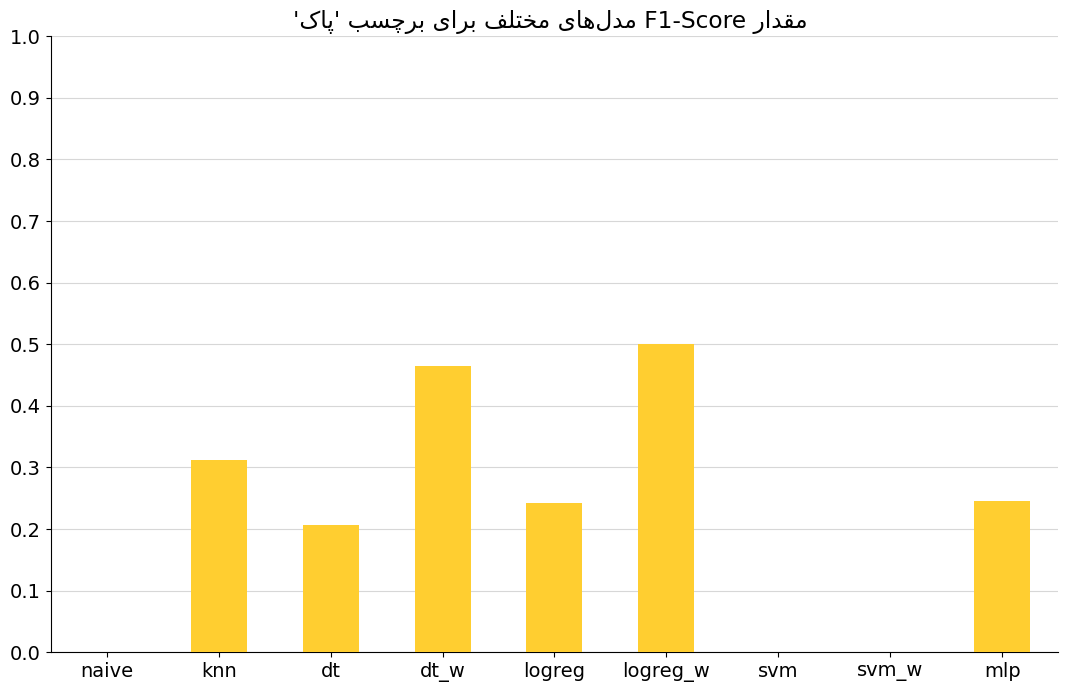

In [225]:
f1_score_barchart(methods, 1, color="#FFCE30")
plt.show()

> # F1-Score of Label 2:

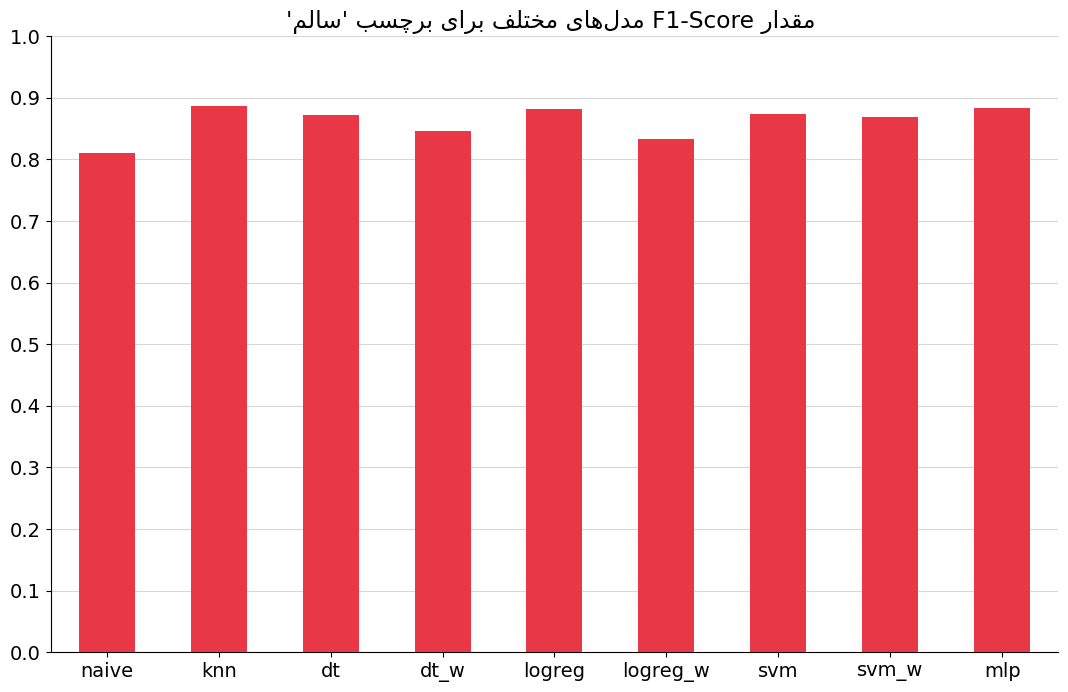

In [226]:
f1_score_barchart(methods, 2, color="#E83845")
plt.show()

> # F1-Score of Label 3:

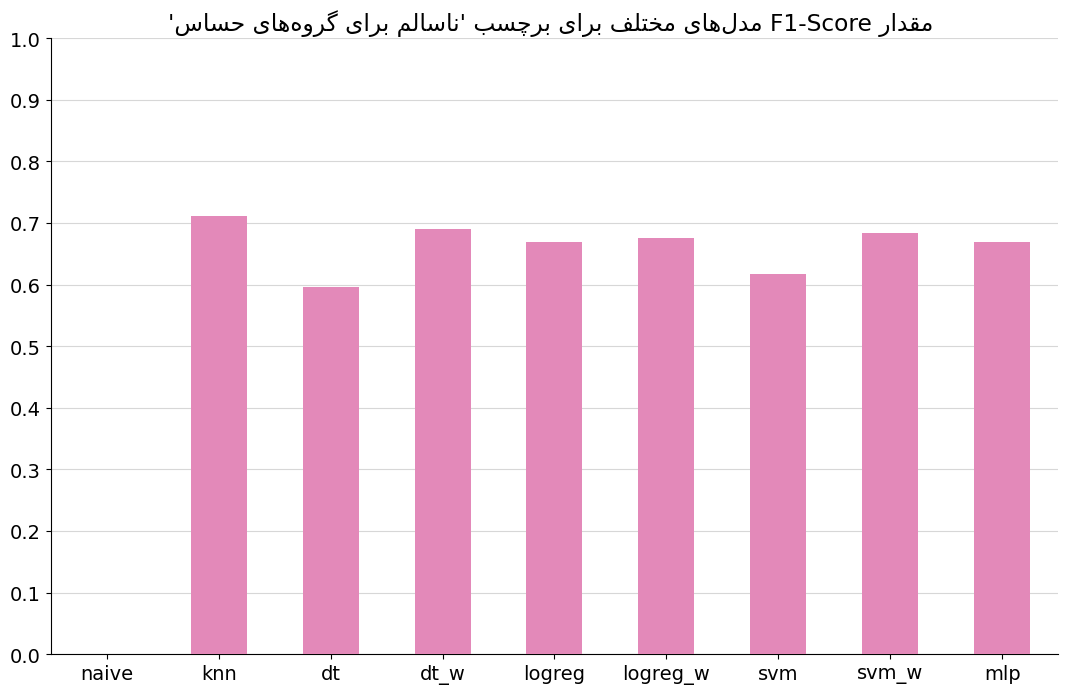

In [227]:
f1_score_barchart(methods, 3, color="#E389B9")
plt.show()

> # F1-Score of Label 4:

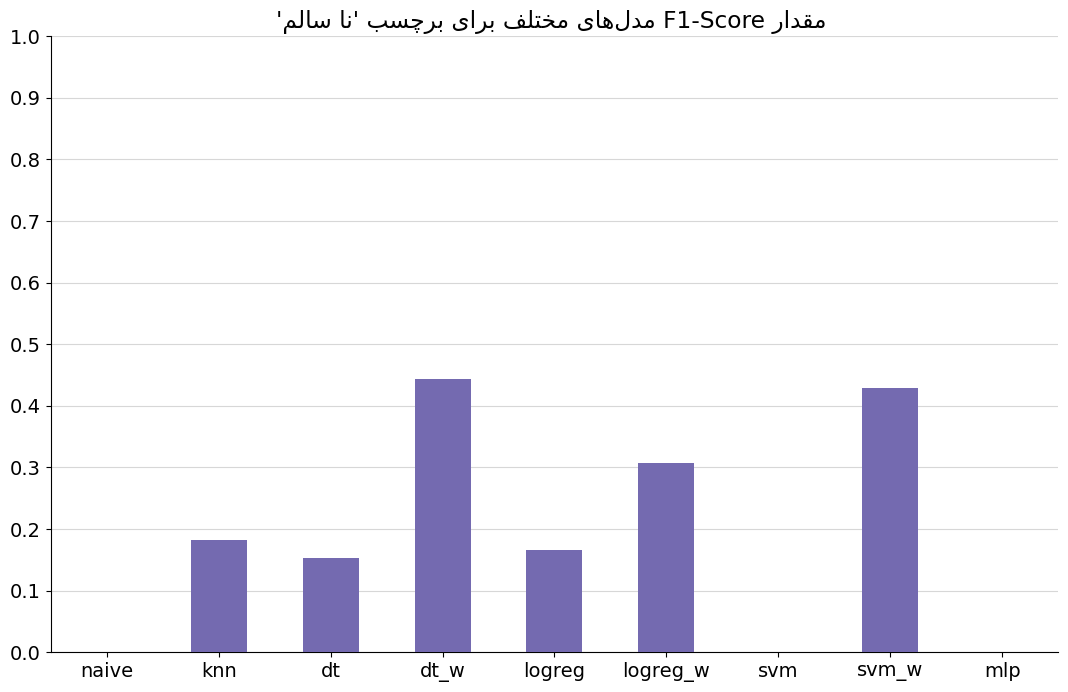

In [228]:
f1_score_barchart(methods, 4, color="#746AB0")
plt.show()

> # Accuracy

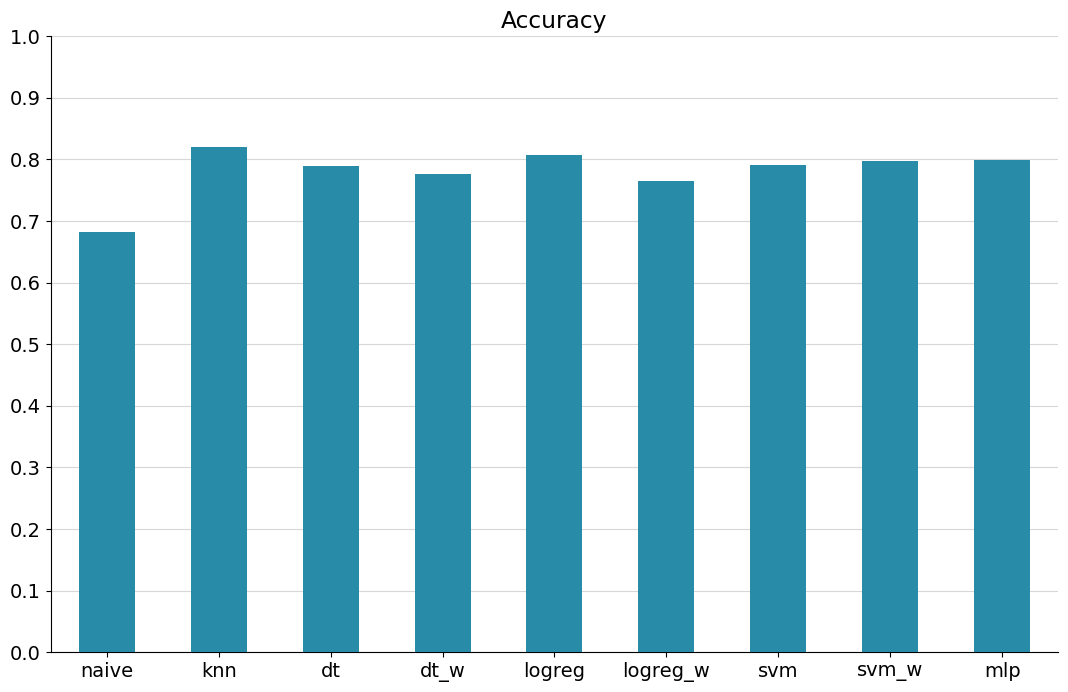

In [230]:
methods = ["naive", "knn", "dt", "dt_w", "logreg", "logreg_w", "svm", "svm_w", "mlp"]
accs = list()
color = ["#288BA8"] * len(methods)

for method in methods:
    accs.append( report[method]["accuracy"] )
    
    
df = pd.DataFrame({ "method": methods, "accuracy": accs})
df = df.reset_index().set_index('method').drop(columns=['index'])

_, ax = plt.subplots(1,1, figsize=(13,8))
df.plot(kind='bar', title="Accuracy", ax=ax, rot=0, xlabel='',color=color, zorder=5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_legend().remove()
ax.set_ylim(0,1)
ax.set_yticks([ix for ix in np.arange(0,1.01, 0.1)])
plt.grid(axis='y', alpha=.5, zorder=0)

plt.savefig("./plots/all/accuracy.png")
plt.show()


---